In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [4]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [5]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [6]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00     4585  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00     4210  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00     4313  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00     4452  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00     3828  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [7]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [10]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_perso(y_test,y_predict)

12.489389638804065

In [27]:
import lightgbm as lgb

In [110]:
uber_man.head()

pickups   spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                    
2015-01-08 01:00:00      739  21.0  10.0  12.0 -13.0  1022.7    0.0    0.0   
2015-01-08 02:00:00      443  14.0  10.0  11.0 -11.0  1023.6    0.0    0.0   
2015-01-08 03:00:00      268  14.0  10.0  10.0 -11.0  1024.2    0.0    0.0   
2015-01-08 04:00:00      217  13.0  10.0  10.0 -11.0  1024.1    0.0    0.0   
2015-01-08 05:00:00      322  13.0  10.0   9.0 -12.0  1025.1    0.0    0.0   

                     pcp24        sd  hday_N  hday_Y   lag_1   lag_2   lag_3  \
pickup_dt                                                                      
2015-01-08 01:00:00    0.0  0.833333       1       0  1524.0  2664.0  3603.0   
2015-01-08 02:00:00    0.0  0.875000       1       0   739.0  1524.0  2664.0   
2015-01-08 03:00:00    0.0  0.916667       1       0   443.0   739.0  1524.0   
2015-01-08 04:00:00    0.0  0.958333       1       0   268.0   443.0   739.0   
2015-01-08 05:00:00    0.0  1.000000       1       0   217.0   268.0   443.0   

                      lag_4  lag_24  lag_168  
pickup_dt                                     
2015-01-08 01:00:00  3867.0   601.0   5258.0  
2015-01-08 02:00:00  3603.0   320.0   4345.0  
2015-01-08 03:00:00  2664.0   204.0   4577.0  
2015-01-08 04:00:00  1524.0   200.0   3003.0  
2015-01-08 05:00:00   739.0   331.0   1313.0

In [159]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 0.3)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [151]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [153]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.744908
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734965
[3]	valid_0's mape: 0.72522
[4]	valid_0's mape: 0.715596
[5]	valid_0's mape: 0.706131
[6]	valid_0's mape: 0.696847
[7]	valid_0's mape: 0.687745
[8]	valid_0's mape: 0.678675
[9]	valid_0's mape: 0.669924
[10]	valid_0's mape: 0.661295
[11]	valid_0's mape: 0.652613
[12]	valid_0's mape: 0.644227
[13]	valid_0's mape: 0.636051
[14]	valid_0's mape: 0.62787
[15]	valid_0's mape: 0.619986
[16]	valid_0's mape: 0.612423
[17]	valid_0's mape: 0.604742
[18]	valid_0's mape: 0.597422
[19]	valid_0's mape: 0.58998
[20]	valid_0's mape: 0.58288
[21]	valid_0's mape: 0.575925
[22]	valid_0's mape: 0.569052
[23]	valid_0's mape: 0.561809
[24]	valid_0's mape: 0.554783
[25]	valid_0's mape: 0.547866
[26]	valid_0's mape: 0.540959
[27]	valid_0's mape: 0.534622
[28]	valid_0's mape: 0.527918
[29]	valid_0's mape: 0.521606
[30]	valid_0's map

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[144]	valid_0's mape: 0.179647
[145]	valid_0's mape: 0.178501
[146]	valid_0's mape: 0.177488
[147]	valid_0's mape: 0.176395
[148]	valid_0's mape: 0.17543
[149]	valid_0's mape: 0.174409
[150]	valid_0's mape: 0.17348
[151]	valid_0's mape: 0.172424
[152]	valid_0's mape: 0.171492
[153]	valid_0's mape: 0.170475
[154]	valid_0's mape: 0.169485
[155]	valid_0's mape: 0.168633
[156]	valid_0's mape: 0.167759
[157]	valid_0's mape: 0.16682
[158]	valid_0's mape: 0.166053
[159]	valid_0's mape: 0.165145
[160]	valid_0's mape: 0.164308
[161]	valid_0's mape: 0.1635
[162]	valid_0's mape: 0.162682
[163]	valid_0's mape: 0.161987
[164]	valid_0's mape: 0.161205
[165]	valid_0's mape: 0.160411
[166]	valid_0's mape: 0.159826
[167]	valid_0's mape: 0.159055
[168]	valid_0's mape: 0.158467
[169]	valid_0's mape: 0.157764
[170]	valid_0's mape: 0.157205
[171]	valid_0's mape: 0.156471
[172]	valid_0's mape: 0.155925
[173]	valid_0's mape: 0.155324
[174]	valid_0's mape: 0.154737
[175]	valid_0's mape: 0.154192
[176]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[39]	valid_0's mape: 0.483837
[40]	valid_0's mape: 0.478148
[41]	valid_0's mape: 0.472328
[42]	valid_0's mape: 0.466778
[43]	valid_0's mape: 0.461108
[44]	valid_0's mape: 0.455532
[45]	valid_0's mape: 0.450035
[46]	valid_0's mape: 0.44464
[47]	valid_0's mape: 0.439359
[48]	valid_0's mape: 0.43409
[49]	valid_0's mape: 0.429165
[50]	valid_0's mape: 0.424086
[51]	valid_0's mape: 0.419234
[52]	valid_0's mape: 0.414236
[53]	valid_0's mape: 0.409289
[54]	valid_0's mape: 0.404454
[55]	valid_0's mape: 0.399726
[56]	valid_0's mape: 0.395157
[57]	valid_0's mape: 0.390647
[58]	valid_0's mape: 0.386222
[59]	valid_0's mape: 0.381691
[60]	valid_0's mape: 0.377379
[61]	valid_0's mape: 0.373027
[62]	valid_0's mape: 0.368892
[63]	valid_0's mape: 0.36469
[64]	valid_0's mape: 0.360557
[65]	valid_0's mape: 0.356543
[66]	valid_0's mape: 0.352591
[67]	valid_0's mape: 0.348537
[68]	valid_0's mape: 0.34467
[69]	valid_0's mape: 0.340787
[70]	valid_0's mape: 0.337134
[71]	valid_0's mape: 0.333399
[72]	valid_0'

[431]	valid_0's mape: 0.112113
[432]	valid_0's mape: 0.112118
[433]	valid_0's mape: 0.112039
[434]	valid_0's mape: 0.111967
[435]	valid_0's mape: 0.111995
[436]	valid_0's mape: 0.112021
[437]	valid_0's mape: 0.112023
[438]	valid_0's mape: 0.112009
[439]	valid_0's mape: 0.11204
[440]	valid_0's mape: 0.112064
[441]	valid_0's mape: 0.112074
[442]	valid_0's mape: 0.112101
[443]	valid_0's mape: 0.112132
[444]	valid_0's mape: 0.112059
[445]	valid_0's mape: 0.112073
[446]	valid_0's mape: 0.112101
[447]	valid_0's mape: 0.112119
[448]	valid_0's mape: 0.112114
[449]	valid_0's mape: 0.112141
[450]	valid_0's mape: 0.112155
[451]	valid_0's mape: 0.112095
[452]	valid_0's mape: 0.112129
[453]	valid_0's mape: 0.112063
[454]	valid_0's mape: 0.112077
[455]	valid_0's mape: 0.112025
[456]	valid_0's mape: 0.111974
[457]	valid_0's mape: 0.112006
[458]	valid_0's mape: 0.111956
[459]	valid_0's mape: 0.111951
[460]	valid_0's mape: 0.111964
[461]	valid_0's mape: 0.111917
[462]	valid_0's mape: 0.111872
[463]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.439597
[48]	valid_0's mape: 0.434814
[49]	valid_0's mape: 0.429899
[50]	valid_0's mape: 0.425265
[51]	valid_0's mape: 0.420647
[52]	valid_0's mape: 0.415868
[53]	valid_0's mape: 0.411253
[54]	valid_0's mape: 0.406999
[55]	valid_0's mape: 0.4027
[56]	valid_0's mape: 0.398235
[57]	valid_0's mape: 0.393806
[58]	valid_0's mape: 0.389665
[59]	valid_0's mape: 0.385532
[60]	valid_0's mape: 0.381376
[61]	valid_0's mape: 0.377444
[62]	valid_0's mape: 0.373408
[63]	valid_0's mape: 0.369555
[64]	valid_0's mape: 0.365595
[65]	valid_0's mape: 0.361861
[66]	valid_0's mape: 0.358026
[67]	valid_0's mape: 0.354336
[68]	valid_0's mape: 0.350666
[69]	valid_0's mape: 0.347063
[70]	valid_0's mape: 0.343208
[71]	valid_0's mape: 0.339605
[72]	valid_0's mape: 0.336138
[73]	valid_0's mape: 0.33251
[74]	valid_0's mape: 0.329156
[75]	valid_0's mape: 0.325685
[76]	valid_0's mape: 0.322414
[77]	valid_0's mape: 0.31897
[78]	valid_0's mape: 0.315515
[79]	valid_0's mape: 0.312302
[80]	valid_0's

[340]	valid_0's mape: 0.108451
[341]	valid_0's mape: 0.10841
[342]	valid_0's mape: 0.108395
[343]	valid_0's mape: 0.10834
[344]	valid_0's mape: 0.108326
[345]	valid_0's mape: 0.108294
[346]	valid_0's mape: 0.108282
[347]	valid_0's mape: 0.108267
[348]	valid_0's mape: 0.108278
[349]	valid_0's mape: 0.108276
[350]	valid_0's mape: 0.108264
[351]	valid_0's mape: 0.108266
[352]	valid_0's mape: 0.108245
[353]	valid_0's mape: 0.108245
[354]	valid_0's mape: 0.108212
[355]	valid_0's mape: 0.108208
[356]	valid_0's mape: 0.108222
[357]	valid_0's mape: 0.108218
[358]	valid_0's mape: 0.108208
[359]	valid_0's mape: 0.108194
[360]	valid_0's mape: 0.108184
[361]	valid_0's mape: 0.108196
[362]	valid_0's mape: 0.108196
[363]	valid_0's mape: 0.108186
[364]	valid_0's mape: 0.108182
[365]	valid_0's mape: 0.108176
[366]	valid_0's mape: 0.10818
[367]	valid_0's mape: 0.108155
[368]	valid_0's mape: 0.108132
[369]	valid_0's mape: 0.108137
[370]	valid_0's mape: 0.108146
[371]	valid_0's mape: 0.108155
[372]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.73236
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71032
[3]	valid_0's mape: 0.688227
[4]	valid_0's mape: 0.667594
[5]	valid_0's mape: 0.647307
[6]	valid_0's mape: 0.628475
[7]	valid_0's mape: 0.609898
[8]	valid_0's mape: 0.591379
[9]	valid_0's mape: 0.574133
[10]	valid_0's mape: 0.556925
[11]	valid_0's mape: 0.540165
[12]	valid_0's mape: 0.524366
[13]	valid_0's mape: 0.509237
[14]	valid_0's mape: 0.494648
[15]	valid_0's mape: 0.480507
[16]	valid_0's mape: 0.466684
[17]	valid_0's mape: 0.4534
[18]	valid_0's mape: 0.441428
[19]	valid_0's mape: 0.428734
[20]	valid_0's mape: 0.417244
[21]	valid_0's mape: 0.406069
[22]	valid_0's mape: 0.395439
[23]	valid_0's mape: 0.384678
[24]	valid_0's mape: 0.374657
[25]	valid_0's mape: 0.364921
[26]	valid_0's mape: 0.35569
[27]	valid_0's mape: 0.346467
[28]	valid_0's mape: 0.337729
[29]	valid_0's mape: 0.329109
[30]	valid_0's mape: 0.321099
[31]	valid_0's mape: 0.313257
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.110809
[108]	valid_0's mape: 0.110634
[109]	valid_0's mape: 0.110453
[110]	valid_0's mape: 0.110361
[111]	valid_0's mape: 0.110342
[112]	valid_0's mape: 0.110199
[113]	valid_0's mape: 0.110108
[114]	valid_0's mape: 0.110077
[115]	valid_0's mape: 0.110018
[116]	valid_0's mape: 0.109887
[117]	valid_0's mape: 0.109849
[118]	valid_0's mape: 0.109833
[119]	valid_0's mape: 0.109858
[120]	valid_0's mape: 0.109665
[121]	valid_0's mape: 0.109741
[122]	valid_0's mape: 0.109783
[123]	valid_0's mape: 0.109663
[124]	valid_0's mape: 0.109577
[125]	valid_0's mape: 0.109623
[126]	valid_0's mape: 0.109708
[127]	valid_0's mape: 0.10964
[128]	valid_0's mape: 0.109731
[129]	valid_0's mape: 0.109782
[130]	valid_0's mape: 0.109783
[131]	valid_0's mape: 0.109908
[132]	valid_0's mape: 0.109967
[133]	valid_0's mape: 0.110032
[134]	valid_0's mape: 0.110058
[135]	valid_0's mape: 0.110011
[136]	valid_0's mape: 0.110091
[137]	valid_0's mape: 0.110121
[138]	valid_0's mape: 0.110179
[139]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.474493
[18]	valid_0's mape: 0.461115
[19]	valid_0's mape: 0.448021
[20]	valid_0's mape: 0.435448
[21]	valid_0's mape: 0.423246
[22]	valid_0's mape: 0.411822
[23]	valid_0's mape: 0.400744
[24]	valid_0's mape: 0.389828
[25]	valid_0's mape: 0.379378
[26]	valid_0's mape: 0.368974
[27]	valid_0's mape: 0.358981
[28]	valid_0's mape: 0.349499
[29]	valid_0's mape: 0.340095
[30]	valid_0's mape: 0.330772
[31]	valid_0's mape: 0.321959
[32]	valid_0's mape: 0.313442
[33]	valid_0's mape: 0.305162
[34]	valid_0's mape: 0.297205
[35]	valid_0's mape: 0.289445
[36]	valid_0's mape: 0.282041
[37]	valid_0's mape: 0.274912
[38]	valid_0's mape: 0.268011
[39]	valid_0's mape: 0.261385
[40]	valid_0's mape: 0.25486
[41]	valid_0's mape: 0.248725
[42]	valid_0's mape: 0.242549
[43]	valid_0's mape: 0.236925
[44]	valid_0's mape: 0.23125
[45]	valid_0's mape: 0.225968
[46]	valid_0's mape: 0.220909
[47]	valid_0's mape: 0.216018
[48]	valid_0's mape: 0.211158
[49]	valid_0's mape: 0.206416
[50]	valid_0

[288]	valid_0's mape: 0.104392
[289]	valid_0's mape: 0.104408
[290]	valid_0's mape: 0.104408
[291]	valid_0's mape: 0.104438
Early stopping, best iteration is:
[191]	valid_0's mape: 0.103568
[1]	valid_0's mape: 0.745049
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735297
[3]	valid_0's mape: 0.725698
[4]	valid_0's mape: 0.716266
[5]	valid_0's mape: 0.706984
[6]	valid_0's mape: 0.697851
[7]	valid_0's mape: 0.688844
[8]	valid_0's mape: 0.680063
[9]	valid_0's mape: 0.671348
[10]	valid_0's mape: 0.66285
[11]	valid_0's mape: 0.654418
[12]	valid_0's mape: 0.646196
[13]	valid_0's mape: 0.638129
[14]	valid_0's mape: 0.629979
[15]	valid_0's mape: 0.622109
[16]	valid_0's mape: 0.61471
[17]	valid_0's mape: 0.607545
[18]	valid_0's mape: 0.59993
[19]	valid_0's mape: 0.593013
[20]	valid_0's mape: 0.586089
[21]	valid_0's mape: 0.578895
[22]	valid_0's mape: 0.572288
[23]	valid_0's mape: 0.565567
[24]	valid_0's mape: 0.558933
[25]	valid_0's mape: 0.552193
[26]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[123]	valid_0's mape: 0.209874
[124]	valid_0's mape: 0.208303
[125]	valid_0's mape: 0.206739
[126]	valid_0's mape: 0.205224
[127]	valid_0's mape: 0.203822
[128]	valid_0's mape: 0.202323
[129]	valid_0's mape: 0.200904
[130]	valid_0's mape: 0.199433
[131]	valid_0's mape: 0.198079
[132]	valid_0's mape: 0.196762
[133]	valid_0's mape: 0.195402
[134]	valid_0's mape: 0.194187
[135]	valid_0's mape: 0.192853
[136]	valid_0's mape: 0.191614
[137]	valid_0's mape: 0.190357
[138]	valid_0's mape: 0.189165
[139]	valid_0's mape: 0.187975
[140]	valid_0's mape: 0.186815
[141]	valid_0's mape: 0.185691
[142]	valid_0's mape: 0.184577
[143]	valid_0's mape: 0.183453
[144]	valid_0's mape: 0.182418
[145]	valid_0's mape: 0.181493
[146]	valid_0's mape: 0.180429
[147]	valid_0's mape: 0.179444
[148]	valid_0's mape: 0.17844
[149]	valid_0's mape: 0.17762
[150]	valid_0's mape: 0.176686
[151]	valid_0's mape: 0.175849
[152]	valid_0's mape: 0.174925
[153]	valid_0's mape: 0.17404
[154]	valid_0's mape: 0.173252
[155]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[84]	valid_0's mape: 0.300034
[85]	valid_0's mape: 0.297007
[86]	valid_0's mape: 0.293995
[87]	valid_0's mape: 0.291095
[88]	valid_0's mape: 0.288429
[89]	valid_0's mape: 0.285467
[90]	valid_0's mape: 0.282689
[91]	valid_0's mape: 0.280071
[92]	valid_0's mape: 0.277303
[93]	valid_0's mape: 0.274611
[94]	valid_0's mape: 0.272097
[95]	valid_0's mape: 0.269445
[96]	valid_0's mape: 0.266814
[97]	valid_0's mape: 0.264187
[98]	valid_0's mape: 0.261803
[99]	valid_0's mape: 0.259303
[100]	valid_0's mape: 0.256862
[101]	valid_0's mape: 0.254478
[102]	valid_0's mape: 0.252309
[103]	valid_0's mape: 0.249975
[104]	valid_0's mape: 0.247719
[105]	valid_0's mape: 0.245435
[106]	valid_0's mape: 0.243158
[107]	valid_0's mape: 0.240959
[108]	valid_0's mape: 0.238979
[109]	valid_0's mape: 0.236783
[110]	valid_0's mape: 0.234662
[111]	valid_0's mape: 0.232561
[112]	valid_0's mape: 0.230478
[113]	valid_0's mape: 0.228789
[114]	valid_0's mape: 0.226759
[115]	valid_0's mape: 0.225123
[116]	valid_0's mape: 0.

[360]	valid_0's mape: 0.118812
[361]	valid_0's mape: 0.118759
[362]	valid_0's mape: 0.118844
[363]	valid_0's mape: 0.118809
[364]	valid_0's mape: 0.118842
[365]	valid_0's mape: 0.118798
[366]	valid_0's mape: 0.118816
[367]	valid_0's mape: 0.118894
[368]	valid_0's mape: 0.118852
[369]	valid_0's mape: 0.118886
[370]	valid_0's mape: 0.118862
[371]	valid_0's mape: 0.118862
[372]	valid_0's mape: 0.118896
[373]	valid_0's mape: 0.118877
[374]	valid_0's mape: 0.118949
[375]	valid_0's mape: 0.118922
[376]	valid_0's mape: 0.118956
[377]	valid_0's mape: 0.118914
[378]	valid_0's mape: 0.118909
[379]	valid_0's mape: 0.118894
[380]	valid_0's mape: 0.118922
[381]	valid_0's mape: 0.11895
[382]	valid_0's mape: 0.119157
[383]	valid_0's mape: 0.119148
[384]	valid_0's mape: 0.119167
[385]	valid_0's mape: 0.119186
[386]	valid_0's mape: 0.119179
[387]	valid_0's mape: 0.119208
[388]	valid_0's mape: 0.119188
[389]	valid_0's mape: 0.119322
[390]	valid_0's mape: 0.119548
[391]	valid_0's mape: 0.11953
[392]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[38]	valid_0's mape: 0.493315
[39]	valid_0's mape: 0.487671
[40]	valid_0's mape: 0.48225
[41]	valid_0's mape: 0.476967
[42]	valid_0's mape: 0.471526
[43]	valid_0's mape: 0.466151
[44]	valid_0's mape: 0.461077
[45]	valid_0's mape: 0.455605
[46]	valid_0's mape: 0.450323
[47]	valid_0's mape: 0.445516
[48]	valid_0's mape: 0.440307
[49]	valid_0's mape: 0.435658
[50]	valid_0's mape: 0.430785
[51]	valid_0's mape: 0.426263
[52]	valid_0's mape: 0.421611
[53]	valid_0's mape: 0.41691
[54]	valid_0's mape: 0.412572
[55]	valid_0's mape: 0.408133
[56]	valid_0's mape: 0.403826
[57]	valid_0's mape: 0.399594
[58]	valid_0's mape: 0.395432
[59]	valid_0's mape: 0.391393
[60]	valid_0's mape: 0.387045
[61]	valid_0's mape: 0.382987
[62]	valid_0's mape: 0.379014
[63]	valid_0's mape: 0.375065
[64]	valid_0's mape: 0.371133
[65]	valid_0's mape: 0.367254
[66]	valid_0's mape: 0.363453
[67]	valid_0's mape: 0.359815
[68]	valid_0's mape: 0.356122
[69]	valid_0's mape: 0.352571
[70]	valid_0's mape: 0.349018
[71]	valid_

[370]	valid_0's mape: 0.111517
[371]	valid_0's mape: 0.111523
[372]	valid_0's mape: 0.111521
[373]	valid_0's mape: 0.11151
[374]	valid_0's mape: 0.111477
[375]	valid_0's mape: 0.111442
[376]	valid_0's mape: 0.111438
[377]	valid_0's mape: 0.111431
[378]	valid_0's mape: 0.111398
[379]	valid_0's mape: 0.111383
[380]	valid_0's mape: 0.111349
[381]	valid_0's mape: 0.111348
[382]	valid_0's mape: 0.111333
[383]	valid_0's mape: 0.111332
[384]	valid_0's mape: 0.111327
[385]	valid_0's mape: 0.11131
[386]	valid_0's mape: 0.111306
[387]	valid_0's mape: 0.111292
[388]	valid_0's mape: 0.111281
[389]	valid_0's mape: 0.111266
[390]	valid_0's mape: 0.111251
[391]	valid_0's mape: 0.111241
[392]	valid_0's mape: 0.111225
[393]	valid_0's mape: 0.11122
[394]	valid_0's mape: 0.111205
[395]	valid_0's mape: 0.111203
[396]	valid_0's mape: 0.111177
[397]	valid_0's mape: 0.111167
[398]	valid_0's mape: 0.111147
[399]	valid_0's mape: 0.111137
[400]	valid_0's mape: 0.111122
[401]	valid_0's mape: 0.111129
[402]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[67]	valid_0's mape: 0.29983
[68]	valid_0's mape: 0.296314
[69]	valid_0's mape: 0.292981
[70]	valid_0's mape: 0.28958
[71]	valid_0's mape: 0.286293
[72]	valid_0's mape: 0.282925
[73]	valid_0's mape: 0.279763
[74]	valid_0's mape: 0.276495
[75]	valid_0's mape: 0.273235
[76]	valid_0's mape: 0.270082
[77]	valid_0's mape: 0.266979
[78]	valid_0's mape: 0.264227
[79]	valid_0's mape: 0.261303
[80]	valid_0's mape: 0.258376
[81]	valid_0's mape: 0.255479
[82]	valid_0's mape: 0.252908
[83]	valid_0's mape: 0.250224
[84]	valid_0's mape: 0.247503
[85]	valid_0's mape: 0.245077
[86]	valid_0's mape: 0.242514
[87]	valid_0's mape: 0.23992
[88]	valid_0's mape: 0.237555
[89]	valid_0's mape: 0.235147
[90]	valid_0's mape: 0.232675
[91]	valid_0's mape: 0.230224
[92]	valid_0's mape: 0.227882
[93]	valid_0's mape: 0.225522
[94]	valid_0's mape: 0.223192
[95]	valid_0's mape: 0.220888
[96]	valid_0's mape: 0.218863
[97]	valid_0's mape: 0.21668
[98]	valid_0's mape: 0.214569
[99]	valid_0's mape: 0.212479
[100]	valid_0'

[360]	valid_0's mape: 0.13085
[361]	valid_0's mape: 0.130808
[362]	valid_0's mape: 0.130838
[363]	valid_0's mape: 0.130798
[364]	valid_0's mape: 0.130819
Early stopping, best iteration is:
[264]	valid_0's mape: 0.128516
[1]	valid_0's mape: 0.783394
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.77186
[3]	valid_0's mape: 0.760478
[4]	valid_0's mape: 0.74929
[5]	valid_0's mape: 0.738275
[6]	valid_0's mape: 0.727403
[7]	valid_0's mape: 0.716744
[8]	valid_0's mape: 0.706219
[9]	valid_0's mape: 0.695924
[10]	valid_0's mape: 0.686095
[11]	valid_0's mape: 0.6764
[12]	valid_0's mape: 0.666945
[13]	valid_0's mape: 0.657557
[14]	valid_0's mape: 0.648365
[15]	valid_0's mape: 0.639295
[16]	valid_0's mape: 0.630418
[17]	valid_0's mape: 0.621518
[18]	valid_0's mape: 0.612802
[19]	valid_0's mape: 0.604308
[20]	valid_0's mape: 0.59591
[21]	valid_0's mape: 0.587392
[22]	valid_0's mape: 0.579284
[23]	valid_0's mape: 0.571306
[24]	valid_0's mape: 0.563235
[25]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[89]	valid_0's mape: 0.240828
[90]	valid_0's mape: 0.238082
[91]	valid_0's mape: 0.235266
[92]	valid_0's mape: 0.232606
[93]	valid_0's mape: 0.230045
[94]	valid_0's mape: 0.227372
[95]	valid_0's mape: 0.224997
[96]	valid_0's mape: 0.222406
[97]	valid_0's mape: 0.219844
[98]	valid_0's mape: 0.217415
[99]	valid_0's mape: 0.21498
[100]	valid_0's mape: 0.212699
[101]	valid_0's mape: 0.210608
[102]	valid_0's mape: 0.208422
[103]	valid_0's mape: 0.206311
[104]	valid_0's mape: 0.204208
[105]	valid_0's mape: 0.202137
[106]	valid_0's mape: 0.200185
[107]	valid_0's mape: 0.198174
[108]	valid_0's mape: 0.196215
[109]	valid_0's mape: 0.194139
[110]	valid_0's mape: 0.192143
[111]	valid_0's mape: 0.190184
[112]	valid_0's mape: 0.188301
[113]	valid_0's mape: 0.186445
[114]	valid_0's mape: 0.184689
[115]	valid_0's mape: 0.183006
[116]	valid_0's mape: 0.181325
[117]	valid_0's mape: 0.179664
[118]	valid_0's mape: 0.178008
[119]	valid_0's mape: 0.176314
[120]	valid_0's mape: 0.174612
[121]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.687734
[10]	valid_0's mape: 0.677734
[11]	valid_0's mape: 0.667984
[12]	valid_0's mape: 0.658371
[13]	valid_0's mape: 0.648892
[14]	valid_0's mape: 0.639611
[15]	valid_0's mape: 0.630482
[16]	valid_0's mape: 0.621516
[17]	valid_0's mape: 0.612609
[18]	valid_0's mape: 0.603924
[19]	valid_0's mape: 0.595382
[20]	valid_0's mape: 0.586963
[21]	valid_0's mape: 0.578684
[22]	valid_0's mape: 0.570548
[23]	valid_0's mape: 0.562483
[24]	valid_0's mape: 0.554511
[25]	valid_0's mape: 0.546737
[26]	valid_0's mape: 0.539086
[27]	valid_0's mape: 0.531653
[28]	valid_0's mape: 0.524357
[29]	valid_0's mape: 0.517166
[30]	valid_0's mape: 0.509991
[31]	valid_0's mape: 0.503018
[32]	valid_0's mape: 0.495891
[33]	valid_0's mape: 0.488933
[34]	valid_0's mape: 0.48213
[35]	valid_0's mape: 0.475331
[36]	valid_0's mape: 0.468629
[37]	valid_0's mape: 0.462051
[38]	valid_0's mape: 0.455544
[39]	valid_0's mape: 0.449272
[40]	valid_0's mape: 0.443148
[41]	valid_0's mape: 0.437042
[42]	valid_0

[364]	valid_0's mape: 0.102752
[365]	valid_0's mape: 0.10277
[366]	valid_0's mape: 0.102778
[367]	valid_0's mape: 0.10278
[368]	valid_0's mape: 0.102783
[369]	valid_0's mape: 0.102789
[370]	valid_0's mape: 0.102804
[371]	valid_0's mape: 0.102811
[372]	valid_0's mape: 0.102839
[373]	valid_0's mape: 0.102842
[374]	valid_0's mape: 0.102848
[375]	valid_0's mape: 0.10285
[376]	valid_0's mape: 0.102861
[377]	valid_0's mape: 0.102855
[378]	valid_0's mape: 0.102883
[379]	valid_0's mape: 0.102922
[380]	valid_0's mape: 0.102925
[381]	valid_0's mape: 0.102941
[382]	valid_0's mape: 0.102955
[383]	valid_0's mape: 0.102964
[384]	valid_0's mape: 0.103013
[385]	valid_0's mape: 0.103017
[386]	valid_0's mape: 0.103026
[387]	valid_0's mape: 0.103036
[388]	valid_0's mape: 0.10303
[389]	valid_0's mape: 0.103052
[390]	valid_0's mape: 0.103059
[391]	valid_0's mape: 0.103078
[392]	valid_0's mape: 0.103084
[393]	valid_0's mape: 0.103061
[394]	valid_0's mape: 0.103053
[395]	valid_0's mape: 0.103046
[396]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.588073
[52]	valid_0's mape: 0.585301
[53]	valid_0's mape: 0.58249
[54]	valid_0's mape: 0.579806
[55]	valid_0's mape: 0.577018
[56]	valid_0's mape: 0.574364
[57]	valid_0's mape: 0.571637
[58]	valid_0's mape: 0.568979
[59]	valid_0's mape: 0.566281
[60]	valid_0's mape: 0.563666
[61]	valid_0's mape: 0.561025
[62]	valid_0's mape: 0.558445
[63]	valid_0's mape: 0.555866
[64]	valid_0's mape: 0.553244
[65]	valid_0's mape: 0.550651
[66]	valid_0's mape: 0.548082
[67]	valid_0's mape: 0.545537
[68]	valid_0's mape: 0.542997
[69]	valid_0's mape: 0.540423
[70]	valid_0's mape: 0.537885
[71]	valid_0's mape: 0.535364
[72]	valid_0's mape: 0.53296
[73]	valid_0's mape: 0.530446
[74]	valid_0's mape: 0.528029
[75]	valid_0's mape: 0.525621
[76]	valid_0's mape: 0.52313
[77]	valid_0's mape: 0.520745
[78]	valid_0's mape: 0.518305
[79]	valid_0's mape: 0.515891
[80]	valid_0's mape: 0.513576
[81]	valid_0's mape: 0.511189
[82]	valid_0's mape: 0.508841
[83]	valid_0's mape: 0.50638
[84]	valid_0's

[320]	valid_0's mape: 0.199201
[321]	valid_0's mape: 0.198654
[322]	valid_0's mape: 0.198052
[323]	valid_0's mape: 0.197533
[324]	valid_0's mape: 0.196952
[325]	valid_0's mape: 0.196378
[326]	valid_0's mape: 0.1958
[327]	valid_0's mape: 0.195271
[328]	valid_0's mape: 0.194691
[329]	valid_0's mape: 0.194134
[330]	valid_0's mape: 0.193636
[331]	valid_0's mape: 0.193085
[332]	valid_0's mape: 0.192531
[333]	valid_0's mape: 0.192046
[334]	valid_0's mape: 0.191499
[335]	valid_0's mape: 0.190962
[336]	valid_0's mape: 0.190467
[337]	valid_0's mape: 0.189943
[338]	valid_0's mape: 0.189401
[339]	valid_0's mape: 0.18891
[340]	valid_0's mape: 0.188375
[341]	valid_0's mape: 0.187852
[342]	valid_0's mape: 0.187353
[343]	valid_0's mape: 0.186876
[344]	valid_0's mape: 0.186362
[345]	valid_0's mape: 0.185875
[346]	valid_0's mape: 0.185388
[347]	valid_0's mape: 0.184878
[348]	valid_0's mape: 0.184387
[349]	valid_0's mape: 0.183923
[350]	valid_0's mape: 0.183428
[351]	valid_0's mape: 0.182939
[352]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[31]	valid_0's mape: 0.683112
[32]	valid_0's mape: 0.679903
[33]	valid_0's mape: 0.676727
[34]	valid_0's mape: 0.673533
[35]	valid_0's mape: 0.670389
[36]	valid_0's mape: 0.667231
[37]	valid_0's mape: 0.664123
[38]	valid_0's mape: 0.661005
[39]	valid_0's mape: 0.657916
[40]	valid_0's mape: 0.654856
[41]	valid_0's mape: 0.651799
[42]	valid_0's mape: 0.648718
[43]	valid_0's mape: 0.645691
[44]	valid_0's mape: 0.642662
[45]	valid_0's mape: 0.639665
[46]	valid_0's mape: 0.636667
[47]	valid_0's mape: 0.633702
[48]	valid_0's mape: 0.630719
[49]	valid_0's mape: 0.627796
[50]	valid_0's mape: 0.624873
[51]	valid_0's mape: 0.621948
[52]	valid_0's mape: 0.619089
[53]	valid_0's mape: 0.616194
[54]	valid_0's mape: 0.613336
[55]	valid_0's mape: 0.610473
[56]	valid_0's mape: 0.607633
[57]	valid_0's mape: 0.604801
[58]	valid_0's mape: 0.602044
[59]	valid_0's mape: 0.599193
[60]	valid_0's mape: 0.596372
[61]	valid_0's mape: 0.593625
[62]	valid_0's mape: 0.590806
[63]	valid_0's mape: 0.588064
[64]	vali

[389]	valid_0's mape: 0.160631
[390]	valid_0's mape: 0.160187
[391]	valid_0's mape: 0.159741
[392]	valid_0's mape: 0.1593
[393]	valid_0's mape: 0.158865
[394]	valid_0's mape: 0.158432
[395]	valid_0's mape: 0.15798
[396]	valid_0's mape: 0.157577
[397]	valid_0's mape: 0.157156
[398]	valid_0's mape: 0.156743
[399]	valid_0's mape: 0.156309
[400]	valid_0's mape: 0.155913
[401]	valid_0's mape: 0.155501
[402]	valid_0's mape: 0.155106
[403]	valid_0's mape: 0.154718
[404]	valid_0's mape: 0.154344
[405]	valid_0's mape: 0.153962
[406]	valid_0's mape: 0.153615
[407]	valid_0's mape: 0.153267
[408]	valid_0's mape: 0.152903
[409]	valid_0's mape: 0.152559
[410]	valid_0's mape: 0.15216
[411]	valid_0's mape: 0.151802
[412]	valid_0's mape: 0.151466
[413]	valid_0's mape: 0.151116
[414]	valid_0's mape: 0.150763
[415]	valid_0's mape: 0.150433
[416]	valid_0's mape: 0.150107
[417]	valid_0's mape: 0.149782
[418]	valid_0's mape: 0.149411
[419]	valid_0's mape: 0.149081
[420]	valid_0's mape: 0.148752
[421]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.779962
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.776207
[3]	valid_0's mape: 0.772429
[4]	valid_0's mape: 0.768669
[5]	valid_0's mape: 0.764975
[6]	valid_0's mape: 0.761297
[7]	valid_0's mape: 0.757622
[8]	valid_0's mape: 0.753967
[9]	valid_0's mape: 0.750335
[10]	valid_0's mape: 0.746736
[11]	valid_0's mape: 0.74314
[12]	valid_0's mape: 0.739568
[13]	valid_0's mape: 0.736012
[14]	valid_0's mape: 0.732486
[15]	valid_0's mape: 0.728968
[16]	valid_0's mape: 0.725467
[17]	valid_0's mape: 0.721978
[18]	valid_0's mape: 0.718508
[19]	valid_0's mape: 0.715034
[20]	valid_0's mape: 0.711583
[21]	valid_0's mape: 0.708144
[22]	valid_0's mape: 0.704752
[23]	valid_0's mape: 0.701347
[24]	valid_0's mape: 0.69799
[25]	valid_0's mape: 0.694586
[26]	valid_0's mape: 0.691239
[27]	valid_0's mape: 0.687877
[28]	valid_0's mape: 0.684549
[29]	valid_0's mape: 0.681242
[30]	valid_0's mape: 0.677954
[31]	valid_0's mape: 0.674696
[32]	valid_0's mape

[385]	valid_0's mape: 0.161225
[386]	valid_0's mape: 0.160796
[387]	valid_0's mape: 0.160363
[388]	valid_0's mape: 0.159903
[389]	valid_0's mape: 0.159474
[390]	valid_0's mape: 0.158998
[391]	valid_0's mape: 0.158562
[392]	valid_0's mape: 0.158126
[393]	valid_0's mape: 0.157676
[394]	valid_0's mape: 0.157261
[395]	valid_0's mape: 0.156832
[396]	valid_0's mape: 0.156422
[397]	valid_0's mape: 0.155986
[398]	valid_0's mape: 0.15558
[399]	valid_0's mape: 0.155131
[400]	valid_0's mape: 0.154688
[401]	valid_0's mape: 0.154246
[402]	valid_0's mape: 0.153809
[403]	valid_0's mape: 0.153378
[404]	valid_0's mape: 0.152949
[405]	valid_0's mape: 0.152524
[406]	valid_0's mape: 0.152102
[407]	valid_0's mape: 0.151685
[408]	valid_0's mape: 0.151264
[409]	valid_0's mape: 0.150855
[410]	valid_0's mape: 0.150446
[411]	valid_0's mape: 0.150043
[412]	valid_0's mape: 0.149647
[413]	valid_0's mape: 0.149247
[414]	valid_0's mape: 0.148861
[415]	valid_0's mape: 0.148483
[416]	valid_0's mape: 0.148117
[417]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747428
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739979
[3]	valid_0's mape: 0.732542
[4]	valid_0's mape: 0.725198
[5]	valid_0's mape: 0.717678
[6]	valid_0's mape: 0.710517
[7]	valid_0's mape: 0.703202
[8]	valid_0's mape: 0.696156
[9]	valid_0's mape: 0.689035
[10]	valid_0's mape: 0.682199
[11]	valid_0's mape: 0.675392
[12]	valid_0's mape: 0.668434
[13]	valid_0's mape: 0.661799
[14]	valid_0's mape: 0.655063
[15]	valid_0's mape: 0.6486
[16]	valid_0's mape: 0.641974
[17]	valid_0's mape: 0.635782
[18]	valid_0's mape: 0.629512
[19]	valid_0's mape: 0.623077
[20]	valid_0's mape: 0.617096
[21]	valid_0's mape: 0.61106
[22]	valid_0's mape: 0.604857
[23]	valid_0's mape: 0.598953
[24]	valid_0's mape: 0.593193
[25]	valid_0's mape: 0.587205
[26]	valid_0's mape: 0.581502
[27]	valid_0's mape: 0.575642
[28]	valid_0's mape: 0.570078
[29]	valid_0's mape: 0.564482
[30]	valid_0's mape: 0.558999
[31]	valid_0's mape: 0.553407
[32]	valid_0's mape:

[446]	valid_0's mape: 0.126239
[447]	valid_0's mape: 0.126205
[448]	valid_0's mape: 0.126172
[449]	valid_0's mape: 0.126158
[450]	valid_0's mape: 0.126182
[451]	valid_0's mape: 0.126145
[452]	valid_0's mape: 0.126138
[453]	valid_0's mape: 0.126114
[454]	valid_0's mape: 0.126074
[455]	valid_0's mape: 0.126089
[456]	valid_0's mape: 0.126053
[457]	valid_0's mape: 0.12607
[458]	valid_0's mape: 0.126091
[459]	valid_0's mape: 0.126093
[460]	valid_0's mape: 0.126114
[461]	valid_0's mape: 0.126128
[462]	valid_0's mape: 0.126086
[463]	valid_0's mape: 0.126107
[464]	valid_0's mape: 0.12611
[465]	valid_0's mape: 0.126072
[466]	valid_0's mape: 0.126087
[467]	valid_0's mape: 0.12612
[468]	valid_0's mape: 0.126087
[469]	valid_0's mape: 0.12609
[470]	valid_0's mape: 0.126094
[471]	valid_0's mape: 0.126116
[472]	valid_0's mape: 0.126112
[473]	valid_0's mape: 0.126099
[474]	valid_0's mape: 0.126067
[475]	valid_0's mape: 0.126088
[476]	valid_0's mape: 0.126091
[477]	valid_0's mape: 0.126047
[478]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[56]	valid_0's mape: 0.462696
[57]	valid_0's mape: 0.458309
[58]	valid_0's mape: 0.45408
[59]	valid_0's mape: 0.449738
[60]	valid_0's mape: 0.445595
[61]	valid_0's mape: 0.441389
[62]	valid_0's mape: 0.437378
[63]	valid_0's mape: 0.433269
[64]	valid_0's mape: 0.42914
[65]	valid_0's mape: 0.425101
[66]	valid_0's mape: 0.421296
[67]	valid_0's mape: 0.41731
[68]	valid_0's mape: 0.413554
[69]	valid_0's mape: 0.409676
[70]	valid_0's mape: 0.405796
[71]	valid_0's mape: 0.402184
[72]	valid_0's mape: 0.398429
[73]	valid_0's mape: 0.394856
[74]	valid_0's mape: 0.391306
[75]	valid_0's mape: 0.387671
[76]	valid_0's mape: 0.384124
[77]	valid_0's mape: 0.380698
[78]	valid_0's mape: 0.377342
[79]	valid_0's mape: 0.373895
[80]	valid_0's mape: 0.370647
[81]	valid_0's mape: 0.367275
[82]	valid_0's mape: 0.364012
[83]	valid_0's mape: 0.360704
[84]	valid_0's mape: 0.357463
[85]	valid_0's mape: 0.35423
[86]	valid_0's mape: 0.351079
[87]	valid_0's mape: 0.347878
[88]	valid_0's mape: 0.344797
[89]	valid_0'

[373]	valid_0's mape: 0.108848
[374]	valid_0's mape: 0.108821
[375]	valid_0's mape: 0.108829
[376]	valid_0's mape: 0.108819
[377]	valid_0's mape: 0.108814
[378]	valid_0's mape: 0.108815
[379]	valid_0's mape: 0.108801
[380]	valid_0's mape: 0.1088
[381]	valid_0's mape: 0.108788
[382]	valid_0's mape: 0.108769
[383]	valid_0's mape: 0.108809
[384]	valid_0's mape: 0.108802
[385]	valid_0's mape: 0.108792
[386]	valid_0's mape: 0.108808
[387]	valid_0's mape: 0.108838
[388]	valid_0's mape: 0.108829
[389]	valid_0's mape: 0.108806
[390]	valid_0's mape: 0.108795
[391]	valid_0's mape: 0.108787
[392]	valid_0's mape: 0.108752
[393]	valid_0's mape: 0.108769
[394]	valid_0's mape: 0.108791
[395]	valid_0's mape: 0.108807
[396]	valid_0's mape: 0.108778
[397]	valid_0's mape: 0.108771
[398]	valid_0's mape: 0.108792
[399]	valid_0's mape: 0.10878
[400]	valid_0's mape: 0.108776
[401]	valid_0's mape: 0.108773
[402]	valid_0's mape: 0.108774
[403]	valid_0's mape: 0.108766
[404]	valid_0's mape: 0.108773
[405]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.419853
[66]	valid_0's mape: 0.415935
[67]	valid_0's mape: 0.412148
[68]	valid_0's mape: 0.408405
[69]	valid_0's mape: 0.404632
[70]	valid_0's mape: 0.400907
[71]	valid_0's mape: 0.397204
[72]	valid_0's mape: 0.393565
[73]	valid_0's mape: 0.390044
[74]	valid_0's mape: 0.386437
[75]	valid_0's mape: 0.38292
[76]	valid_0's mape: 0.379446
[77]	valid_0's mape: 0.37602
[78]	valid_0's mape: 0.372623
[79]	valid_0's mape: 0.36928
[80]	valid_0's mape: 0.365898
[81]	valid_0's mape: 0.36264
[82]	valid_0's mape: 0.359417
[83]	valid_0's mape: 0.35615
[84]	valid_0's mape: 0.353018
[85]	valid_0's mape: 0.349873
[86]	valid_0's mape: 0.346816
[87]	valid_0's mape: 0.343696
[88]	valid_0's mape: 0.340593
[89]	valid_0's mape: 0.337567
[90]	valid_0's mape: 0.334567
[91]	valid_0's mape: 0.331569
[92]	valid_0's mape: 0.3287
[93]	valid_0's mape: 0.325774
[94]	valid_0's mape: 0.322969
[95]	valid_0's mape: 0.320092
[96]	valid_0's mape: 0.317252
[97]	valid_0's mape: 0.314431
[98]	valid_0's ma

[384]	valid_0's mape: 0.103419
[385]	valid_0's mape: 0.103395
[386]	valid_0's mape: 0.103369
[387]	valid_0's mape: 0.103345
[388]	valid_0's mape: 0.103336
[389]	valid_0's mape: 0.103312
[390]	valid_0's mape: 0.10331
[391]	valid_0's mape: 0.103289
[392]	valid_0's mape: 0.103287
[393]	valid_0's mape: 0.103297
[394]	valid_0's mape: 0.10326
[395]	valid_0's mape: 0.10325
[396]	valid_0's mape: 0.103244
[397]	valid_0's mape: 0.103227
[398]	valid_0's mape: 0.103212
[399]	valid_0's mape: 0.103186
[400]	valid_0's mape: 0.10318
[401]	valid_0's mape: 0.103172
[402]	valid_0's mape: 0.103155
[403]	valid_0's mape: 0.103136
[404]	valid_0's mape: 0.103135
[405]	valid_0's mape: 0.103127
[406]	valid_0's mape: 0.103127
[407]	valid_0's mape: 0.103125
[408]	valid_0's mape: 0.103121
[409]	valid_0's mape: 0.103123
[410]	valid_0's mape: 0.103129
[411]	valid_0's mape: 0.103135
[412]	valid_0's mape: 0.103146
[413]	valid_0's mape: 0.103154
[414]	valid_0's mape: 0.103161
[415]	valid_0's mape: 0.103172
[416]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990533
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981161
[3]	valid_0's mape: 0.971883
[4]	valid_0's mape: 0.962697
[5]	valid_0's mape: 0.953603
[6]	valid_0's mape: 0.9446
[7]	valid_0's mape: 0.935688
[8]	valid_0's mape: 0.926864
[9]	valid_0's mape: 0.918128
[10]	valid_0's mape: 0.90948
[11]	valid_0's mape: 0.900919
[12]	valid_0's mape: 0.892443
[13]	valid_0's mape: 0.884052
[14]	valid_0's mape: 0.875744
[15]	valid_0's mape: 0.86752
[16]	valid_0's mape: 0.859378
[17]	valid_0's mape: 0.851317
[18]	valid_0's mape: 0.843337
[19]	valid_0's mape: 0.835437
[20]	valid_0's mape: 0.827616
[21]	valid_0's mape: 0.819873
[22]	valid_0's mape: 0.812207
[23]	valid_0's mape: 0.804619
[24]	valid_0's mape: 0.797106
[25]	valid_0's mape: 0.789668
[26]	valid_0's mape: 0.782304
[27]	valid_0's mape: 0.775014
[28]	valid_0's mape: 0.767797
[29]	valid_0's mape: 0.760653
[30]	valid_0's mape: 0.753579
[31]	valid_0's mape: 0.746577
[32]	valid_0's mape: 

[322]	valid_0's mape: 0.158661
[323]	valid_0's mape: 0.158534
[324]	valid_0's mape: 0.158425
[325]	valid_0's mape: 0.158288
[326]	valid_0's mape: 0.158185
[327]	valid_0's mape: 0.158062
[328]	valid_0's mape: 0.157924
[329]	valid_0's mape: 0.157809
[330]	valid_0's mape: 0.15768
[331]	valid_0's mape: 0.157538
[332]	valid_0's mape: 0.157434
[333]	valid_0's mape: 0.157294
[334]	valid_0's mape: 0.157159
[335]	valid_0's mape: 0.157003
[336]	valid_0's mape: 0.156802
[337]	valid_0's mape: 0.156682
[338]	valid_0's mape: 0.156547
[339]	valid_0's mape: 0.156422
[340]	valid_0's mape: 0.156216
[341]	valid_0's mape: 0.156017
[342]	valid_0's mape: 0.155889
[343]	valid_0's mape: 0.155764
[344]	valid_0's mape: 0.155646
[345]	valid_0's mape: 0.155565
[346]	valid_0's mape: 0.155482
[347]	valid_0's mape: 0.155407
[348]	valid_0's mape: 0.155296
[349]	valid_0's mape: 0.155163
[350]	valid_0's mape: 0.155054
[351]	valid_0's mape: 0.155013
[352]	valid_0's mape: 0.154942
[353]	valid_0's mape: 0.154877
[354]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.98993
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.979961
[3]	valid_0's mape: 0.970092
[4]	valid_0's mape: 0.960322
[5]	valid_0's mape: 0.950649
[6]	valid_0's mape: 0.941073
[7]	valid_0's mape: 0.931592
[8]	valid_0's mape: 0.922207
[9]	valid_0's mape: 0.912915
[10]	valid_0's mape: 0.903716
[11]	valid_0's mape: 0.894609
[12]	valid_0's mape: 0.885594
[13]	valid_0's mape: 0.876668
[14]	valid_0's mape: 0.867832
[15]	valid_0's mape: 0.859084
[16]	valid_0's mape: 0.850423
[17]	valid_0's mape: 0.841849
[18]	valid_0's mape: 0.833361
[19]	valid_0's mape: 0.824958
[20]	valid_0's mape: 0.816639
[21]	valid_0's mape: 0.808403
[22]	valid_0's mape: 0.800249
[23]	valid_0's mape: 0.792177
[24]	valid_0's mape: 0.784186
[25]	valid_0's mape: 0.776274
[26]	valid_0's mape: 0.768442
[27]	valid_0's mape: 0.760688
[28]	valid_0's mape: 0.753011
[29]	valid_0's mape: 0.745411
[30]	valid_0's mape: 0.737888
[31]	valid_0's mape: 0.730439
[32]	valid_0's map

[284]	valid_0's mape: 0.146079
[285]	valid_0's mape: 0.145951
[286]	valid_0's mape: 0.14568
[287]	valid_0's mape: 0.145439
[288]	valid_0's mape: 0.145202
[289]	valid_0's mape: 0.14497
[290]	valid_0's mape: 0.144785
[291]	valid_0's mape: 0.14458
[292]	valid_0's mape: 0.144394
[293]	valid_0's mape: 0.144195
[294]	valid_0's mape: 0.143975
[295]	valid_0's mape: 0.143806
[296]	valid_0's mape: 0.143587
[297]	valid_0's mape: 0.143397
[298]	valid_0's mape: 0.1432
[299]	valid_0's mape: 0.14303
[300]	valid_0's mape: 0.142833
[301]	valid_0's mape: 0.142652
[302]	valid_0's mape: 0.142483
[303]	valid_0's mape: 0.142295
[304]	valid_0's mape: 0.14211
[305]	valid_0's mape: 0.141956
[306]	valid_0's mape: 0.141723
[307]	valid_0's mape: 0.141546
[308]	valid_0's mape: 0.141417
[309]	valid_0's mape: 0.141274
[310]	valid_0's mape: 0.141123
[311]	valid_0's mape: 0.141003
[312]	valid_0's mape: 0.140885
[313]	valid_0's mape: 0.140778
[314]	valid_0's mape: 0.140627
[315]	valid_0's mape: 0.140498
[316]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.636082
[49]	valid_0's mape: 0.630142
[50]	valid_0's mape: 0.624261
[51]	valid_0's mape: 0.618439
[52]	valid_0's mape: 0.612676
[53]	valid_0's mape: 0.60697
[54]	valid_0's mape: 0.601321
[55]	valid_0's mape: 0.595729
[56]	valid_0's mape: 0.590278
[57]	valid_0's mape: 0.584882
[58]	valid_0's mape: 0.579589
[59]	valid_0's mape: 0.574349
[60]	valid_0's mape: 0.569162
[61]	valid_0's mape: 0.564027
[62]	valid_0's mape: 0.558869
[63]	valid_0's mape: 0.553762
[64]	valid_0's mape: 0.548719
[65]	valid_0's mape: 0.543733
[66]	valid_0's mape: 0.538796
[67]	valid_0's mape: 0.533909
[68]	valid_0's mape: 0.529071
[69]	valid_0's mape: 0.524291
[70]	valid_0's mape: 0.519568
[71]	valid_0's mape: 0.514826
[72]	valid_0's mape: 0.510131
[73]	valid_0's mape: 0.505484
[74]	valid_0's mape: 0.500889
[75]	valid_0's mape: 0.496348
[76]	valid_0's mape: 0.491852
[77]	valid_0's mape: 0.487401
[78]	valid_0's mape: 0.483004
[79]	valid_0's mape: 0.478668
[80]	valid_0's mape: 0.474375
[81]	valid_

[364]	valid_0's mape: 0.136639
[365]	valid_0's mape: 0.136515
[366]	valid_0's mape: 0.136319
[367]	valid_0's mape: 0.136144
[368]	valid_0's mape: 0.136048
[369]	valid_0's mape: 0.135901
[370]	valid_0's mape: 0.13579
[371]	valid_0's mape: 0.13563
[372]	valid_0's mape: 0.135535
[373]	valid_0's mape: 0.135298
[374]	valid_0's mape: 0.135183
[375]	valid_0's mape: 0.135071
[376]	valid_0's mape: 0.134961
[377]	valid_0's mape: 0.134857
[378]	valid_0's mape: 0.134754
[379]	valid_0's mape: 0.134652
[380]	valid_0's mape: 0.134358
[381]	valid_0's mape: 0.134262
[382]	valid_0's mape: 0.134172
[383]	valid_0's mape: 0.134088
[384]	valid_0's mape: 0.134006
[385]	valid_0's mape: 0.133923
[386]	valid_0's mape: 0.133825
[387]	valid_0's mape: 0.133728
[388]	valid_0's mape: 0.133633
[389]	valid_0's mape: 0.133555
[390]	valid_0's mape: 0.133494
[391]	valid_0's mape: 0.133422
[392]	valid_0's mape: 0.133328
[393]	valid_0's mape: 0.133234
[394]	valid_0's mape: 0.133064
[395]	valid_0's mape: 0.132905
[396]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[164]	valid_0's mape: 0.34328
[165]	valid_0's mape: 0.342305
[166]	valid_0's mape: 0.341344
[167]	valid_0's mape: 0.340111
[168]	valid_0's mape: 0.338899
[169]	valid_0's mape: 0.3377
[170]	valid_0's mape: 0.336512
[171]	valid_0's mape: 0.335717
[172]	valid_0's mape: 0.33454
[173]	valid_0's mape: 0.333277
[174]	valid_0's mape: 0.332032
[175]	valid_0's mape: 0.33081
[176]	valid_0's mape: 0.329613
[177]	valid_0's mape: 0.328387
[178]	valid_0's mape: 0.327177
[179]	valid_0's mape: 0.326443
[180]	valid_0's mape: 0.325488
[181]	valid_0's mape: 0.324547
[182]	valid_0's mape: 0.323617
[183]	valid_0's mape: 0.322565
[184]	valid_0's mape: 0.321524
[185]	valid_0's mape: 0.320497
[186]	valid_0's mape: 0.31948
[187]	valid_0's mape: 0.318182
[188]	valid_0's mape: 0.317373
[189]	valid_0's mape: 0.31622
[190]	valid_0's mape: 0.315086
[191]	valid_0's mape: 0.313969
[192]	valid_0's mape: 0.312874
[193]	valid_0's mape: 0.311414
[194]	valid_0's mape: 0.310102
[195]	valid_0's mape: 0.308835
[196]	valid_0's

[473]	valid_0's mape: 0.216974
[474]	valid_0's mape: 0.216957
[475]	valid_0's mape: 0.21693
[476]	valid_0's mape: 0.216914
[477]	valid_0's mape: 0.216898
[478]	valid_0's mape: 0.216881
[479]	valid_0's mape: 0.216865
[480]	valid_0's mape: 0.216808
[481]	valid_0's mape: 0.216751
[482]	valid_0's mape: 0.216706
[483]	valid_0's mape: 0.21668
[484]	valid_0's mape: 0.216634
[485]	valid_0's mape: 0.216024
[486]	valid_0's mape: 0.215559
[487]	valid_0's mape: 0.215211
[488]	valid_0's mape: 0.214337
[489]	valid_0's mape: 0.214319
[490]	valid_0's mape: 0.214305
[491]	valid_0's mape: 0.213456
[492]	valid_0's mape: 0.213428
[493]	valid_0's mape: 0.213418
[494]	valid_0's mape: 0.213404
[495]	valid_0's mape: 0.213381
[496]	valid_0's mape: 0.213319
[497]	valid_0's mape: 0.213305
[498]	valid_0's mape: 0.213283
[499]	valid_0's mape: 0.213258
[500]	valid_0's mape: 0.213236
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.213236
[1]	valid_0's mape: 0.990641
Training until validation 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[208]	valid_0's mape: 0.212657
[209]	valid_0's mape: 0.211823
[210]	valid_0's mape: 0.210952
[211]	valid_0's mape: 0.21007
[212]	valid_0's mape: 0.209397
[213]	valid_0's mape: 0.208731
[214]	valid_0's mape: 0.207779
[215]	valid_0's mape: 0.206901
[216]	valid_0's mape: 0.205982
[217]	valid_0's mape: 0.205091
[218]	valid_0's mape: 0.204307
[219]	valid_0's mape: 0.203536
[220]	valid_0's mape: 0.202674
[221]	valid_0's mape: 0.201878
[222]	valid_0's mape: 0.201136
[223]	valid_0's mape: 0.200326
[224]	valid_0's mape: 0.199516
[225]	valid_0's mape: 0.198803
[226]	valid_0's mape: 0.198058
[227]	valid_0's mape: 0.197307
[228]	valid_0's mape: 0.196567
[229]	valid_0's mape: 0.196079
[230]	valid_0's mape: 0.195586
[231]	valid_0's mape: 0.195099
[232]	valid_0's mape: 0.194349
[233]	valid_0's mape: 0.193612
[234]	valid_0's mape: 0.192963
[235]	valid_0's mape: 0.192325
[236]	valid_0's mape: 0.191698
[237]	valid_0's mape: 0.191116
[238]	valid_0's mape: 0.190507
[239]	valid_0's mape: 0.18983
[240]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[147]	valid_0's mape: 0.352695
[148]	valid_0's mape: 0.3512
[149]	valid_0's mape: 0.349731
[150]	valid_0's mape: 0.348383
[151]	valid_0's mape: 0.347066
[152]	valid_0's mape: 0.345781
[153]	valid_0's mape: 0.344496
[154]	valid_0's mape: 0.343227
[155]	valid_0's mape: 0.34189
[156]	valid_0's mape: 0.340608
[157]	valid_0's mape: 0.339429
[158]	valid_0's mape: 0.338021
[159]	valid_0's mape: 0.336786
[160]	valid_0's mape: 0.335573
[161]	valid_0's mape: 0.33438
[162]	valid_0's mape: 0.333035
[163]	valid_0's mape: 0.331738
[164]	valid_0's mape: 0.330455
[165]	valid_0's mape: 0.329195
[166]	valid_0's mape: 0.327949
[167]	valid_0's mape: 0.326718
[168]	valid_0's mape: 0.325505
[169]	valid_0's mape: 0.324315
[170]	valid_0's mape: 0.323138
[171]	valid_0's mape: 0.321981
[172]	valid_0's mape: 0.320846
[173]	valid_0's mape: 0.319739
[174]	valid_0's mape: 0.318616
[175]	valid_0's mape: 0.317485
[176]	valid_0's mape: 0.316383
[177]	valid_0's mape: 0.315294
[178]	valid_0's mape: 0.314251
[179]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.337729
[29]	valid_0's mape: 0.329109
[30]	valid_0's mape: 0.321099
[31]	valid_0's mape: 0.313257
[32]	valid_0's mape: 0.305738
[33]	valid_0's mape: 0.298206
[34]	valid_0's mape: 0.291158
[35]	valid_0's mape: 0.284686
[36]	valid_0's mape: 0.277877
[37]	valid_0's mape: 0.272032
[38]	valid_0's mape: 0.266192
[39]	valid_0's mape: 0.260324
[40]	valid_0's mape: 0.254406
[41]	valid_0's mape: 0.248805
[42]	valid_0's mape: 0.243716
[43]	valid_0's mape: 0.238964
[44]	valid_0's mape: 0.234235
[45]	valid_0's mape: 0.229429
[46]	valid_0's mape: 0.224697
[47]	valid_0's mape: 0.220442
[48]	valid_0's mape: 0.216194
[49]	valid_0's mape: 0.211925
[50]	valid_0's mape: 0.207839
[51]	valid_0's mape: 0.203754
[52]	valid_0's mape: 0.200041
[53]	valid_0's mape: 0.196391
[54]	valid_0's mape: 0.192886
[55]	valid_0's mape: 0.189608
[56]	valid_0's mape: 0.186472
[57]	valid_0's mape: 0.183368
[58]	valid_0's mape: 0.180419
[59]	valid_0's mape: 0.177675
[60]	valid_0's mape: 0.174703
[61]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.771614
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749058
[3]	valid_0's mape: 0.726855
[4]	valid_0's mape: 0.705563
[5]	valid_0's mape: 0.684926
[6]	valid_0's mape: 0.664978
[7]	valid_0's mape: 0.645264
[8]	valid_0's mape: 0.626814
[9]	valid_0's mape: 0.608743
[10]	valid_0's mape: 0.590773
[11]	valid_0's mape: 0.57411
[12]	valid_0's mape: 0.55749
[13]	valid_0's mape: 0.541832
[14]	valid_0's mape: 0.526468
[15]	valid_0's mape: 0.511747
[16]	valid_0's mape: 0.496743
[17]	valid_0's mape: 0.482947
[18]	valid_0's mape: 0.469053
[19]	valid_0's mape: 0.4557
[20]	valid_0's mape: 0.44325
[21]	valid_0's mape: 0.430346
[22]	valid_0's mape: 0.41873
[23]	valid_0's mape: 0.406897
[24]	valid_0's mape: 0.395769
[25]	valid_0's mape: 0.3847
[26]	valid_0's mape: 0.374466
[27]	valid_0's mape: 0.364265
[28]	valid_0's mape: 0.354309
[29]	valid_0's mape: 0.345252
[30]	valid_0's mape: 0.335998
[31]	valid_0's mape: 0.327325
[32]	valid_0's mape: 0.31

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.248725
[42]	valid_0's mape: 0.242549
[43]	valid_0's mape: 0.236925
[44]	valid_0's mape: 0.23125
[45]	valid_0's mape: 0.225968
[46]	valid_0's mape: 0.220909
[47]	valid_0's mape: 0.216018
[48]	valid_0's mape: 0.211158
[49]	valid_0's mape: 0.206416
[50]	valid_0's mape: 0.201864
[51]	valid_0's mape: 0.197472
[52]	valid_0's mape: 0.193312
[53]	valid_0's mape: 0.1894
[54]	valid_0's mape: 0.185602
[55]	valid_0's mape: 0.181836
[56]	valid_0's mape: 0.178304
[57]	valid_0's mape: 0.174784
[58]	valid_0's mape: 0.171491
[59]	valid_0's mape: 0.168251
[60]	valid_0's mape: 0.165203
[61]	valid_0's mape: 0.162164
[62]	valid_0's mape: 0.159199
[63]	valid_0's mape: 0.156386
[64]	valid_0's mape: 0.153665
[65]	valid_0's mape: 0.151116
[66]	valid_0's mape: 0.148705
[67]	valid_0's mape: 0.146324
[68]	valid_0's mape: 0.144081
[69]	valid_0's mape: 0.141814
[70]	valid_0's mape: 0.139845
[71]	valid_0's mape: 0.137855
[72]	valid_0's mape: 0.135992
[73]	valid_0's mape: 0.134177
[74]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.222033
[39]	valid_0's mape: 0.216619
[40]	valid_0's mape: 0.211384
[41]	valid_0's mape: 0.20725
[42]	valid_0's mape: 0.202664
[43]	valid_0's mape: 0.198335
[44]	valid_0's mape: 0.194613
[45]	valid_0's mape: 0.190619
[46]	valid_0's mape: 0.18719
[47]	valid_0's mape: 0.184159
[48]	valid_0's mape: 0.181189
[49]	valid_0's mape: 0.178492
[50]	valid_0's mape: 0.17583
[51]	valid_0's mape: 0.173076
[52]	valid_0's mape: 0.170889
[53]	valid_0's mape: 0.168931
[54]	valid_0's mape: 0.166864
[55]	valid_0's mape: 0.164776
[56]	valid_0's mape: 0.162922
[57]	valid_0's mape: 0.160819
[58]	valid_0's mape: 0.15884
[59]	valid_0's mape: 0.156943
[60]	valid_0's mape: 0.155187
[61]	valid_0's mape: 0.153328
[62]	valid_0's mape: 0.15197
[63]	valid_0's mape: 0.150645
[64]	valid_0's mape: 0.14938
[65]	valid_0's mape: 0.148055
[66]	valid_0's mape: 0.146891
[67]	valid_0's mape: 0.145562
[68]	valid_0's mape: 0.144538
[69]	valid_0's mape: 0.1436
[70]	valid_0's mape: 0.142803
[71]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.42551
[18]	valid_0's mape: 0.41103
[19]	valid_0's mape: 0.396883
[20]	valid_0's mape: 0.383907
[21]	valid_0's mape: 0.371543
[22]	valid_0's mape: 0.359458
[23]	valid_0's mape: 0.348279
[24]	valid_0's mape: 0.336988
[25]	valid_0's mape: 0.326945
[26]	valid_0's mape: 0.317214
[27]	valid_0's mape: 0.307279
[28]	valid_0's mape: 0.297978
[29]	valid_0's mape: 0.289439
[30]	valid_0's mape: 0.280563
[31]	valid_0's mape: 0.272421
[32]	valid_0's mape: 0.26456
[33]	valid_0's mape: 0.257475
[34]	valid_0's mape: 0.250941
[35]	valid_0's mape: 0.243994
[36]	valid_0's mape: 0.237753
[37]	valid_0's mape: 0.231255
[38]	valid_0's mape: 0.225093
[39]	valid_0's mape: 0.219177
[40]	valid_0's mape: 0.214364
[41]	valid_0's mape: 0.209099
[42]	valid_0's mape: 0.20406
[43]	valid_0's mape: 0.200035
[44]	valid_0's mape: 0.196096
[45]	valid_0's mape: 0.191602
[46]	valid_0's mape: 0.187386
[47]	valid_0's mape: 0.183357
[48]	valid_0's mape: 0.179691
[49]	valid_0's mape: 0.17602
[50]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.753194
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.724185
[3]	valid_0's mape: 0.696666
[4]	valid_0's mape: 0.670203
[5]	valid_0's mape: 0.645427
[6]	valid_0's mape: 0.621897
[7]	valid_0's mape: 0.599803
[8]	valid_0's mape: 0.578339
[9]	valid_0's mape: 0.557816
[10]	valid_0's mape: 0.538472
[11]	valid_0's mape: 0.520244
[12]	valid_0's mape: 0.502549
[13]	valid_0's mape: 0.485936
[14]	valid_0's mape: 0.46935
[15]	valid_0's mape: 0.454145
[16]	valid_0's mape: 0.438082
[17]	valid_0's mape: 0.423622
[18]	valid_0's mape: 0.410451
[19]	valid_0's mape: 0.397267
[20]	valid_0's mape: 0.384669
[21]	valid_0's mape: 0.373089
[22]	valid_0's mape: 0.361443
[23]	valid_0's mape: 0.350378
[24]	valid_0's mape: 0.339746
[25]	valid_0's mape: 0.329905
[26]	valid_0's mape: 0.320049
[27]	valid_0's mape: 0.310617
[28]	valid_0's mape: 0.301566
[29]	valid_0's mape: 0.292874
[30]	valid_0's mape: 0.284428
[31]	valid_0's mape: 0.27645
[32]	valid_0's mape

[324]	valid_0's mape: 0.110516
[325]	valid_0's mape: 0.110523
[326]	valid_0's mape: 0.110549
[327]	valid_0's mape: 0.110548
[328]	valid_0's mape: 0.110536
[329]	valid_0's mape: 0.110564
[330]	valid_0's mape: 0.110609
[331]	valid_0's mape: 0.110634
[332]	valid_0's mape: 0.110624
[333]	valid_0's mape: 0.110607
[334]	valid_0's mape: 0.110618
[335]	valid_0's mape: 0.110611
[336]	valid_0's mape: 0.110607
[337]	valid_0's mape: 0.110604
[338]	valid_0's mape: 0.110617
[339]	valid_0's mape: 0.110634
[340]	valid_0's mape: 0.110658
[341]	valid_0's mape: 0.110689
[342]	valid_0's mape: 0.11069
[343]	valid_0's mape: 0.110687
[344]	valid_0's mape: 0.110701
[345]	valid_0's mape: 0.110661
[346]	valid_0's mape: 0.110627
[347]	valid_0's mape: 0.110623
[348]	valid_0's mape: 0.11061
[349]	valid_0's mape: 0.110622
[350]	valid_0's mape: 0.110609
[351]	valid_0's mape: 0.110591
[352]	valid_0's mape: 0.110592
[353]	valid_0's mape: 0.110603
[354]	valid_0's mape: 0.110586
[355]	valid_0's mape: 0.110573
[356]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[208]	valid_0's mape: 0.196736
[209]	valid_0's mape: 0.196708
[210]	valid_0's mape: 0.196713
[211]	valid_0's mape: 0.196708
[212]	valid_0's mape: 0.196671
[213]	valid_0's mape: 0.196674
[214]	valid_0's mape: 0.196678
[215]	valid_0's mape: 0.19669
[216]	valid_0's mape: 0.196685
[217]	valid_0's mape: 0.196668
[218]	valid_0's mape: 0.196672
[219]	valid_0's mape: 0.196668
[220]	valid_0's mape: 0.196022
[221]	valid_0's mape: 0.195972
[222]	valid_0's mape: 0.195953
[223]	valid_0's mape: 0.195898
[224]	valid_0's mape: 0.195862
[225]	valid_0's mape: 0.195784
[226]	valid_0's mape: 0.195805
[227]	valid_0's mape: 0.195805
[228]	valid_0's mape: 0.195819
[229]	valid_0's mape: 0.195828
[230]	valid_0's mape: 0.195822
[231]	valid_0's mape: 0.19578
[232]	valid_0's mape: 0.195307
[233]	valid_0's mape: 0.195309
[234]	valid_0's mape: 0.195269
[235]	valid_0's mape: 0.194994
[236]	valid_0's mape: 0.194976
[237]	valid_0's mape: 0.194979
[238]	valid_0's mape: 0.194999
[239]	valid_0's mape: 0.194988
[240]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[174]	valid_0's mape: 0.173348
[175]	valid_0's mape: 0.172465
[176]	valid_0's mape: 0.172452
[177]	valid_0's mape: 0.172435
[178]	valid_0's mape: 0.171962
[179]	valid_0's mape: 0.17195
[180]	valid_0's mape: 0.1719
[181]	valid_0's mape: 0.171896
[182]	valid_0's mape: 0.171181
[183]	valid_0's mape: 0.171167
[184]	valid_0's mape: 0.171118
[185]	valid_0's mape: 0.171147
[186]	valid_0's mape: 0.171129
[187]	valid_0's mape: 0.171144
[188]	valid_0's mape: 0.17113
[189]	valid_0's mape: 0.171115
[190]	valid_0's mape: 0.17081
[191]	valid_0's mape: 0.170802
[192]	valid_0's mape: 0.170618
[193]	valid_0's mape: 0.170346
[194]	valid_0's mape: 0.170063
[195]	valid_0's mape: 0.170077
[196]	valid_0's mape: 0.17006
[197]	valid_0's mape: 0.169777
[198]	valid_0's mape: 0.169538
[199]	valid_0's mape: 0.168441
[200]	valid_0's mape: 0.168434
[201]	valid_0's mape: 0.168413
[202]	valid_0's mape: 0.168069
[203]	valid_0's mape: 0.168068
[204]	valid_0's mape: 0.167844
[205]	valid_0's mape: 0.167842
[206]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.311989
[69]	valid_0's mape: 0.309624
[70]	valid_0's mape: 0.307347
[71]	valid_0's mape: 0.305162
[72]	valid_0's mape: 0.30316
[73]	valid_0's mape: 0.300789
[74]	valid_0's mape: 0.298621
[75]	valid_0's mape: 0.296803
[76]	valid_0's mape: 0.294977
[77]	valid_0's mape: 0.293356
[78]	valid_0's mape: 0.29237
[79]	valid_0's mape: 0.29051
[80]	valid_0's mape: 0.288339
[81]	valid_0's mape: 0.286267
[82]	valid_0's mape: 0.284275
[83]	valid_0's mape: 0.28272
[84]	valid_0's mape: 0.281292
[85]	valid_0's mape: 0.280582
[86]	valid_0's mape: 0.278848
[87]	valid_0's mape: 0.277503
[88]	valid_0's mape: 0.275606
[89]	valid_0's mape: 0.273817
[90]	valid_0's mape: 0.272836
[91]	valid_0's mape: 0.271113
[92]	valid_0's mape: 0.270661
[93]	valid_0's mape: 0.269023
[94]	valid_0's mape: 0.268611
[95]	valid_0's mape: 0.267659
[96]	valid_0's mape: 0.266716
[97]	valid_0's mape: 0.265273
[98]	valid_0's mape: 0.263891
[99]	valid_0's mape: 0.263616
[100]	valid_0's mape: 0.262327
[101]	valid_0

[399]	valid_0's mape: 0.190352
[400]	valid_0's mape: 0.189909
[401]	valid_0's mape: 0.189479
[402]	valid_0's mape: 0.188755
[403]	valid_0's mape: 0.1882
[404]	valid_0's mape: 0.187661
[405]	valid_0's mape: 0.187139
[406]	valid_0's mape: 0.186632
[407]	valid_0's mape: 0.186582
[408]	valid_0's mape: 0.186534
[409]	valid_0's mape: 0.186049
[410]	valid_0's mape: 0.186002
[411]	valid_0's mape: 0.1859
[412]	valid_0's mape: 0.185801
[413]	valid_0's mape: 0.185704
[414]	valid_0's mape: 0.185611
[415]	valid_0's mape: 0.185136
[416]	valid_0's mape: 0.184676
[417]	valid_0's mape: 0.184233
[418]	valid_0's mape: 0.183832
[419]	valid_0's mape: 0.183455
[420]	valid_0's mape: 0.183101
[421]	valid_0's mape: 0.183012
[422]	valid_0's mape: 0.182943
[423]	valid_0's mape: 0.182905
[424]	valid_0's mape: 0.182867
[425]	valid_0's mape: 0.182831
[426]	valid_0's mape: 0.182805
[427]	valid_0's mape: 0.182784
[428]	valid_0's mape: 0.182764
[429]	valid_0's mape: 0.182745
[430]	valid_0's mape: 0.18273
[431]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.395644
[55]	valid_0's mape: 0.39161
[56]	valid_0's mape: 0.387376
[57]	valid_0's mape: 0.383247
[58]	valid_0's mape: 0.378999
[59]	valid_0's mape: 0.375
[60]	valid_0's mape: 0.371309
[61]	valid_0's mape: 0.36746
[62]	valid_0's mape: 0.363555
[63]	valid_0's mape: 0.359776
[64]	valid_0's mape: 0.356035
[65]	valid_0's mape: 0.352237
[66]	valid_0's mape: 0.348619
[67]	valid_0's mape: 0.345196
[68]	valid_0's mape: 0.341468
[69]	valid_0's mape: 0.337927
[70]	valid_0's mape: 0.334351
[71]	valid_0's mape: 0.330826
[72]	valid_0's mape: 0.327583
[73]	valid_0's mape: 0.324232
[74]	valid_0's mape: 0.320923
[75]	valid_0's mape: 0.317957
[76]	valid_0's mape: 0.314741
[77]	valid_0's mape: 0.311536
[78]	valid_0's mape: 0.308571
[79]	valid_0's mape: 0.305447
[80]	valid_0's mape: 0.302418
[81]	valid_0's mape: 0.299641
[82]	valid_0's mape: 0.296646
[83]	valid_0's mape: 0.293735
[84]	valid_0's mape: 0.291177
[85]	valid_0's mape: 0.288342
[86]	valid_0's mape: 0.285559
[87]	valid_0's 

[365]	valid_0's mape: 0.131266
[366]	valid_0's mape: 0.131245
[367]	valid_0's mape: 0.131217
[368]	valid_0's mape: 0.13124
[369]	valid_0's mape: 0.131245
[370]	valid_0's mape: 0.131228
[371]	valid_0's mape: 0.131236
[372]	valid_0's mape: 0.13123
[373]	valid_0's mape: 0.131238
[374]	valid_0's mape: 0.131259
[375]	valid_0's mape: 0.131253
[376]	valid_0's mape: 0.131219
[377]	valid_0's mape: 0.131206
[378]	valid_0's mape: 0.131213
[379]	valid_0's mape: 0.131219
[380]	valid_0's mape: 0.131206
[381]	valid_0's mape: 0.131191
[382]	valid_0's mape: 0.131198
[383]	valid_0's mape: 0.131158
[384]	valid_0's mape: 0.131153
[385]	valid_0's mape: 0.131114
[386]	valid_0's mape: 0.131109
[387]	valid_0's mape: 0.131091
[388]	valid_0's mape: 0.131151
[389]	valid_0's mape: 0.131151
[390]	valid_0's mape: 0.131139
[391]	valid_0's mape: 0.131134
[392]	valid_0's mape: 0.131131
[393]	valid_0's mape: 0.131184
[394]	valid_0's mape: 0.13119
[395]	valid_0's mape: 0.131262
[396]	valid_0's mape: 0.131258
[397]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[141]	valid_0's mape: 0.183902
[142]	valid_0's mape: 0.18257
[143]	valid_0's mape: 0.181226
[144]	valid_0's mape: 0.179919
[145]	valid_0's mape: 0.178855
[146]	valid_0's mape: 0.177568
[147]	valid_0's mape: 0.176358
[148]	valid_0's mape: 0.175148
[149]	valid_0's mape: 0.173978
[150]	valid_0's mape: 0.172914
[151]	valid_0's mape: 0.171769
[152]	valid_0's mape: 0.170657
[153]	valid_0's mape: 0.169619
[154]	valid_0's mape: 0.168603
[155]	valid_0's mape: 0.167525
[156]	valid_0's mape: 0.166576
[157]	valid_0's mape: 0.165569
[158]	valid_0's mape: 0.164601
[159]	valid_0's mape: 0.163699
[160]	valid_0's mape: 0.162755
[161]	valid_0's mape: 0.161814
[162]	valid_0's mape: 0.160875
[163]	valid_0's mape: 0.160011
[164]	valid_0's mape: 0.159086
[165]	valid_0's mape: 0.158204
[166]	valid_0's mape: 0.157303
[167]	valid_0's mape: 0.156523
[168]	valid_0's mape: 0.155676
[169]	valid_0's mape: 0.154884
[170]	valid_0's mape: 0.154093
[171]	valid_0's mape: 0.153387
[172]	valid_0's mape: 0.152649
[173]	val

[429]	valid_0's mape: 0.119998
[430]	valid_0's mape: 0.120072
[431]	valid_0's mape: 0.120083
[432]	valid_0's mape: 0.119857
[433]	valid_0's mape: 0.119866
[434]	valid_0's mape: 0.119936
[435]	valid_0's mape: 0.119922
[436]	valid_0's mape: 0.11971
[437]	valid_0's mape: 0.119778
[438]	valid_0's mape: 0.119787
[439]	valid_0's mape: 0.119581
[440]	valid_0's mape: 0.11959
[441]	valid_0's mape: 0.119658
[442]	valid_0's mape: 0.11946
Early stopping, best iteration is:
[342]	valid_0's mape: 0.118565
[1]	valid_0's mape: 0.773488
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763356
[3]	valid_0's mape: 0.753399
[4]	valid_0's mape: 0.74361
[5]	valid_0's mape: 0.734009
[6]	valid_0's mape: 0.724605
[7]	valid_0's mape: 0.715613
[8]	valid_0's mape: 0.706481
[9]	valid_0's mape: 0.697402
[10]	valid_0's mape: 0.688496
[11]	valid_0's mape: 0.679763
[12]	valid_0's mape: 0.671306
[13]	valid_0's mape: 0.662991
[14]	valid_0's mape: 0.655004
[15]	valid_0's mape: 0.646934
[

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[217]	valid_0's mape: 0.129333
[218]	valid_0's mape: 0.128976
[219]	valid_0's mape: 0.128616
[220]	valid_0's mape: 0.128316
[221]	valid_0's mape: 0.127966
[222]	valid_0's mape: 0.127689
[223]	valid_0's mape: 0.127309
[224]	valid_0's mape: 0.126995
[225]	valid_0's mape: 0.126674
[226]	valid_0's mape: 0.126355
[227]	valid_0's mape: 0.12606
[228]	valid_0's mape: 0.12577
[229]	valid_0's mape: 0.125467
[230]	valid_0's mape: 0.125134
[231]	valid_0's mape: 0.12487
[232]	valid_0's mape: 0.124563
[233]	valid_0's mape: 0.124306
[234]	valid_0's mape: 0.124006
[235]	valid_0's mape: 0.123759
[236]	valid_0's mape: 0.12352
[237]	valid_0's mape: 0.123227
[238]	valid_0's mape: 0.122995
[239]	valid_0's mape: 0.122744
[240]	valid_0's mape: 0.122512
[241]	valid_0's mape: 0.122291
[242]	valid_0's mape: 0.122104
[243]	valid_0's mape: 0.121853
[244]	valid_0's mape: 0.1216
[245]	valid_0's mape: 0.121421
[246]	valid_0's mape: 0.121245
[247]	valid_0's mape: 0.121046
[248]	valid_0's mape: 0.120871
[249]	valid_0

[484]	valid_0's mape: 0.110699
[485]	valid_0's mape: 0.110697
[486]	valid_0's mape: 0.110695
[487]	valid_0's mape: 0.110696
[488]	valid_0's mape: 0.110705
[489]	valid_0's mape: 0.110704
[490]	valid_0's mape: 0.110708
[491]	valid_0's mape: 0.11071
[492]	valid_0's mape: 0.110712
[493]	valid_0's mape: 0.110716
[494]	valid_0's mape: 0.110723
[495]	valid_0's mape: 0.110727
[496]	valid_0's mape: 0.110731
[497]	valid_0's mape: 0.110732
[498]	valid_0's mape: 0.110736
[499]	valid_0's mape: 0.11074
[500]	valid_0's mape: 0.110743
Did not meet early stopping. Best iteration is:
[477]	valid_0's mape: 0.110689
[1]	valid_0's mape: 0.744189
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733179
[3]	valid_0's mape: 0.722108
[4]	valid_0's mape: 0.711409
[5]	valid_0's mape: 0.700665
[6]	valid_0's mape: 0.690303
[7]	valid_0's mape: 0.679903
[8]	valid_0's mape: 0.66968
[9]	valid_0's mape: 0.659632
[10]	valid_0's mape: 0.649748
[11]	valid_0's mape: 0.640435
[12]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[265]	valid_0's mape: 0.132441
[266]	valid_0's mape: 0.132433
[267]	valid_0's mape: 0.132435
[268]	valid_0's mape: 0.132401
[269]	valid_0's mape: 0.132405
[270]	valid_0's mape: 0.132355
[271]	valid_0's mape: 0.13233
[272]	valid_0's mape: 0.132338
[273]	valid_0's mape: 0.132297
[274]	valid_0's mape: 0.132307
[275]	valid_0's mape: 0.13236
[276]	valid_0's mape: 0.132356
[277]	valid_0's mape: 0.13231
[278]	valid_0's mape: 0.132353
[279]	valid_0's mape: 0.132365
[280]	valid_0's mape: 0.132277
[281]	valid_0's mape: 0.132293
[282]	valid_0's mape: 0.132252
[283]	valid_0's mape: 0.132168
[284]	valid_0's mape: 0.132253
[285]	valid_0's mape: 0.13217
[286]	valid_0's mape: 0.132211
[287]	valid_0's mape: 0.132229
[288]	valid_0's mape: 0.132229
[289]	valid_0's mape: 0.132287
[290]	valid_0's mape: 0.132292
[291]	valid_0's mape: 0.132379
[292]	valid_0's mape: 0.132304
[293]	valid_0's mape: 0.132314
[294]	valid_0's mape: 0.132402
[295]	valid_0's mape: 0.132422
[296]	valid_0's mape: 0.132474
[297]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[122]	valid_0's mape: 0.179412
[123]	valid_0's mape: 0.177978
[124]	valid_0's mape: 0.176456
[125]	valid_0's mape: 0.175216
[126]	valid_0's mape: 0.173909
[127]	valid_0's mape: 0.172576
[128]	valid_0's mape: 0.17115
[129]	valid_0's mape: 0.1698
[130]	valid_0's mape: 0.168533
[131]	valid_0's mape: 0.167429
[132]	valid_0's mape: 0.166004
[133]	valid_0's mape: 0.16499
[134]	valid_0's mape: 0.163639
[135]	valid_0's mape: 0.162505
[136]	valid_0's mape: 0.161316
[137]	valid_0's mape: 0.160065
[138]	valid_0's mape: 0.158832
[139]	valid_0's mape: 0.15791
[140]	valid_0's mape: 0.156542
[141]	valid_0's mape: 0.155316
[142]	valid_0's mape: 0.15404
[143]	valid_0's mape: 0.152924
[144]	valid_0's mape: 0.15196
[145]	valid_0's mape: 0.150942
[146]	valid_0's mape: 0.149736
[147]	valid_0's mape: 0.148619
[148]	valid_0's mape: 0.147569
[149]	valid_0's mape: 0.146535
[150]	valid_0's mape: 0.145712
[151]	valid_0's mape: 0.14471
[152]	valid_0's mape: 0.143761
[153]	valid_0's mape: 0.142811
[154]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.772602
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761658
[3]	valid_0's mape: 0.750946
[4]	valid_0's mape: 0.740401
[5]	valid_0's mape: 0.730027
[6]	valid_0's mape: 0.719804
[7]	valid_0's mape: 0.709718
[8]	valid_0's mape: 0.699556
[9]	valid_0's mape: 0.689721
[10]	valid_0's mape: 0.679979
[11]	valid_0's mape: 0.670542
[12]	valid_0's mape: 0.661097
[13]	valid_0's mape: 0.652032
[14]	valid_0's mape: 0.643166
[15]	valid_0's mape: 0.634516
[16]	valid_0's mape: 0.625955
[17]	valid_0's mape: 0.61744
[18]	valid_0's mape: 0.609172
[19]	valid_0's mape: 0.600922
[20]	valid_0's mape: 0.592932
[21]	valid_0's mape: 0.585068
[22]	valid_0's mape: 0.577229
[23]	valid_0's mape: 0.569511
[24]	valid_0's mape: 0.562055
[25]	valid_0's mape: 0.5547
[26]	valid_0's mape: 0.547111
[27]	valid_0's mape: 0.539661
[28]	valid_0's mape: 0.532279
[29]	valid_0's mape: 0.524984
[30]	valid_0's mape: 0.517792
[31]	valid_0's mape: 0.510627
[32]	valid_0's mape:

[271]	valid_0's mape: 0.109365
[272]	valid_0's mape: 0.109357
[273]	valid_0's mape: 0.109332
[274]	valid_0's mape: 0.109304
[275]	valid_0's mape: 0.109295
[276]	valid_0's mape: 0.10929
[277]	valid_0's mape: 0.109261
[278]	valid_0's mape: 0.109248
[279]	valid_0's mape: 0.109227
[280]	valid_0's mape: 0.109195
[281]	valid_0's mape: 0.109127
[282]	valid_0's mape: 0.109089
[283]	valid_0's mape: 0.10903
[284]	valid_0's mape: 0.108978
[285]	valid_0's mape: 0.108995
[286]	valid_0's mape: 0.108984
[287]	valid_0's mape: 0.108976
[288]	valid_0's mape: 0.108928
[289]	valid_0's mape: 0.108918
[290]	valid_0's mape: 0.108933
[291]	valid_0's mape: 0.10891
[292]	valid_0's mape: 0.108886
[293]	valid_0's mape: 0.108885
[294]	valid_0's mape: 0.108838
[295]	valid_0's mape: 0.108829
[296]	valid_0's mape: 0.108825
[297]	valid_0's mape: 0.108817
[298]	valid_0's mape: 0.108836
[299]	valid_0's mape: 0.10881
[300]	valid_0's mape: 0.108801
[301]	valid_0's mape: 0.108795
[302]	valid_0's mape: 0.108734
[303]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.382228
[57]	valid_0's mape: 0.378177
[58]	valid_0's mape: 0.373921
[59]	valid_0's mape: 0.369996
[60]	valid_0's mape: 0.36586
[61]	valid_0's mape: 0.362049
[62]	valid_0's mape: 0.3581
[63]	valid_0's mape: 0.354382
[64]	valid_0's mape: 0.350532
[65]	valid_0's mape: 0.346765
[66]	valid_0's mape: 0.343123
[67]	valid_0's mape: 0.339447
[68]	valid_0's mape: 0.335859
[69]	valid_0's mape: 0.332306
[70]	valid_0's mape: 0.328869
[71]	valid_0's mape: 0.32541
[72]	valid_0's mape: 0.322012
[73]	valid_0's mape: 0.318724
[74]	valid_0's mape: 0.315433
[75]	valid_0's mape: 0.31231
[76]	valid_0's mape: 0.309197
[77]	valid_0's mape: 0.306069
[78]	valid_0's mape: 0.302996
[79]	valid_0's mape: 0.299962
[80]	valid_0's mape: 0.297074
[81]	valid_0's mape: 0.294125
[82]	valid_0's mape: 0.291335
[83]	valid_0's mape: 0.288482
[84]	valid_0's mape: 0.285676
[85]	valid_0's mape: 0.2829
[86]	valid_0's mape: 0.280287
[87]	valid_0's mape: 0.277582
[88]	valid_0's mape: 0.274953
[89]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.784619
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774278
[3]	valid_0's mape: 0.764097
[4]	valid_0's mape: 0.754089
[5]	valid_0's mape: 0.744239
[6]	valid_0's mape: 0.734578
[7]	valid_0's mape: 0.72505
[8]	valid_0's mape: 0.715575
[9]	valid_0's mape: 0.706393
[10]	valid_0's mape: 0.69733
[11]	valid_0's mape: 0.68833
[12]	valid_0's mape: 0.679541
[13]	valid_0's mape: 0.670864
[14]	valid_0's mape: 0.662388
[15]	valid_0's mape: 0.653992
[16]	valid_0's mape: 0.645795
[17]	valid_0's mape: 0.637824
[18]	valid_0's mape: 0.629937
[19]	valid_0's mape: 0.622238
[20]	valid_0's mape: 0.614399
[21]	valid_0's mape: 0.606931
[22]	valid_0's mape: 0.599603
[23]	valid_0's mape: 0.592152
[24]	valid_0's mape: 0.584935
[25]	valid_0's mape: 0.577556
[26]	valid_0's mape: 0.570454
[27]	valid_0's mape: 0.563457
[28]	valid_0's mape: 0.556458
[29]	valid_0's mape: 0.549572
[30]	valid_0's mape: 0.542958
[31]	valid_0's mape: 0.536284
[32]	valid_0's mape:

[358]	valid_0's mape: 0.112221
[359]	valid_0's mape: 0.112254
[360]	valid_0's mape: 0.112309
[361]	valid_0's mape: 0.112312
[362]	valid_0's mape: 0.112365
[363]	valid_0's mape: 0.112402
[364]	valid_0's mape: 0.112448
[365]	valid_0's mape: 0.112501
[366]	valid_0's mape: 0.112449
[367]	valid_0's mape: 0.112486
[368]	valid_0's mape: 0.112479
[369]	valid_0's mape: 0.11247
[370]	valid_0's mape: 0.112446
[371]	valid_0's mape: 0.112487
[372]	valid_0's mape: 0.112482
[373]	valid_0's mape: 0.112484
[374]	valid_0's mape: 0.11249
[375]	valid_0's mape: 0.112492
[376]	valid_0's mape: 0.112522
[377]	valid_0's mape: 0.112524
[378]	valid_0's mape: 0.112555
[379]	valid_0's mape: 0.11255
[380]	valid_0's mape: 0.112582
[381]	valid_0's mape: 0.112555
[382]	valid_0's mape: 0.11255
[383]	valid_0's mape: 0.112564
[384]	valid_0's mape: 0.112514
[385]	valid_0's mape: 0.112498
[386]	valid_0's mape: 0.112436
[387]	valid_0's mape: 0.112418
[388]	valid_0's mape: 0.112371
[389]	valid_0's mape: 0.112392
[390]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.459714
[43]	valid_0's mape: 0.454366
[44]	valid_0's mape: 0.449165
[45]	valid_0's mape: 0.443911
[46]	valid_0's mape: 0.438771
[47]	valid_0's mape: 0.433705
[48]	valid_0's mape: 0.428729
[49]	valid_0's mape: 0.423702
[50]	valid_0's mape: 0.418887
[51]	valid_0's mape: 0.414186
[52]	valid_0's mape: 0.409341
[53]	valid_0's mape: 0.404904
[54]	valid_0's mape: 0.400296
[55]	valid_0's mape: 0.395893
[56]	valid_0's mape: 0.39141
[57]	valid_0's mape: 0.387045
[58]	valid_0's mape: 0.382891
[59]	valid_0's mape: 0.378643
[60]	valid_0's mape: 0.374422
[61]	valid_0's mape: 0.370263
[62]	valid_0's mape: 0.366188
[63]	valid_0's mape: 0.362109
[64]	valid_0's mape: 0.358079
[65]	valid_0's mape: 0.354175
[66]	valid_0's mape: 0.350264
[67]	valid_0's mape: 0.34648
[68]	valid_0's mape: 0.342709
[69]	valid_0's mape: 0.338971
[70]	valid_0's mape: 0.335376
[71]	valid_0's mape: 0.331745
[72]	valid_0's mape: 0.32817
[73]	valid_0's mape: 0.324724
[74]	valid_0's mape: 0.32132
[75]	valid_0's

[325]	valid_0's mape: 0.10517
[326]	valid_0's mape: 0.105133
[327]	valid_0's mape: 0.105112
[328]	valid_0's mape: 0.105087
[329]	valid_0's mape: 0.105078
[330]	valid_0's mape: 0.105087
[331]	valid_0's mape: 0.105042
[332]	valid_0's mape: 0.105024
[333]	valid_0's mape: 0.105002
[334]	valid_0's mape: 0.104976
[335]	valid_0's mape: 0.104959
[336]	valid_0's mape: 0.104935
[337]	valid_0's mape: 0.10493
[338]	valid_0's mape: 0.104915
[339]	valid_0's mape: 0.104887
[340]	valid_0's mape: 0.104858
[341]	valid_0's mape: 0.104855
[342]	valid_0's mape: 0.104819
[343]	valid_0's mape: 0.104806
[344]	valid_0's mape: 0.104784
[345]	valid_0's mape: 0.104775
[346]	valid_0's mape: 0.104766
[347]	valid_0's mape: 0.104774
[348]	valid_0's mape: 0.104771
[349]	valid_0's mape: 0.104767
[350]	valid_0's mape: 0.104751
[351]	valid_0's mape: 0.104737
[352]	valid_0's mape: 0.104752
[353]	valid_0's mape: 0.104753
[354]	valid_0's mape: 0.104754
[355]	valid_0's mape: 0.104753
[356]	valid_0's mape: 0.104757
[357]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746812
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738782
[3]	valid_0's mape: 0.730878
[4]	valid_0's mape: 0.722568
[5]	valid_0's mape: 0.714908
[6]	valid_0's mape: 0.706849
[7]	valid_0's mape: 0.699433
[8]	valid_0's mape: 0.691969
[9]	valid_0's mape: 0.684274
[10]	valid_0's mape: 0.677049
[11]	valid_0's mape: 0.669611
[12]	valid_0's mape: 0.662882
[13]	valid_0's mape: 0.655534
[14]	valid_0's mape: 0.649045
[15]	valid_0's mape: 0.642401
[16]	valid_0's mape: 0.635656
[17]	valid_0's mape: 0.629229
[18]	valid_0's mape: 0.62271
[19]	valid_0's mape: 0.616488
[20]	valid_0's mape: 0.610613
[21]	valid_0's mape: 0.603155
[22]	valid_0's mape: 0.595632
[23]	valid_0's mape: 0.588449
[24]	valid_0's mape: 0.582979
[25]	valid_0's mape: 0.576016
[26]	valid_0's mape: 0.569164
[27]	valid_0's mape: 0.56352
[28]	valid_0's mape: 0.556908
[29]	valid_0's mape: 0.551892
[30]	valid_0's mape: 0.545597
[31]	valid_0's mape: 0.539346
[32]	valid_0's mape

[5]	valid_0's mape: 0.749165
[6]	valid_0's mape: 0.740553
[7]	valid_0's mape: 0.731895
[8]	valid_0's mape: 0.723591
[9]	valid_0's mape: 0.715198
[10]	valid_0's mape: 0.707165
[11]	valid_0's mape: 0.699041
[12]	valid_0's mape: 0.69127
[13]	valid_0's mape: 0.683322
[14]	valid_0's mape: 0.675815
[15]	valid_0's mape: 0.66814
[16]	valid_0's mape: 0.660922
[17]	valid_0's mape: 0.65344
[18]	valid_0's mape: 0.646462
[19]	valid_0's mape: 0.639298
[20]	valid_0's mape: 0.632303
[21]	valid_0's mape: 0.625371
[22]	valid_0's mape: 0.618818
[23]	valid_0's mape: 0.612162
[24]	valid_0's mape: 0.60555
[25]	valid_0's mape: 0.599099
[26]	valid_0's mape: 0.592651
[27]	valid_0's mape: 0.586192
[28]	valid_0's mape: 0.579941
[29]	valid_0's mape: 0.574056
[30]	valid_0's mape: 0.567863
[31]	valid_0's mape: 0.561119
[32]	valid_0's mape: 0.55516
[33]	valid_0's mape: 0.548616
[34]	valid_0's mape: 0.542205
[35]	valid_0's mape: 0.537105
[36]	valid_0's mape: 0.530861
[37]	valid_0's mape: 0.525663
[38]	valid_0's mape:

[493]	valid_0's mape: 0.132558
[494]	valid_0's mape: 0.132594
[495]	valid_0's mape: 0.132506
[496]	valid_0's mape: 0.132424
[497]	valid_0's mape: 0.13226
[498]	valid_0's mape: 0.132293
[499]	valid_0's mape: 0.132291
[500]	valid_0's mape: 0.132282
Did not meet early stopping. Best iteration is:
[497]	valid_0's mape: 0.13226
[1]	valid_0's mape: 0.774431
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.765236
[3]	valid_0's mape: 0.756282
[4]	valid_0's mape: 0.747414
[5]	valid_0's mape: 0.738763
[6]	valid_0's mape: 0.730184
[7]	valid_0's mape: 0.721781
[8]	valid_0's mape: 0.713585
[9]	valid_0's mape: 0.705497
[10]	valid_0's mape: 0.697652
[11]	valid_0's mape: 0.689929
[12]	valid_0's mape: 0.682354
[13]	valid_0's mape: 0.674908
[14]	valid_0's mape: 0.667506
[15]	valid_0's mape: 0.660294
[16]	valid_0's mape: 0.653135
[17]	valid_0's mape: 0.646233
[18]	valid_0's mape: 0.639229
[19]	valid_0's mape: 0.632413
[20]	valid_0's mape: 0.62556
[21]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[376]	valid_0's mape: 0.134369
[377]	valid_0's mape: 0.134281
[378]	valid_0's mape: 0.134235
[379]	valid_0's mape: 0.134098
[380]	valid_0's mape: 0.134036
[381]	valid_0's mape: 0.134019
[382]	valid_0's mape: 0.133877
[383]	valid_0's mape: 0.133854
[384]	valid_0's mape: 0.133681
[385]	valid_0's mape: 0.133635
[386]	valid_0's mape: 0.133512
[387]	valid_0's mape: 0.133467
[388]	valid_0's mape: 0.13341
[389]	valid_0's mape: 0.13327
[390]	valid_0's mape: 0.133254
[391]	valid_0's mape: 0.133135
[392]	valid_0's mape: 0.133119
[393]	valid_0's mape: 0.13294
[394]	valid_0's mape: 0.132818
[395]	valid_0's mape: 0.132773
[396]	valid_0's mape: 0.132717
[397]	valid_0's mape: 0.1326
[398]	valid_0's mape: 0.132585
[399]	valid_0's mape: 0.13248
[400]	valid_0's mape: 0.1323
[401]	valid_0's mape: 0.132259
[402]	valid_0's mape: 0.132238
[403]	valid_0's mape: 0.132191
[404]	valid_0's mape: 0.132063
[405]	valid_0's mape: 0.132041
[406]	valid_0's mape: 0.132026
[407]	valid_0's mape: 0.131926
[408]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[63]	valid_0's mape: 0.555959
[64]	valid_0's mape: 0.553387
[65]	valid_0's mape: 0.550853
[66]	valid_0's mape: 0.548202
[67]	valid_0's mape: 0.545675
[68]	valid_0's mape: 0.543057
[69]	valid_0's mape: 0.540587
[70]	valid_0's mape: 0.538057
[71]	valid_0's mape: 0.535532
[72]	valid_0's mape: 0.533125
[73]	valid_0's mape: 0.530692
[74]	valid_0's mape: 0.528214
[75]	valid_0's mape: 0.525737
[76]	valid_0's mape: 0.523272
[77]	valid_0's mape: 0.52087
[78]	valid_0's mape: 0.518494
[79]	valid_0's mape: 0.51618
[80]	valid_0's mape: 0.51373
[81]	valid_0's mape: 0.511331
[82]	valid_0's mape: 0.508859
[83]	valid_0's mape: 0.506408
[84]	valid_0's mape: 0.504006
[85]	valid_0's mape: 0.501579
[86]	valid_0's mape: 0.499202
[87]	valid_0's mape: 0.496854
[88]	valid_0's mape: 0.494465
[89]	valid_0's mape: 0.492145
[90]	valid_0's mape: 0.489836
[91]	valid_0's mape: 0.487499
[92]	valid_0's mape: 0.485207
[93]	valid_0's mape: 0.4829
[94]	valid_0's mape: 0.480623
[95]	valid_0's mape: 0.478386
[96]	valid_0's 

[481]	valid_0's mape: 0.144796
[482]	valid_0's mape: 0.144629
[483]	valid_0's mape: 0.144474
[484]	valid_0's mape: 0.144325
[485]	valid_0's mape: 0.144178
[486]	valid_0's mape: 0.14402
[487]	valid_0's mape: 0.143855
[488]	valid_0's mape: 0.143708
[489]	valid_0's mape: 0.143545
[490]	valid_0's mape: 0.1434
[491]	valid_0's mape: 0.143241
[492]	valid_0's mape: 0.143084
[493]	valid_0's mape: 0.142937
[494]	valid_0's mape: 0.142786
[495]	valid_0's mape: 0.142671
[496]	valid_0's mape: 0.14254
[497]	valid_0's mape: 0.142418
[498]	valid_0's mape: 0.14227
[499]	valid_0's mape: 0.142146
[500]	valid_0's mape: 0.142003
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.142003
[1]	valid_0's mape: 0.791254
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.787389
[3]	valid_0's mape: 0.783541
[4]	valid_0's mape: 0.779716
[5]	valid_0's mape: 0.775903
[6]	valid_0's mape: 0.772127
[7]	valid_0's mape: 0.768354
[8]	valid_0's mape: 0.764614
[9]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[97]	valid_0's mape: 0.503302
[98]	valid_0's mape: 0.501069
[99]	valid_0's mape: 0.498813
[100]	valid_0's mape: 0.496508
[101]	valid_0's mape: 0.494247
[102]	valid_0's mape: 0.491962
[103]	valid_0's mape: 0.489706
[104]	valid_0's mape: 0.48744
[105]	valid_0's mape: 0.485229
[106]	valid_0's mape: 0.482991
[107]	valid_0's mape: 0.48078
[108]	valid_0's mape: 0.478564
[109]	valid_0's mape: 0.476393
[110]	valid_0's mape: 0.474248
[111]	valid_0's mape: 0.472104
[112]	valid_0's mape: 0.469969
[113]	valid_0's mape: 0.467852
[114]	valid_0's mape: 0.465733
[115]	valid_0's mape: 0.463652
[116]	valid_0's mape: 0.461524
[117]	valid_0's mape: 0.459487
[118]	valid_0's mape: 0.457424
[119]	valid_0's mape: 0.455377
[120]	valid_0's mape: 0.453331
[121]	valid_0's mape: 0.45132
[122]	valid_0's mape: 0.449294
[123]	valid_0's mape: 0.447367
[124]	valid_0's mape: 0.445378
[125]	valid_0's mape: 0.443393
[126]	valid_0's mape: 0.441451
[127]	valid_0's mape: 0.439441
[128]	valid_0's mape: 0.437492
[129]	valid_0'

[421]	valid_0's mape: 0.148446
[422]	valid_0's mape: 0.148134
[423]	valid_0's mape: 0.147831
[424]	valid_0's mape: 0.147533
[425]	valid_0's mape: 0.147147
[426]	valid_0's mape: 0.146849
[427]	valid_0's mape: 0.146524
[428]	valid_0's mape: 0.146202
[429]	valid_0's mape: 0.145915
[430]	valid_0's mape: 0.145559
[431]	valid_0's mape: 0.145244
[432]	valid_0's mape: 0.144932
[433]	valid_0's mape: 0.144631
[434]	valid_0's mape: 0.144336
[435]	valid_0's mape: 0.143997
[436]	valid_0's mape: 0.143638
[437]	valid_0's mape: 0.14332
[438]	valid_0's mape: 0.143066
[439]	valid_0's mape: 0.142743
[440]	valid_0's mape: 0.142443
[441]	valid_0's mape: 0.142138
[442]	valid_0's mape: 0.141865
[443]	valid_0's mape: 0.141549
[444]	valid_0's mape: 0.141274
[445]	valid_0's mape: 0.140996
[446]	valid_0's mape: 0.140725
[447]	valid_0's mape: 0.1404
[448]	valid_0's mape: 0.140132
[449]	valid_0's mape: 0.139837
[450]	valid_0's mape: 0.139573
[451]	valid_0's mape: 0.139309
[452]	valid_0's mape: 0.139049
[453]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.702157
[24]	valid_0's mape: 0.698787
[25]	valid_0's mape: 0.695368
[26]	valid_0's mape: 0.692017
[27]	valid_0's mape: 0.688682
[28]	valid_0's mape: 0.685331
[29]	valid_0's mape: 0.682015
[30]	valid_0's mape: 0.678748
[31]	valid_0's mape: 0.675447
[32]	valid_0's mape: 0.672203
[33]	valid_0's mape: 0.668982
[34]	valid_0's mape: 0.665724
[35]	valid_0's mape: 0.662489
[36]	valid_0's mape: 0.659353
[37]	valid_0's mape: 0.656227
[38]	valid_0's mape: 0.653089
[39]	valid_0's mape: 0.649989
[40]	valid_0's mape: 0.646917
[41]	valid_0's mape: 0.643805
[42]	valid_0's mape: 0.64078
[43]	valid_0's mape: 0.637716
[44]	valid_0's mape: 0.6347
[45]	valid_0's mape: 0.631697
[46]	valid_0's mape: 0.628726
[47]	valid_0's mape: 0.625757
[48]	valid_0's mape: 0.622812
[49]	valid_0's mape: 0.619865
[50]	valid_0's mape: 0.616953
[51]	valid_0's mape: 0.614038
[52]	valid_0's mape: 0.611162
[53]	valid_0's mape: 0.608295
[54]	valid_0's mape: 0.605406
[55]	valid_0's mape: 0.602568
[56]	valid_0'

[301]	valid_0's mape: 0.21102
[302]	valid_0's mape: 0.210299
[303]	valid_0's mape: 0.209564
[304]	valid_0's mape: 0.208847
[305]	valid_0's mape: 0.20812
[306]	valid_0's mape: 0.207419
[307]	valid_0's mape: 0.206717
[308]	valid_0's mape: 0.206047
[309]	valid_0's mape: 0.205375
[310]	valid_0's mape: 0.204706
[311]	valid_0's mape: 0.204034
[312]	valid_0's mape: 0.203369
[313]	valid_0's mape: 0.202706
[314]	valid_0's mape: 0.202046
[315]	valid_0's mape: 0.201393
[316]	valid_0's mape: 0.200743
[317]	valid_0's mape: 0.200125
[318]	valid_0's mape: 0.199445
[319]	valid_0's mape: 0.198836
[320]	valid_0's mape: 0.198169
[321]	valid_0's mape: 0.197551
[322]	valid_0's mape: 0.196924
[323]	valid_0's mape: 0.196302
[324]	valid_0's mape: 0.195682
[325]	valid_0's mape: 0.195078
[326]	valid_0's mape: 0.194459
[327]	valid_0's mape: 0.19385
[328]	valid_0's mape: 0.193244
[329]	valid_0's mape: 0.192642
[330]	valid_0's mape: 0.192013
[331]	valid_0's mape: 0.191412
[332]	valid_0's mape: 0.19082
[333]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[74]	valid_0's mape: 0.315636
[75]	valid_0's mape: 0.312361
[76]	valid_0's mape: 0.309177
[77]	valid_0's mape: 0.306058
[78]	valid_0's mape: 0.302958
[79]	valid_0's mape: 0.299992
[80]	valid_0's mape: 0.296982
[81]	valid_0's mape: 0.294097
[82]	valid_0's mape: 0.291138
[83]	valid_0's mape: 0.288289
[84]	valid_0's mape: 0.285458
[85]	valid_0's mape: 0.282746
[86]	valid_0's mape: 0.28008
[87]	valid_0's mape: 0.277424
[88]	valid_0's mape: 0.274746
[89]	valid_0's mape: 0.272134
[90]	valid_0's mape: 0.26962
[91]	valid_0's mape: 0.267198
[92]	valid_0's mape: 0.264688
[93]	valid_0's mape: 0.262266
[94]	valid_0's mape: 0.25995
[95]	valid_0's mape: 0.257661
[96]	valid_0's mape: 0.2553
[97]	valid_0's mape: 0.253085
[98]	valid_0's mape: 0.250809
[99]	valid_0's mape: 0.248565
[100]	valid_0's mape: 0.246424
[101]	valid_0's mape: 0.244269
[102]	valid_0's mape: 0.242141
[103]	valid_0's mape: 0.240134
[104]	valid_0's mape: 0.238153
[105]	valid_0's mape: 0.236046
[106]	valid_0's mape: 0.234182
[107]	v

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[7]	valid_0's mape: 0.724946
[8]	valid_0's mape: 0.715594
[9]	valid_0's mape: 0.706361
[10]	valid_0's mape: 0.69718
[11]	valid_0's mape: 0.688229
[12]	valid_0's mape: 0.679411
[13]	valid_0's mape: 0.670752
[14]	valid_0's mape: 0.662189
[15]	valid_0's mape: 0.653803
[16]	valid_0's mape: 0.645466
[17]	valid_0's mape: 0.637411
[18]	valid_0's mape: 0.629494
[19]	valid_0's mape: 0.6217
[20]	valid_0's mape: 0.614066
[21]	valid_0's mape: 0.606402
[22]	valid_0's mape: 0.599022
[23]	valid_0's mape: 0.591746
[24]	valid_0's mape: 0.58442
[25]	valid_0's mape: 0.576962
[26]	valid_0's mape: 0.569861
[27]	valid_0's mape: 0.562864
[28]	valid_0's mape: 0.55598
[29]	valid_0's mape: 0.549285
[30]	valid_0's mape: 0.542507
[31]	valid_0's mape: 0.535973
[32]	valid_0's mape: 0.529598
[33]	valid_0's mape: 0.523161
[34]	valid_0's mape: 0.516935
[35]	valid_0's mape: 0.510797
[36]	valid_0's mape: 0.504666
[37]	valid_0's mape: 0.498728
[38]	valid_0's mape: 0.492648
[39]	valid_0's mape: 0.486628
[40]	valid_0's ma

[282]	valid_0's mape: 0.112329
[283]	valid_0's mape: 0.112205
[284]	valid_0's mape: 0.112154
[285]	valid_0's mape: 0.112107
[286]	valid_0's mape: 0.112063
[287]	valid_0's mape: 0.11201
[288]	valid_0's mape: 0.111985
[289]	valid_0's mape: 0.111961
[290]	valid_0's mape: 0.111899
[291]	valid_0's mape: 0.111878
[292]	valid_0's mape: 0.111856
[293]	valid_0's mape: 0.111806
[294]	valid_0's mape: 0.111758
[295]	valid_0's mape: 0.111742
[296]	valid_0's mape: 0.111725
[297]	valid_0's mape: 0.111667
[298]	valid_0's mape: 0.111685
[299]	valid_0's mape: 0.111672
[300]	valid_0's mape: 0.111695
[301]	valid_0's mape: 0.111738
[302]	valid_0's mape: 0.111688
[303]	valid_0's mape: 0.111673
[304]	valid_0's mape: 0.111644
[305]	valid_0's mape: 0.111617
[306]	valid_0's mape: 0.111631
[307]	valid_0's mape: 0.111659
[308]	valid_0's mape: 0.111675
[309]	valid_0's mape: 0.111672
[310]	valid_0's mape: 0.111705
[311]	valid_0's mape: 0.111691
[312]	valid_0's mape: 0.111734
[313]	valid_0's mape: 0.111746
[314]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[34]	valid_0's mape: 0.508337
[35]	valid_0's mape: 0.502311
[36]	valid_0's mape: 0.496276
[37]	valid_0's mape: 0.490358
[38]	valid_0's mape: 0.484439
[39]	valid_0's mape: 0.478769
[40]	valid_0's mape: 0.472936
[41]	valid_0's mape: 0.467483
[42]	valid_0's mape: 0.461848
[43]	valid_0's mape: 0.456491
[44]	valid_0's mape: 0.451245
[45]	valid_0's mape: 0.446001
[46]	valid_0's mape: 0.440873
[47]	valid_0's mape: 0.435795
[48]	valid_0's mape: 0.430859
[49]	valid_0's mape: 0.425878
[50]	valid_0's mape: 0.420969
[51]	valid_0's mape: 0.416247
[52]	valid_0's mape: 0.411527
[53]	valid_0's mape: 0.406929
[54]	valid_0's mape: 0.402313
[55]	valid_0's mape: 0.39772
[56]	valid_0's mape: 0.39322
[57]	valid_0's mape: 0.388878
[58]	valid_0's mape: 0.384608
[59]	valid_0's mape: 0.380285
[60]	valid_0's mape: 0.376047
[61]	valid_0's mape: 0.37191
[62]	valid_0's mape: 0.367728
[63]	valid_0's mape: 0.363658
[64]	valid_0's mape: 0.359603
[65]	valid_0's mape: 0.355682
[66]	valid_0's mape: 0.35181
[67]	valid_0'

[400]	valid_0's mape: 0.102851
[401]	valid_0's mape: 0.102852
[402]	valid_0's mape: 0.102844
[403]	valid_0's mape: 0.10284
[404]	valid_0's mape: 0.102846
[405]	valid_0's mape: 0.102836
[406]	valid_0's mape: 0.102834
[407]	valid_0's mape: 0.10284
[408]	valid_0's mape: 0.102835
[409]	valid_0's mape: 0.102829
[410]	valid_0's mape: 0.102842
[411]	valid_0's mape: 0.102838
[412]	valid_0's mape: 0.10284
[413]	valid_0's mape: 0.102832
[414]	valid_0's mape: 0.102826
[415]	valid_0's mape: 0.102847
[416]	valid_0's mape: 0.102835
[417]	valid_0's mape: 0.102835
[418]	valid_0's mape: 0.102862
[419]	valid_0's mape: 0.102871
[420]	valid_0's mape: 0.10287
[421]	valid_0's mape: 0.102886
[422]	valid_0's mape: 0.102899
[423]	valid_0's mape: 0.102915
[424]	valid_0's mape: 0.102906
[425]	valid_0's mape: 0.102917
[426]	valid_0's mape: 0.102933
[427]	valid_0's mape: 0.102944
[428]	valid_0's mape: 0.102957
[429]	valid_0's mape: 0.102958
[430]	valid_0's mape: 0.102969
[431]	valid_0's mape: 0.102972
[432]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.700466
[6]	valid_0's mape: 0.690146
[7]	valid_0's mape: 0.679714
[8]	valid_0's mape: 0.669887
[9]	valid_0's mape: 0.659942
[10]	valid_0's mape: 0.650464
[11]	valid_0's mape: 0.641091
[12]	valid_0's mape: 0.631586
[13]	valid_0's mape: 0.622585
[14]	valid_0's mape: 0.613462
[15]	valid_0's mape: 0.604678
[16]	valid_0's mape: 0.596084
[17]	valid_0's mape: 0.587551
[18]	valid_0's mape: 0.579113
[19]	valid_0's mape: 0.570924
[20]	valid_0's mape: 0.563026
[21]	valid_0's mape: 0.555229
[22]	valid_0's mape: 0.547447
[23]	valid_0's mape: 0.53987
[24]	valid_0's mape: 0.532296
[25]	valid_0's mape: 0.524862
[26]	valid_0's mape: 0.517645
[27]	valid_0's mape: 0.510245
[28]	valid_0's mape: 0.502849
[29]	valid_0's mape: 0.49574
[30]	valid_0's mape: 0.488753
[31]	valid_0's mape: 0.48188
[32]	valid_0's mape: 0.475137
[33]	valid_0's mape: 0.468268
[34]	valid_0's mape: 0.461762
[35]	valid_0's mape: 0.455179
[36]	valid_0's mape: 0.449056
[37]	valid_0's mape: 0.442679
[38]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.564068
[25]	valid_0's mape: 0.556126
[26]	valid_0's mape: 0.548253
[27]	valid_0's mape: 0.540592
[28]	valid_0's mape: 0.532961
[29]	valid_0's mape: 0.525535
[30]	valid_0's mape: 0.518375
[31]	valid_0's mape: 0.511171
[32]	valid_0's mape: 0.504098
[33]	valid_0's mape: 0.497185
[34]	valid_0's mape: 0.49039
[35]	valid_0's mape: 0.48363
[36]	valid_0's mape: 0.476933
[37]	valid_0's mape: 0.470508
[38]	valid_0's mape: 0.464091
[39]	valid_0's mape: 0.45779
[40]	valid_0's mape: 0.451662
[41]	valid_0's mape: 0.445491
[42]	valid_0's mape: 0.439564
[43]	valid_0's mape: 0.43363
[44]	valid_0's mape: 0.42789
[45]	valid_0's mape: 0.422126
[46]	valid_0's mape: 0.416512
[47]	valid_0's mape: 0.410971
[48]	valid_0's mape: 0.405624
[49]	valid_0's mape: 0.400319
[50]	valid_0's mape: 0.394981
[51]	valid_0's mape: 0.389732
[52]	valid_0's mape: 0.384554
[53]	valid_0's mape: 0.379455
[54]	valid_0's mape: 0.374405
[55]	valid_0's mape: 0.369527
[56]	valid_0's mape: 0.364673
[57]	valid_0's 

[304]	valid_0's mape: 0.111049
[305]	valid_0's mape: 0.111071
[306]	valid_0's mape: 0.111006
[307]	valid_0's mape: 0.111033
[308]	valid_0's mape: 0.110988
[309]	valid_0's mape: 0.110939
[310]	valid_0's mape: 0.110985
[311]	valid_0's mape: 0.11101
[312]	valid_0's mape: 0.111026
[313]	valid_0's mape: 0.111047
[314]	valid_0's mape: 0.111064
[315]	valid_0's mape: 0.111094
[316]	valid_0's mape: 0.111085
[317]	valid_0's mape: 0.111099
[318]	valid_0's mape: 0.111058
[319]	valid_0's mape: 0.111145
[320]	valid_0's mape: 0.111146
[321]	valid_0's mape: 0.111142
[322]	valid_0's mape: 0.1111
[323]	valid_0's mape: 0.111186
[324]	valid_0's mape: 0.111204
[325]	valid_0's mape: 0.111185
[326]	valid_0's mape: 0.111175
[327]	valid_0's mape: 0.111269
[328]	valid_0's mape: 0.111285
[329]	valid_0's mape: 0.111268
[330]	valid_0's mape: 0.111252
[331]	valid_0's mape: 0.111321
[332]	valid_0's mape: 0.111302
[333]	valid_0's mape: 0.111284
[334]	valid_0's mape: 0.111275
[335]	valid_0's mape: 0.111263
[336]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.405502
[47]	valid_0's mape: 0.399825
[48]	valid_0's mape: 0.394349
[49]	valid_0's mape: 0.389073
[50]	valid_0's mape: 0.383844
[51]	valid_0's mape: 0.378594
[52]	valid_0's mape: 0.373631
[53]	valid_0's mape: 0.368627
[54]	valid_0's mape: 0.363727
[55]	valid_0's mape: 0.358861
[56]	valid_0's mape: 0.354073
[57]	valid_0's mape: 0.349356
[58]	valid_0's mape: 0.344737
[59]	valid_0's mape: 0.340179
[60]	valid_0's mape: 0.335714
[61]	valid_0's mape: 0.331278
[62]	valid_0's mape: 0.327039
[63]	valid_0's mape: 0.32278
[64]	valid_0's mape: 0.318595
[65]	valid_0's mape: 0.314467
[66]	valid_0's mape: 0.31042
[67]	valid_0's mape: 0.306441
[68]	valid_0's mape: 0.302509
[69]	valid_0's mape: 0.298764
[70]	valid_0's mape: 0.294937
[71]	valid_0's mape: 0.291313
[72]	valid_0's mape: 0.287562
[73]	valid_0's mape: 0.283994
[74]	valid_0's mape: 0.280416
[75]	valid_0's mape: 0.276991
[76]	valid_0's mape: 0.27361
[77]	valid_0's mape: 0.270229
[78]	valid_0's mape: 0.267026
[79]	valid_0'

[390]	valid_0's mape: 0.102574
[391]	valid_0's mape: 0.102579
[392]	valid_0's mape: 0.102607
[393]	valid_0's mape: 0.102611
[394]	valid_0's mape: 0.102616
[395]	valid_0's mape: 0.10262
[396]	valid_0's mape: 0.10262
[397]	valid_0's mape: 0.102627
[398]	valid_0's mape: 0.102634
[399]	valid_0's mape: 0.102644
Early stopping, best iteration is:
[299]	valid_0's mape: 0.102191
[1]	valid_0's mape: 0.730707
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.706006
[3]	valid_0's mape: 0.683956
[4]	valid_0's mape: 0.662488
[5]	valid_0's mape: 0.64146
[6]	valid_0's mape: 0.622064
[7]	valid_0's mape: 0.602992
[8]	valid_0's mape: 0.581269
[9]	valid_0's mape: 0.560665
[10]	valid_0's mape: 0.545528
[11]	valid_0's mape: 0.526995
[12]	valid_0's mape: 0.513471
[13]	valid_0's mape: 0.497009
[14]	valid_0's mape: 0.480128
[15]	valid_0's mape: 0.469643
[16]	valid_0's mape: 0.455386
[17]	valid_0's mape: 0.445629
[18]	valid_0's mape: 0.432581
[19]	valid_0's mape: 0.420168
[20]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[293]	valid_0's mape: 0.134346
[294]	valid_0's mape: 0.134423
[295]	valid_0's mape: 0.13446
[296]	valid_0's mape: 0.134421
[297]	valid_0's mape: 0.134312
[298]	valid_0's mape: 0.134315
[299]	valid_0's mape: 0.134167
[300]	valid_0's mape: 0.134165
[301]	valid_0's mape: 0.134134
[302]	valid_0's mape: 0.134214
[303]	valid_0's mape: 0.134148
[304]	valid_0's mape: 0.134214
[305]	valid_0's mape: 0.134225
[306]	valid_0's mape: 0.134228
[307]	valid_0's mape: 0.13434
[308]	valid_0's mape: 0.134305
[309]	valid_0's mape: 0.134132
[310]	valid_0's mape: 0.134135
[311]	valid_0's mape: 0.134104
[312]	valid_0's mape: 0.134175
[313]	valid_0's mape: 0.134164
[314]	valid_0's mape: 0.134133
[315]	valid_0's mape: 0.134189
[316]	valid_0's mape: 0.134123
[317]	valid_0's mape: 0.134242
[318]	valid_0's mape: 0.134293
[319]	valid_0's mape: 0.13426
[320]	valid_0's mape: 0.134258
[321]	valid_0's mape: 0.134277
[322]	valid_0's mape: 0.134334
[323]	valid_0's mape: 0.134307
[324]	valid_0's mape: 0.134349
[325]	valid

[313]	valid_0's mape: 0.126437
[314]	valid_0's mape: 0.126342
[315]	valid_0's mape: 0.126353
[316]	valid_0's mape: 0.126325
[317]	valid_0's mape: 0.126319
[318]	valid_0's mape: 0.126237
[319]	valid_0's mape: 0.126193
[320]	valid_0's mape: 0.126244
[321]	valid_0's mape: 0.126279
[322]	valid_0's mape: 0.126221
[323]	valid_0's mape: 0.126175
[324]	valid_0's mape: 0.126147
[325]	valid_0's mape: 0.126142
[326]	valid_0's mape: 0.126072
[327]	valid_0's mape: 0.125976
[328]	valid_0's mape: 0.125977
[329]	valid_0's mape: 0.12592
[330]	valid_0's mape: 0.125934
[331]	valid_0's mape: 0.12586
[332]	valid_0's mape: 0.125788
[333]	valid_0's mape: 0.125799
[334]	valid_0's mape: 0.125702
[335]	valid_0's mape: 0.125712
[336]	valid_0's mape: 0.125685
[337]	valid_0's mape: 0.125649
[338]	valid_0's mape: 0.125602
[339]	valid_0's mape: 0.125481
[340]	valid_0's mape: 0.125528
[341]	valid_0's mape: 0.125553
[342]	valid_0's mape: 0.125531
[343]	valid_0's mape: 0.125488
[344]	valid_0's mape: 0.125419
[345]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[237]	valid_0's mape: 0.120717
[238]	valid_0's mape: 0.120726
[239]	valid_0's mape: 0.120745
[240]	valid_0's mape: 0.120663
[241]	valid_0's mape: 0.120617
[242]	valid_0's mape: 0.120621
[243]	valid_0's mape: 0.120612
[244]	valid_0's mape: 0.12061
[245]	valid_0's mape: 0.120565
[246]	valid_0's mape: 0.120546
[247]	valid_0's mape: 0.120461
[248]	valid_0's mape: 0.120479
[249]	valid_0's mape: 0.120433
[250]	valid_0's mape: 0.120347
[251]	valid_0's mape: 0.120312
[252]	valid_0's mape: 0.120243
[253]	valid_0's mape: 0.120246
[254]	valid_0's mape: 0.120157
[255]	valid_0's mape: 0.120086
[256]	valid_0's mape: 0.120139
[257]	valid_0's mape: 0.12015
[258]	valid_0's mape: 0.120152
[259]	valid_0's mape: 0.120155
[260]	valid_0's mape: 0.120051
[261]	valid_0's mape: 0.119897
[262]	valid_0's mape: 0.119899
[263]	valid_0's mape: 0.119903
[264]	valid_0's mape: 0.119809
[265]	valid_0's mape: 0.119809
[266]	valid_0's mape: 0.119824
[267]	valid_0's mape: 0.119791
[268]	valid_0's mape: 0.119789
[269]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.594009
[92]	valid_0's mape: 0.592408
[93]	valid_0's mape: 0.590845
[94]	valid_0's mape: 0.589303
[95]	valid_0's mape: 0.587779
[96]	valid_0's mape: 0.586291
[97]	valid_0's mape: 0.584825
[98]	valid_0's mape: 0.583377
[99]	valid_0's mape: 0.581952
[100]	valid_0's mape: 0.580557
[101]	valid_0's mape: 0.579184
[102]	valid_0's mape: 0.577837
[103]	valid_0's mape: 0.576505
[104]	valid_0's mape: 0.575203
[105]	valid_0's mape: 0.573822
[106]	valid_0's mape: 0.572482
[107]	valid_0's mape: 0.57122
[108]	valid_0's mape: 0.569974
[109]	valid_0's mape: 0.56875
[110]	valid_0's mape: 0.567558
[111]	valid_0's mape: 0.566416
[112]	valid_0's mape: 0.565297
[113]	valid_0's mape: 0.564202
[114]	valid_0's mape: 0.563146
[115]	valid_0's mape: 0.562111
[116]	valid_0's mape: 0.56109
[117]	valid_0's mape: 0.560097
[118]	valid_0's mape: 0.559118
[119]	valid_0's mape: 0.558148
[120]	valid_0's mape: 0.557195
[121]	valid_0's mape: 0.556259
[122]	valid_0's mape: 0.555341
[123]	valid_0's mape

[453]	valid_0's mape: 0.434515
[454]	valid_0's mape: 0.434508
[455]	valid_0's mape: 0.434501
[456]	valid_0's mape: 0.434494
[457]	valid_0's mape: 0.433909
[458]	valid_0's mape: 0.4339
[459]	valid_0's mape: 0.433891
[460]	valid_0's mape: 0.433882
[461]	valid_0's mape: 0.433216
[462]	valid_0's mape: 0.433209
[463]	valid_0's mape: 0.433202
[464]	valid_0's mape: 0.433196
[465]	valid_0's mape: 0.432621
[466]	valid_0's mape: 0.432613
[467]	valid_0's mape: 0.432604
[468]	valid_0's mape: 0.432596
[469]	valid_0's mape: 0.43194
[470]	valid_0's mape: 0.431934
[471]	valid_0's mape: 0.431928
[472]	valid_0's mape: 0.431922
[473]	valid_0's mape: 0.431358
[474]	valid_0's mape: 0.431352
[475]	valid_0's mape: 0.431346
[476]	valid_0's mape: 0.431341
[477]	valid_0's mape: 0.430697
[478]	valid_0's mape: 0.430694
[479]	valid_0's mape: 0.43069
[480]	valid_0's mape: 0.430687
[481]	valid_0's mape: 0.430125
[482]	valid_0's mape: 0.430123
[483]	valid_0's mape: 0.430121
[484]	valid_0's mape: 0.430119
[485]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[212]	valid_0's mape: 0.410134
[213]	valid_0's mape: 0.4098
[214]	valid_0's mape: 0.409553
[215]	valid_0's mape: 0.409141
[216]	valid_0's mape: 0.408806
[217]	valid_0's mape: 0.408402
[218]	valid_0's mape: 0.407581
[219]	valid_0's mape: 0.40677
[220]	valid_0's mape: 0.406549
[221]	valid_0's mape: 0.405757
[222]	valid_0's mape: 0.405266
[223]	valid_0's mape: 0.404476
[224]	valid_0's mape: 0.403996
[225]	valid_0's mape: 0.403155
[226]	valid_0's mape: 0.402956
[227]	valid_0's mape: 0.402486
[228]	valid_0's mape: 0.402023
[229]	valid_0's mape: 0.401201
[230]	valid_0's mape: 0.400293
[231]	valid_0's mape: 0.399395
[232]	valid_0's mape: 0.398602
[233]	valid_0's mape: 0.39762
[234]	valid_0's mape: 0.396648
[235]	valid_0's mape: 0.395685
[236]	valid_0's mape: 0.394835
[237]	valid_0's mape: 0.394655
[238]	valid_0's mape: 0.393717
[239]	valid_0's mape: 0.392784
[240]	valid_0's mape: 0.391865
[241]	valid_0's mape: 0.391697
[242]	valid_0's mape: 0.390789
[243]	valid_0's mape: 0.38989
[244]	valid_0

[498]	valid_0's mape: 0.298482
[499]	valid_0's mape: 0.297516
[500]	valid_0's mape: 0.297523
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.297516
[1]	valid_0's mape: 0.992539
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.985152
[3]	valid_0's mape: 0.977839
[4]	valid_0's mape: 0.9706
[5]	valid_0's mape: 0.963432
[6]	valid_0's mape: 0.956337
[7]	valid_0's mape: 0.949312
[8]	valid_0's mape: 0.942358
[9]	valid_0's mape: 0.935473
[10]	valid_0's mape: 0.928657
[11]	valid_0's mape: 0.921909
[12]	valid_0's mape: 0.915228
[13]	valid_0's mape: 0.908615
[14]	valid_0's mape: 0.902067
[15]	valid_0's mape: 0.895586
[16]	valid_0's mape: 0.889168
[17]	valid_0's mape: 0.882815
[18]	valid_0's mape: 0.876526
[19]	valid_0's mape: 0.870299
[20]	valid_0's mape: 0.864135
[21]	valid_0's mape: 0.858033
[22]	valid_0's mape: 0.851991
[23]	valid_0's mape: 0.84601
[24]	valid_0's mape: 0.840088
[25]	valid_0's mape: 0.834226
[26]	valid_0's mape: 0.82842

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[171]	valid_0's mape: 0.47246
[172]	valid_0's mape: 0.471758
[173]	valid_0's mape: 0.470963
[174]	valid_0's mape: 0.470279
[175]	valid_0's mape: 0.469501
[176]	valid_0's mape: 0.468729
[177]	valid_0's mape: 0.467972
[178]	valid_0's mape: 0.467231
[179]	valid_0's mape: 0.466512
[180]	valid_0's mape: 0.465803
[181]	valid_0's mape: 0.465103
[182]	valid_0's mape: 0.464334
[183]	valid_0's mape: 0.463574
[184]	valid_0's mape: 0.462821
[185]	valid_0's mape: 0.462076
[186]	valid_0's mape: 0.461338
[187]	valid_0's mape: 0.460609
[188]	valid_0's mape: 0.459896
[189]	valid_0's mape: 0.459189
[190]	valid_0's mape: 0.458566
[191]	valid_0's mape: 0.457873
[192]	valid_0's mape: 0.457189
[193]	valid_0's mape: 0.456513
[194]	valid_0's mape: 0.455851
[195]	valid_0's mape: 0.455196
[196]	valid_0's mape: 0.454549
[197]	valid_0's mape: 0.453913
[198]	valid_0's mape: 0.453286
[199]	valid_0's mape: 0.452668
[200]	valid_0's mape: 0.452138
[201]	valid_0's mape: 0.451521
[202]	valid_0's mape: 0.450178
[203]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[139]	valid_0's mape: 0.378219
[140]	valid_0's mape: 0.376788
[141]	valid_0's mape: 0.375382
[142]	valid_0's mape: 0.374003
[143]	valid_0's mape: 0.372596
[144]	valid_0's mape: 0.371206
[145]	valid_0's mape: 0.369834
[146]	valid_0's mape: 0.368479
[147]	valid_0's mape: 0.367142
[148]	valid_0's mape: 0.365823
[149]	valid_0's mape: 0.364517
[150]	valid_0's mape: 0.362139
[151]	valid_0's mape: 0.359794
[152]	valid_0's mape: 0.35849
[153]	valid_0's mape: 0.357311
[154]	valid_0's mape: 0.356151
[155]	valid_0's mape: 0.355009
[156]	valid_0's mape: 0.353563
[157]	valid_0's mape: 0.352137
[158]	valid_0's mape: 0.350725
[159]	valid_0's mape: 0.349334
[160]	valid_0's mape: 0.347957
[161]	valid_0's mape: 0.3466
[162]	valid_0's mape: 0.34528
[163]	valid_0's mape: 0.344272
[164]	valid_0's mape: 0.34328
[165]	valid_0's mape: 0.342305
[166]	valid_0's mape: 0.341344
[167]	valid_0's mape: 0.340111
[168]	valid_0's mape: 0.338899
[169]	valid_0's mape: 0.3377
[170]	valid_0's mape: 0.336512
[171]	valid_0's

[440]	valid_0's mape: 0.227977
[441]	valid_0's mape: 0.227939
[442]	valid_0's mape: 0.227909
[443]	valid_0's mape: 0.227879
[444]	valid_0's mape: 0.227841
[445]	valid_0's mape: 0.227811
[446]	valid_0's mape: 0.227782
[447]	valid_0's mape: 0.22759
[448]	valid_0's mape: 0.227559
[449]	valid_0's mape: 0.226622
[450]	valid_0's mape: 0.225723
[451]	valid_0's mape: 0.224842
[452]	valid_0's mape: 0.223978
[453]	valid_0's mape: 0.222949
[454]	valid_0's mape: 0.222293
[455]	valid_0's mape: 0.22171
[456]	valid_0's mape: 0.221014
[457]	valid_0's mape: 0.220912
[458]	valid_0's mape: 0.220855
[459]	valid_0's mape: 0.220854
[460]	valid_0's mape: 0.220785
[461]	valid_0's mape: 0.220753
[462]	valid_0's mape: 0.220349
[463]	valid_0's mape: 0.219954
[464]	valid_0's mape: 0.219923
[465]	valid_0's mape: 0.219757
[466]	valid_0's mape: 0.219373
[467]	valid_0's mape: 0.219001
[468]	valid_0's mape: 0.218972
[469]	valid_0's mape: 0.218607
[470]	valid_0's mape: 0.218252
[471]	valid_0's mape: 0.218222
[472]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[179]	valid_0's mape: 0.241605
[180]	valid_0's mape: 0.240583
[181]	valid_0's mape: 0.239336
[182]	valid_0's mape: 0.238108
[183]	valid_0's mape: 0.237121
[184]	valid_0's mape: 0.23597
[185]	valid_0's mape: 0.234746
[186]	valid_0's mape: 0.233605
[187]	valid_0's mape: 0.232737
[188]	valid_0's mape: 0.231649
[189]	valid_0's mape: 0.230577
[190]	valid_0's mape: 0.229486
[191]	valid_0's mape: 0.228587
[192]	valid_0's mape: 0.227535
[193]	valid_0's mape: 0.226555
[194]	valid_0's mape: 0.225517
[195]	valid_0's mape: 0.224492
[196]	valid_0's mape: 0.223508
[197]	valid_0's mape: 0.222518
[198]	valid_0's mape: 0.221529
[199]	valid_0's mape: 0.220547
[200]	valid_0's mape: 0.219576
[201]	valid_0's mape: 0.218619
[202]	valid_0's mape: 0.217673
[203]	valid_0's mape: 0.216738
[204]	valid_0's mape: 0.21582
[205]	valid_0's mape: 0.215077
[206]	valid_0's mape: 0.214378
[207]	valid_0's mape: 0.213506
[208]	valid_0's mape: 0.212657
[209]	valid_0's mape: 0.211823
[210]	valid_0's mape: 0.210952
[211]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.65269
[52]	valid_0's mape: 0.647441
[53]	valid_0's mape: 0.642262
[54]	valid_0's mape: 0.637141
[55]	valid_0's mape: 0.632071
[56]	valid_0's mape: 0.627051
[57]	valid_0's mape: 0.622082
[58]	valid_0's mape: 0.617163
[59]	valid_0's mape: 0.612292
[60]	valid_0's mape: 0.607471
[61]	valid_0's mape: 0.602698
[62]	valid_0's mape: 0.597972
[63]	valid_0's mape: 0.593294
[64]	valid_0's mape: 0.588662
[65]	valid_0's mape: 0.584077
[66]	valid_0's mape: 0.579537
[67]	valid_0's mape: 0.575043
[68]	valid_0's mape: 0.5706
[69]	valid_0's mape: 0.566209
[70]	valid_0's mape: 0.561861
[71]	valid_0's mape: 0.557557
[72]	valid_0's mape: 0.553295
[73]	valid_0's mape: 0.549085
[74]	valid_0's mape: 0.544956
[75]	valid_0's mape: 0.540838
[76]	valid_0's mape: 0.536801
[77]	valid_0's mape: 0.532812
[78]	valid_0's mape: 0.528872
[79]	valid_0's mape: 0.524978
[80]	valid_0's mape: 0.521123
[81]	valid_0's mape: 0.517314
[82]	valid_0's mape: 0.513544
[83]	valid_0's mape: 0.509823
[84]	valid_0'

[458]	valid_0's mape: 0.22381
[459]	valid_0's mape: 0.223755
[460]	valid_0's mape: 0.223721
[461]	valid_0's mape: 0.223687
[462]	valid_0's mape: 0.223654
[463]	valid_0's mape: 0.223591
[464]	valid_0's mape: 0.22353
[465]	valid_0's mape: 0.223471
[466]	valid_0's mape: 0.223413
[467]	valid_0's mape: 0.223399
[468]	valid_0's mape: 0.223342
[469]	valid_0's mape: 0.223286
[470]	valid_0's mape: 0.223232
[471]	valid_0's mape: 0.223229
[472]	valid_0's mape: 0.223225
[473]	valid_0's mape: 0.223222
[474]	valid_0's mape: 0.22313
[475]	valid_0's mape: 0.223136
[476]	valid_0's mape: 0.223035
[477]	valid_0's mape: 0.222934
[478]	valid_0's mape: 0.222836
[479]	valid_0's mape: 0.222695
[480]	valid_0's mape: 0.222595
[481]	valid_0's mape: 0.222544
[482]	valid_0's mape: 0.222447
[483]	valid_0's mape: 0.222315
[484]	valid_0's mape: 0.222327
[485]	valid_0's mape: 0.222234
[486]	valid_0's mape: 0.222142
[487]	valid_0's mape: 0.222051
[488]	valid_0's mape: 0.221962
[489]	valid_0's mape: 0.221874
[490]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[296]	valid_0's mape: 0.270801
[297]	valid_0's mape: 0.270076
[298]	valid_0's mape: 0.269458
[299]	valid_0's mape: 0.26894
[300]	valid_0's mape: 0.268333
[301]	valid_0's mape: 0.267617
[302]	valid_0's mape: 0.266846
[303]	valid_0's mape: 0.266252
[304]	valid_0's mape: 0.265654
[305]	valid_0's mape: 0.264953
[306]	valid_0's mape: 0.264458
[307]	valid_0's mape: 0.263889
[308]	valid_0's mape: 0.263195
[309]	valid_0's mape: 0.262628
[310]	valid_0's mape: 0.262107
[311]	valid_0's mape: 0.261531
[312]	valid_0's mape: 0.260849
[313]	valid_0's mape: 0.26037
[314]	valid_0's mape: 0.259802
[315]	valid_0's mape: 0.259129
[316]	valid_0's mape: 0.258574
[317]	valid_0's mape: 0.258012
[318]	valid_0's mape: 0.257289
[319]	valid_0's mape: 0.256738
[320]	valid_0's mape: 0.256199
[321]	valid_0's mape: 0.25565
[322]	valid_0's mape: 0.255117
[323]	valid_0's mape: 0.254469
[324]	valid_0's mape: 0.253933
[325]	valid_0's mape: 0.253491
[326]	valid_0's mape: 0.252955
[327]	valid_0's mape: 0.252523
[328]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[199]	valid_0's mape: 0.360393
[200]	valid_0's mape: 0.358959
[201]	valid_0's mape: 0.357696
[202]	valid_0's mape: 0.356531
[203]	valid_0's mape: 0.355279
[204]	valid_0's mape: 0.354096
[205]	valid_0's mape: 0.35271
[206]	valid_0's mape: 0.351542
[207]	valid_0's mape: 0.350311
[208]	valid_0's mape: 0.348939
[209]	valid_0's mape: 0.34772
[210]	valid_0's mape: 0.346579
[211]	valid_0's mape: 0.345243
[212]	valid_0's mape: 0.344041
[213]	valid_0's mape: 0.342921
[214]	valid_0's mape: 0.341589
[215]	valid_0's mape: 0.340402
[216]	valid_0's mape: 0.339095
[217]	valid_0's mape: 0.337996
[218]	valid_0's mape: 0.336825
[219]	valid_0's mape: 0.335765
[220]	valid_0's mape: 0.334682
[221]	valid_0's mape: 0.333403
[222]	valid_0's mape: 0.332255
[223]	valid_0's mape: 0.331188
[224]	valid_0's mape: 0.329915
[225]	valid_0's mape: 0.328786
[226]	valid_0's mape: 0.327527
[227]	valid_0's mape: 0.326405
[228]	valid_0's mape: 0.325425
[229]	valid_0's mape: 0.32439
[230]	valid_0's mape: 0.323172
[231]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.57586
[76]	valid_0's mape: 0.573659
[77]	valid_0's mape: 0.571287
[78]	valid_0's mape: 0.569037
[79]	valid_0's mape: 0.566714
[80]	valid_0's mape: 0.56446
[81]	valid_0's mape: 0.562311
[82]	valid_0's mape: 0.56002
[83]	valid_0's mape: 0.557798
[84]	valid_0's mape: 0.555613
[85]	valid_0's mape: 0.553358
[86]	valid_0's mape: 0.551171
[87]	valid_0's mape: 0.549064
[88]	valid_0's mape: 0.54684
[89]	valid_0's mape: 0.544685
[90]	valid_0's mape: 0.542545
[91]	valid_0's mape: 0.540433
[92]	valid_0's mape: 0.538302
[93]	valid_0's mape: 0.536197
[94]	valid_0's mape: 0.534116
[95]	valid_0's mape: 0.532007
[96]	valid_0's mape: 0.529917
[97]	valid_0's mape: 0.527868
[98]	valid_0's mape: 0.525792
[99]	valid_0's mape: 0.52365
[100]	valid_0's mape: 0.521611
[101]	valid_0's mape: 0.519462
[102]	valid_0's mape: 0.517424
[103]	valid_0's mape: 0.515191
[104]	valid_0's mape: 0.513211
[105]	valid_0's mape: 0.511202
[106]	valid_0's mape: 0.509127
[107]	valid_0's mape: 0.507032
[108]	v

[490]	valid_0's mape: 0.174751
[491]	valid_0's mape: 0.174536
[492]	valid_0's mape: 0.174251
[493]	valid_0's mape: 0.17397
[494]	valid_0's mape: 0.173769
[495]	valid_0's mape: 0.173473
[496]	valid_0's mape: 0.173301
[497]	valid_0's mape: 0.173107
[498]	valid_0's mape: 0.172932
[499]	valid_0's mape: 0.172736
[500]	valid_0's mape: 0.172494
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.172494
[1]	valid_0's mape: 0.747718
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.740582
[3]	valid_0's mape: 0.733503
[4]	valid_0's mape: 0.726513
[5]	valid_0's mape: 0.719578
[6]	valid_0's mape: 0.712104
[7]	valid_0's mape: 0.705323
[8]	valid_0's mape: 0.697998
[9]	valid_0's mape: 0.690745
[10]	valid_0's mape: 0.684083
[11]	valid_0's mape: 0.677593
[12]	valid_0's mape: 0.670808
[13]	valid_0's mape: 0.66388
[14]	valid_0's mape: 0.657449
[15]	valid_0's mape: 0.650681
[16]	valid_0's mape: 0.643965
[17]	valid_0's mape: 0.637541
[18]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[284]	valid_0's mape: 0.137491
[285]	valid_0's mape: 0.137322
[286]	valid_0's mape: 0.137211
[287]	valid_0's mape: 0.137121
[288]	valid_0's mape: 0.137016
[289]	valid_0's mape: 0.136894
[290]	valid_0's mape: 0.136763
[291]	valid_0's mape: 0.136638
[292]	valid_0's mape: 0.136484
[293]	valid_0's mape: 0.136362
[294]	valid_0's mape: 0.136215
[295]	valid_0's mape: 0.136102
[296]	valid_0's mape: 0.135958
[297]	valid_0's mape: 0.135843
[298]	valid_0's mape: 0.135753
[299]	valid_0's mape: 0.135678
[300]	valid_0's mape: 0.135611
[301]	valid_0's mape: 0.135522
[302]	valid_0's mape: 0.135472
[303]	valid_0's mape: 0.135352
[304]	valid_0's mape: 0.135261
[305]	valid_0's mape: 0.135174
[306]	valid_0's mape: 0.135081
[307]	valid_0's mape: 0.135013
[308]	valid_0's mape: 0.13492
[309]	valid_0's mape: 0.134829
[310]	valid_0's mape: 0.134751
[311]	valid_0's mape: 0.134666
[312]	valid_0's mape: 0.134584
[313]	valid_0's mape: 0.134499
[314]	valid_0's mape: 0.13442
[315]	valid_0's mape: 0.134391
[316]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.492661
[52]	valid_0's mape: 0.488248
[53]	valid_0's mape: 0.483958
[54]	valid_0's mape: 0.479486
[55]	valid_0's mape: 0.475343
[56]	valid_0's mape: 0.470884
[57]	valid_0's mape: 0.466437
[58]	valid_0's mape: 0.462046
[59]	valid_0's mape: 0.458001
[60]	valid_0's mape: 0.453711
[61]	valid_0's mape: 0.449514
[62]	valid_0's mape: 0.445319
[63]	valid_0's mape: 0.4414
[64]	valid_0's mape: 0.437293
[65]	valid_0's mape: 0.433268
[66]	valid_0's mape: 0.429474
[67]	valid_0's mape: 0.425705
[68]	valid_0's mape: 0.421706
[69]	valid_0's mape: 0.417919
[70]	valid_0's mape: 0.414211
[71]	valid_0's mape: 0.410448
[72]	valid_0's mape: 0.40682
[73]	valid_0's mape: 0.403284
[74]	valid_0's mape: 0.399658
[75]	valid_0's mape: 0.396006
[76]	valid_0's mape: 0.39254
[77]	valid_0's mape: 0.388944
[78]	valid_0's mape: 0.385641
[79]	valid_0's mape: 0.382299
[80]	valid_0's mape: 0.378833
[81]	valid_0's mape: 0.375389
[82]	valid_0's mape: 0.372103
[83]	valid_0's mape: 0.368978
[84]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[14]	valid_0's mape: 0.68551
[15]	valid_0's mape: 0.679097
[16]	valid_0's mape: 0.672665
[17]	valid_0's mape: 0.666372
[18]	valid_0's mape: 0.66005
[19]	valid_0's mape: 0.653852
[20]	valid_0's mape: 0.64781
[21]	valid_0's mape: 0.641896
[22]	valid_0's mape: 0.635941
[23]	valid_0's mape: 0.630084
[24]	valid_0's mape: 0.624162
[25]	valid_0's mape: 0.618278
[26]	valid_0's mape: 0.612532
[27]	valid_0's mape: 0.606971
[28]	valid_0's mape: 0.601398
[29]	valid_0's mape: 0.595806
[30]	valid_0's mape: 0.590405
[31]	valid_0's mape: 0.584944
[32]	valid_0's mape: 0.579606
[33]	valid_0's mape: 0.574296
[34]	valid_0's mape: 0.568967
[35]	valid_0's mape: 0.563667
[36]	valid_0's mape: 0.558278
[37]	valid_0's mape: 0.553167
[38]	valid_0's mape: 0.548078
[39]	valid_0's mape: 0.542832
[40]	valid_0's mape: 0.537927
[41]	valid_0's mape: 0.532729
[42]	valid_0's mape: 0.52781
[43]	valid_0's mape: 0.523044
[44]	valid_0's mape: 0.518291
[45]	valid_0's mape: 0.513402
[46]	valid_0's mape: 0.508795
[47]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99038
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980856
[3]	valid_0's mape: 0.971428
[4]	valid_0's mape: 0.962093
[5]	valid_0's mape: 0.952852
[6]	valid_0's mape: 0.943704
[7]	valid_0's mape: 0.934647
[8]	valid_0's mape: 0.92568
[9]	valid_0's mape: 0.916803
[10]	valid_0's mape: 0.908015
[11]	valid_0's mape: 0.899315
[12]	valid_0's mape: 0.890702
[13]	valid_0's mape: 0.882175
[14]	valid_0's mape: 0.873733
[15]	valid_0's mape: 0.865376
[16]	valid_0's mape: 0.857102
[17]	valid_0's mape: 0.848911
[18]	valid_0's mape: 0.840802
[19]	valid_0's mape: 0.832774
[20]	valid_0's mape: 0.824826
[21]	valid_0's mape: 0.816958
[22]	valid_0's mape: 0.809168
[23]	valid_0's mape: 0.801457
[24]	valid_0's mape: 0.793822
[25]	valid_0's mape: 0.786264
[26]	valid_0's mape: 0.778781
[27]	valid_0's mape: 0.771373
[28]	valid_0's mape: 0.764039
[29]	valid_0's mape: 0.756779
[30]	valid_0's mape: 0.749591
[31]	valid_0's mape: 0.742475
[32]	valid_0's mape

[436]	valid_0's mape: 0.157625
[437]	valid_0's mape: 0.157573
[438]	valid_0's mape: 0.157524
[439]	valid_0's mape: 0.157519
[440]	valid_0's mape: 0.157453
[441]	valid_0's mape: 0.157326
[442]	valid_0's mape: 0.157165
[443]	valid_0's mape: 0.157097
[444]	valid_0's mape: 0.157064
[445]	valid_0's mape: 0.156973
[446]	valid_0's mape: 0.156971
[447]	valid_0's mape: 0.156907
[448]	valid_0's mape: 0.156912
[449]	valid_0's mape: 0.156909
[450]	valid_0's mape: 0.156906
[451]	valid_0's mape: 0.156855
[452]	valid_0's mape: 0.156852
[453]	valid_0's mape: 0.156781
[454]	valid_0's mape: 0.156742
[455]	valid_0's mape: 0.156709
[456]	valid_0's mape: 0.1566
[457]	valid_0's mape: 0.156492
[458]	valid_0's mape: 0.156489
[459]	valid_0's mape: 0.156479
[460]	valid_0's mape: 0.156475
[461]	valid_0's mape: 0.156459
[462]	valid_0's mape: 0.156396
[463]	valid_0's mape: 0.156393
[464]	valid_0's mape: 0.156392
[465]	valid_0's mape: 0.156341
[466]	valid_0's mape: 0.156347
[467]	valid_0's mape: 0.156345
[468]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.420331
[95]	valid_0's mape: 0.416907
[96]	valid_0's mape: 0.413523
[97]	valid_0's mape: 0.410167
[98]	valid_0's mape: 0.406853
[99]	valid_0's mape: 0.403586
[100]	valid_0's mape: 0.400348
[101]	valid_0's mape: 0.397145
[102]	valid_0's mape: 0.393921
[103]	valid_0's mape: 0.390769
[104]	valid_0's mape: 0.387649
[105]	valid_0's mape: 0.38456
[106]	valid_0's mape: 0.381491
[107]	valid_0's mape: 0.378453
[108]	valid_0's mape: 0.375448
[109]	valid_0's mape: 0.372565
[110]	valid_0's mape: 0.369672
[111]	valid_0's mape: 0.366793
[112]	valid_0's mape: 0.363959
[113]	valid_0's mape: 0.361288
[114]	valid_0's mape: 0.358453
[115]	valid_0's mape: 0.355603
[116]	valid_0's mape: 0.352782
[117]	valid_0's mape: 0.349976
[118]	valid_0's mape: 0.347425
[119]	valid_0's mape: 0.344768
[120]	valid_0's mape: 0.342138
[121]	valid_0's mape: 0.339534
[122]	valid_0's mape: 0.337344
[123]	valid_0's mape: 0.334798
[124]	valid_0's mape: 0.332375
[125]	valid_0's mape: 0.32999
[126]	valid_0's 

[468]	valid_0's mape: 0.145411
[469]	valid_0's mape: 0.145339
[470]	valid_0's mape: 0.145316
[471]	valid_0's mape: 0.145206
[472]	valid_0's mape: 0.145134
[473]	valid_0's mape: 0.145062
[474]	valid_0's mape: 0.145004
[475]	valid_0's mape: 0.144974
[476]	valid_0's mape: 0.144903
[477]	valid_0's mape: 0.144834
[478]	valid_0's mape: 0.144746
[479]	valid_0's mape: 0.144668
[480]	valid_0's mape: 0.144567
[481]	valid_0's mape: 0.144548
[482]	valid_0's mape: 0.144399
[483]	valid_0's mape: 0.144271
[484]	valid_0's mape: 0.144153
[485]	valid_0's mape: 0.144138
[486]	valid_0's mape: 0.144041
[487]	valid_0's mape: 0.143951
[488]	valid_0's mape: 0.143851
[489]	valid_0's mape: 0.143849
[490]	valid_0's mape: 0.143656
[491]	valid_0's mape: 0.14358
[492]	valid_0's mape: 0.143453
[493]	valid_0's mape: 0.143318
[494]	valid_0's mape: 0.143134
[495]	valid_0's mape: 0.143052
[496]	valid_0's mape: 0.142915
[497]	valid_0's mape: 0.142771
[498]	valid_0's mape: 0.14277
[499]	valid_0's mape: 0.142761
[500]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[109]	valid_0's mape: 0.40249
[110]	valid_0's mape: 0.399269
[111]	valid_0's mape: 0.396091
[112]	valid_0's mape: 0.392959
[113]	valid_0's mape: 0.389875
[114]	valid_0's mape: 0.386842
[115]	valid_0's mape: 0.383821
[116]	valid_0's mape: 0.380841
[117]	valid_0's mape: 0.377901
[118]	valid_0's mape: 0.375229
[119]	valid_0's mape: 0.3726
[120]	valid_0's mape: 0.369824
[121]	valid_0's mape: 0.367346
[122]	valid_0's mape: 0.364875
[123]	valid_0's mape: 0.36245
[124]	valid_0's mape: 0.36005
[125]	valid_0's mape: 0.357673
[126]	valid_0's mape: 0.355307
[127]	valid_0's mape: 0.352979
[128]	valid_0's mape: 0.350678
[129]	valid_0's mape: 0.348389
[130]	valid_0's mape: 0.346188
[131]	valid_0's mape: 0.343956
[132]	valid_0's mape: 0.341769
[133]	valid_0's mape: 0.339603
[134]	valid_0's mape: 0.337468
[135]	valid_0's mape: 0.335373
[136]	valid_0's mape: 0.333152
[137]	valid_0's mape: 0.330963
[138]	valid_0's mape: 0.328809
[139]	valid_0's mape: 0.326681
[140]	valid_0's mape: 0.324574
[141]	valid_0

[434]	valid_0's mape: 0.169963
[435]	valid_0's mape: 0.169914
[436]	valid_0's mape: 0.169833
[437]	valid_0's mape: 0.169759
[438]	valid_0's mape: 0.169679
[439]	valid_0's mape: 0.169579
[440]	valid_0's mape: 0.169523
[441]	valid_0's mape: 0.169447
[442]	valid_0's mape: 0.169454
[443]	valid_0's mape: 0.169408
[444]	valid_0's mape: 0.169306
[445]	valid_0's mape: 0.169205
[446]	valid_0's mape: 0.169104
[447]	valid_0's mape: 0.169017
[448]	valid_0's mape: 0.16888
[449]	valid_0's mape: 0.168655
[450]	valid_0's mape: 0.168419
[451]	valid_0's mape: 0.168186
[452]	valid_0's mape: 0.168114
[453]	valid_0's mape: 0.167908
[454]	valid_0's mape: 0.167712
[455]	valid_0's mape: 0.167552
[456]	valid_0's mape: 0.167468
[457]	valid_0's mape: 0.167333
[458]	valid_0's mape: 0.167208
[459]	valid_0's mape: 0.16715
[460]	valid_0's mape: 0.167073
[461]	valid_0's mape: 0.166931
[462]	valid_0's mape: 0.166857
[463]	valid_0's mape: 0.166802
[464]	valid_0's mape: 0.166677
[465]	valid_0's mape: 0.166534
[466]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[120]	valid_0's mape: 0.267465
[121]	valid_0's mape: 0.265441
[122]	valid_0's mape: 0.263478
[123]	valid_0's mape: 0.261714
[124]	valid_0's mape: 0.259798
[125]	valid_0's mape: 0.257797
[126]	valid_0's mape: 0.256133
[127]	valid_0's mape: 0.254347
[128]	valid_0's mape: 0.252412
[129]	valid_0's mape: 0.250533
[130]	valid_0's mape: 0.248754
[131]	valid_0's mape: 0.247038
[132]	valid_0's mape: 0.245386
[133]	valid_0's mape: 0.243538
[134]	valid_0's mape: 0.241774
[135]	valid_0's mape: 0.240039
[136]	valid_0's mape: 0.23831
[137]	valid_0's mape: 0.236609
[138]	valid_0's mape: 0.234909
[139]	valid_0's mape: 0.233258
[140]	valid_0's mape: 0.231523
[141]	valid_0's mape: 0.229916
[142]	valid_0's mape: 0.22826
[143]	valid_0's mape: 0.226704
[144]	valid_0's mape: 0.225162
[145]	valid_0's mape: 0.223648
[146]	valid_0's mape: 0.222133
[147]	valid_0's mape: 0.220658
[148]	valid_0's mape: 0.219115
[149]	valid_0's mape: 0.217703
[150]	valid_0's mape: 0.216184
[151]	valid_0's mape: 0.214788
[152]	vali

[416]	valid_0's mape: 0.130079
[417]	valid_0's mape: 0.130084
[418]	valid_0's mape: 0.13007
[419]	valid_0's mape: 0.130072
[420]	valid_0's mape: 0.130043
[421]	valid_0's mape: 0.130048
[422]	valid_0's mape: 0.130071
[423]	valid_0's mape: 0.130044
[424]	valid_0's mape: 0.130022
[425]	valid_0's mape: 0.129995
[426]	valid_0's mape: 0.130025
[427]	valid_0's mape: 0.129999
[428]	valid_0's mape: 0.130029
[429]	valid_0's mape: 0.130026
[430]	valid_0's mape: 0.13
[431]	valid_0's mape: 0.130026
[432]	valid_0's mape: 0.130026
[433]	valid_0's mape: 0.130052
[434]	valid_0's mape: 0.130027
[435]	valid_0's mape: 0.130049
[436]	valid_0's mape: 0.130045
[437]	valid_0's mape: 0.130047
[438]	valid_0's mape: 0.130048
[439]	valid_0's mape: 0.130064
[440]	valid_0's mape: 0.130061
[441]	valid_0's mape: 0.130082
[442]	valid_0's mape: 0.130079
[443]	valid_0's mape: 0.130106
[444]	valid_0's mape: 0.130109
[445]	valid_0's mape: 0.130093
[446]	valid_0's mape: 0.130118
[447]	valid_0's mape: 0.130107
[448]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[151]	valid_0's mape: 0.219837
[152]	valid_0's mape: 0.218482
[153]	valid_0's mape: 0.217037
[154]	valid_0's mape: 0.215606
[155]	valid_0's mape: 0.214105
[156]	valid_0's mape: 0.2127
[157]	valid_0's mape: 0.211237
[158]	valid_0's mape: 0.209849
[159]	valid_0's mape: 0.208413
[160]	valid_0's mape: 0.207005
[161]	valid_0's mape: 0.205635
[162]	valid_0's mape: 0.204325
[163]	valid_0's mape: 0.203203
[164]	valid_0's mape: 0.201886
[165]	valid_0's mape: 0.20055
[166]	valid_0's mape: 0.199466
[167]	valid_0's mape: 0.198137
[168]	valid_0's mape: 0.197086
[169]	valid_0's mape: 0.195848
[170]	valid_0's mape: 0.194548
[171]	valid_0's mape: 0.193424
[172]	valid_0's mape: 0.192305
[173]	valid_0's mape: 0.191175
[174]	valid_0's mape: 0.189969
[175]	valid_0's mape: 0.188796
[176]	valid_0's mape: 0.187643
[177]	valid_0's mape: 0.186565
[178]	valid_0's mape: 0.185403
[179]	valid_0's mape: 0.184494
[180]	valid_0's mape: 0.183481
[181]	valid_0's mape: 0.182398
[182]	valid_0's mape: 0.181449
[183]	valid

[418]	valid_0's mape: 0.120242
[419]	valid_0's mape: 0.120219
[420]	valid_0's mape: 0.120187
[421]	valid_0's mape: 0.120233
[422]	valid_0's mape: 0.120245
[423]	valid_0's mape: 0.120267
[424]	valid_0's mape: 0.120139
[425]	valid_0's mape: 0.12014
[426]	valid_0's mape: 0.120108
[427]	valid_0's mape: 0.120128
[428]	valid_0's mape: 0.120067
[429]	valid_0's mape: 0.119941
[430]	valid_0's mape: 0.119894
[431]	valid_0's mape: 0.119847
[432]	valid_0's mape: 0.119728
[433]	valid_0's mape: 0.119671
[434]	valid_0's mape: 0.119661
[435]	valid_0's mape: 0.119605
[436]	valid_0's mape: 0.119605
[437]	valid_0's mape: 0.119496
[438]	valid_0's mape: 0.119484
[439]	valid_0's mape: 0.119483
[440]	valid_0's mape: 0.119428
[441]	valid_0's mape: 0.119428
[442]	valid_0's mape: 0.119399
[443]	valid_0's mape: 0.119389
[444]	valid_0's mape: 0.119382
[445]	valid_0's mape: 0.119382
[446]	valid_0's mape: 0.11928
[447]	valid_0's mape: 0.119258
[448]	valid_0's mape: 0.119166
[449]	valid_0's mape: 0.119136
[450]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[145]	valid_0's mape: 0.223725
[146]	valid_0's mape: 0.222216
[147]	valid_0's mape: 0.220781
[148]	valid_0's mape: 0.219233
[149]	valid_0's mape: 0.217644
[150]	valid_0's mape: 0.216139
[151]	valid_0's mape: 0.214631
[152]	valid_0's mape: 0.21322
[153]	valid_0's mape: 0.211763
[154]	valid_0's mape: 0.210452
[155]	valid_0's mape: 0.208974
[156]	valid_0's mape: 0.207618
[157]	valid_0's mape: 0.206257
[158]	valid_0's mape: 0.20501
[159]	valid_0's mape: 0.203627
[160]	valid_0's mape: 0.20244
[161]	valid_0's mape: 0.201131
[162]	valid_0's mape: 0.1998
[163]	valid_0's mape: 0.198475
[164]	valid_0's mape: 0.197198
[165]	valid_0's mape: 0.195866
[166]	valid_0's mape: 0.194515
[167]	valid_0's mape: 0.193398
[168]	valid_0's mape: 0.19215
[169]	valid_0's mape: 0.190888
[170]	valid_0's mape: 0.189676
[171]	valid_0's mape: 0.188554
[172]	valid_0's mape: 0.187481
[173]	valid_0's mape: 0.186469
[174]	valid_0's mape: 0.185305
[175]	valid_0's mape: 0.18414
[176]	valid_0's mape: 0.18304
[177]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.471517
[99]	valid_0's mape: 0.469309
[100]	valid_0's mape: 0.467147
[101]	valid_0's mape: 0.465041
[102]	valid_0's mape: 0.462861
[103]	valid_0's mape: 0.460746
[104]	valid_0's mape: 0.458664
[105]	valid_0's mape: 0.4565
[106]	valid_0's mape: 0.454303
[107]	valid_0's mape: 0.452158
[108]	valid_0's mape: 0.450051
[109]	valid_0's mape: 0.447935
[110]	valid_0's mape: 0.445906
[111]	valid_0's mape: 0.443816
[112]	valid_0's mape: 0.441814
[113]	valid_0's mape: 0.439757
[114]	valid_0's mape: 0.437706
[115]	valid_0's mape: 0.435765
[116]	valid_0's mape: 0.433725
[117]	valid_0's mape: 0.4318
[118]	valid_0's mape: 0.429811
[119]	valid_0's mape: 0.427853
[120]	valid_0's mape: 0.425894
[121]	valid_0's mape: 0.423958
[122]	valid_0's mape: 0.422088
[123]	valid_0's mape: 0.420171
[124]	valid_0's mape: 0.418252
[125]	valid_0's mape: 0.416432
[126]	valid_0's mape: 0.414541
[127]	valid_0's mape: 0.412728
[128]	valid_0's mape: 0.410859
[129]	valid_0's mape: 0.409037
[130]	valid_0'

[497]	valid_0's mape: 0.141467
[498]	valid_0's mape: 0.141343
[499]	valid_0's mape: 0.141203
[500]	valid_0's mape: 0.141084
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.141084
[1]	valid_0's mape: 0.791246
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.787371
[3]	valid_0's mape: 0.783511
[4]	valid_0's mape: 0.779675
[5]	valid_0's mape: 0.77585
[6]	valid_0's mape: 0.772058
[7]	valid_0's mape: 0.768277
[8]	valid_0's mape: 0.764526
[9]	valid_0's mape: 0.760783
[10]	valid_0's mape: 0.757056
[11]	valid_0's mape: 0.753362
[12]	valid_0's mape: 0.749681
[13]	valid_0's mape: 0.746035
[14]	valid_0's mape: 0.742392
[15]	valid_0's mape: 0.738778
[16]	valid_0's mape: 0.735167
[17]	valid_0's mape: 0.731578
[18]	valid_0's mape: 0.728032
[19]	valid_0's mape: 0.72447
[20]	valid_0's mape: 0.720956
[21]	valid_0's mape: 0.717436
[22]	valid_0's mape: 0.713959
[23]	valid_0's mape: 0.710511
[24]	valid_0's mape: 0.707049
[25]	valid_0's mape: 0.703

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[81]	valid_0's mape: 0.540582
[82]	valid_0's mape: 0.538047
[83]	valid_0's mape: 0.535534
[84]	valid_0's mape: 0.533023
[85]	valid_0's mape: 0.530534
[86]	valid_0's mape: 0.528028
[87]	valid_0's mape: 0.525629
[88]	valid_0's mape: 0.523238
[89]	valid_0's mape: 0.520813
[90]	valid_0's mape: 0.518396
[91]	valid_0's mape: 0.515987
[92]	valid_0's mape: 0.513646
[93]	valid_0's mape: 0.51126
[94]	valid_0's mape: 0.508915
[95]	valid_0's mape: 0.506547
[96]	valid_0's mape: 0.504207
[97]	valid_0's mape: 0.501888
[98]	valid_0's mape: 0.499574
[99]	valid_0's mape: 0.497279
[100]	valid_0's mape: 0.494985
[101]	valid_0's mape: 0.49274
[102]	valid_0's mape: 0.49047
[103]	valid_0's mape: 0.488243
[104]	valid_0's mape: 0.486043
[105]	valid_0's mape: 0.483793
[106]	valid_0's mape: 0.481604
[107]	valid_0's mape: 0.479387
[108]	valid_0's mape: 0.477181
[109]	valid_0's mape: 0.474974
[110]	valid_0's mape: 0.472826
[111]	valid_0's mape: 0.470645
[112]	valid_0's mape: 0.468491
[113]	valid_0's mape: 0.46638

[445]	valid_0's mape: 0.139764
[446]	valid_0's mape: 0.139437
[447]	valid_0's mape: 0.13911
[448]	valid_0's mape: 0.138781
[449]	valid_0's mape: 0.138458
[450]	valid_0's mape: 0.138162
[451]	valid_0's mape: 0.137845
[452]	valid_0's mape: 0.137551
[453]	valid_0's mape: 0.137258
[454]	valid_0's mape: 0.136971
[455]	valid_0's mape: 0.136679
[456]	valid_0's mape: 0.136406
[457]	valid_0's mape: 0.136117
[458]	valid_0's mape: 0.135846
[459]	valid_0's mape: 0.135568
[460]	valid_0's mape: 0.135297
[461]	valid_0's mape: 0.135009
[462]	valid_0's mape: 0.13473
[463]	valid_0's mape: 0.134452
[464]	valid_0's mape: 0.134179
[465]	valid_0's mape: 0.133928
[466]	valid_0's mape: 0.133657
[467]	valid_0's mape: 0.133399
[468]	valid_0's mape: 0.133122
[469]	valid_0's mape: 0.132883
[470]	valid_0's mape: 0.132611
[471]	valid_0's mape: 0.132354
[472]	valid_0's mape: 0.1321
[473]	valid_0's mape: 0.131871
[474]	valid_0's mape: 0.131608
[475]	valid_0's mape: 0.131382
[476]	valid_0's mape: 0.131119
[477]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.776079
[3]	valid_0's mape: 0.772238
[4]	valid_0's mape: 0.768408
[5]	valid_0's mape: 0.764616
[6]	valid_0's mape: 0.760863
[7]	valid_0's mape: 0.757206
[8]	valid_0's mape: 0.753568
[9]	valid_0's mape: 0.749948
[10]	valid_0's mape: 0.746354
[11]	valid_0's mape: 0.742772
[12]	valid_0's mape: 0.739213
[13]	valid_0's mape: 0.735669
[14]	valid_0's mape: 0.732166
[15]	valid_0's mape: 0.728658
[16]	valid_0's mape: 0.725179
[17]	valid_0's mape: 0.721732
[18]	valid_0's mape: 0.718282
[19]	valid_0's mape: 0.714855
[20]	valid_0's mape: 0.711459
[21]	valid_0's mape: 0.708064
[22]	valid_0's mape: 0.704688
[23]	valid_0's mape: 0.701353
[24]	valid_0's mape: 0.697943
[25]	valid_0's mape: 0.694554
[26]	valid_0's mape: 0.691166
[27]	valid_0's mape: 0.687843
[28]	valid_0's mape: 0.684489
[29]	valid_0's mape: 0.681183
[30]	valid_0's mape: 0.677878
[31]	valid_0's mape: 0.674592
[32]	valid_0's mape: 0.671332
[33]	valid_0's mape: 0.668081
[34]	valid_0's mape: 0.664852
[35]	valid_0's map

[348]	valid_0's mape: 0.178519
[349]	valid_0's mape: 0.177987
[350]	valid_0's mape: 0.177442
[351]	valid_0's mape: 0.176887
[352]	valid_0's mape: 0.176363
[353]	valid_0's mape: 0.175821
[354]	valid_0's mape: 0.175287
[355]	valid_0's mape: 0.17478
[356]	valid_0's mape: 0.174241
[357]	valid_0's mape: 0.173712
[358]	valid_0's mape: 0.173212
[359]	valid_0's mape: 0.172692
[360]	valid_0's mape: 0.172197
[361]	valid_0's mape: 0.171677
[362]	valid_0's mape: 0.17116
[363]	valid_0's mape: 0.170677
[364]	valid_0's mape: 0.170172
[365]	valid_0's mape: 0.169683
[366]	valid_0's mape: 0.169196
[367]	valid_0's mape: 0.168688
[368]	valid_0's mape: 0.168219
[369]	valid_0's mape: 0.167725
[370]	valid_0's mape: 0.167239
[371]	valid_0's mape: 0.166757
[372]	valid_0's mape: 0.166253
[373]	valid_0's mape: 0.165792
[374]	valid_0's mape: 0.165294
[375]	valid_0's mape: 0.164847
[376]	valid_0's mape: 0.164376
[377]	valid_0's mape: 0.163894
[378]	valid_0's mape: 0.163457
[379]	valid_0's mape: 0.162986
[380]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.725402
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.697149
[3]	valid_0's mape: 0.670316
[4]	valid_0's mape: 0.644655
[5]	valid_0's mape: 0.620738
[6]	valid_0's mape: 0.597638
[7]	valid_0's mape: 0.576651
[8]	valid_0's mape: 0.556408
[9]	valid_0's mape: 0.535297
[10]	valid_0's mape: 0.515213
[11]	valid_0's mape: 0.495544
[12]	valid_0's mape: 0.478461
[13]	valid_0's mape: 0.46257
[14]	valid_0's mape: 0.44665
[15]	valid_0's mape: 0.430746
[16]	valid_0's mape: 0.415704
[17]	valid_0's mape: 0.401582
[18]	valid_0's mape: 0.388564
[19]	valid_0's mape: 0.375442
[20]	valid_0's mape: 0.362999
[21]	valid_0's mape: 0.351627
[22]	valid_0's mape: 0.340571
[23]	valid_0's mape: 0.32992
[24]	valid_0's mape: 0.319601
[25]	valid_0's mape: 0.3099
[26]	valid_0's mape: 0.300581
[27]	valid_0's mape: 0.291469
[28]	valid_0's mape: 0.282954
[29]	valid_0's mape: 0.274825
[30]	valid_0's mape: 0.266983
[31]	valid_0's mape: 0.25954
[32]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.763495
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733506
[3]	valid_0's mape: 0.704938
[4]	valid_0's mape: 0.677559
[5]	valid_0's mape: 0.651583
[6]	valid_0's mape: 0.626745
[7]	valid_0's mape: 0.603014
[8]	valid_0's mape: 0.580781
[9]	valid_0's mape: 0.559901
[10]	valid_0's mape: 0.539257
[11]	valid_0's mape: 0.519881
[12]	valid_0's mape: 0.501314
[13]	valid_0's mape: 0.483347
[14]	valid_0's mape: 0.46616
[15]	valid_0's mape: 0.449074
[16]	valid_0's mape: 0.432884
[17]	valid_0's mape: 0.417225
[18]	valid_0's mape: 0.402242
[19]	valid_0's mape: 0.388013
[20]	valid_0's mape: 0.374364
[21]	valid_0's mape: 0.361507
[22]	valid_0's mape: 0.348981
[23]	valid_0's mape: 0.337653
[24]	valid_0's mape: 0.326486
[25]	valid_0's mape: 0.315806
[26]	valid_0's mape: 0.305482
[27]	valid_0's mape: 0.295549
[28]	valid_0's mape: 0.287042
[29]	valid_0's mape: 0.278032
[30]	valid_0's mape: 0.269515
[31]	valid_0's mape: 0.261546
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[38]	valid_0's mape: 0.216108
[39]	valid_0's mape: 0.210428
[40]	valid_0's mape: 0.205285
[41]	valid_0's mape: 0.200097
[42]	valid_0's mape: 0.195249
[43]	valid_0's mape: 0.190657
[44]	valid_0's mape: 0.186249
[45]	valid_0's mape: 0.182004
[46]	valid_0's mape: 0.177952
[47]	valid_0's mape: 0.173859
[48]	valid_0's mape: 0.170155
[49]	valid_0's mape: 0.166716
[50]	valid_0's mape: 0.163141
[51]	valid_0's mape: 0.159814
[52]	valid_0's mape: 0.156476
[53]	valid_0's mape: 0.153306
[54]	valid_0's mape: 0.150432
[55]	valid_0's mape: 0.147538
[56]	valid_0's mape: 0.144764
[57]	valid_0's mape: 0.142259
[58]	valid_0's mape: 0.139899
[59]	valid_0's mape: 0.137684
[60]	valid_0's mape: 0.135517
[61]	valid_0's mape: 0.133356
[62]	valid_0's mape: 0.131372
[63]	valid_0's mape: 0.129635
[64]	valid_0's mape: 0.127858
[65]	valid_0's mape: 0.126424
[66]	valid_0's mape: 0.124982
[67]	valid_0's mape: 0.123511
[68]	valid_0's mape: 0.122263
[69]	valid_0's mape: 0.120997
[70]	valid_0's mape: 0.119868
[71]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[93]	valid_0's mape: 0.487527
[94]	valid_0's mape: 0.485349
[95]	valid_0's mape: 0.483169
[96]	valid_0's mape: 0.481016
[97]	valid_0's mape: 0.478791
[98]	valid_0's mape: 0.476612
[99]	valid_0's mape: 0.474615
[100]	valid_0's mape: 0.472495
[101]	valid_0's mape: 0.470392
[102]	valid_0's mape: 0.468428
[103]	valid_0's mape: 0.466266
[104]	valid_0's mape: 0.464118
[105]	valid_0's mape: 0.462001
[106]	valid_0's mape: 0.459948
[107]	valid_0's mape: 0.45784
[108]	valid_0's mape: 0.455876
[109]	valid_0's mape: 0.453984
[110]	valid_0's mape: 0.451972
[111]	valid_0's mape: 0.450061
[112]	valid_0's mape: 0.448015
[113]	valid_0's mape: 0.445964
[114]	valid_0's mape: 0.444126
[115]	valid_0's mape: 0.442137
[116]	valid_0's mape: 0.440127
[117]	valid_0's mape: 0.438277
[118]	valid_0's mape: 0.43628
[119]	valid_0's mape: 0.434319
[120]	valid_0's mape: 0.432513
[121]	valid_0's mape: 0.430556
[122]	valid_0's mape: 0.428665
[123]	valid_0's mape: 0.426753
[124]	valid_0's mape: 0.424762
[125]	valid_0's m

[382]	valid_0's mape: 0.169753
[383]	valid_0's mape: 0.169395
[384]	valid_0's mape: 0.169037
[385]	valid_0's mape: 0.168698
[386]	valid_0's mape: 0.16831
[387]	valid_0's mape: 0.167998
[388]	valid_0's mape: 0.167653
[389]	valid_0's mape: 0.167342
[390]	valid_0's mape: 0.167021
[391]	valid_0's mape: 0.166687
[392]	valid_0's mape: 0.166339
[393]	valid_0's mape: 0.166009
[394]	valid_0's mape: 0.165694
[395]	valid_0's mape: 0.165392
[396]	valid_0's mape: 0.165091
[397]	valid_0's mape: 0.164822
[398]	valid_0's mape: 0.164506
[399]	valid_0's mape: 0.164226
[400]	valid_0's mape: 0.163927
[401]	valid_0's mape: 0.163636
[402]	valid_0's mape: 0.163342
[403]	valid_0's mape: 0.163085
[404]	valid_0's mape: 0.162807
[405]	valid_0's mape: 0.162502
[406]	valid_0's mape: 0.16227
[407]	valid_0's mape: 0.161969
[408]	valid_0's mape: 0.16169
[409]	valid_0's mape: 0.16143
[410]	valid_0's mape: 0.161141
[411]	valid_0's mape: 0.160904
[412]	valid_0's mape: 0.160638
[413]	valid_0's mape: 0.160334
[414]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[130]	valid_0's mape: 0.442009
[131]	valid_0's mape: 0.440057
[132]	valid_0's mape: 0.438106
[133]	valid_0's mape: 0.436179
[134]	valid_0's mape: 0.434272
[135]	valid_0's mape: 0.432365
[136]	valid_0's mape: 0.430421
[137]	valid_0's mape: 0.428518
[138]	valid_0's mape: 0.426611
[139]	valid_0's mape: 0.424705
[140]	valid_0's mape: 0.422852
[141]	valid_0's mape: 0.420992
[142]	valid_0's mape: 0.419117
[143]	valid_0's mape: 0.417292
[144]	valid_0's mape: 0.415466
[145]	valid_0's mape: 0.413623
[146]	valid_0's mape: 0.411795
[147]	valid_0's mape: 0.410006
[148]	valid_0's mape: 0.408193
[149]	valid_0's mape: 0.406409
[150]	valid_0's mape: 0.404632
[151]	valid_0's mape: 0.402855
[152]	valid_0's mape: 0.401077
[153]	valid_0's mape: 0.399333
[154]	valid_0's mape: 0.397574
[155]	valid_0's mape: 0.395824
[156]	valid_0's mape: 0.394102
[157]	valid_0's mape: 0.392371
[158]	valid_0's mape: 0.39065
[159]	valid_0's mape: 0.388937
[160]	valid_0's mape: 0.38725
[161]	valid_0's mape: 0.385551
[162]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[113]	valid_0's mape: 0.470207
[114]	valid_0's mape: 0.468131
[115]	valid_0's mape: 0.466081
[116]	valid_0's mape: 0.464094
[117]	valid_0's mape: 0.462059
[118]	valid_0's mape: 0.460026
[119]	valid_0's mape: 0.45801
[120]	valid_0's mape: 0.456067
[121]	valid_0's mape: 0.454081
[122]	valid_0's mape: 0.452126
[123]	valid_0's mape: 0.450156
[124]	valid_0's mape: 0.448257
[125]	valid_0's mape: 0.44631
[126]	valid_0's mape: 0.444428
[127]	valid_0's mape: 0.442492
[128]	valid_0's mape: 0.440609
[129]	valid_0's mape: 0.438742
[130]	valid_0's mape: 0.436897
[131]	valid_0's mape: 0.435035
[132]	valid_0's mape: 0.433212
[133]	valid_0's mape: 0.43138
[134]	valid_0's mape: 0.429351
[135]	valid_0's mape: 0.427383
[136]	valid_0's mape: 0.425377
[137]	valid_0's mape: 0.423427
[138]	valid_0's mape: 0.421441
[139]	valid_0's mape: 0.419518
[140]	valid_0's mape: 0.417597
[141]	valid_0's mape: 0.41564
[142]	valid_0's mape: 0.413745
[143]	valid_0's mape: 0.411794
[144]	valid_0's mape: 0.40991
[145]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.588073
[52]	valid_0's mape: 0.585301
[53]	valid_0's mape: 0.58249
[54]	valid_0's mape: 0.579806
[55]	valid_0's mape: 0.577018
[56]	valid_0's mape: 0.574364
[57]	valid_0's mape: 0.571637
[58]	valid_0's mape: 0.568979
[59]	valid_0's mape: 0.566281
[60]	valid_0's mape: 0.563666
[61]	valid_0's mape: 0.561025
[62]	valid_0's mape: 0.558445
[63]	valid_0's mape: 0.555866
[64]	valid_0's mape: 0.553244
[65]	valid_0's mape: 0.550651
[66]	valid_0's mape: 0.548082
[67]	valid_0's mape: 0.545537
[68]	valid_0's mape: 0.542997
[69]	valid_0's mape: 0.540423
[70]	valid_0's mape: 0.537885
[71]	valid_0's mape: 0.535364
[72]	valid_0's mape: 0.53296
[73]	valid_0's mape: 0.530446
[74]	valid_0's mape: 0.528029
[75]	valid_0's mape: 0.525621
[76]	valid_0's mape: 0.52313
[77]	valid_0's mape: 0.520745
[78]	valid_0's mape: 0.518305
[79]	valid_0's mape: 0.515891
[80]	valid_0's mape: 0.513576
[81]	valid_0's mape: 0.511189
[82]	valid_0's mape: 0.508841
[83]	valid_0's mape: 0.50638
[84]	valid_0's

[455]	valid_0's mape: 0.14888
[456]	valid_0's mape: 0.148657
[457]	valid_0's mape: 0.148449
[458]	valid_0's mape: 0.148235
[459]	valid_0's mape: 0.14803
[460]	valid_0's mape: 0.14782
[461]	valid_0's mape: 0.147609
[462]	valid_0's mape: 0.147393
[463]	valid_0's mape: 0.147187
[464]	valid_0's mape: 0.146975
[465]	valid_0's mape: 0.146775
[466]	valid_0's mape: 0.14657
[467]	valid_0's mape: 0.146363
[468]	valid_0's mape: 0.146198
[469]	valid_0's mape: 0.145997
[470]	valid_0's mape: 0.145809
[471]	valid_0's mape: 0.14562
[472]	valid_0's mape: 0.145438
[473]	valid_0's mape: 0.145242
[474]	valid_0's mape: 0.145069
[475]	valid_0's mape: 0.144875
[476]	valid_0's mape: 0.144694
[477]	valid_0's mape: 0.144533
[478]	valid_0's mape: 0.144359
[479]	valid_0's mape: 0.14418
[480]	valid_0's mape: 0.144022
[481]	valid_0's mape: 0.14386
[482]	valid_0's mape: 0.143696
[483]	valid_0's mape: 0.14353
[484]	valid_0's mape: 0.143375
[485]	valid_0's mape: 0.143217
[486]	valid_0's mape: 0.143056
[487]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[63]	valid_0's mape: 0.588064
[64]	valid_0's mape: 0.585347
[65]	valid_0's mape: 0.582552
[66]	valid_0's mape: 0.579899
[67]	valid_0's mape: 0.577165
[68]	valid_0's mape: 0.57447
[69]	valid_0's mape: 0.571748
[70]	valid_0's mape: 0.569058
[71]	valid_0's mape: 0.566361
[72]	valid_0's mape: 0.56368
[73]	valid_0's mape: 0.56104
[74]	valid_0's mape: 0.558396
[75]	valid_0's mape: 0.555785
[76]	valid_0's mape: 0.553173
[77]	valid_0's mape: 0.550561
[78]	valid_0's mape: 0.547979
[79]	valid_0's mape: 0.545397
[80]	valid_0's mape: 0.542834
[81]	valid_0's mape: 0.540337
[82]	valid_0's mape: 0.537841
[83]	valid_0's mape: 0.535368
[84]	valid_0's mape: 0.532857
[85]	valid_0's mape: 0.530401
[86]	valid_0's mape: 0.527972
[87]	valid_0's mape: 0.525488
[88]	valid_0's mape: 0.523074
[89]	valid_0's mape: 0.520684
[90]	valid_0's mape: 0.518281
[91]	valid_0's mape: 0.515902
[92]	valid_0's mape: 0.513534
[93]	valid_0's mape: 0.511166
[94]	valid_0's mape: 0.508822
[95]	valid_0's mape: 0.506493
[96]	valid_0'

[333]	valid_0's mape: 0.190398
[334]	valid_0's mape: 0.189808
[335]	valid_0's mape: 0.189188
[336]	valid_0's mape: 0.188612
[337]	valid_0's mape: 0.187994
[338]	valid_0's mape: 0.187386
[339]	valid_0's mape: 0.186775
[340]	valid_0's mape: 0.186176
[341]	valid_0's mape: 0.185564
[342]	valid_0's mape: 0.18494
[343]	valid_0's mape: 0.18436
[344]	valid_0's mape: 0.18377
[345]	valid_0's mape: 0.183188
[346]	valid_0's mape: 0.182618
[347]	valid_0's mape: 0.182038
[348]	valid_0's mape: 0.181438
[349]	valid_0's mape: 0.180879
[350]	valid_0's mape: 0.180315
[351]	valid_0's mape: 0.179758
[352]	valid_0's mape: 0.179228
[353]	valid_0's mape: 0.178663
[354]	valid_0's mape: 0.178088
[355]	valid_0's mape: 0.177518
[356]	valid_0's mape: 0.176979
[357]	valid_0's mape: 0.176461
[358]	valid_0's mape: 0.175913
[359]	valid_0's mape: 0.175381
[360]	valid_0's mape: 0.174818
[361]	valid_0's mape: 0.174309
[362]	valid_0's mape: 0.173767
[363]	valid_0's mape: 0.173214
[364]	valid_0's mape: 0.172709
[365]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.636846
[44]	valid_0's mape: 0.633779
[45]	valid_0's mape: 0.630743
[46]	valid_0's mape: 0.627743
[47]	valid_0's mape: 0.624722
[48]	valid_0's mape: 0.621781
[49]	valid_0's mape: 0.618804
[50]	valid_0's mape: 0.615876
[51]	valid_0's mape: 0.612957
[52]	valid_0's mape: 0.610024
[53]	valid_0's mape: 0.607092
[54]	valid_0's mape: 0.604187
[55]	valid_0's mape: 0.601342
[56]	valid_0's mape: 0.598498
[57]	valid_0's mape: 0.595672
[58]	valid_0's mape: 0.592864
[59]	valid_0's mape: 0.590067
[60]	valid_0's mape: 0.587286
[61]	valid_0's mape: 0.584512
[62]	valid_0's mape: 0.58176
[63]	valid_0's mape: 0.579032
[64]	valid_0's mape: 0.576278
[65]	valid_0's mape: 0.573544
[66]	valid_0's mape: 0.570857
[67]	valid_0's mape: 0.568202
[68]	valid_0's mape: 0.565525
[69]	valid_0's mape: 0.562846
[70]	valid_0's mape: 0.560229
[71]	valid_0's mape: 0.557612
[72]	valid_0's mape: 0.555001
[73]	valid_0's mape: 0.552384
[74]	valid_0's mape: 0.549829
[75]	valid_0's mape: 0.547254
[76]	valid_

[369]	valid_0's mape: 0.168613
[370]	valid_0's mape: 0.168135
[371]	valid_0's mape: 0.167634
[372]	valid_0's mape: 0.167129
[373]	valid_0's mape: 0.16666
[374]	valid_0's mape: 0.166183
[375]	valid_0's mape: 0.165722
[376]	valid_0's mape: 0.165276
[377]	valid_0's mape: 0.1648
[378]	valid_0's mape: 0.164333
[379]	valid_0's mape: 0.163894
[380]	valid_0's mape: 0.163433
[381]	valid_0's mape: 0.163002
[382]	valid_0's mape: 0.16253
[383]	valid_0's mape: 0.162101
[384]	valid_0's mape: 0.161676
[385]	valid_0's mape: 0.161225
[386]	valid_0's mape: 0.160796
[387]	valid_0's mape: 0.160363
[388]	valid_0's mape: 0.159903
[389]	valid_0's mape: 0.159474
[390]	valid_0's mape: 0.158998
[391]	valid_0's mape: 0.158562
[392]	valid_0's mape: 0.158126
[393]	valid_0's mape: 0.157676
[394]	valid_0's mape: 0.157261
[395]	valid_0's mape: 0.156832
[396]	valid_0's mape: 0.156422
[397]	valid_0's mape: 0.155986
[398]	valid_0's mape: 0.15558
[399]	valid_0's mape: 0.155131
[400]	valid_0's mape: 0.154688
[401]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.237911
[88]	valid_0's mape: 0.23536
[89]	valid_0's mape: 0.233011
[90]	valid_0's mape: 0.230597
[91]	valid_0's mape: 0.228189
[92]	valid_0's mape: 0.226018
[93]	valid_0's mape: 0.223646
[94]	valid_0's mape: 0.221455
[95]	valid_0's mape: 0.219142
[96]	valid_0's mape: 0.216956
[97]	valid_0's mape: 0.214775
[98]	valid_0's mape: 0.212781
[99]	valid_0's mape: 0.210668
[100]	valid_0's mape: 0.208802
[101]	valid_0's mape: 0.206952
[102]	valid_0's mape: 0.205038
[103]	valid_0's mape: 0.203076
[104]	valid_0's mape: 0.20124
[105]	valid_0's mape: 0.199434
[106]	valid_0's mape: 0.197724
[107]	valid_0's mape: 0.196014
[108]	valid_0's mape: 0.19439
[109]	valid_0's mape: 0.192717
[110]	valid_0's mape: 0.191161
[111]	valid_0's mape: 0.189554
[112]	valid_0's mape: 0.188071
[113]	valid_0's mape: 0.186497
[114]	valid_0's mape: 0.185094
[115]	valid_0's mape: 0.183612
[116]	valid_0's mape: 0.182182
[117]	valid_0's mape: 0.180815
[118]	valid_0's mape: 0.17942
[119]	valid_0's mape: 0.1

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[169]	valid_0's mape: 0.127477
[170]	valid_0's mape: 0.126915
[171]	valid_0's mape: 0.126424
[172]	valid_0's mape: 0.125841
[173]	valid_0's mape: 0.1254
[174]	valid_0's mape: 0.124883
[175]	valid_0's mape: 0.124286
[176]	valid_0's mape: 0.123899
[177]	valid_0's mape: 0.123365
[178]	valid_0's mape: 0.122976
[179]	valid_0's mape: 0.122488
[180]	valid_0's mape: 0.12203
[181]	valid_0's mape: 0.121669
[182]	valid_0's mape: 0.121406
[183]	valid_0's mape: 0.121032
[184]	valid_0's mape: 0.120746
[185]	valid_0's mape: 0.120423
[186]	valid_0's mape: 0.120053
[187]	valid_0's mape: 0.119786
[188]	valid_0's mape: 0.11952
[189]	valid_0's mape: 0.119194
[190]	valid_0's mape: 0.118947
[191]	valid_0's mape: 0.118653
[192]	valid_0's mape: 0.118365
[193]	valid_0's mape: 0.118025
[194]	valid_0's mape: 0.117847
[195]	valid_0's mape: 0.117639
[196]	valid_0's mape: 0.117413
[197]	valid_0's mape: 0.117239
[198]	valid_0's mape: 0.117014
[199]	valid_0's mape: 0.11673
[200]	valid_0's mape: 0.116624
[201]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[155]	valid_0's mape: 0.135237
[156]	valid_0's mape: 0.134442
[157]	valid_0's mape: 0.13364
[158]	valid_0's mape: 0.132871
[159]	valid_0's mape: 0.13209
[160]	valid_0's mape: 0.13131
[161]	valid_0's mape: 0.130614
[162]	valid_0's mape: 0.129925
[163]	valid_0's mape: 0.129208
[164]	valid_0's mape: 0.128476
[165]	valid_0's mape: 0.127814
[166]	valid_0's mape: 0.127182
[167]	valid_0's mape: 0.126581
[168]	valid_0's mape: 0.125963
[169]	valid_0's mape: 0.125414
[170]	valid_0's mape: 0.124864
[171]	valid_0's mape: 0.124325
[172]	valid_0's mape: 0.123736
[173]	valid_0's mape: 0.1232
[174]	valid_0's mape: 0.122697
[175]	valid_0's mape: 0.122151
[176]	valid_0's mape: 0.121657
[177]	valid_0's mape: 0.121122
[178]	valid_0's mape: 0.120667
[179]	valid_0's mape: 0.120165
[180]	valid_0's mape: 0.119687
[181]	valid_0's mape: 0.119221
[182]	valid_0's mape: 0.118736
[183]	valid_0's mape: 0.118295
[184]	valid_0's mape: 0.11792
[185]	valid_0's mape: 0.117468
[186]	valid_0's mape: 0.117086
[187]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[226]	valid_0's mape: 0.272377
[227]	valid_0's mape: 0.271288
[228]	valid_0's mape: 0.270249
[229]	valid_0's mape: 0.269253
[230]	valid_0's mape: 0.26824
[231]	valid_0's mape: 0.267256
[232]	valid_0's mape: 0.266194
[233]	valid_0's mape: 0.26521
[234]	valid_0's mape: 0.264242
[235]	valid_0's mape: 0.263322
[236]	valid_0's mape: 0.262367
[237]	valid_0's mape: 0.26138
[238]	valid_0's mape: 0.260449
[239]	valid_0's mape: 0.259509
[240]	valid_0's mape: 0.258565
[241]	valid_0's mape: 0.257707
[242]	valid_0's mape: 0.256696
[243]	valid_0's mape: 0.255723
[244]	valid_0's mape: 0.254816
[245]	valid_0's mape: 0.253911
[246]	valid_0's mape: 0.252955
[247]	valid_0's mape: 0.252051
[248]	valid_0's mape: 0.251164
[249]	valid_0's mape: 0.250314
[250]	valid_0's mape: 0.249349
[251]	valid_0's mape: 0.24848
[252]	valid_0's mape: 0.247572
[253]	valid_0's mape: 0.246735
[254]	valid_0's mape: 0.245863
[255]	valid_0's mape: 0.244929
[256]	valid_0's mape: 0.244097
[257]	valid_0's mape: 0.24325
[258]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.791389
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.787687
[3]	valid_0's mape: 0.783972
[4]	valid_0's mape: 0.780274
[5]	valid_0's mape: 0.776617
[6]	valid_0's mape: 0.772941
[7]	valid_0's mape: 0.769296
[8]	valid_0's mape: 0.765674
[9]	valid_0's mape: 0.762051
[10]	valid_0's mape: 0.758504
[11]	valid_0's mape: 0.754922
[12]	valid_0's mape: 0.751398
[13]	valid_0's mape: 0.747856
[14]	valid_0's mape: 0.744332
[15]	valid_0's mape: 0.740841
[16]	valid_0's mape: 0.737356
[17]	valid_0's mape: 0.73389
[18]	valid_0's mape: 0.730368
[19]	valid_0's mape: 0.72701
[20]	valid_0's mape: 0.723597
[21]	valid_0's mape: 0.720308
[22]	valid_0's mape: 0.717037
[23]	valid_0's mape: 0.713786
[24]	valid_0's mape: 0.710549
[25]	valid_0's mape: 0.70732
[26]	valid_0's mape: 0.704113
[27]	valid_0's mape: 0.700925
[28]	valid_0's mape: 0.697755
[29]	valid_0's mape: 0.694608
[30]	valid_0's mape: 0.691443
[31]	valid_0's mape: 0.688336
[32]	valid_0's mape:

[299]	valid_0's mape: 0.222939
[300]	valid_0's mape: 0.222198
[301]	valid_0's mape: 0.221462
[302]	valid_0's mape: 0.220704
[303]	valid_0's mape: 0.219984
[304]	valid_0's mape: 0.219267
[305]	valid_0's mape: 0.218526
[306]	valid_0's mape: 0.217847
[307]	valid_0's mape: 0.217177
[308]	valid_0's mape: 0.216477
[309]	valid_0's mape: 0.215814
[310]	valid_0's mape: 0.215149
[311]	valid_0's mape: 0.214434
[312]	valid_0's mape: 0.213758
[313]	valid_0's mape: 0.213108
[314]	valid_0's mape: 0.212461
[315]	valid_0's mape: 0.211788
[316]	valid_0's mape: 0.211149
[317]	valid_0's mape: 0.210515
[318]	valid_0's mape: 0.209862
[319]	valid_0's mape: 0.209232
[320]	valid_0's mape: 0.208609
[321]	valid_0's mape: 0.207992
[322]	valid_0's mape: 0.20729
[323]	valid_0's mape: 0.206649
[324]	valid_0's mape: 0.206042
[325]	valid_0's mape: 0.205439
[326]	valid_0's mape: 0.20484
[327]	valid_0's mape: 0.204219
[328]	valid_0's mape: 0.203618
[329]	valid_0's mape: 0.203034
[330]	valid_0's mape: 0.202421
[331]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.699854
[25]	valid_0's mape: 0.696563
[26]	valid_0's mape: 0.693302
[27]	valid_0's mape: 0.690063
[28]	valid_0's mape: 0.686831
[29]	valid_0's mape: 0.683586
[30]	valid_0's mape: 0.68037
[31]	valid_0's mape: 0.677174
[32]	valid_0's mape: 0.673998
[33]	valid_0's mape: 0.67096
[34]	valid_0's mape: 0.667952
[35]	valid_0's mape: 0.664949
[36]	valid_0's mape: 0.661975
[37]	valid_0's mape: 0.659043
[38]	valid_0's mape: 0.656086
[39]	valid_0's mape: 0.653154
[40]	valid_0's mape: 0.650244
[41]	valid_0's mape: 0.647335
[42]	valid_0's mape: 0.644471
[43]	valid_0's mape: 0.641642
[44]	valid_0's mape: 0.638776
[45]	valid_0's mape: 0.635942
[46]	valid_0's mape: 0.633155
[47]	valid_0's mape: 0.630338
[48]	valid_0's mape: 0.627443
[49]	valid_0's mape: 0.624672
[50]	valid_0's mape: 0.62195
[51]	valid_0's mape: 0.619206
[52]	valid_0's mape: 0.616462
[53]	valid_0's mape: 0.613762
[54]	valid_0's mape: 0.611068
[55]	valid_0's mape: 0.60832
[56]	valid_0's mape: 0.605683
[57]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747428
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739979
[3]	valid_0's mape: 0.732542
[4]	valid_0's mape: 0.725198
[5]	valid_0's mape: 0.717678
[6]	valid_0's mape: 0.710517
[7]	valid_0's mape: 0.703202
[8]	valid_0's mape: 0.696156
[9]	valid_0's mape: 0.689035
[10]	valid_0's mape: 0.682199
[11]	valid_0's mape: 0.675392
[12]	valid_0's mape: 0.668434
[13]	valid_0's mape: 0.661799
[14]	valid_0's mape: 0.655063
[15]	valid_0's mape: 0.6486
[16]	valid_0's mape: 0.641974
[17]	valid_0's mape: 0.635782
[18]	valid_0's mape: 0.629512
[19]	valid_0's mape: 0.623077
[20]	valid_0's mape: 0.617096
[21]	valid_0's mape: 0.61106
[22]	valid_0's mape: 0.604857
[23]	valid_0's mape: 0.598953
[24]	valid_0's mape: 0.593193
[25]	valid_0's mape: 0.587205
[26]	valid_0's mape: 0.581502
[27]	valid_0's mape: 0.575642
[28]	valid_0's mape: 0.570078
[29]	valid_0's mape: 0.564482
[30]	valid_0's mape: 0.558999
[31]	valid_0's mape: 0.553407
[32]	valid_0's mape:

[423]	valid_0's mape: 0.126624
[424]	valid_0's mape: 0.126602
[425]	valid_0's mape: 0.12657
[426]	valid_0's mape: 0.126538
[427]	valid_0's mape: 0.126548
[428]	valid_0's mape: 0.126516
[429]	valid_0's mape: 0.126534
[430]	valid_0's mape: 0.126503
[431]	valid_0's mape: 0.126468
[432]	valid_0's mape: 0.126443
[433]	valid_0's mape: 0.126439
[434]	valid_0's mape: 0.126448
[435]	valid_0's mape: 0.126428
[436]	valid_0's mape: 0.126439
[437]	valid_0's mape: 0.126452
[438]	valid_0's mape: 0.126461
[439]	valid_0's mape: 0.126479
[440]	valid_0's mape: 0.126488
[441]	valid_0's mape: 0.1265
[442]	valid_0's mape: 0.126515
[443]	valid_0's mape: 0.126519
[444]	valid_0's mape: 0.126549
[445]	valid_0's mape: 0.126564
[446]	valid_0's mape: 0.126576
[447]	valid_0's mape: 0.126551
[448]	valid_0's mape: 0.12656
[449]	valid_0's mape: 0.126535
[450]	valid_0's mape: 0.126544
[451]	valid_0's mape: 0.12652
[452]	valid_0's mape: 0.126529
[453]	valid_0's mape: 0.126487
[454]	valid_0's mape: 0.126496
[455]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[38]	valid_0's mape: 0.54893
[39]	valid_0's mape: 0.543765
[40]	valid_0's mape: 0.538613
[41]	valid_0's mape: 0.533545
[42]	valid_0's mape: 0.528525
[43]	valid_0's mape: 0.523568
[44]	valid_0's mape: 0.518643
[45]	valid_0's mape: 0.51369
[46]	valid_0's mape: 0.508881
[47]	valid_0's mape: 0.504106
[48]	valid_0's mape: 0.499349
[49]	valid_0's mape: 0.494641
[50]	valid_0's mape: 0.489907
[51]	valid_0's mape: 0.48515
[52]	valid_0's mape: 0.480669
[53]	valid_0's mape: 0.476013
[54]	valid_0's mape: 0.471539
[55]	valid_0's mape: 0.467175
[56]	valid_0's mape: 0.462696
[57]	valid_0's mape: 0.458309
[58]	valid_0's mape: 0.45408
[59]	valid_0's mape: 0.449738
[60]	valid_0's mape: 0.445595
[61]	valid_0's mape: 0.441389
[62]	valid_0's mape: 0.437378
[63]	valid_0's mape: 0.433269
[64]	valid_0's mape: 0.42914
[65]	valid_0's mape: 0.425101
[66]	valid_0's mape: 0.421296
[67]	valid_0's mape: 0.41731
[68]	valid_0's mape: 0.413554
[69]	valid_0's mape: 0.409676
[70]	valid_0's mape: 0.405796
[71]	valid_0's 

[387]	valid_0's mape: 0.109402
[388]	valid_0's mape: 0.109407
[389]	valid_0's mape: 0.109422
[390]	valid_0's mape: 0.109437
[391]	valid_0's mape: 0.109453
[392]	valid_0's mape: 0.10946
[393]	valid_0's mape: 0.109485
[394]	valid_0's mape: 0.109496
[395]	valid_0's mape: 0.109499
[396]	valid_0's mape: 0.109508
[397]	valid_0's mape: 0.109513
[398]	valid_0's mape: 0.109529
[399]	valid_0's mape: 0.109533
[400]	valid_0's mape: 0.109544
[401]	valid_0's mape: 0.109556
[402]	valid_0's mape: 0.109561
[403]	valid_0's mape: 0.109581
[404]	valid_0's mape: 0.1096
[405]	valid_0's mape: 0.109578
[406]	valid_0's mape: 0.109574
[407]	valid_0's mape: 0.109561
[408]	valid_0's mape: 0.109552
[409]	valid_0's mape: 0.109568
[410]	valid_0's mape: 0.109575
[411]	valid_0's mape: 0.109592
[412]	valid_0's mape: 0.109577
[413]	valid_0's mape: 0.109594
[414]	valid_0's mape: 0.109578
[415]	valid_0's mape: 0.109565
[416]	valid_0's mape: 0.109596
[417]	valid_0's mape: 0.109595
[418]	valid_0's mape: 0.109593
[419]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.776022
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.768298
[3]	valid_0's mape: 0.760674
[4]	valid_0's mape: 0.753116
[5]	valid_0's mape: 0.745676
[6]	valid_0's mape: 0.738336
[7]	valid_0's mape: 0.731038
[8]	valid_0's mape: 0.723862
[9]	valid_0's mape: 0.716695
[10]	valid_0's mape: 0.709628
[11]	valid_0's mape: 0.70259
[12]	valid_0's mape: 0.695661
[13]	valid_0's mape: 0.68878
[14]	valid_0's mape: 0.681979
[15]	valid_0's mape: 0.675324
[16]	valid_0's mape: 0.668768
[17]	valid_0's mape: 0.662188
[18]	valid_0's mape: 0.6557
[19]	valid_0's mape: 0.649268
[20]	valid_0's mape: 0.642927
[21]	valid_0's mape: 0.636647
[22]	valid_0's mape: 0.630415
[23]	valid_0's mape: 0.624312
[24]	valid_0's mape: 0.618147
[25]	valid_0's mape: 0.612084
[26]	valid_0's mape: 0.606136
[27]	valid_0's mape: 0.600333
[28]	valid_0's mape: 0.594414
[29]	valid_0's mape: 0.588746
[30]	valid_0's mape: 0.583085
[31]	valid_0's mape: 0.577517
[32]	valid_0's mape: 

[281]	valid_0's mape: 0.112451
[282]	valid_0's mape: 0.112248
[283]	valid_0's mape: 0.112044
[284]	valid_0's mape: 0.111839
[285]	valid_0's mape: 0.111648
[286]	valid_0's mape: 0.111461
[287]	valid_0's mape: 0.111257
[288]	valid_0's mape: 0.111083
[289]	valid_0's mape: 0.11087
[290]	valid_0's mape: 0.110674
[291]	valid_0's mape: 0.110497
[292]	valid_0's mape: 0.110351
[293]	valid_0's mape: 0.110216
[294]	valid_0's mape: 0.110028
[295]	valid_0's mape: 0.109878
[296]	valid_0's mape: 0.109738
[297]	valid_0's mape: 0.10958
[298]	valid_0's mape: 0.10943
[299]	valid_0's mape: 0.109303
[300]	valid_0's mape: 0.109168
[301]	valid_0's mape: 0.109002
[302]	valid_0's mape: 0.108884
[303]	valid_0's mape: 0.108748
[304]	valid_0's mape: 0.108606
[305]	valid_0's mape: 0.108464
[306]	valid_0's mape: 0.108328
[307]	valid_0's mape: 0.108192
[308]	valid_0's mape: 0.108043
[309]	valid_0's mape: 0.10793
[310]	valid_0's mape: 0.107794
[311]	valid_0's mape: 0.107672
[312]	valid_0's mape: 0.107545
[313]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.733238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712228
[3]	valid_0's mape: 0.690042
[4]	valid_0's mape: 0.670388
[5]	valid_0's mape: 0.650342
[6]	valid_0's mape: 0.629987
[7]	valid_0's mape: 0.611296
[8]	valid_0's mape: 0.593935
[9]	valid_0's mape: 0.577134
[10]	valid_0's mape: 0.559808
[11]	valid_0's mape: 0.542668
[12]	valid_0's mape: 0.526709
[13]	valid_0's mape: 0.511786
[14]	valid_0's mape: 0.498028
[15]	valid_0's mape: 0.484595
[16]	valid_0's mape: 0.470898
[17]	valid_0's mape: 0.457917
[18]	valid_0's mape: 0.445665
[19]	valid_0's mape: 0.433194
[20]	valid_0's mape: 0.422049
[21]	valid_0's mape: 0.410643
[22]	valid_0's mape: 0.399784
[23]	valid_0's mape: 0.389422
[24]	valid_0's mape: 0.378898
[25]	valid_0's mape: 0.369474
[26]	valid_0's mape: 0.359537
[27]	valid_0's mape: 0.350838
[28]	valid_0's mape: 0.341665
[29]	valid_0's mape: 0.333792
[30]	valid_0's mape: 0.325985
[31]	valid_0's mape: 0.318203
[32]	valid_0's ma

[187]	valid_0's mape: 0.114575
[188]	valid_0's mape: 0.114558
[189]	valid_0's mape: 0.114535
[190]	valid_0's mape: 0.114459
[191]	valid_0's mape: 0.114427
[192]	valid_0's mape: 0.115086
[193]	valid_0's mape: 0.115151
[194]	valid_0's mape: 0.114593
[195]	valid_0's mape: 0.11461
[196]	valid_0's mape: 0.114572
[197]	valid_0's mape: 0.1146
[198]	valid_0's mape: 0.114005
[199]	valid_0's mape: 0.113976
[200]	valid_0's mape: 0.114033
[201]	valid_0's mape: 0.114048
[202]	valid_0's mape: 0.113794
[203]	valid_0's mape: 0.113819
[204]	valid_0's mape: 0.113879
[205]	valid_0's mape: 0.113807
[206]	valid_0's mape: 0.113706
[207]	valid_0's mape: 0.113673
[208]	valid_0's mape: 0.113698
[209]	valid_0's mape: 0.113721
[210]	valid_0's mape: 0.11373
[211]	valid_0's mape: 0.113975
[212]	valid_0's mape: 0.114005
[213]	valid_0's mape: 0.113972
[214]	valid_0's mape: 0.11402
[215]	valid_0's mape: 0.114077
[216]	valid_0's mape: 0.113688
[217]	valid_0's mape: 0.113775
[218]	valid_0's mape: 0.113821
[219]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761233
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739467
[3]	valid_0's mape: 0.718371
[4]	valid_0's mape: 0.697752
[5]	valid_0's mape: 0.67788
[6]	valid_0's mape: 0.658851
[7]	valid_0's mape: 0.640318
[8]	valid_0's mape: 0.62259
[9]	valid_0's mape: 0.605064
[10]	valid_0's mape: 0.588639
[11]	valid_0's mape: 0.572321
[12]	valid_0's mape: 0.556673
[13]	valid_0's mape: 0.540775
[14]	valid_0's mape: 0.52577
[15]	valid_0's mape: 0.511417
[16]	valid_0's mape: 0.497571
[17]	valid_0's mape: 0.483891
[18]	valid_0's mape: 0.470941
[19]	valid_0's mape: 0.457689
[20]	valid_0's mape: 0.444789
[21]	valid_0's mape: 0.432304
[22]	valid_0's mape: 0.420831
[23]	valid_0's mape: 0.408983
[24]	valid_0's mape: 0.397677
[25]	valid_0's mape: 0.38703
[26]	valid_0's mape: 0.376513
[27]	valid_0's mape: 0.366742
[28]	valid_0's mape: 0.357217
[29]	valid_0's mape: 0.347537
[30]	valid_0's mape: 0.339184
[31]	valid_0's mape: 0.330362
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.216194
[49]	valid_0's mape: 0.211925
[50]	valid_0's mape: 0.207839
[51]	valid_0's mape: 0.203754
[52]	valid_0's mape: 0.200041
[53]	valid_0's mape: 0.196391
[54]	valid_0's mape: 0.192886
[55]	valid_0's mape: 0.189608
[56]	valid_0's mape: 0.186472
[57]	valid_0's mape: 0.183368
[58]	valid_0's mape: 0.180419
[59]	valid_0's mape: 0.177675
[60]	valid_0's mape: 0.174703
[61]	valid_0's mape: 0.171976
[62]	valid_0's mape: 0.169307
[63]	valid_0's mape: 0.166793
[64]	valid_0's mape: 0.164551
[65]	valid_0's mape: 0.162456
[66]	valid_0's mape: 0.16038
[67]	valid_0's mape: 0.158122
[68]	valid_0's mape: 0.155882
[69]	valid_0's mape: 0.153773
[70]	valid_0's mape: 0.151936
[71]	valid_0's mape: 0.150338
[72]	valid_0's mape: 0.14871
[73]	valid_0's mape: 0.147209
[74]	valid_0's mape: 0.145877
[75]	valid_0's mape: 0.144472
[76]	valid_0's mape: 0.143294
[77]	valid_0's mape: 0.14233
[78]	valid_0's mape: 0.141363
[79]	valid_0's mape: 0.140284
[80]	valid_0's mape: 0.139264
[81]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.364265
[28]	valid_0's mape: 0.354309
[29]	valid_0's mape: 0.345252
[30]	valid_0's mape: 0.335998
[31]	valid_0's mape: 0.327325
[32]	valid_0's mape: 0.318638
[33]	valid_0's mape: 0.310089
[34]	valid_0's mape: 0.302107
[35]	valid_0's mape: 0.294567
[36]	valid_0's mape: 0.28731
[37]	valid_0's mape: 0.27988
[38]	valid_0's mape: 0.272557
[39]	valid_0's mape: 0.266062
[40]	valid_0's mape: 0.259389
[41]	valid_0's mape: 0.253277
[42]	valid_0's mape: 0.247104
[43]	valid_0's mape: 0.241167
[44]	valid_0's mape: 0.235765
[45]	valid_0's mape: 0.230106
[46]	valid_0's mape: 0.2252
[47]	valid_0's mape: 0.219999
[48]	valid_0's mape: 0.215555
[49]	valid_0's mape: 0.210536
[50]	valid_0's mape: 0.206311
[51]	valid_0's mape: 0.202073
[52]	valid_0's mape: 0.197676
[53]	valid_0's mape: 0.193571
[54]	valid_0's mape: 0.189588
[55]	valid_0's mape: 0.185832
[56]	valid_0's mape: 0.182001
[57]	valid_0's mape: 0.178472
[58]	valid_0's mape: 0.174975
[59]	valid_0's mape: 0.171837
[60]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.151327
[66]	valid_0's mape: 0.148847
[67]	valid_0's mape: 0.146524
[68]	valid_0's mape: 0.144146
[69]	valid_0's mape: 0.141905
[70]	valid_0's mape: 0.139834
[71]	valid_0's mape: 0.137728
[72]	valid_0's mape: 0.135826
[73]	valid_0's mape: 0.133863
[74]	valid_0's mape: 0.132135
[75]	valid_0's mape: 0.13044
[76]	valid_0's mape: 0.128701
[77]	valid_0's mape: 0.127172
[78]	valid_0's mape: 0.125705
[79]	valid_0's mape: 0.12434
[80]	valid_0's mape: 0.123075
[81]	valid_0's mape: 0.121788
[82]	valid_0's mape: 0.120644
[83]	valid_0's mape: 0.119491
[84]	valid_0's mape: 0.118385
[85]	valid_0's mape: 0.117298
[86]	valid_0's mape: 0.116293
[87]	valid_0's mape: 0.115475
[88]	valid_0's mape: 0.114674
[89]	valid_0's mape: 0.113852
[90]	valid_0's mape: 0.113216
[91]	valid_0's mape: 0.112493
[92]	valid_0's mape: 0.111818
[93]	valid_0's mape: 0.111317
[94]	valid_0's mape: 0.110627
[95]	valid_0's mape: 0.110086
[96]	valid_0's mape: 0.109557
[97]	valid_0's mape: 0.109043
[98]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.49229
[79]	valid_0's mape: 0.487963
[80]	valid_0's mape: 0.48369
[81]	valid_0's mape: 0.479421
[82]	valid_0's mape: 0.475206
[83]	valid_0's mape: 0.471023
[84]	valid_0's mape: 0.466908
[85]	valid_0's mape: 0.462841
[86]	valid_0's mape: 0.458833
[87]	valid_0's mape: 0.454881
[88]	valid_0's mape: 0.451002
[89]	valid_0's mape: 0.44718
[90]	valid_0's mape: 0.443412
[91]	valid_0's mape: 0.440719
[92]	valid_0's mape: 0.437343
[93]	valid_0's mape: 0.433768
[94]	valid_0's mape: 0.430493
[95]	valid_0's mape: 0.427258
[96]	valid_0's mape: 0.424089
[97]	valid_0's mape: 0.420993
[98]	valid_0's mape: 0.417939
[99]	valid_0's mape: 0.414935
[100]	valid_0's mape: 0.411985
[101]	valid_0's mape: 0.409072
[102]	valid_0's mape: 0.406192
[103]	valid_0's mape: 0.403121
[104]	valid_0's mape: 0.400324
[105]	valid_0's mape: 0.397582
[106]	valid_0's mape: 0.394882
[107]	valid_0's mape: 0.392226
[108]	valid_0's mape: 0.389618
[109]	valid_0's mape: 0.38706
[110]	valid_0's mape: 0.384547
[11

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990766
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981624
[3]	valid_0's mape: 0.972574
[4]	valid_0's mape: 0.963614
[5]	valid_0's mape: 0.954744
[6]	valid_0's mape: 0.945962
[7]	valid_0's mape: 0.937268
[8]	valid_0's mape: 0.928661
[9]	valid_0's mape: 0.920141
[10]	valid_0's mape: 0.911705
[11]	valid_0's mape: 0.903354
[12]	valid_0's mape: 0.895086
[13]	valid_0's mape: 0.886901
[14]	valid_0's mape: 0.878798
[15]	valid_0's mape: 0.870776
[16]	valid_0's mape: 0.862834
[17]	valid_0's mape: 0.854971
[18]	valid_0's mape: 0.847188
[19]	valid_0's mape: 0.839482
[20]	valid_0's mape: 0.831853
[21]	valid_0's mape: 0.8243
[22]	valid_0's mape: 0.816823
[23]	valid_0's mape: 0.80942
[24]	valid_0's mape: 0.802092
[25]	valid_0's mape: 0.794837
[26]	valid_0's mape: 0.787655
[27]	valid_0's mape: 0.780544
[28]	valid_0's mape: 0.773504
[29]	valid_0's mape: 0.766535
[30]	valid_0's mape: 0.759636
[31]	valid_0's mape: 0.752805
[32]	valid_0's mape:

[466]	valid_0's mape: 0.17811
[467]	valid_0's mape: 0.178108
[468]	valid_0's mape: 0.178083
[469]	valid_0's mape: 0.177932
[470]	valid_0's mape: 0.177909
[471]	valid_0's mape: 0.177844
[472]	valid_0's mape: 0.17783
[473]	valid_0's mape: 0.177817
[474]	valid_0's mape: 0.1778
[475]	valid_0's mape: 0.177787
[476]	valid_0's mape: 0.17762
[477]	valid_0's mape: 0.177607
[478]	valid_0's mape: 0.177368
[479]	valid_0's mape: 0.177355
[480]	valid_0's mape: 0.177336
[481]	valid_0's mape: 0.177326
[482]	valid_0's mape: 0.177332
[483]	valid_0's mape: 0.177321
[484]	valid_0's mape: 0.177034
[485]	valid_0's mape: 0.177023
[486]	valid_0's mape: 0.177012
[487]	valid_0's mape: 0.176991
[488]	valid_0's mape: 0.176958
[489]	valid_0's mape: 0.176626
[490]	valid_0's mape: 0.176544
[491]	valid_0's mape: 0.176382
[492]	valid_0's mape: 0.17607
[493]	valid_0's mape: 0.176061
[494]	valid_0's mape: 0.175752
[495]	valid_0's mape: 0.175742
[496]	valid_0's mape: 0.175733
[497]	valid_0's mape: 0.175724
[498]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.413212
[131]	valid_0's mape: 0.411527
[132]	valid_0's mape: 0.409877
[133]	valid_0's mape: 0.408276
[134]	valid_0's mape: 0.406577
[135]	valid_0's mape: 0.404895
[136]	valid_0's mape: 0.403229
[137]	valid_0's mape: 0.401587
[138]	valid_0's mape: 0.399979
[139]	valid_0's mape: 0.398387
[140]	valid_0's mape: 0.396811
[141]	valid_0's mape: 0.395318
[142]	valid_0's mape: 0.393787
[143]	valid_0's mape: 0.392276
[144]	valid_0's mape: 0.390765
[145]	valid_0's mape: 0.389269
[146]	valid_0's mape: 0.387789
[147]	valid_0's mape: 0.386393
[148]	valid_0's mape: 0.384958
[149]	valid_0's mape: 0.383544
[150]	valid_0's mape: 0.382143
[151]	valid_0's mape: 0.380725
[152]	valid_0's mape: 0.379197
[153]	valid_0's mape: 0.377437
[154]	valid_0's mape: 0.375667
[155]	valid_0's mape: 0.373917
[156]	valid_0's mape: 0.372191
[157]	valid_0's mape: 0.370486
[158]	valid_0's mape: 0.368807
[159]	valid_0's mape: 0.367162
[160]	valid_0's mape: 0.365543
[161]	valid_0's mape: 0.364205
[162]	va

[423]	valid_0's mape: 0.241678
[424]	valid_0's mape: 0.241414
[425]	valid_0's mape: 0.241264
[426]	valid_0's mape: 0.240971
[427]	valid_0's mape: 0.240686
[428]	valid_0's mape: 0.240681
[429]	valid_0's mape: 0.240401
[430]	valid_0's mape: 0.240006
[431]	valid_0's mape: 0.240001
[432]	valid_0's mape: 0.239995
[433]	valid_0's mape: 0.239613
[434]	valid_0's mape: 0.239608
[435]	valid_0's mape: 0.239602
[436]	valid_0's mape: 0.239593
[437]	valid_0's mape: 0.239587
[438]	valid_0's mape: 0.239582
[439]	valid_0's mape: 0.239578
[440]	valid_0's mape: 0.23957
[441]	valid_0's mape: 0.239565
[442]	valid_0's mape: 0.239561
[443]	valid_0's mape: 0.239557
[444]	valid_0's mape: 0.239434
[445]	valid_0's mape: 0.239431
[446]	valid_0's mape: 0.239125
[447]	valid_0's mape: 0.238819
[448]	valid_0's mape: 0.238458
[449]	valid_0's mape: 0.238105
[450]	valid_0's mape: 0.237765
[451]	valid_0's mape: 0.237333
[452]	valid_0's mape: 0.236922
[453]	valid_0's mape: 0.236919
[454]	valid_0's mape: 0.236917
[455]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.230265
[112]	valid_0's mape: 0.228288
[113]	valid_0's mape: 0.226655
[114]	valid_0's mape: 0.224775
[115]	valid_0's mape: 0.222904
[116]	valid_0's mape: 0.22117
[117]	valid_0's mape: 0.219412
[118]	valid_0's mape: 0.217668
[119]	valid_0's mape: 0.216078
[120]	valid_0's mape: 0.214489
[121]	valid_0's mape: 0.212945
[122]	valid_0's mape: 0.211296
[123]	valid_0's mape: 0.209874
[124]	valid_0's mape: 0.208303
[125]	valid_0's mape: 0.206739
[126]	valid_0's mape: 0.205224
[127]	valid_0's mape: 0.203822
[128]	valid_0's mape: 0.202323
[129]	valid_0's mape: 0.200904
[130]	valid_0's mape: 0.199433
[131]	valid_0's mape: 0.198079
[132]	valid_0's mape: 0.196762
[133]	valid_0's mape: 0.195402
[134]	valid_0's mape: 0.194187
[135]	valid_0's mape: 0.192853
[136]	valid_0's mape: 0.191614
[137]	valid_0's mape: 0.190357
[138]	valid_0's mape: 0.189165
[139]	valid_0's mape: 0.187975
[140]	valid_0's mape: 0.186815
[141]	valid_0's mape: 0.185691
[142]	valid_0's mape: 0.184577
[143]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.342982
[72]	valid_0's mape: 0.339496
[73]	valid_0's mape: 0.335857
[74]	valid_0's mape: 0.332452
[75]	valid_0's mape: 0.328958
[76]	valid_0's mape: 0.325707
[77]	valid_0's mape: 0.32243
[78]	valid_0's mape: 0.319051
[79]	valid_0's mape: 0.315786
[80]	valid_0's mape: 0.312514
[81]	valid_0's mape: 0.309367
[82]	valid_0's mape: 0.306112
[83]	valid_0's mape: 0.303036
[84]	valid_0's mape: 0.300034
[85]	valid_0's mape: 0.297007
[86]	valid_0's mape: 0.293995
[87]	valid_0's mape: 0.291095
[88]	valid_0's mape: 0.288429
[89]	valid_0's mape: 0.285467
[90]	valid_0's mape: 0.282689
[91]	valid_0's mape: 0.280071
[92]	valid_0's mape: 0.277303
[93]	valid_0's mape: 0.274611
[94]	valid_0's mape: 0.272097
[95]	valid_0's mape: 0.269445
[96]	valid_0's mape: 0.266814
[97]	valid_0's mape: 0.264187
[98]	valid_0's mape: 0.261803
[99]	valid_0's mape: 0.259303
[100]	valid_0's mape: 0.256862
[101]	valid_0's mape: 0.254478
[102]	valid_0's mape: 0.252309
[103]	valid_0's mape: 0.249975
[104]	v

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[116]	valid_0's mape: 0.227598
[117]	valid_0's mape: 0.225652
[118]	valid_0's mape: 0.223748
[119]	valid_0's mape: 0.222063
[120]	valid_0's mape: 0.220172
[121]	valid_0's mape: 0.21864
[122]	valid_0's mape: 0.216801
[123]	valid_0's mape: 0.215034
[124]	valid_0's mape: 0.213317
[125]	valid_0's mape: 0.211621
[126]	valid_0's mape: 0.209956
[127]	valid_0's mape: 0.208308
[128]	valid_0's mape: 0.206768
[129]	valid_0's mape: 0.205183
[130]	valid_0's mape: 0.203544
[131]	valid_0's mape: 0.201977
[132]	valid_0's mape: 0.200472
[133]	valid_0's mape: 0.198877
[134]	valid_0's mape: 0.197423
[135]	valid_0's mape: 0.195897
[136]	valid_0's mape: 0.19445
[137]	valid_0's mape: 0.19304
[138]	valid_0's mape: 0.191606
[139]	valid_0's mape: 0.190252
[140]	valid_0's mape: 0.188834
[141]	valid_0's mape: 0.187421
[142]	valid_0's mape: 0.18606
[143]	valid_0's mape: 0.184727
[144]	valid_0's mape: 0.183394
[145]	valid_0's mape: 0.182095
[146]	valid_0's mape: 0.180828
[147]	valid_0's mape: 0.179584
[148]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[55]	valid_0's mape: 0.390383
[56]	valid_0's mape: 0.386068
[57]	valid_0's mape: 0.382091
[58]	valid_0's mape: 0.378156
[59]	valid_0's mape: 0.374047
[60]	valid_0's mape: 0.370001
[61]	valid_0's mape: 0.366295
[62]	valid_0's mape: 0.362835
[63]	valid_0's mape: 0.358976
[64]	valid_0's mape: 0.355662
[65]	valid_0's mape: 0.351894
[66]	valid_0's mape: 0.34838
[67]	valid_0's mape: 0.344974
[68]	valid_0's mape: 0.341781
[69]	valid_0's mape: 0.338216
[70]	valid_0's mape: 0.334726
[71]	valid_0's mape: 0.331679
[72]	valid_0's mape: 0.328472
[73]	valid_0's mape: 0.325498
[74]	valid_0's mape: 0.322157
[75]	valid_0's mape: 0.31922
[76]	valid_0's mape: 0.315964
[77]	valid_0's mape: 0.312956
[78]	valid_0's mape: 0.310227
[79]	valid_0's mape: 0.30713
[80]	valid_0's mape: 0.304068
[81]	valid_0's mape: 0.301475
[82]	valid_0's mape: 0.29853
[83]	valid_0's mape: 0.295744
[84]	valid_0's mape: 0.292877
[85]	valid_0's mape: 0.290225
[86]	valid_0's mape: 0.287461
[87]	valid_0's mape: 0.28509
[88]	valid_0's

[333]	valid_0's mape: 0.130559
[334]	valid_0's mape: 0.130562
[335]	valid_0's mape: 0.130534
[336]	valid_0's mape: 0.130524
[337]	valid_0's mape: 0.130497
[338]	valid_0's mape: 0.130433
[339]	valid_0's mape: 0.130409
[340]	valid_0's mape: 0.130399
[341]	valid_0's mape: 0.130334
[342]	valid_0's mape: 0.130316
[343]	valid_0's mape: 0.130293
[344]	valid_0's mape: 0.130268
[345]	valid_0's mape: 0.130245
[346]	valid_0's mape: 0.130197
[347]	valid_0's mape: 0.130252
[348]	valid_0's mape: 0.130244
[349]	valid_0's mape: 0.13024
[350]	valid_0's mape: 0.130193
[351]	valid_0's mape: 0.130148
[352]	valid_0's mape: 0.130103
[353]	valid_0's mape: 0.130058
[354]	valid_0's mape: 0.130013
[355]	valid_0's mape: 0.12996
[356]	valid_0's mape: 0.129941
[357]	valid_0's mape: 0.129897
[358]	valid_0's mape: 0.129846
[359]	valid_0's mape: 0.12979
[360]	valid_0's mape: 0.129785
[361]	valid_0's mape: 0.129742
[362]	valid_0's mape: 0.12968
[363]	valid_0's mape: 0.129662
[364]	valid_0's mape: 0.129657
[365]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[81]	valid_0's mape: 0.313654
[82]	valid_0's mape: 0.310564
[83]	valid_0's mape: 0.307659
[84]	valid_0's mape: 0.304478
[85]	valid_0's mape: 0.301484
[86]	valid_0's mape: 0.298432
[87]	valid_0's mape: 0.295562
[88]	valid_0's mape: 0.292683
[89]	valid_0's mape: 0.289862
[90]	valid_0's mape: 0.287096
[91]	valid_0's mape: 0.28446
[92]	valid_0's mape: 0.281704
[93]	valid_0's mape: 0.279139
[94]	valid_0's mape: 0.276512
[95]	valid_0's mape: 0.274033
[96]	valid_0's mape: 0.271448
[97]	valid_0's mape: 0.268956
[98]	valid_0's mape: 0.266603
[99]	valid_0's mape: 0.264176
[100]	valid_0's mape: 0.261781
[101]	valid_0's mape: 0.259359
[102]	valid_0's mape: 0.257077
[103]	valid_0's mape: 0.25473
[104]	valid_0's mape: 0.252432
[105]	valid_0's mape: 0.25023
[106]	valid_0's mape: 0.248034
[107]	valid_0's mape: 0.245885
[108]	valid_0's mape: 0.24374
[109]	valid_0's mape: 0.241678
[110]	valid_0's mape: 0.239639
[111]	valid_0's mape: 0.23762
[112]	valid_0's mape: 0.235662
[113]	valid_0's mape: 0.233785


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[132]	valid_0's mape: 0.204158
[133]	valid_0's mape: 0.202634
[134]	valid_0's mape: 0.201175
[135]	valid_0's mape: 0.199666
[136]	valid_0's mape: 0.198232
[137]	valid_0's mape: 0.196808
[138]	valid_0's mape: 0.195384
[139]	valid_0's mape: 0.194009
[140]	valid_0's mape: 0.192711
[141]	valid_0's mape: 0.19134
[142]	valid_0's mape: 0.190043
[143]	valid_0's mape: 0.188699
[144]	valid_0's mape: 0.1875
[145]	valid_0's mape: 0.186146
[146]	valid_0's mape: 0.184899
[147]	valid_0's mape: 0.18369
[148]	valid_0's mape: 0.182579
[149]	valid_0's mape: 0.181391
[150]	valid_0's mape: 0.180318
[151]	valid_0's mape: 0.179203
[152]	valid_0's mape: 0.178024
[153]	valid_0's mape: 0.176981
[154]	valid_0's mape: 0.175917
[155]	valid_0's mape: 0.17495
[156]	valid_0's mape: 0.173957
[157]	valid_0's mape: 0.172944
[158]	valid_0's mape: 0.171921
[159]	valid_0's mape: 0.170878
[160]	valid_0's mape: 0.169931
[161]	valid_0's mape: 0.168884
[162]	valid_0's mape: 0.167889
[163]	valid_0's mape: 0.16689
[164]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.238141
[108]	valid_0's mape: 0.236074
[109]	valid_0's mape: 0.233993
[110]	valid_0's mape: 0.232272
[111]	valid_0's mape: 0.230265
[112]	valid_0's mape: 0.228288
[113]	valid_0's mape: 0.226655
[114]	valid_0's mape: 0.224775
[115]	valid_0's mape: 0.222904
[116]	valid_0's mape: 0.22117
[117]	valid_0's mape: 0.219412
[118]	valid_0's mape: 0.217668
[119]	valid_0's mape: 0.216078
[120]	valid_0's mape: 0.214489
[121]	valid_0's mape: 0.212945
[122]	valid_0's mape: 0.211296
[123]	valid_0's mape: 0.209874
[124]	valid_0's mape: 0.208303
[125]	valid_0's mape: 0.206739
[126]	valid_0's mape: 0.205224
[127]	valid_0's mape: 0.203822
[128]	valid_0's mape: 0.202323
[129]	valid_0's mape: 0.200904
[130]	valid_0's mape: 0.199433
[131]	valid_0's mape: 0.198079
[132]	valid_0's mape: 0.196762
[133]	valid_0's mape: 0.195402
[134]	valid_0's mape: 0.194187
[135]	valid_0's mape: 0.192853
[136]	valid_0's mape: 0.191614
[137]	valid_0's mape: 0.190357
[138]	valid_0's mape: 0.189165
[139]	val

[407]	valid_0's mape: 0.13135
[408]	valid_0's mape: 0.131331
[409]	valid_0's mape: 0.131329
[410]	valid_0's mape: 0.131292
[411]	valid_0's mape: 0.131298
[412]	valid_0's mape: 0.131302
[413]	valid_0's mape: 0.131271
[414]	valid_0's mape: 0.131282
[415]	valid_0's mape: 0.131289
[416]	valid_0's mape: 0.131279
[417]	valid_0's mape: 0.131283
[418]	valid_0's mape: 0.13125
[419]	valid_0's mape: 0.131256
[420]	valid_0's mape: 0.131202
[421]	valid_0's mape: 0.131171
[422]	valid_0's mape: 0.13112
[423]	valid_0's mape: 0.131117
[424]	valid_0's mape: 0.131067
[425]	valid_0's mape: 0.131073
[426]	valid_0's mape: 0.131044
[427]	valid_0's mape: 0.130991
[428]	valid_0's mape: 0.13098
[429]	valid_0's mape: 0.130984
[430]	valid_0's mape: 0.130994
[431]	valid_0's mape: 0.13097
[432]	valid_0's mape: 0.130958
[433]	valid_0's mape: 0.130968
[434]	valid_0's mape: 0.130973
[435]	valid_0's mape: 0.13095
[436]	valid_0's mape: 0.130962
[437]	valid_0's mape: 0.130949
[438]	valid_0's mape: 0.130929
[439]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[163]	valid_0's mape: 0.160011
[164]	valid_0's mape: 0.159086
[165]	valid_0's mape: 0.158204
[166]	valid_0's mape: 0.157303
[167]	valid_0's mape: 0.156523
[168]	valid_0's mape: 0.155676
[169]	valid_0's mape: 0.154884
[170]	valid_0's mape: 0.154093
[171]	valid_0's mape: 0.153387
[172]	valid_0's mape: 0.152649
[173]	valid_0's mape: 0.151958
[174]	valid_0's mape: 0.151284
[175]	valid_0's mape: 0.150574
[176]	valid_0's mape: 0.14997
[177]	valid_0's mape: 0.149387
[178]	valid_0's mape: 0.148852
[179]	valid_0's mape: 0.148188
[180]	valid_0's mape: 0.147499
[181]	valid_0's mape: 0.146911
[182]	valid_0's mape: 0.146327
[183]	valid_0's mape: 0.145834
[184]	valid_0's mape: 0.14525
[185]	valid_0's mape: 0.144728
[186]	valid_0's mape: 0.144142
[187]	valid_0's mape: 0.143656
[188]	valid_0's mape: 0.143184
[189]	valid_0's mape: 0.142711
[190]	valid_0's mape: 0.142108
[191]	valid_0's mape: 0.141599
[192]	valid_0's mape: 0.140997
[193]	valid_0's mape: 0.140719
[194]	valid_0's mape: 0.140194
[195]	val

[439]	valid_0's mape: 0.119581
[440]	valid_0's mape: 0.11959
[441]	valid_0's mape: 0.119658
[442]	valid_0's mape: 0.11946
Early stopping, best iteration is:
[342]	valid_0's mape: 0.118565
[1]	valid_0's mape: 0.773488
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763356
[3]	valid_0's mape: 0.753399
[4]	valid_0's mape: 0.74361
[5]	valid_0's mape: 0.734009
[6]	valid_0's mape: 0.724605
[7]	valid_0's mape: 0.715613
[8]	valid_0's mape: 0.706481
[9]	valid_0's mape: 0.697402
[10]	valid_0's mape: 0.688496
[11]	valid_0's mape: 0.679763
[12]	valid_0's mape: 0.671306
[13]	valid_0's mape: 0.662991
[14]	valid_0's mape: 0.655004
[15]	valid_0's mape: 0.646934
[16]	valid_0's mape: 0.639001
[17]	valid_0's mape: 0.631026
[18]	valid_0's mape: 0.623358
[19]	valid_0's mape: 0.616002
[20]	valid_0's mape: 0.608574
[21]	valid_0's mape: 0.60125
[22]	valid_0's mape: 0.594048
[23]	valid_0's mape: 0.587108
[24]	valid_0's mape: 0.580085
[25]	valid_0's mape: 0.573176
[26]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[230]	valid_0's mape: 0.125134
[231]	valid_0's mape: 0.12487
[232]	valid_0's mape: 0.124563
[233]	valid_0's mape: 0.124306
[234]	valid_0's mape: 0.124006
[235]	valid_0's mape: 0.123759
[236]	valid_0's mape: 0.12352
[237]	valid_0's mape: 0.123227
[238]	valid_0's mape: 0.122995
[239]	valid_0's mape: 0.122744
[240]	valid_0's mape: 0.122512
[241]	valid_0's mape: 0.122291
[242]	valid_0's mape: 0.122104
[243]	valid_0's mape: 0.121853
[244]	valid_0's mape: 0.1216
[245]	valid_0's mape: 0.121421
[246]	valid_0's mape: 0.121245
[247]	valid_0's mape: 0.121046
[248]	valid_0's mape: 0.120871
[249]	valid_0's mape: 0.120712
[250]	valid_0's mape: 0.120556
[251]	valid_0's mape: 0.120368
[252]	valid_0's mape: 0.120165
[253]	valid_0's mape: 0.119951
[254]	valid_0's mape: 0.119805
[255]	valid_0's mape: 0.119617
[256]	valid_0's mape: 0.119454
[257]	valid_0's mape: 0.11934
[258]	valid_0's mape: 0.119195
[259]	valid_0's mape: 0.119007
[260]	valid_0's mape: 0.118813
[261]	valid_0's mape: 0.118631
[262]	valid_0

[496]	valid_0's mape: 0.110731
[497]	valid_0's mape: 0.110732
[498]	valid_0's mape: 0.110736
[499]	valid_0's mape: 0.11074
[500]	valid_0's mape: 0.110743
Did not meet early stopping. Best iteration is:
[477]	valid_0's mape: 0.110689
[1]	valid_0's mape: 0.990588
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981269
[3]	valid_0's mape: 0.972044
[4]	valid_0's mape: 0.962911
[5]	valid_0's mape: 0.95387
[6]	valid_0's mape: 0.944919
[7]	valid_0's mape: 0.936057
[8]	valid_0's mape: 0.927284
[9]	valid_0's mape: 0.918599
[10]	valid_0's mape: 0.91
[11]	valid_0's mape: 0.901488
[12]	valid_0's mape: 0.89306
[13]	valid_0's mape: 0.884717
[14]	valid_0's mape: 0.876458
[15]	valid_0's mape: 0.868281
[16]	valid_0's mape: 0.860186
[17]	valid_0's mape: 0.852171
[18]	valid_0's mape: 0.844237
[19]	valid_0's mape: 0.836382
[20]	valid_0's mape: 0.828606
[21]	valid_0's mape: 0.820907
[22]	valid_0's mape: 0.813286
[23]	valid_0's mape: 0.805741
[24]	valid_0's mape: 0.798271


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[264]	valid_0's mape: 0.259364
[265]	valid_0's mape: 0.259155
[266]	valid_0's mape: 0.258949
[267]	valid_0's mape: 0.258746
[268]	valid_0's mape: 0.258545
[269]	valid_0's mape: 0.258346
[270]	valid_0's mape: 0.25815
[271]	valid_0's mape: 0.257957
[272]	valid_0's mape: 0.257768
[273]	valid_0's mape: 0.257581
[274]	valid_0's mape: 0.257449
[275]	valid_0's mape: 0.257317
[276]	valid_0's mape: 0.257135
[277]	valid_0's mape: 0.256954
[278]	valid_0's mape: 0.256776
[279]	valid_0's mape: 0.256599
[280]	valid_0's mape: 0.256424
[281]	valid_0's mape: 0.256251
[282]	valid_0's mape: 0.256067
[283]	valid_0's mape: 0.255862
[284]	valid_0's mape: 0.255659
[285]	valid_0's mape: 0.25546
[286]	valid_0's mape: 0.255266
[287]	valid_0's mape: 0.255075
[288]	valid_0's mape: 0.254015
[289]	valid_0's mape: 0.252969
[290]	valid_0's mape: 0.251943
[291]	valid_0's mape: 0.251773
[292]	valid_0's mape: 0.25161
[293]	valid_0's mape: 0.251493
[294]	valid_0's mape: 0.25143
[295]	valid_0's mape: 0.250781
[296]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.874107
[16]	valid_0's mape: 0.86637
[17]	valid_0's mape: 0.85871
[18]	valid_0's mape: 0.851127
[19]	valid_0's mape: 0.843619
[20]	valid_0's mape: 0.836187
[21]	valid_0's mape: 0.828829
[22]	valid_0's mape: 0.821544
[23]	valid_0's mape: 0.814333
[24]	valid_0's mape: 0.807193
[25]	valid_0's mape: 0.800125
[26]	valid_0's mape: 0.793128
[27]	valid_0's mape: 0.786201
[28]	valid_0's mape: 0.779342
[29]	valid_0's mape: 0.772553
[30]	valid_0's mape: 0.765841
[31]	valid_0's mape: 0.759196
[32]	valid_0's mape: 0.752617
[33]	valid_0's mape: 0.746104
[34]	valid_0's mape: 0.739287
[35]	valid_0's mape: 0.732538
[36]	valid_0's mape: 0.725856
[37]	valid_0's mape: 0.719241
[38]	valid_0's mape: 0.712692
[39]	valid_0's mape: 0.706209
[40]	valid_0's mape: 0.69979
[41]	valid_0's mape: 0.693436
[42]	valid_0's mape: 0.687145
[43]	valid_0's mape: 0.680917
[44]	valid_0's mape: 0.674752
[45]	valid_0's mape: 0.668389
[46]	valid_0's mape: 0.662091
[47]	valid_0's mape: 0.655855
[48]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991711
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.983504
[3]	valid_0's mape: 0.97538
[4]	valid_0's mape: 0.967337
[5]	valid_0's mape: 0.959375
[6]	valid_0's mape: 0.951492
[7]	valid_0's mape: 0.943688
[8]	valid_0's mape: 0.935961
[9]	valid_0's mape: 0.928313
[10]	valid_0's mape: 0.92074
[11]	valid_0's mape: 0.913244
[12]	valid_0's mape: 0.905822
[13]	valid_0's mape: 0.898475
[14]	valid_0's mape: 0.891201
[15]	valid_0's mape: 0.883999
[16]	valid_0's mape: 0.87687
[17]	valid_0's mape: 0.869812
[18]	valid_0's mape: 0.862825
[19]	valid_0's mape: 0.855908
[20]	valid_0's mape: 0.849059
[21]	valid_0's mape: 0.842279
[22]	valid_0's mape: 0.835567
[23]	valid_0's mape: 0.828923
[24]	valid_0's mape: 0.822344
[25]	valid_0's mape: 0.815831
[26]	valid_0's mape: 0.809384
[27]	valid_0's mape: 0.803001
[28]	valid_0's mape: 0.796682
[29]	valid_0's mape: 0.790426
[30]	valid_0's mape: 0.784232
[31]	valid_0's mape: 0.778101
[32]	valid_0's mape:

[436]	valid_0's mape: 0.24361
[437]	valid_0's mape: 0.243354
[438]	valid_0's mape: 0.243091
[439]	valid_0's mape: 0.24283
[440]	valid_0's mape: 0.242753
[441]	valid_0's mape: 0.242509
[442]	valid_0's mape: 0.242258
[443]	valid_0's mape: 0.241999
[444]	valid_0's mape: 0.241757
[445]	valid_0's mape: 0.241513
[446]	valid_0's mape: 0.24129
[447]	valid_0's mape: 0.241043
[448]	valid_0's mape: 0.240806
[449]	valid_0's mape: 0.240584
[450]	valid_0's mape: 0.240289
[451]	valid_0's mape: 0.240211
[452]	valid_0's mape: 0.239973
[453]	valid_0's mape: 0.23966
[454]	valid_0's mape: 0.239456
[455]	valid_0's mape: 0.239443
[456]	valid_0's mape: 0.239133
[457]	valid_0's mape: 0.238934
[458]	valid_0's mape: 0.23874
[459]	valid_0's mape: 0.238676
[460]	valid_0's mape: 0.238481
[461]	valid_0's mape: 0.238288
[462]	valid_0's mape: 0.238253
[463]	valid_0's mape: 0.238227
[464]	valid_0's mape: 0.238036
[465]	valid_0's mape: 0.238004
[466]	valid_0's mape: 0.237992
[467]	valid_0's mape: 0.237997
[468]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[141]	valid_0's mape: 0.375382
[142]	valid_0's mape: 0.374003
[143]	valid_0's mape: 0.372596
[144]	valid_0's mape: 0.371206
[145]	valid_0's mape: 0.369834
[146]	valid_0's mape: 0.368479
[147]	valid_0's mape: 0.367142
[148]	valid_0's mape: 0.365823
[149]	valid_0's mape: 0.364517
[150]	valid_0's mape: 0.362139
[151]	valid_0's mape: 0.359794
[152]	valid_0's mape: 0.35849
[153]	valid_0's mape: 0.357311
[154]	valid_0's mape: 0.356151
[155]	valid_0's mape: 0.355009
[156]	valid_0's mape: 0.353563
[157]	valid_0's mape: 0.352137
[158]	valid_0's mape: 0.350725
[159]	valid_0's mape: 0.349334
[160]	valid_0's mape: 0.347957
[161]	valid_0's mape: 0.3466
[162]	valid_0's mape: 0.34528
[163]	valid_0's mape: 0.344272
[164]	valid_0's mape: 0.34328
[165]	valid_0's mape: 0.342305
[166]	valid_0's mape: 0.341344
[167]	valid_0's mape: 0.340111
[168]	valid_0's mape: 0.338899
[169]	valid_0's mape: 0.3377
[170]	valid_0's mape: 0.336512
[171]	valid_0's mape: 0.335717
[172]	valid_0's mape: 0.33454
[173]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.444409
[88]	valid_0's mape: 0.440595
[89]	valid_0's mape: 0.43691
[90]	valid_0's mape: 0.433267
[91]	valid_0's mape: 0.429705
[92]	valid_0's mape: 0.4262
[93]	valid_0's mape: 0.422679
[94]	valid_0's mape: 0.419204
[95]	valid_0's mape: 0.415758
[96]	valid_0's mape: 0.41228
[97]	valid_0's mape: 0.408859
[98]	valid_0's mape: 0.405481
[99]	valid_0's mape: 0.402138
[100]	valid_0's mape: 0.398832
[101]	valid_0's mape: 0.395587
[102]	valid_0's mape: 0.392462
[103]	valid_0's mape: 0.389385
[104]	valid_0's mape: 0.386271
[105]	valid_0's mape: 0.3832
[106]	valid_0's mape: 0.380178
[107]	valid_0's mape: 0.377193
[108]	valid_0's mape: 0.374248
[109]	valid_0's mape: 0.371353
[110]	valid_0's mape: 0.368497
[111]	valid_0's mape: 0.365699
[112]	valid_0's mape: 0.362944
[113]	valid_0's mape: 0.360405
[114]	valid_0's mape: 0.357926
[115]	valid_0's mape: 0.355476
[116]	valid_0's mape: 0.353196
[117]	valid_0's mape: 0.350946
[118]	valid_0's mape: 0.348723
[119]	valid_0's mape: 0.346

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.863966
[18]	valid_0's mape: 0.856665
[19]	valid_0's mape: 0.849437
[20]	valid_0's mape: 0.842281
[21]	valid_0's mape: 0.835197
[22]	valid_0's mape: 0.828184
[23]	valid_0's mape: 0.82124
[24]	valid_0's mape: 0.814366
[25]	valid_0's mape: 0.807561
[26]	valid_0's mape: 0.800824
[27]	valid_0's mape: 0.794155
[28]	valid_0's mape: 0.787552
[29]	valid_0's mape: 0.781015
[30]	valid_0's mape: 0.774543
[31]	valid_0's mape: 0.768136
[32]	valid_0's mape: 0.761793
[33]	valid_0's mape: 0.755514
[34]	valid_0's mape: 0.749296
[35]	valid_0's mape: 0.743139
[36]	valid_0's mape: 0.737045
[37]	valid_0's mape: 0.731011
[38]	valid_0's mape: 0.725038
[39]	valid_0's mape: 0.719124
[40]	valid_0's mape: 0.713269
[41]	valid_0's mape: 0.707474
[42]	valid_0's mape: 0.701736
[43]	valid_0's mape: 0.696055
[44]	valid_0's mape: 0.690431
[45]	valid_0's mape: 0.684863
[46]	valid_0's mape: 0.679352
[47]	valid_0's mape: 0.673895
[48]	valid_0's mape: 0.668498
[49]	valid_0's mape: 0.663176
[50]	valid_

[427]	valid_0's mape: 0.227544
[428]	valid_0's mape: 0.227547
[429]	valid_0's mape: 0.227549
[430]	valid_0's mape: 0.227443
[431]	valid_0's mape: 0.227149
[432]	valid_0's mape: 0.227016
[433]	valid_0's mape: 0.226912
[434]	valid_0's mape: 0.226765
[435]	valid_0's mape: 0.226467
[436]	valid_0's mape: 0.226457
[437]	valid_0's mape: 0.226312
[438]	valid_0's mape: 0.226302
[439]	valid_0's mape: 0.226281
[440]	valid_0's mape: 0.226237
[441]	valid_0's mape: 0.226193
[442]	valid_0's mape: 0.225913
[443]	valid_0's mape: 0.225893
[444]	valid_0's mape: 0.22585
[445]	valid_0's mape: 0.225576
[446]	valid_0's mape: 0.225307
[447]	valid_0's mape: 0.225066
[448]	valid_0's mape: 0.224929
[449]	valid_0's mape: 0.224921
[450]	valid_0's mape: 0.224787
[451]	valid_0's mape: 0.22467
[452]	valid_0's mape: 0.224435
[453]	valid_0's mape: 0.224306
[454]	valid_0's mape: 0.224078
[455]	valid_0's mape: 0.22395
[456]	valid_0's mape: 0.223943
[457]	valid_0's mape: 0.223817
[458]	valid_0's mape: 0.22381
[459]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[101]	valid_0's mape: 0.128519
[102]	valid_0's mape: 0.128419
[103]	valid_0's mape: 0.128361
[104]	valid_0's mape: 0.12832
[105]	valid_0's mape: 0.128285
[106]	valid_0's mape: 0.128018
[107]	valid_0's mape: 0.127976
[108]	valid_0's mape: 0.128134
[109]	valid_0's mape: 0.128048
[110]	valid_0's mape: 0.127973
[111]	valid_0's mape: 0.127771
[112]	valid_0's mape: 0.127697
[113]	valid_0's mape: 0.127535
[114]	valid_0's mape: 0.127407
[115]	valid_0's mape: 0.127246
[116]	valid_0's mape: 0.127162
[117]	valid_0's mape: 0.127114
[118]	valid_0's mape: 0.127064
[119]	valid_0's mape: 0.126967
[120]	valid_0's mape: 0.126945
[121]	valid_0's mape: 0.127011
[122]	valid_0's mape: 0.127122
[123]	valid_0's mape: 0.127025
[124]	valid_0's mape: 0.127078
[125]	valid_0's mape: 0.127142
[126]	valid_0's mape: 0.127243
[127]	valid_0's mape: 0.127413
[128]	valid_0's mape: 0.127518
[129]	valid_0's mape: 0.127619
[130]	valid_0's mape: 0.127648
[131]	valid_0's mape: 0.127771
[132]	valid_0's mape: 0.127744
[133]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[29]	valid_0's mape: 0.278032
[30]	valid_0's mape: 0.269515
[31]	valid_0's mape: 0.261546
[32]	valid_0's mape: 0.254213
[33]	valid_0's mape: 0.246885
[34]	valid_0's mape: 0.239809
[35]	valid_0's mape: 0.23319
[36]	valid_0's mape: 0.22616
[37]	valid_0's mape: 0.219823
[38]	valid_0's mape: 0.213996
[39]	valid_0's mape: 0.208492
[40]	valid_0's mape: 0.20329
[41]	valid_0's mape: 0.198081
[42]	valid_0's mape: 0.193066
[43]	valid_0's mape: 0.188221
[44]	valid_0's mape: 0.183751
[45]	valid_0's mape: 0.179465
[46]	valid_0's mape: 0.175346
[47]	valid_0's mape: 0.171403
[48]	valid_0's mape: 0.167743
[49]	valid_0's mape: 0.164245
[50]	valid_0's mape: 0.161191
[51]	valid_0's mape: 0.158128
[52]	valid_0's mape: 0.15544
[53]	valid_0's mape: 0.152873
[54]	valid_0's mape: 0.150225
[55]	valid_0's mape: 0.147793
[56]	valid_0's mape: 0.145572
[57]	valid_0's mape: 0.14338
[58]	valid_0's mape: 0.141416
[59]	valid_0's mape: 0.139776
[60]	valid_0's mape: 0.137699
[61]	valid_0's mape: 0.136239
[62]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.205206
[41]	valid_0's mape: 0.20003
[42]	valid_0's mape: 0.19526
[43]	valid_0's mape: 0.190697
[44]	valid_0's mape: 0.1861
[45]	valid_0's mape: 0.181849
[46]	valid_0's mape: 0.177716
[47]	valid_0's mape: 0.173756
[48]	valid_0's mape: 0.170097
[49]	valid_0's mape: 0.166597
[50]	valid_0's mape: 0.163077
[51]	valid_0's mape: 0.159737
[52]	valid_0's mape: 0.156398
[53]	valid_0's mape: 0.153391
[54]	valid_0's mape: 0.150429
[55]	valid_0's mape: 0.147888
[56]	valid_0's mape: 0.145237
[57]	valid_0's mape: 0.142647
[58]	valid_0's mape: 0.140358
[59]	valid_0's mape: 0.138166
[60]	valid_0's mape: 0.136044
[61]	valid_0's mape: 0.134082
[62]	valid_0's mape: 0.132162
[63]	valid_0's mape: 0.130333
[64]	valid_0's mape: 0.128684
[65]	valid_0's mape: 0.127081
[66]	valid_0's mape: 0.125664
[67]	valid_0's mape: 0.12424
[68]	valid_0's mape: 0.122911
[69]	valid_0's mape: 0.121614
[70]	valid_0's mape: 0.120556
[71]	valid_0's mape: 0.119437
[72]	valid_0's mape: 0.118293
[73]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.727549
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701438
[3]	valid_0's mape: 0.676139
[4]	valid_0's mape: 0.652183
[5]	valid_0's mape: 0.628614
[6]	valid_0's mape: 0.603708
[7]	valid_0's mape: 0.582083
[8]	valid_0's mape: 0.559796
[9]	valid_0's mape: 0.538216
[10]	valid_0's mape: 0.519337
[11]	valid_0's mape: 0.500531
[12]	valid_0's mape: 0.482719
[13]	valid_0's mape: 0.465578
[14]	valid_0's mape: 0.450298
[15]	valid_0's mape: 0.433869
[16]	valid_0's mape: 0.420097
[17]	valid_0's mape: 0.40612
[18]	valid_0's mape: 0.393417
[19]	valid_0's mape: 0.380577
[20]	valid_0's mape: 0.368379
[21]	valid_0's mape: 0.357985
[22]	valid_0's mape: 0.347512
[23]	valid_0's mape: 0.336576
[24]	valid_0's mape: 0.326617
[25]	valid_0's mape: 0.316709
[26]	valid_0's mape: 0.307923
[27]	valid_0's mape: 0.300053
[28]	valid_0's mape: 0.291311
[29]	valid_0's mape: 0.283519
[30]	valid_0's mape: 0.275495
[31]	valid_0's mape: 0.268102
[32]	valid_0's map

[11]	valid_0's mape: 0.531821
[12]	valid_0's mape: 0.513867
[13]	valid_0's mape: 0.497295
[14]	valid_0's mape: 0.479327
[15]	valid_0's mape: 0.463345
[16]	valid_0's mape: 0.446968
[17]	valid_0's mape: 0.432317
[18]	valid_0's mape: 0.417592
[19]	valid_0's mape: 0.403182
[20]	valid_0's mape: 0.39054
[21]	valid_0's mape: 0.377437
[22]	valid_0's mape: 0.365382
[23]	valid_0's mape: 0.353675
[24]	valid_0's mape: 0.343005
[25]	valid_0's mape: 0.331906
[26]	valid_0's mape: 0.321282
[27]	valid_0's mape: 0.311695
[28]	valid_0's mape: 0.302033
[29]	valid_0's mape: 0.293511
[30]	valid_0's mape: 0.284999
[31]	valid_0's mape: 0.276907
[32]	valid_0's mape: 0.269615
[33]	valid_0's mape: 0.262188
[34]	valid_0's mape: 0.255219
[35]	valid_0's mape: 0.248325
[36]	valid_0's mape: 0.24202
[37]	valid_0's mape: 0.235949
[38]	valid_0's mape: 0.230074
[39]	valid_0's mape: 0.224338
[40]	valid_0's mape: 0.219074
[41]	valid_0's mape: 0.214188
[42]	valid_0's mape: 0.209201
[43]	valid_0's mape: 0.204487
[44]	valid_0

[295]	valid_0's mape: 0.115608
[296]	valid_0's mape: 0.115604
[297]	valid_0's mape: 0.115536
[298]	valid_0's mape: 0.115549
[299]	valid_0's mape: 0.115551
[300]	valid_0's mape: 0.115593
[301]	valid_0's mape: 0.115595
[302]	valid_0's mape: 0.11556
[303]	valid_0's mape: 0.115582
[304]	valid_0's mape: 0.115579
[305]	valid_0's mape: 0.115505
[306]	valid_0's mape: 0.115447
[307]	valid_0's mape: 0.115469
[308]	valid_0's mape: 0.115382
[309]	valid_0's mape: 0.115397
[310]	valid_0's mape: 0.11537
[311]	valid_0's mape: 0.115386
[312]	valid_0's mape: 0.115408
[313]	valid_0's mape: 0.115421
[314]	valid_0's mape: 0.115437
[315]	valid_0's mape: 0.11542
[316]	valid_0's mape: 0.115446
[317]	valid_0's mape: 0.115446
[318]	valid_0's mape: 0.115461
[319]	valid_0's mape: 0.115461
[320]	valid_0's mape: 0.115474
[321]	valid_0's mape: 0.115428
[322]	valid_0's mape: 0.115494
[323]	valid_0's mape: 0.115508
[324]	valid_0's mape: 0.115502
[325]	valid_0's mape: 0.115403
[326]	valid_0's mape: 0.115403
[327]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[197]	valid_0's mape: 0.11251
[198]	valid_0's mape: 0.112534
[199]	valid_0's mape: 0.112513
[200]	valid_0's mape: 0.112534
[201]	valid_0's mape: 0.112555
[202]	valid_0's mape: 0.112589
[203]	valid_0's mape: 0.112597
[204]	valid_0's mape: 0.112545
[205]	valid_0's mape: 0.112453
[206]	valid_0's mape: 0.112444
[207]	valid_0's mape: 0.112449
[208]	valid_0's mape: 0.112396
[209]	valid_0's mape: 0.112426
[210]	valid_0's mape: 0.11243
[211]	valid_0's mape: 0.112341
[212]	valid_0's mape: 0.112323
[213]	valid_0's mape: 0.112316
[214]	valid_0's mape: 0.112335
[215]	valid_0's mape: 0.112282
[216]	valid_0's mape: 0.112238
[217]	valid_0's mape: 0.112174
[218]	valid_0's mape: 0.112139
[219]	valid_0's mape: 0.112066
[220]	valid_0's mape: 0.112092
[221]	valid_0's mape: 0.112085
[222]	valid_0's mape: 0.112089
[223]	valid_0's mape: 0.112055
[224]	valid_0's mape: 0.112072
[225]	valid_0's mape: 0.112034
[226]	valid_0's mape: 0.112055
[227]	valid_0's mape: 0.112022
[228]	valid_0's mape: 0.111978
[229]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[178]	valid_0's mape: 0.330839
[179]	valid_0's mape: 0.329418
[180]	valid_0's mape: 0.328026
[181]	valid_0's mape: 0.326646
[182]	valid_0's mape: 0.32524
[183]	valid_0's mape: 0.323889
[184]	valid_0's mape: 0.322548
[185]	valid_0's mape: 0.321164
[186]	valid_0's mape: 0.319826
[187]	valid_0's mape: 0.318531
[188]	valid_0's mape: 0.317193
[189]	valid_0's mape: 0.315887
[190]	valid_0's mape: 0.314631
[191]	valid_0's mape: 0.313281
[192]	valid_0's mape: 0.311971
[193]	valid_0's mape: 0.310719
[194]	valid_0's mape: 0.309439
[195]	valid_0's mape: 0.308176
[196]	valid_0's mape: 0.306938
[197]	valid_0's mape: 0.305638
[198]	valid_0's mape: 0.304345
[199]	valid_0's mape: 0.303137
[200]	valid_0's mape: 0.301942
[201]	valid_0's mape: 0.30068
[202]	valid_0's mape: 0.29956
[203]	valid_0's mape: 0.298389
[204]	valid_0's mape: 0.297152
[205]	valid_0's mape: 0.296079
[206]	valid_0's mape: 0.294943
[207]	valid_0's mape: 0.293729
[208]	valid_0's mape: 0.292623
[209]	valid_0's mape: 0.291505
[210]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.791246
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.787371
[3]	valid_0's mape: 0.783511
[4]	valid_0's mape: 0.779675
[5]	valid_0's mape: 0.77585
[6]	valid_0's mape: 0.772058
[7]	valid_0's mape: 0.768277
[8]	valid_0's mape: 0.764526
[9]	valid_0's mape: 0.760783
[10]	valid_0's mape: 0.757056
[11]	valid_0's mape: 0.753362
[12]	valid_0's mape: 0.749681
[13]	valid_0's mape: 0.746035
[14]	valid_0's mape: 0.742392
[15]	valid_0's mape: 0.738778
[16]	valid_0's mape: 0.735167
[17]	valid_0's mape: 0.731578
[18]	valid_0's mape: 0.728032
[19]	valid_0's mape: 0.72447
[20]	valid_0's mape: 0.720956
[21]	valid_0's mape: 0.717436
[22]	valid_0's mape: 0.713959
[23]	valid_0's mape: 0.710511
[24]	valid_0's mape: 0.707049
[25]	valid_0's mape: 0.703625
[26]	valid_0's mape: 0.70023
[27]	valid_0's mape: 0.696807
[28]	valid_0's mape: 0.693438
[29]	valid_0's mape: 0.690154
[30]	valid_0's mape: 0.68689
[31]	valid_0's mape: 0.683647
[32]	valid_0's mape: 

[370]	valid_0's mape: 0.167514
[371]	valid_0's mape: 0.167005
[372]	valid_0's mape: 0.166523
[373]	valid_0's mape: 0.166033
[374]	valid_0's mape: 0.165546
[375]	valid_0's mape: 0.165061
[376]	valid_0's mape: 0.164577
[377]	valid_0's mape: 0.164095
[378]	valid_0's mape: 0.163621
[379]	valid_0's mape: 0.163156
[380]	valid_0's mape: 0.162707
[381]	valid_0's mape: 0.162255
[382]	valid_0's mape: 0.161793
[383]	valid_0's mape: 0.161334
[384]	valid_0's mape: 0.16088
[385]	valid_0's mape: 0.160429
[386]	valid_0's mape: 0.159988
[387]	valid_0's mape: 0.159545
[388]	valid_0's mape: 0.159115
[389]	valid_0's mape: 0.158673
[390]	valid_0's mape: 0.158235
[391]	valid_0's mape: 0.157804
[392]	valid_0's mape: 0.15738
[393]	valid_0's mape: 0.156938
[394]	valid_0's mape: 0.156488
[395]	valid_0's mape: 0.156058
[396]	valid_0's mape: 0.155599
[397]	valid_0's mape: 0.155226
[398]	valid_0's mape: 0.154856
[399]	valid_0's mape: 0.154491
[400]	valid_0's mape: 0.154144
[401]	valid_0's mape: 0.153784
[402]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.71134
[21]	valid_0's mape: 0.707939
[22]	valid_0's mape: 0.704581
[23]	valid_0's mape: 0.701238
[24]	valid_0's mape: 0.697803
[25]	valid_0's mape: 0.694432
[26]	valid_0's mape: 0.691035
[27]	valid_0's mape: 0.687688
[28]	valid_0's mape: 0.684326
[29]	valid_0's mape: 0.681038
[30]	valid_0's mape: 0.677708
[31]	valid_0's mape: 0.674414
[32]	valid_0's mape: 0.671171
[33]	valid_0's mape: 0.667897
[34]	valid_0's mape: 0.664659
[35]	valid_0's mape: 0.661435
[36]	valid_0's mape: 0.658239
[37]	valid_0's mape: 0.655026
[38]	valid_0's mape: 0.651869
[39]	valid_0's mape: 0.648702
[40]	valid_0's mape: 0.64556
[41]	valid_0's mape: 0.642408
[42]	valid_0's mape: 0.639331
[43]	valid_0's mape: 0.63624
[44]	valid_0's mape: 0.633167
[45]	valid_0's mape: 0.630104
[46]	valid_0's mape: 0.627078
[47]	valid_0's mape: 0.624075
[48]	valid_0's mape: 0.621056
[49]	valid_0's mape: 0.618078
[50]	valid_0's mape: 0.615091
[51]	valid_0's mape: 0.612139
[52]	valid_0's mape: 0.609197
[53]	valid_0'

[297]	valid_0's mape: 0.211324
[298]	valid_0's mape: 0.210611
[299]	valid_0's mape: 0.209852
[300]	valid_0's mape: 0.209125
[301]	valid_0's mape: 0.208388
[302]	valid_0's mape: 0.207665
[303]	valid_0's mape: 0.206942
[304]	valid_0's mape: 0.206208
[305]	valid_0's mape: 0.205496
[306]	valid_0's mape: 0.204775
[307]	valid_0's mape: 0.204085
[308]	valid_0's mape: 0.203365
[309]	valid_0's mape: 0.202654
[310]	valid_0's mape: 0.201961
[311]	valid_0's mape: 0.201251
[312]	valid_0's mape: 0.200546
[313]	valid_0's mape: 0.199843
[314]	valid_0's mape: 0.19915
[315]	valid_0's mape: 0.198461
[316]	valid_0's mape: 0.197775
[317]	valid_0's mape: 0.197094
[318]	valid_0's mape: 0.196414
[319]	valid_0's mape: 0.195743
[320]	valid_0's mape: 0.195067
[321]	valid_0's mape: 0.194411
[322]	valid_0's mape: 0.193756
[323]	valid_0's mape: 0.193123
[324]	valid_0's mape: 0.192494
[325]	valid_0's mape: 0.191857
[326]	valid_0's mape: 0.191235
[327]	valid_0's mape: 0.190623
[328]	valid_0's mape: 0.190003
[329]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990533
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981161
[3]	valid_0's mape: 0.971883
[4]	valid_0's mape: 0.962697
[5]	valid_0's mape: 0.953603
[6]	valid_0's mape: 0.9446
[7]	valid_0's mape: 0.935688
[8]	valid_0's mape: 0.926864
[9]	valid_0's mape: 0.918128
[10]	valid_0's mape: 0.90948
[11]	valid_0's mape: 0.900919
[12]	valid_0's mape: 0.892443
[13]	valid_0's mape: 0.884052
[14]	valid_0's mape: 0.875744
[15]	valid_0's mape: 0.86752
[16]	valid_0's mape: 0.859378
[17]	valid_0's mape: 0.851317
[18]	valid_0's mape: 0.843337
[19]	valid_0's mape: 0.835437
[20]	valid_0's mape: 0.827616
[21]	valid_0's mape: 0.819873
[22]	valid_0's mape: 0.812207
[23]	valid_0's mape: 0.804619
[24]	valid_0's mape: 0.797106
[25]	valid_0's mape: 0.789668
[26]	valid_0's mape: 0.782304
[27]	valid_0's mape: 0.775014
[28]	valid_0's mape: 0.767797
[29]	valid_0's mape: 0.760653
[30]	valid_0's mape: 0.753579
[31]	valid_0's mape: 0.746577
[32]	valid_0's mape: 

[392]	valid_0's mape: 0.151675
[393]	valid_0's mape: 0.151647
[394]	valid_0's mape: 0.151588
[395]	valid_0's mape: 0.151507
[396]	valid_0's mape: 0.151474
[397]	valid_0's mape: 0.151434
[398]	valid_0's mape: 0.151386
[399]	valid_0's mape: 0.151335
[400]	valid_0's mape: 0.151315
[401]	valid_0's mape: 0.151241
[402]	valid_0's mape: 0.151119
[403]	valid_0's mape: 0.151096
[404]	valid_0's mape: 0.15104
[405]	valid_0's mape: 0.150888
[406]	valid_0's mape: 0.150795
[407]	valid_0's mape: 0.150667
[408]	valid_0's mape: 0.15052
[409]	valid_0's mape: 0.150478
[410]	valid_0's mape: 0.150443
[411]	valid_0's mape: 0.150365
[412]	valid_0's mape: 0.150279
[413]	valid_0's mape: 0.15011
[414]	valid_0's mape: 0.15
[415]	valid_0's mape: 0.149894
[416]	valid_0's mape: 0.149815
[417]	valid_0's mape: 0.149821
[418]	valid_0's mape: 0.149725
[419]	valid_0's mape: 0.149709
[420]	valid_0's mape: 0.149683
[421]	valid_0's mape: 0.149648
[422]	valid_0's mape: 0.149614
[423]	valid_0's mape: 0.14959
[424]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[18]	valid_0's mape: 0.833265
[19]	valid_0's mape: 0.824857
[20]	valid_0's mape: 0.816533
[21]	valid_0's mape: 0.808293
[22]	valid_0's mape: 0.800134
[23]	valid_0's mape: 0.792058
[24]	valid_0's mape: 0.784062
[25]	valid_0's mape: 0.776145
[26]	valid_0's mape: 0.768309
[27]	valid_0's mape: 0.76055
[28]	valid_0's mape: 0.752869
[29]	valid_0's mape: 0.745265
[30]	valid_0's mape: 0.737737
[31]	valid_0's mape: 0.730284
[32]	valid_0's mape: 0.722906
[33]	valid_0's mape: 0.715601
[34]	valid_0's mape: 0.70837
[35]	valid_0's mape: 0.701211
[36]	valid_0's mape: 0.694123
[37]	valid_0's mape: 0.687107
[38]	valid_0's mape: 0.680163
[39]	valid_0's mape: 0.67332
[40]	valid_0's mape: 0.666546
[41]	valid_0's mape: 0.660183
[42]	valid_0's mape: 0.653883
[43]	valid_0's mape: 0.64759
[44]	valid_0's mape: 0.641359
[45]	valid_0's mape: 0.635191
[46]	valid_0's mape: 0.629084
[47]	valid_0's mape: 0.623038
[48]	valid_0's mape: 0.617053
[49]	valid_0's mape: 0.611128
[50]	valid_0's mape: 0.605262
[51]	valid_0'

[401]	valid_0's mape: 0.134229
[402]	valid_0's mape: 0.134205
[403]	valid_0's mape: 0.134057
[404]	valid_0's mape: 0.134046
[405]	valid_0's mape: 0.134019
[406]	valid_0's mape: 0.133995
[407]	valid_0's mape: 0.133968
[408]	valid_0's mape: 0.133948
[409]	valid_0's mape: 0.13391
[410]	valid_0's mape: 0.133895
[411]	valid_0's mape: 0.133871
[412]	valid_0's mape: 0.133844
[413]	valid_0's mape: 0.133821
[414]	valid_0's mape: 0.1338
[415]	valid_0's mape: 0.133769
[416]	valid_0's mape: 0.133748
[417]	valid_0's mape: 0.133727
[418]	valid_0's mape: 0.133707
[419]	valid_0's mape: 0.133681
[420]	valid_0's mape: 0.133627
[421]	valid_0's mape: 0.133601
[422]	valid_0's mape: 0.133584
[423]	valid_0's mape: 0.133559
[424]	valid_0's mape: 0.133512
[425]	valid_0's mape: 0.133472
[426]	valid_0's mape: 0.133454
[427]	valid_0's mape: 0.133404
[428]	valid_0's mape: 0.133384
[429]	valid_0's mape: 0.133356
[430]	valid_0's mape: 0.133343
[431]	valid_0's mape: 0.133332
[432]	valid_0's mape: 0.133306
[433]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990436
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980968
[3]	valid_0's mape: 0.971594
[4]	valid_0's mape: 0.962314
[5]	valid_0's mape: 0.953127
[6]	valid_0's mape: 0.944031
[7]	valid_0's mape: 0.935027
[8]	valid_0's mape: 0.926113
[9]	valid_0's mape: 0.917287
[10]	valid_0's mape: 0.90855
[11]	valid_0's mape: 0.899901
[12]	valid_0's mape: 0.891338
[13]	valid_0's mape: 0.88286
[14]	valid_0's mape: 0.874468
[15]	valid_0's mape: 0.866159
[16]	valid_0's mape: 0.857933
[17]	valid_0's mape: 0.84979
[18]	valid_0's mape: 0.841728
[19]	valid_0's mape: 0.833747
[20]	valid_0's mape: 0.825845
[21]	valid_0's mape: 0.818023
[22]	valid_0's mape: 0.810278
[23]	valid_0's mape: 0.802611
[24]	valid_0's mape: 0.795021
[25]	valid_0's mape: 0.787382
[26]	valid_0's mape: 0.77982
[27]	valid_0's mape: 0.772333
[28]	valid_0's mape: 0.764921
[29]	valid_0's mape: 0.757583
[30]	valid_0's mape: 0.750318
[31]	valid_0's mape: 0.743126
[32]	valid_0's mape: 

[359]	valid_0's mape: 0.126275
[360]	valid_0's mape: 0.126181
[361]	valid_0's mape: 0.126118
[362]	valid_0's mape: 0.126061
[363]	valid_0's mape: 0.12599
[364]	valid_0's mape: 0.125894
[365]	valid_0's mape: 0.125758
[366]	valid_0's mape: 0.125635
[367]	valid_0's mape: 0.125511
[368]	valid_0's mape: 0.125397
[369]	valid_0's mape: 0.125346
[370]	valid_0's mape: 0.125205
[371]	valid_0's mape: 0.125073
[372]	valid_0's mape: 0.124965
[373]	valid_0's mape: 0.124827
[374]	valid_0's mape: 0.124738
[375]	valid_0's mape: 0.124634
[376]	valid_0's mape: 0.124554
[377]	valid_0's mape: 0.124452
[378]	valid_0's mape: 0.124349
[379]	valid_0's mape: 0.124259
[380]	valid_0's mape: 0.124169
[381]	valid_0's mape: 0.124103
[382]	valid_0's mape: 0.124019
[383]	valid_0's mape: 0.123921
[384]	valid_0's mape: 0.12379
[385]	valid_0's mape: 0.123711
[386]	valid_0's mape: 0.123623
[387]	valid_0's mape: 0.123552
[388]	valid_0's mape: 0.123489
[389]	valid_0's mape: 0.123422
[390]	valid_0's mape: 0.123323
[391]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.239618
[99]	valid_0's mape: 0.239353
[100]	valid_0's mape: 0.239033
[101]	valid_0's mape: 0.238722
[102]	valid_0's mape: 0.237564
[103]	valid_0's mape: 0.237289
[104]	valid_0's mape: 0.235364
[105]	valid_0's mape: 0.233799
[106]	valid_0's mape: 0.232406
[107]	valid_0's mape: 0.232176
[108]	valid_0's mape: 0.230781
[109]	valid_0's mape: 0.23057
[110]	valid_0's mape: 0.230367
[111]	valid_0's mape: 0.230173
[112]	valid_0's mape: 0.229988
[113]	valid_0's mape: 0.22981
[114]	valid_0's mape: 0.22959
[115]	valid_0's mape: 0.229427
[116]	valid_0's mape: 0.229392
[117]	valid_0's mape: 0.229192
[118]	valid_0's mape: 0.229044
[119]	valid_0's mape: 0.228895
[120]	valid_0's mape: 0.228799
[121]	valid_0's mape: 0.228665
[122]	valid_0's mape: 0.226299
[123]	valid_0's mape: 0.226135
[124]	valid_0's mape: 0.22582
[125]	valid_0's mape: 0.225695
[126]	valid_0's mape: 0.225583
[127]	valid_0's mape: 0.225372
[128]	valid_0's mape: 0.225172
[129]	valid_0's mape: 0.224982
[130]	valid_0'

[395]	valid_0's mape: 0.178583
[396]	valid_0's mape: 0.178587
[397]	valid_0's mape: 0.178591
[398]	valid_0's mape: 0.178595
[399]	valid_0's mape: 0.178656
[400]	valid_0's mape: 0.17866
[401]	valid_0's mape: 0.178664
[402]	valid_0's mape: 0.178654
[403]	valid_0's mape: 0.178644
[404]	valid_0's mape: 0.178496
[405]	valid_0's mape: 0.1785
[406]	valid_0's mape: 0.178504
[407]	valid_0's mape: 0.178566
[408]	valid_0's mape: 0.17857
[409]	valid_0's mape: 0.178574
[410]	valid_0's mape: 0.178578
[411]	valid_0's mape: 0.178553
[412]	valid_0's mape: 0.17855
[413]	valid_0's mape: 0.178553
[414]	valid_0's mape: 0.178557
[415]	valid_0's mape: 0.178561
[416]	valid_0's mape: 0.178565
[417]	valid_0's mape: 0.17854
[418]	valid_0's mape: 0.178544
[419]	valid_0's mape: 0.178539
[420]	valid_0's mape: 0.178542
[421]	valid_0's mape: 0.178544
[422]	valid_0's mape: 0.178523
[423]	valid_0's mape: 0.178534
[424]	valid_0's mape: 0.178516
[425]	valid_0's mape: 0.178506
[426]	valid_0's mape: 0.178485
[427]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[137]	valid_0's mape: 0.157061
[138]	valid_0's mape: 0.156993
[139]	valid_0's mape: 0.156928
[140]	valid_0's mape: 0.15686
[141]	valid_0's mape: 0.156782
[142]	valid_0's mape: 0.156718
[143]	valid_0's mape: 0.156617
[144]	valid_0's mape: 0.156559
[145]	valid_0's mape: 0.156493
[146]	valid_0's mape: 0.156387
[147]	valid_0's mape: 0.156339
[148]	valid_0's mape: 0.156247
[149]	valid_0's mape: 0.156211
[150]	valid_0's mape: 0.155809
[151]	valid_0's mape: 0.15543
[152]	valid_0's mape: 0.155391
[153]	valid_0's mape: 0.155432
[154]	valid_0's mape: 0.155139
[155]	valid_0's mape: 0.155066
[156]	valid_0's mape: 0.155042
[157]	valid_0's mape: 0.15498
[158]	valid_0's mape: 0.154923
[159]	valid_0's mape: 0.154598
[160]	valid_0's mape: 0.154556
[161]	valid_0's mape: 0.154502
[162]	valid_0's mape: 0.154386
[163]	valid_0's mape: 0.154332
[164]	valid_0's mape: 0.154338
[165]	valid_0's mape: 0.154344
[166]	valid_0's mape: 0.154277
[167]	valid_0's mape: 0.154261
[168]	valid_0's mape: 0.154247
[169]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.359519
[48]	valid_0's mape: 0.354517
[49]	valid_0's mape: 0.349856
[50]	valid_0's mape: 0.3455
[51]	valid_0's mape: 0.341637
[52]	valid_0's mape: 0.337798
[53]	valid_0's mape: 0.333605
[54]	valid_0's mape: 0.329659
[55]	valid_0's mape: 0.325908
[56]	valid_0's mape: 0.322329
[57]	valid_0's mape: 0.319146
[58]	valid_0's mape: 0.315727
[59]	valid_0's mape: 0.312555
[60]	valid_0's mape: 0.30956
[61]	valid_0's mape: 0.307079
[62]	valid_0's mape: 0.304683
[63]	valid_0's mape: 0.301963
[64]	valid_0's mape: 0.299761
[65]	valid_0's mape: 0.297545
[66]	valid_0's mape: 0.295188
[67]	valid_0's mape: 0.292849
[68]	valid_0's mape: 0.290667
[69]	valid_0's mape: 0.288568
[70]	valid_0's mape: 0.286712
[71]	valid_0's mape: 0.284278
[72]	valid_0's mape: 0.28195
[73]	valid_0's mape: 0.279617
[74]	valid_0's mape: 0.277334
[75]	valid_0's mape: 0.275124
[76]	valid_0's mape: 0.272788
[77]	valid_0's mape: 0.270641
[78]	valid_0's mape: 0.268616
[79]	valid_0's mape: 0.266662
[80]	valid_0's

[410]	valid_0's mape: 0.207548
[411]	valid_0's mape: 0.207352
[412]	valid_0's mape: 0.207168
[413]	valid_0's mape: 0.20699
[414]	valid_0's mape: 0.206859
[415]	valid_0's mape: 0.206866
[416]	valid_0's mape: 0.206872
[417]	valid_0's mape: 0.206871
[418]	valid_0's mape: 0.206864
[419]	valid_0's mape: 0.206853
[420]	valid_0's mape: 0.206852
[421]	valid_0's mape: 0.206825
[422]	valid_0's mape: 0.206819
[423]	valid_0's mape: 0.206796
[424]	valid_0's mape: 0.206809
[425]	valid_0's mape: 0.206824
[426]	valid_0's mape: 0.206815
[427]	valid_0's mape: 0.206819
[428]	valid_0's mape: 0.206819
[429]	valid_0's mape: 0.206657
[430]	valid_0's mape: 0.206662
[431]	valid_0's mape: 0.20656
[432]	valid_0's mape: 0.206565
[433]	valid_0's mape: 0.206569
[434]	valid_0's mape: 0.206407
[435]	valid_0's mape: 0.206339
[436]	valid_0's mape: 0.206369
[437]	valid_0's mape: 0.206383
[438]	valid_0's mape: 0.206396
[439]	valid_0's mape: 0.206385
[440]	valid_0's mape: 0.206414
[441]	valid_0's mape: 0.20642
[442]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[108]	valid_0's mape: 0.455876
[109]	valid_0's mape: 0.453984
[110]	valid_0's mape: 0.451972
[111]	valid_0's mape: 0.450061
[112]	valid_0's mape: 0.448015
[113]	valid_0's mape: 0.445964
[114]	valid_0's mape: 0.444126
[115]	valid_0's mape: 0.442137
[116]	valid_0's mape: 0.440127
[117]	valid_0's mape: 0.438277
[118]	valid_0's mape: 0.43628
[119]	valid_0's mape: 0.434319
[120]	valid_0's mape: 0.432513
[121]	valid_0's mape: 0.430556
[122]	valid_0's mape: 0.428665
[123]	valid_0's mape: 0.426753
[124]	valid_0's mape: 0.424762
[125]	valid_0's mape: 0.422914
[126]	valid_0's mape: 0.421036
[127]	valid_0's mape: 0.419114
[128]	valid_0's mape: 0.417224
[129]	valid_0's mape: 0.41538
[130]	valid_0's mape: 0.413666
[131]	valid_0's mape: 0.41176
[132]	valid_0's mape: 0.409946
[133]	valid_0's mape: 0.40807
[134]	valid_0's mape: 0.406287
[135]	valid_0's mape: 0.404514
[136]	valid_0's mape: 0.402686
[137]	valid_0's mape: 0.400677
[138]	valid_0's mape: 0.398704
[139]	valid_0's mape: 0.396733
[140]	valid_

[390]	valid_0's mape: 0.167021
[391]	valid_0's mape: 0.166687
[392]	valid_0's mape: 0.166339
[393]	valid_0's mape: 0.166009
[394]	valid_0's mape: 0.165694
[395]	valid_0's mape: 0.165392
[396]	valid_0's mape: 0.165091
[397]	valid_0's mape: 0.164822
[398]	valid_0's mape: 0.164506
[399]	valid_0's mape: 0.164226
[400]	valid_0's mape: 0.163927
[401]	valid_0's mape: 0.163636
[402]	valid_0's mape: 0.163342
[403]	valid_0's mape: 0.163085
[404]	valid_0's mape: 0.162807
[405]	valid_0's mape: 0.162502
[406]	valid_0's mape: 0.16227
[407]	valid_0's mape: 0.161969
[408]	valid_0's mape: 0.16169
[409]	valid_0's mape: 0.16143
[410]	valid_0's mape: 0.161141
[411]	valid_0's mape: 0.160904
[412]	valid_0's mape: 0.160638
[413]	valid_0's mape: 0.160334
[414]	valid_0's mape: 0.160075
[415]	valid_0's mape: 0.159765
[416]	valid_0's mape: 0.159523
[417]	valid_0's mape: 0.15927
[418]	valid_0's mape: 0.159038
[419]	valid_0's mape: 0.158746
[420]	valid_0's mape: 0.158455
[421]	valid_0's mape: 0.158159
[422]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[124]	valid_0's mape: 0.453942
[125]	valid_0's mape: 0.451934
[126]	valid_0's mape: 0.449929
[127]	valid_0's mape: 0.44793
[128]	valid_0's mape: 0.445945
[129]	valid_0's mape: 0.443965
[130]	valid_0's mape: 0.442009
[131]	valid_0's mape: 0.440057
[132]	valid_0's mape: 0.438106
[133]	valid_0's mape: 0.436179
[134]	valid_0's mape: 0.434272
[135]	valid_0's mape: 0.432365
[136]	valid_0's mape: 0.430421
[137]	valid_0's mape: 0.428518
[138]	valid_0's mape: 0.426611
[139]	valid_0's mape: 0.424705
[140]	valid_0's mape: 0.422852
[141]	valid_0's mape: 0.420992
[142]	valid_0's mape: 0.419117
[143]	valid_0's mape: 0.417292
[144]	valid_0's mape: 0.415466
[145]	valid_0's mape: 0.413623
[146]	valid_0's mape: 0.411795
[147]	valid_0's mape: 0.410006
[148]	valid_0's mape: 0.408193
[149]	valid_0's mape: 0.406409
[150]	valid_0's mape: 0.404632
[151]	valid_0's mape: 0.402855
[152]	valid_0's mape: 0.401077
[153]	valid_0's mape: 0.399333
[154]	valid_0's mape: 0.397574
[155]	valid_0's mape: 0.395824
[156]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.633155
[47]	valid_0's mape: 0.630338
[48]	valid_0's mape: 0.627443
[49]	valid_0's mape: 0.624672
[50]	valid_0's mape: 0.62195
[51]	valid_0's mape: 0.619206
[52]	valid_0's mape: 0.616462
[53]	valid_0's mape: 0.613762
[54]	valid_0's mape: 0.611068
[55]	valid_0's mape: 0.60832
[56]	valid_0's mape: 0.605683
[57]	valid_0's mape: 0.60296
[58]	valid_0's mape: 0.600242
[59]	valid_0's mape: 0.597596
[60]	valid_0's mape: 0.594952
[61]	valid_0's mape: 0.592378
[62]	valid_0's mape: 0.589726
[63]	valid_0's mape: 0.587141
[64]	valid_0's mape: 0.584618
[65]	valid_0's mape: 0.58206
[66]	valid_0's mape: 0.579435
[67]	valid_0's mape: 0.576922
[68]	valid_0's mape: 0.574405
[69]	valid_0's mape: 0.571915
[70]	valid_0's mape: 0.569375
[71]	valid_0's mape: 0.566847
[72]	valid_0's mape: 0.564333
[73]	valid_0's mape: 0.561807
[74]	valid_0's mape: 0.559286
[75]	valid_0's mape: 0.556786
[76]	valid_0's mape: 0.554291
[77]	valid_0's mape: 0.551831
[78]	valid_0's mape: 0.549394
[79]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991988
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.984055
[3]	valid_0's mape: 0.976202
[4]	valid_0's mape: 0.968428
[5]	valid_0's mape: 0.960731
[6]	valid_0's mape: 0.953112
[7]	valid_0's mape: 0.945568
[8]	valid_0's mape: 0.9381
[9]	valid_0's mape: 0.930707
[10]	valid_0's mape: 0.923387
[11]	valid_0's mape: 0.916141
[12]	valid_0's mape: 0.908967
[13]	valid_0's mape: 0.901865
[14]	valid_0's mape: 0.894834
[15]	valid_0's mape: 0.887874
[16]	valid_0's mape: 0.880983
[17]	valid_0's mape: 0.87416
[18]	valid_0's mape: 0.867406
[19]	valid_0's mape: 0.86072
[20]	valid_0's mape: 0.8541
[21]	valid_0's mape: 0.847547
[22]	valid_0's mape: 0.841059
[23]	valid_0's mape: 0.834636
[24]	valid_0's mape: 0.828277
[25]	valid_0's mape: 0.821982
[26]	valid_0's mape: 0.81575
[27]	valid_0's mape: 0.80958
[28]	valid_0's mape: 0.803472
[29]	valid_0's mape: 0.797425
[30]	valid_0's mape: 0.791497
[31]	valid_0's mape: 0.785629
[32]	valid_0's mape: 0.77

[381]	valid_0's mape: 0.450395
[382]	valid_0's mape: 0.450371
[383]	valid_0's mape: 0.450347
[384]	valid_0's mape: 0.450324
[385]	valid_0's mape: 0.449713
[386]	valid_0's mape: 0.449688
[387]	valid_0's mape: 0.449664
[388]	valid_0's mape: 0.44964
[389]	valid_0's mape: 0.448852
[390]	valid_0's mape: 0.44883
[391]	valid_0's mape: 0.448808
[392]	valid_0's mape: 0.448787
[393]	valid_0's mape: 0.448766
[394]	valid_0's mape: 0.447623
[395]	valid_0's mape: 0.447599
[396]	valid_0's mape: 0.447577
[397]	valid_0's mape: 0.447554
[398]	valid_0's mape: 0.446782
[399]	valid_0's mape: 0.446762
[400]	valid_0's mape: 0.446742
[401]	valid_0's mape: 0.446722
[402]	valid_0's mape: 0.446703
[403]	valid_0's mape: 0.44558
[404]	valid_0's mape: 0.44556
[405]	valid_0's mape: 0.445541
[406]	valid_0's mape: 0.445522
[407]	valid_0's mape: 0.44441
[408]	valid_0's mape: 0.444389
[409]	valid_0's mape: 0.444368
[410]	valid_0's mape: 0.444347
[411]	valid_0's mape: 0.443584
[412]	valid_0's mape: 0.443563
[413]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.448939
[147]	valid_0's mape: 0.447987
[148]	valid_0's mape: 0.447046
[149]	valid_0's mape: 0.446119
[150]	valid_0's mape: 0.445312
[151]	valid_0's mape: 0.444514
[152]	valid_0's mape: 0.443616
[153]	valid_0's mape: 0.442831
[154]	valid_0's mape: 0.442055
[155]	valid_0's mape: 0.441298
[156]	valid_0's mape: 0.440445
[157]	valid_0's mape: 0.439711
[158]	valid_0's mape: 0.438985
[159]	valid_0's mape: 0.438254
[160]	valid_0's mape: 0.437548
[161]	valid_0's mape: 0.436851
[162]	valid_0's mape: 0.436147
[163]	valid_0's mape: 0.435452
[164]	valid_0's mape: 0.434765
[165]	valid_0's mape: 0.434086
[166]	valid_0's mape: 0.433418
[167]	valid_0's mape: 0.432769
[168]	valid_0's mape: 0.432137
[169]	valid_0's mape: 0.431517
[170]	valid_0's mape: 0.43091
[171]	valid_0's mape: 0.430314
[172]	valid_0's mape: 0.429719
[173]	valid_0's mape: 0.429125
[174]	valid_0's mape: 0.428539
[175]	valid_0's mape: 0.427961
[176]	valid_0's mape: 0.427346
[177]	valid_0's mape: 0.426767
[178]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[103]	valid_0's mape: 0.55303
[104]	valid_0's mape: 0.551251
[105]	valid_0's mape: 0.549495
[106]	valid_0's mape: 0.547764
[107]	valid_0's mape: 0.546055
[108]	valid_0's mape: 0.544376
[109]	valid_0's mape: 0.542721
[110]	valid_0's mape: 0.541083
[111]	valid_0's mape: 0.539462
[112]	valid_0's mape: 0.537856
[113]	valid_0's mape: 0.536272
[114]	valid_0's mape: 0.534712
[115]	valid_0's mape: 0.533171
[116]	valid_0's mape: 0.531651
[117]	valid_0's mape: 0.530146
[118]	valid_0's mape: 0.528656
[119]	valid_0's mape: 0.527182
[120]	valid_0's mape: 0.525721
[121]	valid_0's mape: 0.524276
[122]	valid_0's mape: 0.522845
[123]	valid_0's mape: 0.52144
[124]	valid_0's mape: 0.520061
[125]	valid_0's mape: 0.518705
[126]	valid_0's mape: 0.517368
[127]	valid_0's mape: 0.51605
[128]	valid_0's mape: 0.514753
[129]	valid_0's mape: 0.513469
[130]	valid_0's mape: 0.512198
[131]	valid_0's mape: 0.510939
[132]	valid_0's mape: 0.509694
[133]	valid_0's mape: 0.508464
[134]	valid_0's mape: 0.507252
[135]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.751227
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747502
[3]	valid_0's mape: 0.743799
[4]	valid_0's mape: 0.740086
[5]	valid_0's mape: 0.736495
[6]	valid_0's mape: 0.732822
[7]	valid_0's mape: 0.729171
[8]	valid_0's mape: 0.725537
[9]	valid_0's mape: 0.72187
[10]	valid_0's mape: 0.718272
[11]	valid_0's mape: 0.714784
[12]	valid_0's mape: 0.711169
[13]	valid_0's mape: 0.707627
[14]	valid_0's mape: 0.704189
[15]	valid_0's mape: 0.700629
[16]	valid_0's mape: 0.697244
[17]	valid_0's mape: 0.693812
[18]	valid_0's mape: 0.69031
[19]	valid_0's mape: 0.686915
[20]	valid_0's mape: 0.683446
[21]	valid_0's mape: 0.680095
[22]	valid_0's mape: 0.676724
[23]	valid_0's mape: 0.673352
[24]	valid_0's mape: 0.670029
[25]	valid_0's mape: 0.6667
[26]	valid_0's mape: 0.66347
[27]	valid_0's mape: 0.660288
[28]	valid_0's mape: 0.65711
[29]	valid_0's mape: 0.653866
[30]	valid_0's mape: 0.650719
[31]	valid_0's mape: 0.647464
[32]	valid_0's mape: 0.

[408]	valid_0's mape: 0.161334
[409]	valid_0's mape: 0.16099
[410]	valid_0's mape: 0.16067
[411]	valid_0's mape: 0.160346
[412]	valid_0's mape: 0.160038
[413]	valid_0's mape: 0.159721
[414]	valid_0's mape: 0.159384
[415]	valid_0's mape: 0.159062
[416]	valid_0's mape: 0.158748
[417]	valid_0's mape: 0.158438
[418]	valid_0's mape: 0.158128
[419]	valid_0's mape: 0.157825
[420]	valid_0's mape: 0.157508
[421]	valid_0's mape: 0.157208
[422]	valid_0's mape: 0.156923
[423]	valid_0's mape: 0.15663
[424]	valid_0's mape: 0.156352
[425]	valid_0's mape: 0.156068
[426]	valid_0's mape: 0.155781
[427]	valid_0's mape: 0.155486
[428]	valid_0's mape: 0.155189
[429]	valid_0's mape: 0.154924
[430]	valid_0's mape: 0.154637
[431]	valid_0's mape: 0.154369
[432]	valid_0's mape: 0.154138
[433]	valid_0's mape: 0.15392
[434]	valid_0's mape: 0.15364
[435]	valid_0's mape: 0.153418
[436]	valid_0's mape: 0.153145
[437]	valid_0's mape: 0.152873
[438]	valid_0's mape: 0.152606
[439]	valid_0's mape: 0.152372
[440]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[27]	valid_0's mape: 0.696888
[28]	valid_0's mape: 0.693519
[29]	valid_0's mape: 0.690173
[30]	valid_0's mape: 0.686925
[31]	valid_0's mape: 0.683701
[32]	valid_0's mape: 0.680478
[33]	valid_0's mape: 0.677285
[34]	valid_0's mape: 0.674088
[35]	valid_0's mape: 0.670924
[36]	valid_0's mape: 0.667758
[37]	valid_0's mape: 0.66464
[38]	valid_0's mape: 0.661536
[39]	valid_0's mape: 0.658434
[40]	valid_0's mape: 0.655368
[41]	valid_0's mape: 0.652318
[42]	valid_0's mape: 0.649264
[43]	valid_0's mape: 0.646249
[44]	valid_0's mape: 0.643239
[45]	valid_0's mape: 0.640261
[46]	valid_0's mape: 0.637296
[47]	valid_0's mape: 0.634313
[48]	valid_0's mape: 0.631398
[49]	valid_0's mape: 0.628466
[50]	valid_0's mape: 0.625573
[51]	valid_0's mape: 0.622665
[52]	valid_0's mape: 0.619796
[53]	valid_0's mape: 0.616957
[54]	valid_0's mape: 0.614095
[55]	valid_0's mape: 0.611275
[56]	valid_0's mape: 0.608424
[57]	valid_0's mape: 0.605631
[58]	valid_0's mape: 0.602806
[59]	valid_0's mape: 0.600013
[60]	valid

[404]	valid_0's mape: 0.152668
[405]	valid_0's mape: 0.152324
[406]	valid_0's mape: 0.151989
[407]	valid_0's mape: 0.151649
[408]	valid_0's mape: 0.151315
[409]	valid_0's mape: 0.150988
[410]	valid_0's mape: 0.150653
[411]	valid_0's mape: 0.150277
[412]	valid_0's mape: 0.149954
[413]	valid_0's mape: 0.149637
[414]	valid_0's mape: 0.149315
[415]	valid_0's mape: 0.14899
[416]	valid_0's mape: 0.148671
[417]	valid_0's mape: 0.148289
[418]	valid_0's mape: 0.147985
[419]	valid_0's mape: 0.147677
[420]	valid_0's mape: 0.147372
[421]	valid_0's mape: 0.147078
[422]	valid_0's mape: 0.146762
[423]	valid_0's mape: 0.146463
[424]	valid_0's mape: 0.146175
[425]	valid_0's mape: 0.145879
[426]	valid_0's mape: 0.145566
[427]	valid_0's mape: 0.14527
[428]	valid_0's mape: 0.144973
[429]	valid_0's mape: 0.14468
[430]	valid_0's mape: 0.144361
[431]	valid_0's mape: 0.144072
[432]	valid_0's mape: 0.143781
[433]	valid_0's mape: 0.143497
[434]	valid_0's mape: 0.143161
[435]	valid_0's mape: 0.142853
[436]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.779953
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.776125
[3]	valid_0's mape: 0.772297
[4]	valid_0's mape: 0.768497
[5]	valid_0's mape: 0.764716
[6]	valid_0's mape: 0.760988
[7]	valid_0's mape: 0.757344
[8]	valid_0's mape: 0.753726
[9]	valid_0's mape: 0.75012
[10]	valid_0's mape: 0.746537
[11]	valid_0's mape: 0.742968
[12]	valid_0's mape: 0.739427
[13]	valid_0's mape: 0.735892
[14]	valid_0's mape: 0.732383
[15]	valid_0's mape: 0.728892
[16]	valid_0's mape: 0.725447
[17]	valid_0's mape: 0.722007
[18]	valid_0's mape: 0.718588
[19]	valid_0's mape: 0.715165
[20]	valid_0's mape: 0.711766
[21]	valid_0's mape: 0.708392
[22]	valid_0's mape: 0.705025
[23]	valid_0's mape: 0.70167
[24]	valid_0's mape: 0.698279
[25]	valid_0's mape: 0.694913
[26]	valid_0's mape: 0.69151
[27]	valid_0's mape: 0.688132
[28]	valid_0's mape: 0.684747
[29]	valid_0's mape: 0.681451
[30]	valid_0's mape: 0.678109
[31]	valid_0's mape: 0.67478
[32]	valid_0's mape: 

[306]	valid_0's mape: 0.206138
[307]	valid_0's mape: 0.205413
[308]	valid_0's mape: 0.204706
[309]	valid_0's mape: 0.204007
[310]	valid_0's mape: 0.203305
[311]	valid_0's mape: 0.202604
[312]	valid_0's mape: 0.201922
[313]	valid_0's mape: 0.201229
[314]	valid_0's mape: 0.200543
[315]	valid_0's mape: 0.199879
[316]	valid_0's mape: 0.199199
[317]	valid_0's mape: 0.198549
[318]	valid_0's mape: 0.197883
[319]	valid_0's mape: 0.197197
[320]	valid_0's mape: 0.196528
[321]	valid_0's mape: 0.195887
[322]	valid_0's mape: 0.195251
[323]	valid_0's mape: 0.194631
[324]	valid_0's mape: 0.194012
[325]	valid_0's mape: 0.193398
[326]	valid_0's mape: 0.19279
[327]	valid_0's mape: 0.192168
[328]	valid_0's mape: 0.191574
[329]	valid_0's mape: 0.190969
[330]	valid_0's mape: 0.190373
[331]	valid_0's mape: 0.189771
[332]	valid_0's mape: 0.189181
[333]	valid_0's mape: 0.188597
[334]	valid_0's mape: 0.188025
[335]	valid_0's mape: 0.187443
[336]	valid_0's mape: 0.186872
[337]	valid_0's mape: 0.186292
[338]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747359
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739842
[3]	valid_0's mape: 0.732339
[4]	valid_0's mape: 0.724928
[5]	valid_0's mape: 0.717402
[6]	valid_0's mape: 0.710176
[7]	valid_0's mape: 0.702854
[8]	valid_0's mape: 0.695744
[9]	valid_0's mape: 0.688625
[10]	valid_0's mape: 0.681836
[11]	valid_0's mape: 0.674968
[12]	valid_0's mape: 0.667968
[13]	valid_0's mape: 0.661292
[14]	valid_0's mape: 0.654593
[15]	valid_0's mape: 0.648093
[16]	valid_0's mape: 0.641426
[17]	valid_0's mape: 0.635254
[18]	valid_0's mape: 0.628954
[19]	valid_0's mape: 0.622576
[20]	valid_0's mape: 0.616552
[21]	valid_0's mape: 0.610554
[22]	valid_0's mape: 0.604375
[23]	valid_0's mape: 0.598399
[24]	valid_0's mape: 0.592626
[25]	valid_0's mape: 0.58683
[26]	valid_0's mape: 0.58116
[27]	valid_0's mape: 0.575292
[28]	valid_0's mape: 0.569539
[29]	valid_0's mape: 0.563983
[30]	valid_0's mape: 0.558482
[31]	valid_0's mape: 0.552867
[32]	valid_0's mape

[489]	valid_0's mape: 0.125053
[490]	valid_0's mape: 0.125055
[491]	valid_0's mape: 0.125067
[492]	valid_0's mape: 0.125069
[493]	valid_0's mape: 0.125074
[494]	valid_0's mape: 0.125101
[495]	valid_0's mape: 0.125104
[496]	valid_0's mape: 0.125075
[497]	valid_0's mape: 0.125058
[498]	valid_0's mape: 0.125062
[499]	valid_0's mape: 0.125091
[500]	valid_0's mape: 0.125074
Did not meet early stopping. Best iteration is:
[424]	valid_0's mape: 0.124941
[1]	valid_0's mape: 0.787306
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.779609
[3]	valid_0's mape: 0.771933
[4]	valid_0's mape: 0.76445
[5]	valid_0's mape: 0.756942
[6]	valid_0's mape: 0.749551
[7]	valid_0's mape: 0.74227
[8]	valid_0's mape: 0.73498
[9]	valid_0's mape: 0.727807
[10]	valid_0's mape: 0.72081
[11]	valid_0's mape: 0.713715
[12]	valid_0's mape: 0.706705
[13]	valid_0's mape: 0.699936
[14]	valid_0's mape: 0.69305
[15]	valid_0's mape: 0.686353
[16]	valid_0's mape: 0.679827
[17]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[110]	valid_0's mape: 0.285864
[111]	valid_0's mape: 0.283592
[112]	valid_0's mape: 0.281246
[113]	valid_0's mape: 0.278715
[114]	valid_0's mape: 0.27649
[115]	valid_0's mape: 0.274109
[116]	valid_0's mape: 0.271639
[117]	valid_0's mape: 0.269381
[118]	valid_0's mape: 0.267284
[119]	valid_0's mape: 0.265006
[120]	valid_0's mape: 0.262948
[121]	valid_0's mape: 0.260774
[122]	valid_0's mape: 0.258572
[123]	valid_0's mape: 0.256582
[124]	valid_0's mape: 0.254559
[125]	valid_0's mape: 0.252467
[126]	valid_0's mape: 0.250399
[127]	valid_0's mape: 0.248495
[128]	valid_0's mape: 0.246536
[129]	valid_0's mape: 0.24455
[130]	valid_0's mape: 0.242684
[131]	valid_0's mape: 0.240897
[132]	valid_0's mape: 0.23887
[133]	valid_0's mape: 0.237092
[134]	valid_0's mape: 0.235348
[135]	valid_0's mape: 0.233382
[136]	valid_0's mape: 0.231525
[137]	valid_0's mape: 0.22972
[138]	valid_0's mape: 0.227996
[139]	valid_0's mape: 0.226311
[140]	valid_0's mape: 0.224695
[141]	valid_0's mape: 0.2229
[142]	valid_0'

[459]	valid_0's mape: 0.112327
[460]	valid_0's mape: 0.112298
[461]	valid_0's mape: 0.1123
[462]	valid_0's mape: 0.112273
[463]	valid_0's mape: 0.112261
[464]	valid_0's mape: 0.112247
[465]	valid_0's mape: 0.112254
[466]	valid_0's mape: 0.112257
[467]	valid_0's mape: 0.112264
[468]	valid_0's mape: 0.11223
[469]	valid_0's mape: 0.112228
[470]	valid_0's mape: 0.112227
[471]	valid_0's mape: 0.112233
[472]	valid_0's mape: 0.11226
[473]	valid_0's mape: 0.112226
[474]	valid_0's mape: 0.112233
[475]	valid_0's mape: 0.112236
[476]	valid_0's mape: 0.112225
[477]	valid_0's mape: 0.112253
[478]	valid_0's mape: 0.112213
[479]	valid_0's mape: 0.112212
[480]	valid_0's mape: 0.112219
Early stopping, best iteration is:
[380]	valid_0's mape: 0.111637
[1]	valid_0's mape: 0.776019
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.768351
[3]	valid_0's mape: 0.760756
[4]	valid_0's mape: 0.753284
[5]	valid_0's mape: 0.74592
[6]	valid_0's mape: 0.738675
[7]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[81]	valid_0's mape: 0.362327
[82]	valid_0's mape: 0.359075
[83]	valid_0's mape: 0.355861
[84]	valid_0's mape: 0.352683
[85]	valid_0's mape: 0.349549
[86]	valid_0's mape: 0.346443
[87]	valid_0's mape: 0.343329
[88]	valid_0's mape: 0.340321
[89]	valid_0's mape: 0.337321
[90]	valid_0's mape: 0.334315
[91]	valid_0's mape: 0.331407
[92]	valid_0's mape: 0.328565
[93]	valid_0's mape: 0.325695
[94]	valid_0's mape: 0.322804
[95]	valid_0's mape: 0.319931
[96]	valid_0's mape: 0.317166
[97]	valid_0's mape: 0.314406
[98]	valid_0's mape: 0.311633
[99]	valid_0's mape: 0.309026
[100]	valid_0's mape: 0.306354
[101]	valid_0's mape: 0.303727
[102]	valid_0's mape: 0.301118
[103]	valid_0's mape: 0.298593
[104]	valid_0's mape: 0.296024
[105]	valid_0's mape: 0.293512
[106]	valid_0's mape: 0.291015
[107]	valid_0's mape: 0.288531
[108]	valid_0's mape: 0.286114
[109]	valid_0's mape: 0.283704
[110]	valid_0's mape: 0.281395
[111]	valid_0's mape: 0.279043
[112]	valid_0's mape: 0.276699
[113]	valid_0's mape: 0.27

[351]	valid_0's mape: 0.104773
[352]	valid_0's mape: 0.10469
[353]	valid_0's mape: 0.104655
[354]	valid_0's mape: 0.104616
[355]	valid_0's mape: 0.104584
[356]	valid_0's mape: 0.104566
[357]	valid_0's mape: 0.104515
[358]	valid_0's mape: 0.104457
[359]	valid_0's mape: 0.104424
[360]	valid_0's mape: 0.104382
[361]	valid_0's mape: 0.104371
[362]	valid_0's mape: 0.104338
[363]	valid_0's mape: 0.104334
[364]	valid_0's mape: 0.104319
[365]	valid_0's mape: 0.104281
[366]	valid_0's mape: 0.104276
[367]	valid_0's mape: 0.104226
[368]	valid_0's mape: 0.104192
[369]	valid_0's mape: 0.104196
[370]	valid_0's mape: 0.104189
[371]	valid_0's mape: 0.104194
[372]	valid_0's mape: 0.104163
[373]	valid_0's mape: 0.104144
[374]	valid_0's mape: 0.104148
[375]	valid_0's mape: 0.104142
[376]	valid_0's mape: 0.104143
[377]	valid_0's mape: 0.104142
[378]	valid_0's mape: 0.104103
[379]	valid_0's mape: 0.104091
[380]	valid_0's mape: 0.104071
[381]	valid_0's mape: 0.104071
[382]	valid_0's mape: 0.104076
[383]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.745025
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735212
[3]	valid_0's mape: 0.725575
[4]	valid_0's mape: 0.71609
[5]	valid_0's mape: 0.706758
[6]	valid_0's mape: 0.697639
[7]	valid_0's mape: 0.688592
[8]	valid_0's mape: 0.679625
[9]	valid_0's mape: 0.670916
[10]	valid_0's mape: 0.662202
[11]	valid_0's mape: 0.653714
[12]	valid_0's mape: 0.645372
[13]	valid_0's mape: 0.6373
[14]	valid_0's mape: 0.629162
[15]	valid_0's mape: 0.621317
[16]	valid_0's mape: 0.613826
[17]	valid_0's mape: 0.606565
[18]	valid_0's mape: 0.599074
[19]	valid_0's mape: 0.59187
[20]	valid_0's mape: 0.584971
[21]	valid_0's mape: 0.577749
[22]	valid_0's mape: 0.570907
[23]	valid_0's mape: 0.564058
[24]	valid_0's mape: 0.557393
[25]	valid_0's mape: 0.550282
[26]	valid_0's mape: 0.543288
[27]	valid_0's mape: 0.536401
[28]	valid_0's mape: 0.529637
[29]	valid_0's mape: 0.522905
[30]	valid_0's mape: 0.516322
[31]	valid_0's mape: 0.509941
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.784491
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774019
[3]	valid_0's mape: 0.763731
[4]	valid_0's mape: 0.753624
[5]	valid_0's mape: 0.743665
[6]	valid_0's mape: 0.73389
[7]	valid_0's mape: 0.724258
[8]	valid_0's mape: 0.714776
[9]	valid_0's mape: 0.705523
[10]	valid_0's mape: 0.696223
[11]	valid_0's mape: 0.687267
[12]	valid_0's mape: 0.678369
[13]	valid_0's mape: 0.669636
[14]	valid_0's mape: 0.661005
[15]	valid_0's mape: 0.652561
[16]	valid_0's mape: 0.644221
[17]	valid_0's mape: 0.636082
[18]	valid_0's mape: 0.628004
[19]	valid_0's mape: 0.620166
[20]	valid_0's mape: 0.612296
[21]	valid_0's mape: 0.604593
[22]	valid_0's mape: 0.597042
[23]	valid_0's mape: 0.589772
[24]	valid_0's mape: 0.582479
[25]	valid_0's mape: 0.575444
[26]	valid_0's mape: 0.568291
[27]	valid_0's mape: 0.561225
[28]	valid_0's mape: 0.554356
[29]	valid_0's mape: 0.547482
[30]	valid_0's mape: 0.54085
[31]	valid_0's mape: 0.5342
[32]	valid_0's mape: 

[272]	valid_0's mape: 0.114311
[273]	valid_0's mape: 0.114243
[274]	valid_0's mape: 0.114179
[275]	valid_0's mape: 0.114121
[276]	valid_0's mape: 0.11407
[277]	valid_0's mape: 0.114026
[278]	valid_0's mape: 0.11396
[279]	valid_0's mape: 0.113875
[280]	valid_0's mape: 0.113825
[281]	valid_0's mape: 0.11378
[282]	valid_0's mape: 0.113739
[283]	valid_0's mape: 0.113665
[284]	valid_0's mape: 0.113612
[285]	valid_0's mape: 0.113532
[286]	valid_0's mape: 0.113498
[287]	valid_0's mape: 0.113472
[288]	valid_0's mape: 0.113398
[289]	valid_0's mape: 0.113335
[290]	valid_0's mape: 0.113298
[291]	valid_0's mape: 0.113256
[292]	valid_0's mape: 0.113225
[293]	valid_0's mape: 0.113181
[294]	valid_0's mape: 0.113151
[295]	valid_0's mape: 0.113103
[296]	valid_0's mape: 0.113042
[297]	valid_0's mape: 0.113012
[298]	valid_0's mape: 0.112953
[299]	valid_0's mape: 0.112888
[300]	valid_0's mape: 0.112837
[301]	valid_0's mape: 0.112777
[302]	valid_0's mape: 0.112715
[303]	valid_0's mape: 0.112684
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.601304
[21]	valid_0's mape: 0.593673
[22]	valid_0's mape: 0.586217
[23]	valid_0's mape: 0.578816
[24]	valid_0's mape: 0.571599
[25]	valid_0's mape: 0.56443
[26]	valid_0's mape: 0.557318
[27]	valid_0's mape: 0.550388
[28]	valid_0's mape: 0.543571
[29]	valid_0's mape: 0.536869
[30]	valid_0's mape: 0.530248
[31]	valid_0's mape: 0.523721
[32]	valid_0's mape: 0.517284
[33]	valid_0's mape: 0.510964
[34]	valid_0's mape: 0.504765
[35]	valid_0's mape: 0.498675
[36]	valid_0's mape: 0.492673
[37]	valid_0's mape: 0.486706
[38]	valid_0's mape: 0.480908
[39]	valid_0's mape: 0.47508
[40]	valid_0's mape: 0.469427
[41]	valid_0's mape: 0.463838
[42]	valid_0's mape: 0.458358
[43]	valid_0's mape: 0.452944
[44]	valid_0's mape: 0.447642
[45]	valid_0's mape: 0.442509
[46]	valid_0's mape: 0.437441
[47]	valid_0's mape: 0.432424
[48]	valid_0's mape: 0.427423
[49]	valid_0's mape: 0.422538
[50]	valid_0's mape: 0.417684
[51]	valid_0's mape: 0.41302
[52]	valid_0's mape: 0.408314
[53]	valid_0'

[323]	valid_0's mape: 0.104729
[324]	valid_0's mape: 0.104701
[325]	valid_0's mape: 0.104666
[326]	valid_0's mape: 0.104657
[327]	valid_0's mape: 0.104618
[328]	valid_0's mape: 0.104607
[329]	valid_0's mape: 0.104601
[330]	valid_0's mape: 0.104558
[331]	valid_0's mape: 0.104539
[332]	valid_0's mape: 0.104528
[333]	valid_0's mape: 0.104492
[334]	valid_0's mape: 0.104473
[335]	valid_0's mape: 0.104441
[336]	valid_0's mape: 0.104437
[337]	valid_0's mape: 0.104438
[338]	valid_0's mape: 0.104444
[339]	valid_0's mape: 0.104438
[340]	valid_0's mape: 0.104422
[341]	valid_0's mape: 0.104403
[342]	valid_0's mape: 0.10436
[343]	valid_0's mape: 0.104357
[344]	valid_0's mape: 0.104354
[345]	valid_0's mape: 0.10434
[346]	valid_0's mape: 0.10431
[347]	valid_0's mape: 0.104328
[348]	valid_0's mape: 0.104328
[349]	valid_0's mape: 0.104285
[350]	valid_0's mape: 0.104268
[351]	valid_0's mape: 0.104263
[352]	valid_0's mape: 0.104255
[353]	valid_0's mape: 0.104257
[354]	valid_0's mape: 0.104237
[355]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.751229
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747508
[3]	valid_0's mape: 0.743807
[4]	valid_0's mape: 0.740057
[5]	valid_0's mape: 0.736328
[6]	valid_0's mape: 0.73262
[7]	valid_0's mape: 0.728932
[8]	valid_0's mape: 0.725209
[9]	valid_0's mape: 0.721557
[10]	valid_0's mape: 0.718025
[11]	valid_0's mape: 0.714358
[12]	valid_0's mape: 0.710778
[13]	valid_0's mape: 0.707147
[14]	valid_0's mape: 0.703692
[15]	valid_0's mape: 0.700197
[16]	valid_0's mape: 0.696621
[17]	valid_0's mape: 0.693125
[18]	valid_0's mape: 0.689635
[19]	valid_0's mape: 0.686257
[20]	valid_0's mape: 0.682839
[21]	valid_0's mape: 0.67936
[22]	valid_0's mape: 0.676049
[23]	valid_0's mape: 0.672643
[24]	valid_0's mape: 0.669346
[25]	valid_0's mape: 0.665946
[26]	valid_0's mape: 0.662603
[27]	valid_0's mape: 0.659396
[28]	valid_0's mape: 0.656197
[29]	valid_0's mape: 0.652906
[30]	valid_0's mape: 0.649603
[31]	valid_0's mape: 0.646429
[32]	valid_0's mape

[467]	valid_0's mape: 0.145702
[468]	valid_0's mape: 0.145516
[469]	valid_0's mape: 0.14533
[470]	valid_0's mape: 0.145137
[471]	valid_0's mape: 0.144955
[472]	valid_0's mape: 0.144776
[473]	valid_0's mape: 0.144617
[474]	valid_0's mape: 0.144432
[475]	valid_0's mape: 0.144253
[476]	valid_0's mape: 0.144097
[477]	valid_0's mape: 0.143937
[478]	valid_0's mape: 0.143765
[479]	valid_0's mape: 0.143593
[480]	valid_0's mape: 0.143441
[481]	valid_0's mape: 0.143298
[482]	valid_0's mape: 0.143138
[483]	valid_0's mape: 0.142984
[484]	valid_0's mape: 0.142825
[485]	valid_0's mape: 0.142685
[486]	valid_0's mape: 0.142536
[487]	valid_0's mape: 0.142386
[488]	valid_0's mape: 0.142235
[489]	valid_0's mape: 0.142121
[490]	valid_0's mape: 0.141974
[491]	valid_0's mape: 0.141828
[492]	valid_0's mape: 0.141717
[493]	valid_0's mape: 0.141573
[494]	valid_0's mape: 0.141443
[495]	valid_0's mape: 0.141302
[496]	valid_0's mape: 0.141166
[497]	valid_0's mape: 0.141048
[498]	valid_0's mape: 0.140909
[499]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[103]	valid_0's mape: 0.490472
[104]	valid_0's mape: 0.488235
[105]	valid_0's mape: 0.485964
[106]	valid_0's mape: 0.48373
[107]	valid_0's mape: 0.48147
[108]	valid_0's mape: 0.479263
[109]	valid_0's mape: 0.477047
[110]	valid_0's mape: 0.47484
[111]	valid_0's mape: 0.472687
[112]	valid_0's mape: 0.470518
[113]	valid_0's mape: 0.468336
[114]	valid_0's mape: 0.466194
[115]	valid_0's mape: 0.464033
[116]	valid_0's mape: 0.461884
[117]	valid_0's mape: 0.459739
[118]	valid_0's mape: 0.457629
[119]	valid_0's mape: 0.455515
[120]	valid_0's mape: 0.453421
[121]	valid_0's mape: 0.451332
[122]	valid_0's mape: 0.44925
[123]	valid_0's mape: 0.447198
[124]	valid_0's mape: 0.445136
[125]	valid_0's mape: 0.443086
[126]	valid_0's mape: 0.441059
[127]	valid_0's mape: 0.439045
[128]	valid_0's mape: 0.437033
[129]	valid_0's mape: 0.43507
[130]	valid_0's mape: 0.433098
[131]	valid_0's mape: 0.431128
[132]	valid_0's mape: 0.429159
[133]	valid_0's mape: 0.427245
[134]	valid_0's mape: 0.42531
[135]	valid_0'

[470]	valid_0's mape: 0.13439
[471]	valid_0's mape: 0.134166
[472]	valid_0's mape: 0.133951
[473]	valid_0's mape: 0.13374
[474]	valid_0's mape: 0.133485
[475]	valid_0's mape: 0.13326
[476]	valid_0's mape: 0.133061
[477]	valid_0's mape: 0.132832
[478]	valid_0's mape: 0.132625
[479]	valid_0's mape: 0.132417
[480]	valid_0's mape: 0.132191
[481]	valid_0's mape: 0.132001
[482]	valid_0's mape: 0.131804
[483]	valid_0's mape: 0.131563
[484]	valid_0's mape: 0.131365
[485]	valid_0's mape: 0.131188
[486]	valid_0's mape: 0.13095
[487]	valid_0's mape: 0.130766
[488]	valid_0's mape: 0.130587
[489]	valid_0's mape: 0.130412
[490]	valid_0's mape: 0.130182
[491]	valid_0's mape: 0.129998
[492]	valid_0's mape: 0.129835
[493]	valid_0's mape: 0.129613
[494]	valid_0's mape: 0.129404
[495]	valid_0's mape: 0.129249
[496]	valid_0's mape: 0.129037
[497]	valid_0's mape: 0.128819
[498]	valid_0's mape: 0.128645
[499]	valid_0's mape: 0.128484
[500]	valid_0's mape: 0.128272
Did not meet early stopping. Best iteration

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[94]	valid_0's mape: 0.506184
[95]	valid_0's mape: 0.50388
[96]	valid_0's mape: 0.501563
[97]	valid_0's mape: 0.499261
[98]	valid_0's mape: 0.496973
[99]	valid_0's mape: 0.494709
[100]	valid_0's mape: 0.492461
[101]	valid_0's mape: 0.490206
[102]	valid_0's mape: 0.487956
[103]	valid_0's mape: 0.485723
[104]	valid_0's mape: 0.483501
[105]	valid_0's mape: 0.481241
[106]	valid_0's mape: 0.479046
[107]	valid_0's mape: 0.476802
[108]	valid_0's mape: 0.474654
[109]	valid_0's mape: 0.472496
[110]	valid_0's mape: 0.470362
[111]	valid_0's mape: 0.46822
[112]	valid_0's mape: 0.466105
[113]	valid_0's mape: 0.463997
[114]	valid_0's mape: 0.461901
[115]	valid_0's mape: 0.459822
[116]	valid_0's mape: 0.45774
[117]	valid_0's mape: 0.45568
[118]	valid_0's mape: 0.453625
[119]	valid_0's mape: 0.451547
[120]	valid_0's mape: 0.449472
[121]	valid_0's mape: 0.447422
[122]	valid_0's mape: 0.445364
[123]	valid_0's mape: 0.44338
[124]	valid_0's mape: 0.441354
[125]	valid_0's mape: 0.439375
[126]	valid_0's ma

[427]	valid_0's mape: 0.146959
[428]	valid_0's mape: 0.146609
[429]	valid_0's mape: 0.146263
[430]	valid_0's mape: 0.145916
[431]	valid_0's mape: 0.145557
[432]	valid_0's mape: 0.145223
[433]	valid_0's mape: 0.144888
[434]	valid_0's mape: 0.144529
[435]	valid_0's mape: 0.144197
[436]	valid_0's mape: 0.143865
[437]	valid_0's mape: 0.143553
[438]	valid_0's mape: 0.14323
[439]	valid_0's mape: 0.142891
[440]	valid_0's mape: 0.14258
[441]	valid_0's mape: 0.142282
[442]	valid_0's mape: 0.141968
[443]	valid_0's mape: 0.14165
[444]	valid_0's mape: 0.141333
[445]	valid_0's mape: 0.141009
[446]	valid_0's mape: 0.1407
[447]	valid_0's mape: 0.140375
[448]	valid_0's mape: 0.140057
[449]	valid_0's mape: 0.139736
[450]	valid_0's mape: 0.13942
[451]	valid_0's mape: 0.139113
[452]	valid_0's mape: 0.138811
[453]	valid_0's mape: 0.138506
[454]	valid_0's mape: 0.138201
[455]	valid_0's mape: 0.137926
[456]	valid_0's mape: 0.13765
[457]	valid_0's mape: 0.13738
[458]	valid_0's mape: 0.137093
[459]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.557036
[63]	valid_0's mape: 0.551939
[64]	valid_0's mape: 0.546893
[65]	valid_0's mape: 0.541942
[66]	valid_0's mape: 0.537041
[67]	valid_0's mape: 0.532189
[68]	valid_0's mape: 0.527385
[69]	valid_0's mape: 0.52263
[70]	valid_0's mape: 0.517922
[71]	valid_0's mape: 0.513261
[72]	valid_0's mape: 0.508647
[73]	valid_0's mape: 0.504079
[74]	valid_0's mape: 0.499556
[75]	valid_0's mape: 0.495079
[76]	valid_0's mape: 0.490646
[77]	valid_0's mape: 0.486267
[78]	valid_0's mape: 0.481935
[79]	valid_0's mape: 0.477647
[80]	valid_0's mape: 0.473402
[81]	valid_0's mape: 0.469199
[82]	valid_0's mape: 0.465038
[83]	valid_0's mape: 0.460919
[84]	valid_0's mape: 0.456841
[85]	valid_0's mape: 0.452804
[86]	valid_0's mape: 0.448814
[87]	valid_0's mape: 0.444868
[88]	valid_0's mape: 0.440985
[89]	valid_0's mape: 0.437145
[90]	valid_0's mape: 0.433352
[91]	valid_0's mape: 0.429627
[92]	valid_0's mape: 0.42595
[93]	valid_0's mape: 0.42231
[94]	valid_0's mape: 0.418684
[95]	valid_0'

[461]	valid_0's mape: 0.148127
[462]	valid_0's mape: 0.147988
[463]	valid_0's mape: 0.147907
[464]	valid_0's mape: 0.147882
[465]	valid_0's mape: 0.147802
[466]	valid_0's mape: 0.147766
[467]	valid_0's mape: 0.147673
[468]	valid_0's mape: 0.147595
[469]	valid_0's mape: 0.147563
[470]	valid_0's mape: 0.147505
[471]	valid_0's mape: 0.147451
[472]	valid_0's mape: 0.147393
[473]	valid_0's mape: 0.14735
[474]	valid_0's mape: 0.147324
[475]	valid_0's mape: 0.147309
[476]	valid_0's mape: 0.147283
[477]	valid_0's mape: 0.147231
[478]	valid_0's mape: 0.147205
[479]	valid_0's mape: 0.147185
[480]	valid_0's mape: 0.147091
[481]	valid_0's mape: 0.147013
[482]	valid_0's mape: 0.147019
[483]	valid_0's mape: 0.146926
[484]	valid_0's mape: 0.146886
[485]	valid_0's mape: 0.146858
[486]	valid_0's mape: 0.14684
[487]	valid_0's mape: 0.14685
[488]	valid_0's mape: 0.146796
[489]	valid_0's mape: 0.146788
[490]	valid_0's mape: 0.146738
[491]	valid_0's mape: 0.14669
[492]	valid_0's mape: 0.146603
[493]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.49478
[72]	valid_0's mape: 0.490078
[73]	valid_0's mape: 0.485438
[74]	valid_0's mape: 0.48086
[75]	valid_0's mape: 0.476328
[76]	valid_0's mape: 0.471841
[77]	valid_0's mape: 0.467399
[78]	valid_0's mape: 0.46302
[79]	valid_0's mape: 0.458689
[80]	valid_0's mape: 0.454403
[81]	valid_0's mape: 0.450161
[82]	valid_0's mape: 0.445918
[83]	valid_0's mape: 0.441719
[84]	valid_0's mape: 0.437561
[85]	valid_0's mape: 0.433456
[86]	valid_0's mape: 0.429403
[87]	valid_0's mape: 0.425429
[88]	valid_0's mape: 0.421501
[89]	valid_0's mape: 0.417621
[90]	valid_0's mape: 0.413785
[91]	valid_0's mape: 0.410003
[92]	valid_0's mape: 0.406282
[93]	valid_0's mape: 0.402609
[94]	valid_0's mape: 0.398974
[95]	valid_0's mape: 0.395376
[96]	valid_0's mape: 0.391833
[97]	valid_0's mape: 0.388325
[98]	valid_0's mape: 0.384859
[99]	valid_0's mape: 0.381431
[100]	valid_0's mape: 0.378037
[101]	valid_0's mape: 0.374676
[102]	valid_0's mape: 0.371306
[103]	valid_0's mape: 0.367976
[104]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990451
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980998
[3]	valid_0's mape: 0.971639
[4]	valid_0's mape: 0.962374
[5]	valid_0's mape: 0.953201
[6]	valid_0's mape: 0.94412
[7]	valid_0's mape: 0.93513
[8]	valid_0's mape: 0.92623
[9]	valid_0's mape: 0.917419
[10]	valid_0's mape: 0.908696
[11]	valid_0's mape: 0.90006
[12]	valid_0's mape: 0.89151
[13]	valid_0's mape: 0.883046
[14]	valid_0's mape: 0.874667
[15]	valid_0's mape: 0.866371
[16]	valid_0's mape: 0.858159
[17]	valid_0's mape: 0.850028
[18]	valid_0's mape: 0.841979
[19]	valid_0's mape: 0.83401
[20]	valid_0's mape: 0.826121
[21]	valid_0's mape: 0.818311
[22]	valid_0's mape: 0.810579
[23]	valid_0's mape: 0.802925
[24]	valid_0's mape: 0.795347
[25]	valid_0's mape: 0.787714
[26]	valid_0's mape: 0.780159
[27]	valid_0's mape: 0.772679
[28]	valid_0's mape: 0.765273
[29]	valid_0's mape: 0.757942
[30]	valid_0's mape: 0.750684
[31]	valid_0's mape: 0.743499
[32]	valid_0's mape: 0.

[320]	valid_0's mape: 0.132418
[321]	valid_0's mape: 0.132259
[322]	valid_0's mape: 0.132104
[323]	valid_0's mape: 0.131927
[324]	valid_0's mape: 0.131791
[325]	valid_0's mape: 0.131661
[326]	valid_0's mape: 0.131505
[327]	valid_0's mape: 0.131384
[328]	valid_0's mape: 0.131233
[329]	valid_0's mape: 0.13105
[330]	valid_0's mape: 0.130901
[331]	valid_0's mape: 0.130787
[332]	valid_0's mape: 0.130623
[333]	valid_0's mape: 0.130486
[334]	valid_0's mape: 0.130333
[335]	valid_0's mape: 0.130176
[336]	valid_0's mape: 0.130047
[337]	valid_0's mape: 0.129966
[338]	valid_0's mape: 0.129859
[339]	valid_0's mape: 0.129755
[340]	valid_0's mape: 0.129674
[341]	valid_0's mape: 0.129583
[342]	valid_0's mape: 0.129492
[343]	valid_0's mape: 0.129436
[344]	valid_0's mape: 0.129311
[345]	valid_0's mape: 0.12922
[346]	valid_0's mape: 0.129116
[347]	valid_0's mape: 0.129046
[348]	valid_0's mape: 0.128953
[349]	valid_0's mape: 0.128855
[350]	valid_0's mape: 0.128749
[351]	valid_0's mape: 0.128669
[352]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[30]	valid_0's mape: 0.650623
[31]	valid_0's mape: 0.647396
[32]	valid_0's mape: 0.644313
[33]	valid_0's mape: 0.64116
[34]	valid_0's mape: 0.638029
[35]	valid_0's mape: 0.634989
[36]	valid_0's mape: 0.631819
[37]	valid_0's mape: 0.628856
[38]	valid_0's mape: 0.625779
[39]	valid_0's mape: 0.622823
[40]	valid_0's mape: 0.61975
[41]	valid_0's mape: 0.616808
[42]	valid_0's mape: 0.613894
[43]	valid_0's mape: 0.610963
[44]	valid_0's mape: 0.608054
[45]	valid_0's mape: 0.605151
[46]	valid_0's mape: 0.602286
[47]	valid_0's mape: 0.59943
[48]	valid_0's mape: 0.596572
[49]	valid_0's mape: 0.593727
[50]	valid_0's mape: 0.590899
[51]	valid_0's mape: 0.588079
[52]	valid_0's mape: 0.585312
[53]	valid_0's mape: 0.582507
[54]	valid_0's mape: 0.579836
[55]	valid_0's mape: 0.577057
[56]	valid_0's mape: 0.574416
[57]	valid_0's mape: 0.571717
[58]	valid_0's mape: 0.569071
[59]	valid_0's mape: 0.566401
[60]	valid_0's mape: 0.563812
[61]	valid_0's mape: 0.561201
[62]	valid_0's mape: 0.558605
[63]	valid_0

[450]	valid_0's mape: 0.150809
[451]	valid_0's mape: 0.150585
[452]	valid_0's mape: 0.150363
[453]	valid_0's mape: 0.150142
[454]	valid_0's mape: 0.149905
[455]	valid_0's mape: 0.149687
[456]	valid_0's mape: 0.149468
[457]	valid_0's mape: 0.149267
[458]	valid_0's mape: 0.149049
[459]	valid_0's mape: 0.148859
[460]	valid_0's mape: 0.148644
[461]	valid_0's mape: 0.148442
[462]	valid_0's mape: 0.148227
[463]	valid_0's mape: 0.148045
[464]	valid_0's mape: 0.147851
[465]	valid_0's mape: 0.147651
[466]	valid_0's mape: 0.147459
[467]	valid_0's mape: 0.147267
[468]	valid_0's mape: 0.147079
[469]	valid_0's mape: 0.146904
[470]	valid_0's mape: 0.146719
[471]	valid_0's mape: 0.146535
[472]	valid_0's mape: 0.146363
[473]	valid_0's mape: 0.146184
[474]	valid_0's mape: 0.146
[475]	valid_0's mape: 0.145814
[476]	valid_0's mape: 0.145647
[477]	valid_0's mape: 0.14546
[478]	valid_0's mape: 0.145287
[479]	valid_0's mape: 0.145113
[480]	valid_0's mape: 0.144967
[481]	valid_0's mape: 0.144796
[482]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.573569
[70]	valid_0's mape: 0.570852
[71]	valid_0's mape: 0.56815
[72]	valid_0's mape: 0.565463
[73]	valid_0's mape: 0.562798
[74]	valid_0's mape: 0.560146
[75]	valid_0's mape: 0.557507
[76]	valid_0's mape: 0.554887
[77]	valid_0's mape: 0.552279
[78]	valid_0's mape: 0.549719
[79]	valid_0's mape: 0.547127
[80]	valid_0's mape: 0.544597
[81]	valid_0's mape: 0.542077
[82]	valid_0's mape: 0.539519
[83]	valid_0's mape: 0.537032
[84]	valid_0's mape: 0.534553
[85]	valid_0's mape: 0.532084
[86]	valid_0's mape: 0.529581
[87]	valid_0's mape: 0.52714
[88]	valid_0's mape: 0.524719
[89]	valid_0's mape: 0.522281
[90]	valid_0's mape: 0.519838
[91]	valid_0's mape: 0.517417
[92]	valid_0's mape: 0.515032
[93]	valid_0's mape: 0.512638
[94]	valid_0's mape: 0.510296
[95]	valid_0's mape: 0.507954
[96]	valid_0's mape: 0.505648
[97]	valid_0's mape: 0.503302
[98]	valid_0's mape: 0.501069
[99]	valid_0's mape: 0.498813
[100]	valid_0's mape: 0.496508
[101]	valid_0's mape: 0.494247
[102]	vali

[376]	valid_0's mape: 0.167221
[377]	valid_0's mape: 0.166716
[378]	valid_0's mape: 0.166187
[379]	valid_0's mape: 0.165694
[380]	valid_0's mape: 0.165217
[381]	valid_0's mape: 0.164703
[382]	valid_0's mape: 0.164197
[383]	valid_0's mape: 0.163671
[384]	valid_0's mape: 0.163214
[385]	valid_0's mape: 0.162725
[386]	valid_0's mape: 0.162216
[387]	valid_0's mape: 0.161722
[388]	valid_0's mape: 0.161251
[389]	valid_0's mape: 0.160778
[390]	valid_0's mape: 0.160307
[391]	valid_0's mape: 0.159822
[392]	valid_0's mape: 0.159417
[393]	valid_0's mape: 0.158931
[394]	valid_0's mape: 0.158552
[395]	valid_0's mape: 0.158083
[396]	valid_0's mape: 0.157698
[397]	valid_0's mape: 0.157291
[398]	valid_0's mape: 0.156887
[399]	valid_0's mape: 0.156486
[400]	valid_0's mape: 0.156022
[401]	valid_0's mape: 0.155651
[402]	valid_0's mape: 0.155257
[403]	valid_0's mape: 0.154865
[404]	valid_0's mape: 0.154512
[405]	valid_0's mape: 0.154102
[406]	valid_0's mape: 0.153716
[407]	valid_0's mape: 0.153356
[408]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.779935
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.776105
[3]	valid_0's mape: 0.772313
[4]	valid_0's mape: 0.768535
[5]	valid_0's mape: 0.764783
[6]	valid_0's mape: 0.761065
[7]	valid_0's mape: 0.757468
[8]	valid_0's mape: 0.753885
[9]	valid_0's mape: 0.750324
[10]	valid_0's mape: 0.746787
[11]	valid_0's mape: 0.743254
[12]	valid_0's mape: 0.73975
[13]	valid_0's mape: 0.736254
[14]	valid_0's mape: 0.732788
[15]	valid_0's mape: 0.729341
[16]	valid_0's mape: 0.725904
[17]	valid_0's mape: 0.722494
[18]	valid_0's mape: 0.7191
[19]	valid_0's mape: 0.71572
[20]	valid_0's mape: 0.712355
[21]	valid_0's mape: 0.709004
[22]	valid_0's mape: 0.705576
[23]	valid_0's mape: 0.702157
[24]	valid_0's mape: 0.698787
[25]	valid_0's mape: 0.695368
[26]	valid_0's mape: 0.692017
[27]	valid_0's mape: 0.688682
[28]	valid_0's mape: 0.685331
[29]	valid_0's mape: 0.682015
[30]	valid_0's mape: 0.678748
[31]	valid_0's mape: 0.675447
[32]	valid_0's mape: 

[275]	valid_0's mape: 0.231512
[276]	valid_0's mape: 0.230676
[277]	valid_0's mape: 0.229855
[278]	valid_0's mape: 0.22899
[279]	valid_0's mape: 0.228198
[280]	valid_0's mape: 0.227379
[281]	valid_0's mape: 0.226564
[282]	valid_0's mape: 0.225765
[283]	valid_0's mape: 0.224959
[284]	valid_0's mape: 0.224128
[285]	valid_0's mape: 0.223292
[286]	valid_0's mape: 0.222491
[287]	valid_0's mape: 0.221695
[288]	valid_0's mape: 0.220904
[289]	valid_0's mape: 0.22011
[290]	valid_0's mape: 0.219327
[291]	valid_0's mape: 0.218547
[292]	valid_0's mape: 0.217767
[293]	valid_0's mape: 0.216995
[294]	valid_0's mape: 0.216248
[295]	valid_0's mape: 0.215473
[296]	valid_0's mape: 0.214727
[297]	valid_0's mape: 0.213971
[298]	valid_0's mape: 0.213235
[299]	valid_0's mape: 0.212482
[300]	valid_0's mape: 0.211757
[301]	valid_0's mape: 0.21102
[302]	valid_0's mape: 0.210299
[303]	valid_0's mape: 0.209564
[304]	valid_0's mape: 0.208847
[305]	valid_0's mape: 0.20812
[306]	valid_0's mape: 0.207419
[307]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.532348
[25]	valid_0's mape: 0.525078
[26]	valid_0's mape: 0.517943
[27]	valid_0's mape: 0.510976
[28]	valid_0's mape: 0.50375
[29]	valid_0's mape: 0.496939
[30]	valid_0's mape: 0.489964
[31]	valid_0's mape: 0.483094
[32]	valid_0's mape: 0.476641
[33]	valid_0's mape: 0.469939
[34]	valid_0's mape: 0.463336
[35]	valid_0's mape: 0.456899
[36]	valid_0's mape: 0.450691
[37]	valid_0's mape: 0.444427
[38]	valid_0's mape: 0.438296
[39]	valid_0's mape: 0.432656
[40]	valid_0's mape: 0.426695
[41]	valid_0's mape: 0.42114
[42]	valid_0's mape: 0.415551
[43]	valid_0's mape: 0.410101
[44]	valid_0's mape: 0.404833
[45]	valid_0's mape: 0.399305
[46]	valid_0's mape: 0.39404
[47]	valid_0's mape: 0.388818
[48]	valid_0's mape: 0.383831
[49]	valid_0's mape: 0.378913
[50]	valid_0's mape: 0.373825
[51]	valid_0's mape: 0.368915
[52]	valid_0's mape: 0.363917
[53]	valid_0's mape: 0.359196
[54]	valid_0's mape: 0.354576
[55]	valid_0's mape: 0.349848
[56]	valid_0's mape: 0.345401
[57]	valid_0'

[328]	valid_0's mape: 0.132904
[329]	valid_0's mape: 0.13292
[330]	valid_0's mape: 0.132909
[331]	valid_0's mape: 0.132923
[332]	valid_0's mape: 0.132933
[333]	valid_0's mape: 0.132888
[334]	valid_0's mape: 0.132924
[335]	valid_0's mape: 0.132911
[336]	valid_0's mape: 0.132889
[337]	valid_0's mape: 0.132878
[338]	valid_0's mape: 0.132879
[339]	valid_0's mape: 0.132872
[340]	valid_0's mape: 0.132831
[341]	valid_0's mape: 0.132853
[342]	valid_0's mape: 0.132851
[343]	valid_0's mape: 0.132902
[344]	valid_0's mape: 0.132904
[345]	valid_0's mape: 0.132894
[346]	valid_0's mape: 0.132966
[347]	valid_0's mape: 0.132972
[348]	valid_0's mape: 0.133025
[349]	valid_0's mape: 0.133097
[350]	valid_0's mape: 0.133091
[351]	valid_0's mape: 0.133057
[352]	valid_0's mape: 0.133135
[353]	valid_0's mape: 0.133085
[354]	valid_0's mape: 0.133139
[355]	valid_0's mape: 0.133218
[356]	valid_0's mape: 0.133211
[357]	valid_0's mape: 0.133205
[358]	valid_0's mape: 0.133259
[359]	valid_0's mape: 0.133339
[360]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[179]	valid_0's mape: 0.125555
[180]	valid_0's mape: 0.125124
[181]	valid_0's mape: 0.12467
[182]	valid_0's mape: 0.124189
[183]	valid_0's mape: 0.123815
[184]	valid_0's mape: 0.123427
[185]	valid_0's mape: 0.123085
[186]	valid_0's mape: 0.12273
[187]	valid_0's mape: 0.122309
[188]	valid_0's mape: 0.121861
[189]	valid_0's mape: 0.121556
[190]	valid_0's mape: 0.121222
[191]	valid_0's mape: 0.120947
[192]	valid_0's mape: 0.120663
[193]	valid_0's mape: 0.12042
[194]	valid_0's mape: 0.120271
[195]	valid_0's mape: 0.120042
[196]	valid_0's mape: 0.119776
[197]	valid_0's mape: 0.119567
[198]	valid_0's mape: 0.119385
[199]	valid_0's mape: 0.119196
[200]	valid_0's mape: 0.119013
[201]	valid_0's mape: 0.118683
[202]	valid_0's mape: 0.118466
[203]	valid_0's mape: 0.118312
[204]	valid_0's mape: 0.118135
[205]	valid_0's mape: 0.117976
[206]	valid_0's mape: 0.117787
[207]	valid_0's mape: 0.11762
[208]	valid_0's mape: 0.1176
[209]	valid_0's mape: 0.117402
[210]	valid_0's mape: 0.117386
[211]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.524984
[30]	valid_0's mape: 0.517792
[31]	valid_0's mape: 0.510627
[32]	valid_0's mape: 0.503686
[33]	valid_0's mape: 0.496844
[34]	valid_0's mape: 0.490116
[35]	valid_0's mape: 0.48349
[36]	valid_0's mape: 0.476846
[37]	valid_0's mape: 0.47049
[38]	valid_0's mape: 0.464284
[39]	valid_0's mape: 0.458003
[40]	valid_0's mape: 0.451978
[41]	valid_0's mape: 0.445881
[42]	valid_0's mape: 0.440061
[43]	valid_0's mape: 0.434121
[44]	valid_0's mape: 0.428476
[45]	valid_0's mape: 0.422751
[46]	valid_0's mape: 0.417097
[47]	valid_0's mape: 0.411554
[48]	valid_0's mape: 0.406073
[49]	valid_0's mape: 0.400723
[50]	valid_0's mape: 0.395409
[51]	valid_0's mape: 0.390283
[52]	valid_0's mape: 0.385184
[53]	valid_0's mape: 0.380156
[54]	valid_0's mape: 0.375175
[55]	valid_0's mape: 0.370284
[56]	valid_0's mape: 0.365486
[57]	valid_0's mape: 0.360776
[58]	valid_0's mape: 0.356153
[59]	valid_0's mape: 0.351681
[60]	valid_0's mape: 0.347273
[61]	valid_0's mape: 0.34305
[62]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[99]	valid_0's mape: 0.313762
[100]	valid_0's mape: 0.311859
[101]	valid_0's mape: 0.309985
[102]	valid_0's mape: 0.308097
[103]	valid_0's mape: 0.306431
[104]	valid_0's mape: 0.30441
[105]	valid_0's mape: 0.301982
[106]	valid_0's mape: 0.30015
[107]	valid_0's mape: 0.298366
[108]	valid_0's mape: 0.296574
[109]	valid_0's mape: 0.294658
[110]	valid_0's mape: 0.292914
[111]	valid_0's mape: 0.291227
[112]	valid_0's mape: 0.28962
[113]	valid_0's mape: 0.287979
[114]	valid_0's mape: 0.28641
[115]	valid_0's mape: 0.28469
[116]	valid_0's mape: 0.28292
[117]	valid_0's mape: 0.281236
[118]	valid_0's mape: 0.279654
[119]	valid_0's mape: 0.278346
[120]	valid_0's mape: 0.276732
[121]	valid_0's mape: 0.275146
[122]	valid_0's mape: 0.273658
[123]	valid_0's mape: 0.272115
[124]	valid_0's mape: 0.270475
[125]	valid_0's mape: 0.268493
[126]	valid_0's mape: 0.266996
[127]	valid_0's mape: 0.265581
[128]	valid_0's mape: 0.264145
[129]	valid_0's mape: 0.262733
[130]	valid_0's mape: 0.26138
[131]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[15]	valid_0's mape: 0.66814
[16]	valid_0's mape: 0.660922
[17]	valid_0's mape: 0.65344
[18]	valid_0's mape: 0.646462
[19]	valid_0's mape: 0.639298
[20]	valid_0's mape: 0.632303
[21]	valid_0's mape: 0.625371
[22]	valid_0's mape: 0.618818
[23]	valid_0's mape: 0.612162
[24]	valid_0's mape: 0.60555
[25]	valid_0's mape: 0.599099
[26]	valid_0's mape: 0.592651
[27]	valid_0's mape: 0.586192
[28]	valid_0's mape: 0.579941
[29]	valid_0's mape: 0.574056
[30]	valid_0's mape: 0.567863
[31]	valid_0's mape: 0.561119
[32]	valid_0's mape: 0.55516
[33]	valid_0's mape: 0.548616
[34]	valid_0's mape: 0.542205
[35]	valid_0's mape: 0.537105
[36]	valid_0's mape: 0.530861
[37]	valid_0's mape: 0.525663
[38]	valid_0's mape: 0.519609
[39]	valid_0's mape: 0.514812
[40]	valid_0's mape: 0.509054
[41]	valid_0's mape: 0.504406
[42]	valid_0's mape: 0.498773
[43]	valid_0's mape: 0.493566
[44]	valid_0's mape: 0.488849
[45]	valid_0's mape: 0.483657
[46]	valid_0's mape: 0.478343
[47]	valid_0's mape: 0.473456
[48]	valid_0'

[452]	valid_0's mape: 0.135059
[453]	valid_0's mape: 0.13504
[454]	valid_0's mape: 0.134904
[455]	valid_0's mape: 0.134801
[456]	valid_0's mape: 0.134801
[457]	valid_0's mape: 0.134789
[458]	valid_0's mape: 0.134689
[459]	valid_0's mape: 0.134611
[460]	valid_0's mape: 0.134422
[461]	valid_0's mape: 0.134354
[462]	valid_0's mape: 0.134342
[463]	valid_0's mape: 0.134225
[464]	valid_0's mape: 0.134159
[465]	valid_0's mape: 0.134169
[466]	valid_0's mape: 0.134074
[467]	valid_0's mape: 0.134059
[468]	valid_0's mape: 0.134047
[469]	valid_0's mape: 0.133948
[470]	valid_0's mape: 0.133763
[471]	valid_0's mape: 0.133729
[472]	valid_0's mape: 0.133671
[473]	valid_0's mape: 0.133689
[474]	valid_0's mape: 0.133595
[475]	valid_0's mape: 0.133516
[476]	valid_0's mape: 0.133503
[477]	valid_0's mape: 0.133326
[478]	valid_0's mape: 0.133271
[479]	valid_0's mape: 0.133275
[480]	valid_0's mape: 0.133298
[481]	valid_0's mape: 0.133207
[482]	valid_0's mape: 0.133116
[483]	valid_0's mape: 0.133099
[484]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[331]	valid_0's mape: 0.138751
[332]	valid_0's mape: 0.138728
[333]	valid_0's mape: 0.138523
[334]	valid_0's mape: 0.138479
[335]	valid_0's mape: 0.138392
[336]	valid_0's mape: 0.138363
[337]	valid_0's mape: 0.138174
[338]	valid_0's mape: 0.137985
[339]	valid_0's mape: 0.137962
[340]	valid_0's mape: 0.137889
[341]	valid_0's mape: 0.137688
[342]	valid_0's mape: 0.137666
[343]	valid_0's mape: 0.137535
[344]	valid_0's mape: 0.137358
[345]	valid_0's mape: 0.137321
[346]	valid_0's mape: 0.137247
[347]	valid_0's mape: 0.137225
[348]	valid_0's mape: 0.137044
[349]	valid_0's mape: 0.136851
[350]	valid_0's mape: 0.136824
[351]	valid_0's mape: 0.136608
[352]	valid_0's mape: 0.136435
[353]	valid_0's mape: 0.136414
[354]	valid_0's mape: 0.136298
[355]	valid_0's mape: 0.136238
[356]	valid_0's mape: 0.136168
[357]	valid_0's mape: 0.136004
[358]	valid_0's mape: 0.135983
[359]	valid_0's mape: 0.135805
[360]	valid_0's mape: 0.135776
[361]	valid_0's mape: 0.135755
[362]	valid_0's mape: 0.135595
[363]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[94]	valid_0's mape: 0.31017
[95]	valid_0's mape: 0.307471
[96]	valid_0's mape: 0.304944
[97]	valid_0's mape: 0.302491
[98]	valid_0's mape: 0.300015
[99]	valid_0's mape: 0.297509
[100]	valid_0's mape: 0.295119
[101]	valid_0's mape: 0.292847
[102]	valid_0's mape: 0.290506
[103]	valid_0's mape: 0.288219
[104]	valid_0's mape: 0.286
[105]	valid_0's mape: 0.283747
[106]	valid_0's mape: 0.281478
[107]	valid_0's mape: 0.279187
[108]	valid_0's mape: 0.277075
[109]	valid_0's mape: 0.274931
[110]	valid_0's mape: 0.27283
[111]	valid_0's mape: 0.270707
[112]	valid_0's mape: 0.268633
[113]	valid_0's mape: 0.266545
[114]	valid_0's mape: 0.264524
[115]	valid_0's mape: 0.262581
[116]	valid_0's mape: 0.260681
[117]	valid_0's mape: 0.258799
[118]	valid_0's mape: 0.256919
[119]	valid_0's mape: 0.255045
[120]	valid_0's mape: 0.253121
[121]	valid_0's mape: 0.251269
[122]	valid_0's mape: 0.249405
[123]	valid_0's mape: 0.247645
[124]	valid_0's mape: 0.245914
[125]	valid_0's mape: 0.244152
[126]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.681045
[17]	valid_0's mape: 0.674601
[18]	valid_0's mape: 0.667862
[19]	valid_0's mape: 0.661601
[20]	valid_0's mape: 0.655
[21]	valid_0's mape: 0.648775
[22]	valid_0's mape: 0.642543
[23]	valid_0's mape: 0.636135
[24]	valid_0's mape: 0.630169
[25]	valid_0's mape: 0.624195
[26]	valid_0's mape: 0.618042
[27]	valid_0's mape: 0.612096
[28]	valid_0's mape: 0.606075
[29]	valid_0's mape: 0.600415
[30]	valid_0's mape: 0.594428
[31]	valid_0's mape: 0.588752
[32]	valid_0's mape: 0.58329
[33]	valid_0's mape: 0.577496
[34]	valid_0's mape: 0.572283
[35]	valid_0's mape: 0.566591
[36]	valid_0's mape: 0.561383
[37]	valid_0's mape: 0.556039
[38]	valid_0's mape: 0.550547
[39]	valid_0's mape: 0.545533
[40]	valid_0's mape: 0.540165
[41]	valid_0's mape: 0.535189
[42]	valid_0's mape: 0.529937
[43]	valid_0's mape: 0.525013
[44]	valid_0's mape: 0.52017
[45]	valid_0's mape: 0.515067
[46]	valid_0's mape: 0.51044
[47]	valid_0's mape: 0.505458
[48]	valid_0's mape: 0.500845
[49]	valid_0's m

[395]	valid_0's mape: 0.115328
[396]	valid_0's mape: 0.115372
[397]	valid_0's mape: 0.115357
[398]	valid_0's mape: 0.11539
[399]	valid_0's mape: 0.115403
[400]	valid_0's mape: 0.115358
[401]	valid_0's mape: 0.115377
[402]	valid_0's mape: 0.115412
[403]	valid_0's mape: 0.115445
[404]	valid_0's mape: 0.115458
[405]	valid_0's mape: 0.115421
[406]	valid_0's mape: 0.11545
[407]	valid_0's mape: 0.115474
[408]	valid_0's mape: 0.115496
[409]	valid_0's mape: 0.115488
[410]	valid_0's mape: 0.115487
[411]	valid_0's mape: 0.115523
[412]	valid_0's mape: 0.11549
[413]	valid_0's mape: 0.11551
[414]	valid_0's mape: 0.115543
[415]	valid_0's mape: 0.115543
[416]	valid_0's mape: 0.115538
[417]	valid_0's mape: 0.11552
[418]	valid_0's mape: 0.115537
[419]	valid_0's mape: 0.115538
[420]	valid_0's mape: 0.11555
[421]	valid_0's mape: 0.115479
[422]	valid_0's mape: 0.115452
[423]	valid_0's mape: 0.115476
[424]	valid_0's mape: 0.115476
[425]	valid_0's mape: 0.115473
[426]	valid_0's mape: 0.115482
[427]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.473425
[54]	valid_0's mape: 0.469056
[55]	valid_0's mape: 0.464759
[56]	valid_0's mape: 0.460436
[57]	valid_0's mape: 0.456032
[58]	valid_0's mape: 0.45189
[59]	valid_0's mape: 0.447513
[60]	valid_0's mape: 0.443424
[61]	valid_0's mape: 0.439161
[62]	valid_0's mape: 0.434939
[63]	valid_0's mape: 0.431059
[64]	valid_0's mape: 0.427143
[65]	valid_0's mape: 0.423089
[66]	valid_0's mape: 0.419278
[67]	valid_0's mape: 0.415285
[68]	valid_0's mape: 0.411597
[69]	valid_0's mape: 0.407973
[70]	valid_0's mape: 0.40411
[71]	valid_0's mape: 0.400483
[72]	valid_0's mape: 0.396843
[73]	valid_0's mape: 0.393139
[74]	valid_0's mape: 0.389653
[75]	valid_0's mape: 0.385987
[76]	valid_0's mape: 0.38259
[77]	valid_0's mape: 0.379039
[78]	valid_0's mape: 0.375696
[79]	valid_0's mape: 0.372174
[80]	valid_0's mape: 0.368924
[81]	valid_0's mape: 0.365712
[82]	valid_0's mape: 0.362379
[83]	valid_0's mape: 0.359025
[84]	valid_0's mape: 0.355959
[85]	valid_0's mape: 0.352634
[86]	valid_0'

[411]	valid_0's mape: 0.107047
[412]	valid_0's mape: 0.107028
[413]	valid_0's mape: 0.107017
[414]	valid_0's mape: 0.107024
[415]	valid_0's mape: 0.107026
[416]	valid_0's mape: 0.107014
[417]	valid_0's mape: 0.107009
[418]	valid_0's mape: 0.107003
[419]	valid_0's mape: 0.106992
[420]	valid_0's mape: 0.106983
[421]	valid_0's mape: 0.106998
[422]	valid_0's mape: 0.106989
[423]	valid_0's mape: 0.106982
[424]	valid_0's mape: 0.106971
[425]	valid_0's mape: 0.10697
[426]	valid_0's mape: 0.106948
[427]	valid_0's mape: 0.106956
[428]	valid_0's mape: 0.106947
[429]	valid_0's mape: 0.106944
[430]	valid_0's mape: 0.106934
[431]	valid_0's mape: 0.106908
[432]	valid_0's mape: 0.106901
[433]	valid_0's mape: 0.106909
[434]	valid_0's mape: 0.106914
[435]	valid_0's mape: 0.106903
[436]	valid_0's mape: 0.106897
[437]	valid_0's mape: 0.106886
[438]	valid_0's mape: 0.106878
[439]	valid_0's mape: 0.106875
[440]	valid_0's mape: 0.10686
[441]	valid_0's mape: 0.106865
[442]	valid_0's mape: 0.106855
[443]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[76]	valid_0's mape: 0.309177
[77]	valid_0's mape: 0.306058
[78]	valid_0's mape: 0.302958
[79]	valid_0's mape: 0.299992
[80]	valid_0's mape: 0.296982
[81]	valid_0's mape: 0.294097
[82]	valid_0's mape: 0.291138
[83]	valid_0's mape: 0.288289
[84]	valid_0's mape: 0.285458
[85]	valid_0's mape: 0.282746
[86]	valid_0's mape: 0.28008
[87]	valid_0's mape: 0.277424
[88]	valid_0's mape: 0.274746
[89]	valid_0's mape: 0.272134
[90]	valid_0's mape: 0.26962
[91]	valid_0's mape: 0.267198
[92]	valid_0's mape: 0.264688
[93]	valid_0's mape: 0.262266
[94]	valid_0's mape: 0.25995
[95]	valid_0's mape: 0.257661
[96]	valid_0's mape: 0.2553
[97]	valid_0's mape: 0.253085
[98]	valid_0's mape: 0.250809
[99]	valid_0's mape: 0.248565
[100]	valid_0's mape: 0.246424
[101]	valid_0's mape: 0.244269
[102]	valid_0's mape: 0.242141
[103]	valid_0's mape: 0.240134
[104]	valid_0's mape: 0.238153
[105]	valid_0's mape: 0.236046
[106]	valid_0's mape: 0.234182
[107]	valid_0's mape: 0.232217
[108]	valid_0's mape: 0.230321
[109]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.784604
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774241
[3]	valid_0's mape: 0.764053
[4]	valid_0's mape: 0.754017
[5]	valid_0's mape: 0.74415
[6]	valid_0's mape: 0.734467
[7]	valid_0's mape: 0.724946
[8]	valid_0's mape: 0.715594
[9]	valid_0's mape: 0.706361
[10]	valid_0's mape: 0.69718
[11]	valid_0's mape: 0.688229
[12]	valid_0's mape: 0.679411
[13]	valid_0's mape: 0.670752
[14]	valid_0's mape: 0.662189
[15]	valid_0's mape: 0.653803
[16]	valid_0's mape: 0.645466
[17]	valid_0's mape: 0.637411
[18]	valid_0's mape: 0.629494
[19]	valid_0's mape: 0.6217
[20]	valid_0's mape: 0.614066
[21]	valid_0's mape: 0.606402
[22]	valid_0's mape: 0.599022
[23]	valid_0's mape: 0.591746
[24]	valid_0's mape: 0.58442
[25]	valid_0's mape: 0.576962
[26]	valid_0's mape: 0.569861
[27]	valid_0's mape: 0.562864
[28]	valid_0's mape: 0.55598
[29]	valid_0's mape: 0.549285
[30]	valid_0's mape: 0.542507
[31]	valid_0's mape: 0.535973
[32]	valid_0's mape: 0.

[398]	valid_0's mape: 0.110387
[399]	valid_0's mape: 0.110396
[400]	valid_0's mape: 0.110361
[401]	valid_0's mape: 0.110393
[402]	valid_0's mape: 0.1104
[403]	valid_0's mape: 0.110415
[404]	valid_0's mape: 0.110415
[405]	valid_0's mape: 0.110424
[406]	valid_0's mape: 0.110404
[407]	valid_0's mape: 0.110419
[408]	valid_0's mape: 0.110419
[409]	valid_0's mape: 0.110429
[410]	valid_0's mape: 0.110445
[411]	valid_0's mape: 0.110465
[412]	valid_0's mape: 0.110456
[413]	valid_0's mape: 0.110477
[414]	valid_0's mape: 0.11046
[415]	valid_0's mape: 0.110506
[416]	valid_0's mape: 0.110497
[417]	valid_0's mape: 0.110519
[418]	valid_0's mape: 0.110511
[419]	valid_0's mape: 0.110531
[420]	valid_0's mape: 0.110577
[421]	valid_0's mape: 0.110551
[422]	valid_0's mape: 0.11058
[423]	valid_0's mape: 0.110624
[424]	valid_0's mape: 0.110615
[425]	valid_0's mape: 0.110638
[426]	valid_0's mape: 0.110639
[427]	valid_0's mape: 0.110627
[428]	valid_0's mape: 0.110658
[429]	valid_0's mape: 0.110673
[430]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.773327
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763038
[3]	valid_0's mape: 0.752937
[4]	valid_0's mape: 0.742993
[5]	valid_0's mape: 0.733273
[6]	valid_0's mape: 0.72366
[7]	valid_0's mape: 0.714258
[8]	valid_0's mape: 0.705034
[9]	valid_0's mape: 0.695815
[10]	valid_0's mape: 0.686833
[11]	valid_0's mape: 0.677985
[12]	valid_0's mape: 0.669293
[13]	valid_0's mape: 0.660829
[14]	valid_0's mape: 0.6523
[15]	valid_0's mape: 0.643958
[16]	valid_0's mape: 0.635756
[17]	valid_0's mape: 0.627699
[18]	valid_0's mape: 0.61978
[19]	valid_0's mape: 0.611996
[20]	valid_0's mape: 0.604332
[21]	valid_0's mape: 0.596769
[22]	valid_0's mape: 0.589342
[23]	valid_0's mape: 0.581991
[24]	valid_0's mape: 0.574699
[25]	valid_0's mape: 0.567659
[26]	valid_0's mape: 0.560629
[27]	valid_0's mape: 0.553683
[28]	valid_0's mape: 0.54695
[29]	valid_0's mape: 0.540303
[30]	valid_0's mape: 0.53376
[31]	valid_0's mape: 0.527295
[32]	valid_0's mape: 0.

[361]	valid_0's mape: 0.103072
[362]	valid_0's mape: 0.103078
[363]	valid_0's mape: 0.103069
[364]	valid_0's mape: 0.103076
[365]	valid_0's mape: 0.103069
[366]	valid_0's mape: 0.103059
[367]	valid_0's mape: 0.10308
[368]	valid_0's mape: 0.103079
[369]	valid_0's mape: 0.103098
[370]	valid_0's mape: 0.103126
[371]	valid_0's mape: 0.103107
[372]	valid_0's mape: 0.103083
[373]	valid_0's mape: 0.103078
[374]	valid_0's mape: 0.103036
[375]	valid_0's mape: 0.103024
[376]	valid_0's mape: 0.103014
[377]	valid_0's mape: 0.103015
[378]	valid_0's mape: 0.103014
[379]	valid_0's mape: 0.103011
[380]	valid_0's mape: 0.103021
[381]	valid_0's mape: 0.103036
[382]	valid_0's mape: 0.103015
[383]	valid_0's mape: 0.103017
[384]	valid_0's mape: 0.103043
[385]	valid_0's mape: 0.103063
[386]	valid_0's mape: 0.103052
[387]	valid_0's mape: 0.103041
[388]	valid_0's mape: 0.103033
[389]	valid_0's mape: 0.103033
[390]	valid_0's mape: 0.103049
[391]	valid_0's mape: 0.103033
[392]	valid_0's mape: 0.103031
[393]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74575
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.736682
[3]	valid_0's mape: 0.727753
[4]	valid_0's mape: 0.718975
[5]	valid_0's mape: 0.710008
[6]	valid_0's mape: 0.701192
[7]	valid_0's mape: 0.692889
[8]	valid_0's mape: 0.684714
[9]	valid_0's mape: 0.676488
[10]	valid_0's mape: 0.668429
[11]	valid_0's mape: 0.660257
[12]	valid_0's mape: 0.652398
[13]	valid_0's mape: 0.644474
[14]	valid_0's mape: 0.636714
[15]	valid_0's mape: 0.629113
[16]	valid_0's mape: 0.621593
[17]	valid_0's mape: 0.613442
[18]	valid_0's mape: 0.605425
[19]	valid_0's mape: 0.597407
[20]	valid_0's mape: 0.58966
[21]	valid_0's mape: 0.581934
[22]	valid_0's mape: 0.574429
[23]	valid_0's mape: 0.566961
[24]	valid_0's mape: 0.560448
[25]	valid_0's mape: 0.553215
[26]	valid_0's mape: 0.546095
[27]	valid_0's mape: 0.539041
[28]	valid_0's mape: 0.532624
[29]	valid_0's mape: 0.526117
[30]	valid_0's mape: 0.519969
[31]	valid_0's mape: 0.513591
[32]	valid_0's mape

[316]	valid_0's mape: 0.131111
[317]	valid_0's mape: 0.131051
[318]	valid_0's mape: 0.131036
[319]	valid_0's mape: 0.130978
[320]	valid_0's mape: 0.130929
[321]	valid_0's mape: 0.130872
[322]	valid_0's mape: 0.130827
[323]	valid_0's mape: 0.130771
[324]	valid_0's mape: 0.130748
[325]	valid_0's mape: 0.130711
[326]	valid_0's mape: 0.130686
[327]	valid_0's mape: 0.130633
[328]	valid_0's mape: 0.130665
[329]	valid_0's mape: 0.130641
[330]	valid_0's mape: 0.130619
[331]	valid_0's mape: 0.130597
[332]	valid_0's mape: 0.130549
[333]	valid_0's mape: 0.130558
[334]	valid_0's mape: 0.130544
[335]	valid_0's mape: 0.13051
[336]	valid_0's mape: 0.130491
[337]	valid_0's mape: 0.130445
[338]	valid_0's mape: 0.130475
[339]	valid_0's mape: 0.130443
[340]	valid_0's mape: 0.130424
[341]	valid_0's mape: 0.130405
[342]	valid_0's mape: 0.130369
[343]	valid_0's mape: 0.130346
[344]	valid_0's mape: 0.130328
[345]	valid_0's mape: 0.130365
[346]	valid_0's mape: 0.130332
[347]	valid_0's mape: 0.130317
[348]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.28532
[92]	valid_0's mape: 0.282625
[93]	valid_0's mape: 0.279892
[94]	valid_0's mape: 0.277261
[95]	valid_0's mape: 0.274811
[96]	valid_0's mape: 0.272261
[97]	valid_0's mape: 0.26985
[98]	valid_0's mape: 0.267322
[99]	valid_0's mape: 0.264849
[100]	valid_0's mape: 0.262553
[101]	valid_0's mape: 0.26018
[102]	valid_0's mape: 0.257843
[103]	valid_0's mape: 0.255497
[104]	valid_0's mape: 0.253285
[105]	valid_0's mape: 0.251126
[106]	valid_0's mape: 0.248875
[107]	valid_0's mape: 0.246714
[108]	valid_0's mape: 0.24455
[109]	valid_0's mape: 0.24246
[110]	valid_0's mape: 0.24035
[111]	valid_0's mape: 0.238323
[112]	valid_0's mape: 0.236284
[113]	valid_0's mape: 0.234347
[114]	valid_0's mape: 0.232388
[115]	valid_0's mape: 0.230509
[116]	valid_0's mape: 0.228749
[117]	valid_0's mape: 0.226914
[118]	valid_0's mape: 0.225079
[119]	valid_0's mape: 0.223352
[120]	valid_0's mape: 0.221559
[121]	valid_0's mape: 0.21986
[122]	valid_0's mape: 0.218075
[123]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[168]	valid_0's mape: 0.162409
[169]	valid_0's mape: 0.161594
[170]	valid_0's mape: 0.160701
[171]	valid_0's mape: 0.159951
[172]	valid_0's mape: 0.15907
[173]	valid_0's mape: 0.158215
[174]	valid_0's mape: 0.157405
[175]	valid_0's mape: 0.156611
[176]	valid_0's mape: 0.155808
[177]	valid_0's mape: 0.155131
[178]	valid_0's mape: 0.154376
[179]	valid_0's mape: 0.153702
[180]	valid_0's mape: 0.15298
[181]	valid_0's mape: 0.152254
[182]	valid_0's mape: 0.151553
[183]	valid_0's mape: 0.150891
[184]	valid_0's mape: 0.150206
[185]	valid_0's mape: 0.149486
[186]	valid_0's mape: 0.148792
[187]	valid_0's mape: 0.148134
[188]	valid_0's mape: 0.14744
[189]	valid_0's mape: 0.146791
[190]	valid_0's mape: 0.146163
[191]	valid_0's mape: 0.145572
[192]	valid_0's mape: 0.145028
[193]	valid_0's mape: 0.144448
[194]	valid_0's mape: 0.143871
[195]	valid_0's mape: 0.143321
[196]	valid_0's mape: 0.142781
[197]	valid_0's mape: 0.142284
[198]	valid_0's mape: 0.141728
[199]	valid_0's mape: 0.141212
[200]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[176]	valid_0's mape: 0.185234
[177]	valid_0's mape: 0.184179
[178]	valid_0's mape: 0.183307
[179]	valid_0's mape: 0.182346
[180]	valid_0's mape: 0.181453
[181]	valid_0's mape: 0.180474
[182]	valid_0's mape: 0.179527
[183]	valid_0's mape: 0.178519
[184]	valid_0's mape: 0.177646
[185]	valid_0's mape: 0.176662
[186]	valid_0's mape: 0.1758
[187]	valid_0's mape: 0.174933
[188]	valid_0's mape: 0.174025
[189]	valid_0's mape: 0.173289
[190]	valid_0's mape: 0.172532
[191]	valid_0's mape: 0.171721
[192]	valid_0's mape: 0.170941
[193]	valid_0's mape: 0.170145
[194]	valid_0's mape: 0.169394
[195]	valid_0's mape: 0.168665
[196]	valid_0's mape: 0.167918
[197]	valid_0's mape: 0.167359
[198]	valid_0's mape: 0.166659
[199]	valid_0's mape: 0.165975
[200]	valid_0's mape: 0.16528
[201]	valid_0's mape: 0.164669
[202]	valid_0's mape: 0.16398
[203]	valid_0's mape: 0.163405
[204]	valid_0's mape: 0.16282
[205]	valid_0's mape: 0.162174
[206]	valid_0's mape: 0.161529
[207]	valid_0's mape: 0.160954
[208]	valid_

[462]	valid_0's mape: 0.133772
[463]	valid_0's mape: 0.133781
[464]	valid_0's mape: 0.133819
[465]	valid_0's mape: 0.133827
[466]	valid_0's mape: 0.133833
[467]	valid_0's mape: 0.133871
[468]	valid_0's mape: 0.133776
[469]	valid_0's mape: 0.133798
[470]	valid_0's mape: 0.133807
[471]	valid_0's mape: 0.133814
[472]	valid_0's mape: 0.133829
[473]	valid_0's mape: 0.133836
[474]	valid_0's mape: 0.133843
[475]	valid_0's mape: 0.133862
[476]	valid_0's mape: 0.133867
[477]	valid_0's mape: 0.133895
[478]	valid_0's mape: 0.13393
[479]	valid_0's mape: 0.13384
[480]	valid_0's mape: 0.133825
[481]	valid_0's mape: 0.13386
[482]	valid_0's mape: 0.133847
[483]	valid_0's mape: 0.133863
[484]	valid_0's mape: 0.13387
[485]	valid_0's mape: 0.133904
[486]	valid_0's mape: 0.133889
[487]	valid_0's mape: 0.133889
[488]	valid_0's mape: 0.133879
[489]	valid_0's mape: 0.133865
Early stopping, best iteration is:
[389]	valid_0's mape: 0.132934
[1]	valid_0's mape: 0.787579
Training until validation scores don't im

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[213]	valid_0's mape: 0.15142
[214]	valid_0's mape: 0.150654
[215]	valid_0's mape: 0.150026
[216]	valid_0's mape: 0.149307
[217]	valid_0's mape: 0.148598
[218]	valid_0's mape: 0.147931
[219]	valid_0's mape: 0.147292
[220]	valid_0's mape: 0.146738
[221]	valid_0's mape: 0.146108
[222]	valid_0's mape: 0.145444
[223]	valid_0's mape: 0.144796
[224]	valid_0's mape: 0.144166
[225]	valid_0's mape: 0.143529
[226]	valid_0's mape: 0.142919
[227]	valid_0's mape: 0.14238
[228]	valid_0's mape: 0.141722
[229]	valid_0's mape: 0.14107
[230]	valid_0's mape: 0.140476
[231]	valid_0's mape: 0.139842
[232]	valid_0's mape: 0.139226
[233]	valid_0's mape: 0.13868
[234]	valid_0's mape: 0.138097
[235]	valid_0's mape: 0.137618
[236]	valid_0's mape: 0.137106
[237]	valid_0's mape: 0.136637
[238]	valid_0's mape: 0.136155
[239]	valid_0's mape: 0.135736
[240]	valid_0's mape: 0.135216
[241]	valid_0's mape: 0.134776
[242]	valid_0's mape: 0.134325
[243]	valid_0's mape: 0.133844
[244]	valid_0's mape: 0.133361
[245]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[175]	valid_0's mape: 0.182516
[176]	valid_0's mape: 0.181444
[177]	valid_0's mape: 0.180337
[178]	valid_0's mape: 0.179238
[179]	valid_0's mape: 0.178099
[180]	valid_0's mape: 0.177054
[181]	valid_0's mape: 0.175926
[182]	valid_0's mape: 0.174899
[183]	valid_0's mape: 0.173816
[184]	valid_0's mape: 0.172838
[185]	valid_0's mape: 0.171754
[186]	valid_0's mape: 0.170778
[187]	valid_0's mape: 0.169842
[188]	valid_0's mape: 0.168942
[189]	valid_0's mape: 0.167989
[190]	valid_0's mape: 0.167044
[191]	valid_0's mape: 0.166053
[192]	valid_0's mape: 0.165118
[193]	valid_0's mape: 0.164298
[194]	valid_0's mape: 0.163389
[195]	valid_0's mape: 0.162569
[196]	valid_0's mape: 0.161753
[197]	valid_0's mape: 0.160926
[198]	valid_0's mape: 0.160134
[199]	valid_0's mape: 0.159357
[200]	valid_0's mape: 0.158584
[201]	valid_0's mape: 0.157745
[202]	valid_0's mape: 0.156956
[203]	valid_0's mape: 0.156154
[204]	valid_0's mape: 0.155462
[205]	valid_0's mape: 0.154756
[206]	valid_0's mape: 0.15402
[207]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[251]	valid_0's mape: 0.176507
[252]	valid_0's mape: 0.176399
[253]	valid_0's mape: 0.176212
[254]	valid_0's mape: 0.175672
[255]	valid_0's mape: 0.175498
[256]	valid_0's mape: 0.175321
[257]	valid_0's mape: 0.174813
[258]	valid_0's mape: 0.174612
[259]	valid_0's mape: 0.174521
[260]	valid_0's mape: 0.174348
[261]	valid_0's mape: 0.173941
[262]	valid_0's mape: 0.173779
[263]	valid_0's mape: 0.173629
[264]	valid_0's mape: 0.173141
[265]	valid_0's mape: 0.172996
[266]	valid_0's mape: 0.172846
[267]	valid_0's mape: 0.172415
[268]	valid_0's mape: 0.172274
[269]	valid_0's mape: 0.172136
[270]	valid_0's mape: 0.171714
[271]	valid_0's mape: 0.171546
[272]	valid_0's mape: 0.171514
[273]	valid_0's mape: 0.171038
[274]	valid_0's mape: 0.170906
[275]	valid_0's mape: 0.170435
[276]	valid_0's mape: 0.170306
[277]	valid_0's mape: 0.170172
[278]	valid_0's mape: 0.169766
[279]	valid_0's mape: 0.169654
[280]	valid_0's mape: 0.169495
[281]	valid_0's mape: 0.169076
[282]	valid_0's mape: 0.168925
[283]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[112]	valid_0's mape: 0.280816
[113]	valid_0's mape: 0.279038
[114]	valid_0's mape: 0.276924
[115]	valid_0's mape: 0.275291
[116]	valid_0's mape: 0.273755
[117]	valid_0's mape: 0.272109
[118]	valid_0's mape: 0.27008
[119]	valid_0's mape: 0.26847
[120]	valid_0's mape: 0.266945
[121]	valid_0's mape: 0.265349
[122]	valid_0's mape: 0.263221
[123]	valid_0's mape: 0.261732
[124]	valid_0's mape: 0.260351
[125]	valid_0's mape: 0.258491
[126]	valid_0's mape: 0.257073
[127]	valid_0's mape: 0.255609
[128]	valid_0's mape: 0.253826
[129]	valid_0's mape: 0.25198
[130]	valid_0's mape: 0.250697
[131]	valid_0's mape: 0.24931
[132]	valid_0's mape: 0.247408
[133]	valid_0's mape: 0.246114
[134]	valid_0's mape: 0.244808
[135]	valid_0's mape: 0.243624
[136]	valid_0's mape: 0.242003
[137]	valid_0's mape: 0.240545
[138]	valid_0's mape: 0.239264
[139]	valid_0's mape: 0.237493
[140]	valid_0's mape: 0.236353
[141]	valid_0's mape: 0.234754
[142]	valid_0's mape: 0.233671
[143]	valid_0's mape: 0.232514
[144]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.774431
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.765236
[3]	valid_0's mape: 0.756282
[4]	valid_0's mape: 0.747414
[5]	valid_0's mape: 0.738763
[6]	valid_0's mape: 0.730184
[7]	valid_0's mape: 0.721781
[8]	valid_0's mape: 0.713585
[9]	valid_0's mape: 0.705497
[10]	valid_0's mape: 0.697652
[11]	valid_0's mape: 0.689929
[12]	valid_0's mape: 0.682354
[13]	valid_0's mape: 0.674908
[14]	valid_0's mape: 0.667506
[15]	valid_0's mape: 0.660294
[16]	valid_0's mape: 0.653135
[17]	valid_0's mape: 0.646233
[18]	valid_0's mape: 0.639229
[19]	valid_0's mape: 0.632413
[20]	valid_0's mape: 0.62556
[21]	valid_0's mape: 0.619098
[22]	valid_0's mape: 0.612245
[23]	valid_0's mape: 0.605911
[24]	valid_0's mape: 0.599423
[25]	valid_0's mape: 0.593353
[26]	valid_0's mape: 0.587307
[27]	valid_0's mape: 0.580943
[28]	valid_0's mape: 0.574896
[29]	valid_0's mape: 0.569145
[30]	valid_0's mape: 0.563519
[31]	valid_0's mape: 0.557463
[32]	valid_0's map

[451]	valid_0's mape: 0.128958
[452]	valid_0's mape: 0.128803
[453]	valid_0's mape: 0.12879
[454]	valid_0's mape: 0.128779
[455]	valid_0's mape: 0.12871
[456]	valid_0's mape: 0.128699
[457]	valid_0's mape: 0.128525
[458]	valid_0's mape: 0.128486
[459]	valid_0's mape: 0.128439
[460]	valid_0's mape: 0.128397
[461]	valid_0's mape: 0.128252
[462]	valid_0's mape: 0.128242
[463]	valid_0's mape: 0.128175
[464]	valid_0's mape: 0.128169
[465]	valid_0's mape: 0.12816
[466]	valid_0's mape: 0.128106
[467]	valid_0's mape: 0.127942
[468]	valid_0's mape: 0.127933
[469]	valid_0's mape: 0.127857
[470]	valid_0's mape: 0.127731
[471]	valid_0's mape: 0.127677
[472]	valid_0's mape: 0.127543
[473]	valid_0's mape: 0.127484
[474]	valid_0's mape: 0.127477
[475]	valid_0's mape: 0.127318
[476]	valid_0's mape: 0.127267
[477]	valid_0's mape: 0.127146
[478]	valid_0's mape: 0.127143
[479]	valid_0's mape: 0.127105
[480]	valid_0's mape: 0.127009
[481]	valid_0's mape: 0.126921
[482]	valid_0's mape: 0.126915
[483]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.215091
[147]	valid_0's mape: 0.21369
[148]	valid_0's mape: 0.212402
[149]	valid_0's mape: 0.211025
[150]	valid_0's mape: 0.209664
[151]	valid_0's mape: 0.208308
[152]	valid_0's mape: 0.20692
[153]	valid_0's mape: 0.20558
[154]	valid_0's mape: 0.204303
[155]	valid_0's mape: 0.203029
[156]	valid_0's mape: 0.201734
[157]	valid_0's mape: 0.200525
[158]	valid_0's mape: 0.199284
[159]	valid_0's mape: 0.198088
[160]	valid_0's mape: 0.19688
[161]	valid_0's mape: 0.195733
[162]	valid_0's mape: 0.194565
[163]	valid_0's mape: 0.193441
[164]	valid_0's mape: 0.192269
[165]	valid_0's mape: 0.191185
[166]	valid_0's mape: 0.190041
[167]	valid_0's mape: 0.188922
[168]	valid_0's mape: 0.187923
[169]	valid_0's mape: 0.186839
[170]	valid_0's mape: 0.185865
[171]	valid_0's mape: 0.184858
[172]	valid_0's mape: 0.183812
[173]	valid_0's mape: 0.182851
[174]	valid_0's mape: 0.181889
[175]	valid_0's mape: 0.180887
[176]	valid_0's mape: 0.179901
[177]	valid_0's mape: 0.178982
[178]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.787233
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.779512
[3]	valid_0's mape: 0.771765
[4]	valid_0's mape: 0.764222
[5]	valid_0's mape: 0.756641
[6]	valid_0's mape: 0.749238
[7]	valid_0's mape: 0.741912
[8]	valid_0's mape: 0.734661
[9]	valid_0's mape: 0.727383
[10]	valid_0's mape: 0.720299
[11]	valid_0's mape: 0.713318
[12]	valid_0's mape: 0.706263
[13]	valid_0's mape: 0.699446
[14]	valid_0's mape: 0.692579
[15]	valid_0's mape: 0.685719
[16]	valid_0's mape: 0.679012
[17]	valid_0's mape: 0.672503
[18]	valid_0's mape: 0.665867
[19]	valid_0's mape: 0.659416
[20]	valid_0's mape: 0.653113
[21]	valid_0's mape: 0.646684
[22]	valid_0's mape: 0.640472
[23]	valid_0's mape: 0.634322
[24]	valid_0's mape: 0.62826
[25]	valid_0's mape: 0.622077
[26]	valid_0's mape: 0.616106
[27]	valid_0's mape: 0.610242
[28]	valid_0's mape: 0.604335
[29]	valid_0's mape: 0.59857
[30]	valid_0's mape: 0.592763
[31]	valid_0's mape: 0.587149
[32]	valid_0's mape

[271]	valid_0's mape: 0.118535
[272]	valid_0's mape: 0.118358
[273]	valid_0's mape: 0.118128
[274]	valid_0's mape: 0.117957
[275]	valid_0's mape: 0.117816
[276]	valid_0's mape: 0.117623
[277]	valid_0's mape: 0.117436
[278]	valid_0's mape: 0.117231
[279]	valid_0's mape: 0.117097
[280]	valid_0's mape: 0.116992
[281]	valid_0's mape: 0.116854
[282]	valid_0's mape: 0.116623
[283]	valid_0's mape: 0.11648
[284]	valid_0's mape: 0.116351
[285]	valid_0's mape: 0.116191
[286]	valid_0's mape: 0.116067
[287]	valid_0's mape: 0.115871
[288]	valid_0's mape: 0.115751
[289]	valid_0's mape: 0.115647
[290]	valid_0's mape: 0.115459
[291]	valid_0's mape: 0.115336
[292]	valid_0's mape: 0.11522
[293]	valid_0's mape: 0.115052
[294]	valid_0's mape: 0.114899
[295]	valid_0's mape: 0.114743
[296]	valid_0's mape: 0.11465
[297]	valid_0's mape: 0.114528
[298]	valid_0's mape: 0.114414
[299]	valid_0's mape: 0.114272
[300]	valid_0's mape: 0.114126
[301]	valid_0's mape: 0.114037
[302]	valid_0's mape: 0.113948
[303]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.488201
[50]	valid_0's mape: 0.483615
[51]	valid_0's mape: 0.479197
[52]	valid_0's mape: 0.474738
[53]	valid_0's mape: 0.470255
[54]	valid_0's mape: 0.465926
[55]	valid_0's mape: 0.461472
[56]	valid_0's mape: 0.457116
[57]	valid_0's mape: 0.452917
[58]	valid_0's mape: 0.44867
[59]	valid_0's mape: 0.444581
[60]	valid_0's mape: 0.440356
[61]	valid_0's mape: 0.436259
[62]	valid_0's mape: 0.432114
[63]	valid_0's mape: 0.428164
[64]	valid_0's mape: 0.424177
[65]	valid_0's mape: 0.420302
[66]	valid_0's mape: 0.416399
[67]	valid_0's mape: 0.412496
[68]	valid_0's mape: 0.408763
[69]	valid_0's mape: 0.404939
[70]	valid_0's mape: 0.401183
[71]	valid_0's mape: 0.397624
[72]	valid_0's mape: 0.393913
[73]	valid_0's mape: 0.390242
[74]	valid_0's mape: 0.386653
[75]	valid_0's mape: 0.383056
[76]	valid_0's mape: 0.379557
[77]	valid_0's mape: 0.376065
[78]	valid_0's mape: 0.37264
[79]	valid_0's mape: 0.369168
[80]	valid_0's mape: 0.36577
[81]	valid_0's mape: 0.362489
[82]	valid_0'

[373]	valid_0's mape: 0.105221
[374]	valid_0's mape: 0.105226
[375]	valid_0's mape: 0.105204
[376]	valid_0's mape: 0.105163
[377]	valid_0's mape: 0.10514
[378]	valid_0's mape: 0.105121
[379]	valid_0's mape: 0.105106
[380]	valid_0's mape: 0.105114
[381]	valid_0's mape: 0.105087
[382]	valid_0's mape: 0.105078
[383]	valid_0's mape: 0.105062
[384]	valid_0's mape: 0.105063
[385]	valid_0's mape: 0.105043
[386]	valid_0's mape: 0.10502
[387]	valid_0's mape: 0.104999
[388]	valid_0's mape: 0.104984
[389]	valid_0's mape: 0.104982
[390]	valid_0's mape: 0.104971
[391]	valid_0's mape: 0.104947
[392]	valid_0's mape: 0.104938
[393]	valid_0's mape: 0.104913
[394]	valid_0's mape: 0.104891
[395]	valid_0's mape: 0.104873
[396]	valid_0's mape: 0.104865
[397]	valid_0's mape: 0.104844
[398]	valid_0's mape: 0.104835
[399]	valid_0's mape: 0.10482
[400]	valid_0's mape: 0.10482
[401]	valid_0's mape: 0.104822
[402]	valid_0's mape: 0.104828
[403]	valid_0's mape: 0.104809
[404]	valid_0's mape: 0.104816
[405]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74506
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73527
[3]	valid_0's mape: 0.725668
[4]	valid_0's mape: 0.716217
[5]	valid_0's mape: 0.706919
[6]	valid_0's mape: 0.697818
[7]	valid_0's mape: 0.688804
[8]	valid_0's mape: 0.679868
[9]	valid_0's mape: 0.67119
[10]	valid_0's mape: 0.662492
[11]	valid_0's mape: 0.654049
[12]	valid_0's mape: 0.645707
[13]	valid_0's mape: 0.637656
[14]	valid_0's mape: 0.629609
[15]	valid_0's mape: 0.621696
[16]	valid_0's mape: 0.614313
[17]	valid_0's mape: 0.607091
[18]	valid_0's mape: 0.599509
[19]	valid_0's mape: 0.592306
[20]	valid_0's mape: 0.585229
[21]	valid_0's mape: 0.578014
[22]	valid_0's mape: 0.571396
[23]	valid_0's mape: 0.564581
[24]	valid_0's mape: 0.557916
[25]	valid_0's mape: 0.550809
[26]	valid_0's mape: 0.543817
[27]	valid_0's mape: 0.536926
[28]	valid_0's mape: 0.530157
[29]	valid_0's mape: 0.523398
[30]	valid_0's mape: 0.516832
[31]	valid_0's mape: 0.510386
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.784619
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774278
[3]	valid_0's mape: 0.764097
[4]	valid_0's mape: 0.754089
[5]	valid_0's mape: 0.744239
[6]	valid_0's mape: 0.734578
[7]	valid_0's mape: 0.72505
[8]	valid_0's mape: 0.715575
[9]	valid_0's mape: 0.706393
[10]	valid_0's mape: 0.69733
[11]	valid_0's mape: 0.68833
[12]	valid_0's mape: 0.679541
[13]	valid_0's mape: 0.670864
[14]	valid_0's mape: 0.662388
[15]	valid_0's mape: 0.653992
[16]	valid_0's mape: 0.645795
[17]	valid_0's mape: 0.637824
[18]	valid_0's mape: 0.629937
[19]	valid_0's mape: 0.622238
[20]	valid_0's mape: 0.614399
[21]	valid_0's mape: 0.606931
[22]	valid_0's mape: 0.599603
[23]	valid_0's mape: 0.592152
[24]	valid_0's mape: 0.584935
[25]	valid_0's mape: 0.577556
[26]	valid_0's mape: 0.570454
[27]	valid_0's mape: 0.563457
[28]	valid_0's mape: 0.556458
[29]	valid_0's mape: 0.549572
[30]	valid_0's mape: 0.542958
[31]	valid_0's mape: 0.536284
[32]	valid_0's mape:

[343]	valid_0's mape: 0.112022
[344]	valid_0's mape: 0.111976
[345]	valid_0's mape: 0.111972
[346]	valid_0's mape: 0.112004
[347]	valid_0's mape: 0.112037
[348]	valid_0's mape: 0.112029
[349]	valid_0's mape: 0.112044
[350]	valid_0's mape: 0.112079
[351]	valid_0's mape: 0.112077
[352]	valid_0's mape: 0.11211
[353]	valid_0's mape: 0.112135
[354]	valid_0's mape: 0.112105
[355]	valid_0's mape: 0.112145
[356]	valid_0's mape: 0.112186
[357]	valid_0's mape: 0.112234
[358]	valid_0's mape: 0.112221
[359]	valid_0's mape: 0.112254
[360]	valid_0's mape: 0.112309
[361]	valid_0's mape: 0.112312
[362]	valid_0's mape: 0.112365
[363]	valid_0's mape: 0.112402
[364]	valid_0's mape: 0.112448
[365]	valid_0's mape: 0.112501
[366]	valid_0's mape: 0.112449
[367]	valid_0's mape: 0.112486
[368]	valid_0's mape: 0.112479
[369]	valid_0's mape: 0.11247
[370]	valid_0's mape: 0.112446
[371]	valid_0's mape: 0.112487
[372]	valid_0's mape: 0.112482
[373]	valid_0's mape: 0.112484
[374]	valid_0's mape: 0.11249
[375]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.404904
[54]	valid_0's mape: 0.400296
[55]	valid_0's mape: 0.395893
[56]	valid_0's mape: 0.39141
[57]	valid_0's mape: 0.387045
[58]	valid_0's mape: 0.382891
[59]	valid_0's mape: 0.378643
[60]	valid_0's mape: 0.374422
[61]	valid_0's mape: 0.370263
[62]	valid_0's mape: 0.366188
[63]	valid_0's mape: 0.362109
[64]	valid_0's mape: 0.358079
[65]	valid_0's mape: 0.354175
[66]	valid_0's mape: 0.350264
[67]	valid_0's mape: 0.34648
[68]	valid_0's mape: 0.342709
[69]	valid_0's mape: 0.338971
[70]	valid_0's mape: 0.335376
[71]	valid_0's mape: 0.331745
[72]	valid_0's mape: 0.32817
[73]	valid_0's mape: 0.324724
[74]	valid_0's mape: 0.32132
[75]	valid_0's mape: 0.317941
[76]	valid_0's mape: 0.314633
[77]	valid_0's mape: 0.311385
[78]	valid_0's mape: 0.308177
[79]	valid_0's mape: 0.304964
[80]	valid_0's mape: 0.301826
[81]	valid_0's mape: 0.298778
[82]	valid_0's mape: 0.295753
[83]	valid_0's mape: 0.292796
[84]	valid_0's mape: 0.289855
[85]	valid_0's mape: 0.286845
[86]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.751227
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747502
[3]	valid_0's mape: 0.743799
[4]	valid_0's mape: 0.740086
[5]	valid_0's mape: 0.736495
[6]	valid_0's mape: 0.732822
[7]	valid_0's mape: 0.729171
[8]	valid_0's mape: 0.725537
[9]	valid_0's mape: 0.72187
[10]	valid_0's mape: 0.718272
[11]	valid_0's mape: 0.714784
[12]	valid_0's mape: 0.711169
[13]	valid_0's mape: 0.707627
[14]	valid_0's mape: 0.704189
[15]	valid_0's mape: 0.700629
[16]	valid_0's mape: 0.697244
[17]	valid_0's mape: 0.693812
[18]	valid_0's mape: 0.69031
[19]	valid_0's mape: 0.686915
[20]	valid_0's mape: 0.683446
[21]	valid_0's mape: 0.680095
[22]	valid_0's mape: 0.676724
[23]	valid_0's mape: 0.673352
[24]	valid_0's mape: 0.670029
[25]	valid_0's mape: 0.6667
[26]	valid_0's mape: 0.66347
[27]	valid_0's mape: 0.660288
[28]	valid_0's mape: 0.65711
[29]	valid_0's mape: 0.653866
[30]	valid_0's mape: 0.650719
[31]	valid_0's mape: 0.647464
[32]	valid_0's mape: 0.

[427]	valid_0's mape: 0.155386
[428]	valid_0's mape: 0.155126
[429]	valid_0's mape: 0.154843
[430]	valid_0's mape: 0.154559
[431]	valid_0's mape: 0.154268
[432]	valid_0's mape: 0.154037
[433]	valid_0's mape: 0.153784
[434]	valid_0's mape: 0.153566
[435]	valid_0's mape: 0.153316
[436]	valid_0's mape: 0.153062
[437]	valid_0's mape: 0.152816
[438]	valid_0's mape: 0.152595
[439]	valid_0's mape: 0.152345
[440]	valid_0's mape: 0.152109
[441]	valid_0's mape: 0.151877
[442]	valid_0's mape: 0.151646
[443]	valid_0's mape: 0.151438
[444]	valid_0's mape: 0.151196
[445]	valid_0's mape: 0.150962
[446]	valid_0's mape: 0.150739
[447]	valid_0's mape: 0.150545
[448]	valid_0's mape: 0.150328
[449]	valid_0's mape: 0.15013
[450]	valid_0's mape: 0.149895
[451]	valid_0's mape: 0.149696
[452]	valid_0's mape: 0.149483
[453]	valid_0's mape: 0.149291
[454]	valid_0's mape: 0.149095
[455]	valid_0's mape: 0.148886
[456]	valid_0's mape: 0.148663
[457]	valid_0's mape: 0.148455
[458]	valid_0's mape: 0.148241
[459]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.680411
[33]	valid_0's mape: 0.677197
[34]	valid_0's mape: 0.673998
[35]	valid_0's mape: 0.670847
[36]	valid_0's mape: 0.667665
[37]	valid_0's mape: 0.664548
[38]	valid_0's mape: 0.661395
[39]	valid_0's mape: 0.658292
[40]	valid_0's mape: 0.655207
[41]	valid_0's mape: 0.652153
[42]	valid_0's mape: 0.649107
[43]	valid_0's mape: 0.646058
[44]	valid_0's mape: 0.643035
[45]	valid_0's mape: 0.640018
[46]	valid_0's mape: 0.637044
[47]	valid_0's mape: 0.634068
[48]	valid_0's mape: 0.631123
[49]	valid_0's mape: 0.628171
[50]	valid_0's mape: 0.625256
[51]	valid_0's mape: 0.622375
[52]	valid_0's mape: 0.619466
[53]	valid_0's mape: 0.616603
[54]	valid_0's mape: 0.61373
[55]	valid_0's mape: 0.610895
[56]	valid_0's mape: 0.608031
[57]	valid_0's mape: 0.605199
[58]	valid_0's mape: 0.602396
[59]	valid_0's mape: 0.599575
[60]	valid_0's mape: 0.596791
[61]	valid_0's mape: 0.593996
[62]	valid_0's mape: 0.591207
[63]	valid_0's mape: 0.588419
[64]	valid_0's mape: 0.585699
[65]	valid_

[380]	valid_0's mape: 0.16277
[381]	valid_0's mape: 0.162283
[382]	valid_0's mape: 0.161781
[383]	valid_0's mape: 0.161335
[384]	valid_0's mape: 0.160879
[385]	valid_0's mape: 0.160428
[386]	valid_0's mape: 0.159978
[387]	valid_0's mape: 0.159516
[388]	valid_0's mape: 0.159081
[389]	valid_0's mape: 0.158645
[390]	valid_0's mape: 0.158207
[391]	valid_0's mape: 0.157766
[392]	valid_0's mape: 0.157326
[393]	valid_0's mape: 0.15691
[394]	valid_0's mape: 0.156479
[395]	valid_0's mape: 0.156035
[396]	valid_0's mape: 0.155661
[397]	valid_0's mape: 0.155303
[398]	valid_0's mape: 0.154933
[399]	valid_0's mape: 0.154582
[400]	valid_0's mape: 0.15425
[401]	valid_0's mape: 0.153878
[402]	valid_0's mape: 0.153553
[403]	valid_0's mape: 0.15319
[404]	valid_0's mape: 0.152864
[405]	valid_0's mape: 0.152504
[406]	valid_0's mape: 0.152181
[407]	valid_0's mape: 0.151824
[408]	valid_0's mape: 0.151509
[409]	valid_0's mape: 0.151186
[410]	valid_0's mape: 0.150879
[411]	valid_0's mape: 0.150548
[412]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.63356
[45]	valid_0's mape: 0.63053
[46]	valid_0's mape: 0.627515
[47]	valid_0's mape: 0.624533
[48]	valid_0's mape: 0.621566
[49]	valid_0's mape: 0.618613
[50]	valid_0's mape: 0.61567
[51]	valid_0's mape: 0.612747
[52]	valid_0's mape: 0.609852
[53]	valid_0's mape: 0.606965
[54]	valid_0's mape: 0.604121
[55]	valid_0's mape: 0.601262
[56]	valid_0's mape: 0.598448
[57]	valid_0's mape: 0.595621
[58]	valid_0's mape: 0.59284
[59]	valid_0's mape: 0.590082
[60]	valid_0's mape: 0.587307
[61]	valid_0's mape: 0.584571
[62]	valid_0's mape: 0.581854
[63]	valid_0's mape: 0.579109
[64]	valid_0's mape: 0.576423
[65]	valid_0's mape: 0.573714
[66]	valid_0's mape: 0.571052
[67]	valid_0's mape: 0.56836
[68]	valid_0's mape: 0.565726
[69]	valid_0's mape: 0.563074
[70]	valid_0's mape: 0.560473
[71]	valid_0's mape: 0.557836
[72]	valid_0's mape: 0.555216
[73]	valid_0's mape: 0.552637
[74]	valid_0's mape: 0.550074
[75]	valid_0's mape: 0.547495
[76]	valid_0's mape: 0.54495
[77]	valid_0's m

[320]	valid_0's mape: 0.196513
[321]	valid_0's mape: 0.195881
[322]	valid_0's mape: 0.19525
[323]	valid_0's mape: 0.194627
[324]	valid_0's mape: 0.194015
[325]	valid_0's mape: 0.193392
[326]	valid_0's mape: 0.192789
[327]	valid_0's mape: 0.192191
[328]	valid_0's mape: 0.191593
[329]	valid_0's mape: 0.190999
[330]	valid_0's mape: 0.190398
[331]	valid_0's mape: 0.189813
[332]	valid_0's mape: 0.189226
[333]	valid_0's mape: 0.18864
[334]	valid_0's mape: 0.188027
[335]	valid_0's mape: 0.187425
[336]	valid_0's mape: 0.186838
[337]	valid_0's mape: 0.186242
[338]	valid_0's mape: 0.185684
[339]	valid_0's mape: 0.185113
[340]	valid_0's mape: 0.184554
[341]	valid_0's mape: 0.183985
[342]	valid_0's mape: 0.183429
[343]	valid_0's mape: 0.182856
[344]	valid_0's mape: 0.182273
[345]	valid_0's mape: 0.181728
[346]	valid_0's mape: 0.181177
[347]	valid_0's mape: 0.180606
[348]	valid_0's mape: 0.180057
[349]	valid_0's mape: 0.179526
[350]	valid_0's mape: 0.17897
[351]	valid_0's mape: 0.178448
[352]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.21414
[61]	valid_0's mape: 0.21057
[62]	valid_0's mape: 0.207434
[63]	valid_0's mape: 0.20449
[64]	valid_0's mape: 0.201788
[65]	valid_0's mape: 0.199754
[66]	valid_0's mape: 0.197596
[67]	valid_0's mape: 0.195467
[68]	valid_0's mape: 0.193378
[69]	valid_0's mape: 0.190826
[70]	valid_0's mape: 0.188463
[71]	valid_0's mape: 0.186495
[72]	valid_0's mape: 0.184645
[73]	valid_0's mape: 0.182791
[74]	valid_0's mape: 0.181489
[75]	valid_0's mape: 0.180213
[76]	valid_0's mape: 0.178567
[77]	valid_0's mape: 0.177521
[78]	valid_0's mape: 0.176278
[79]	valid_0's mape: 0.17502
[80]	valid_0's mape: 0.173993
[81]	valid_0's mape: 0.172599
[82]	valid_0's mape: 0.171166
[83]	valid_0's mape: 0.169854
[84]	valid_0's mape: 0.16849
[85]	valid_0's mape: 0.167467
[86]	valid_0's mape: 0.166454
[87]	valid_0's mape: 0.165519
[88]	valid_0's mape: 0.164591
[89]	valid_0's mape: 0.163713
[90]	valid_0's mape: 0.162922
[91]	valid_0's mape: 0.162173
[92]	valid_0's mape: 0.161293
[93]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.969761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.94043
[3]	valid_0's mape: 0.911978
[4]	valid_0's mape: 0.88438
[5]	valid_0's mape: 0.85761
[6]	valid_0's mape: 0.831643
[7]	valid_0's mape: 0.806454
[8]	valid_0's mape: 0.782022
[9]	valid_0's mape: 0.758323
[10]	valid_0's mape: 0.735334
[11]	valid_0's mape: 0.713035
[12]	valid_0's mape: 0.691405
[13]	valid_0's mape: 0.670475
[14]	valid_0's mape: 0.650226
[15]	valid_0's mape: 0.631329
[16]	valid_0's mape: 0.612999
[17]	valid_0's mape: 0.59522
[18]	valid_0's mape: 0.577973
[19]	valid_0's mape: 0.561244
[20]	valid_0's mape: 0.545017
[21]	valid_0's mape: 0.529277
[22]	valid_0's mape: 0.514009
[23]	valid_0's mape: 0.499199
[24]	valid_0's mape: 0.484861
[25]	valid_0's mape: 0.470968
[26]	valid_0's mape: 0.457497
[27]	valid_0's mape: 0.444502
[28]	valid_0's mape: 0.431932
[29]	valid_0's mape: 0.41981
[30]	valid_0's mape: 0.408202
[31]	valid_0's mape: 0.397058
[32]	valid_0's mape: 0

[369]	valid_0's mape: 0.127391
[370]	valid_0's mape: 0.12739
[371]	valid_0's mape: 0.127378
[372]	valid_0's mape: 0.127386
[373]	valid_0's mape: 0.127386
[374]	valid_0's mape: 0.127389
[375]	valid_0's mape: 0.127393
[376]	valid_0's mape: 0.127399
[377]	valid_0's mape: 0.127401
[378]	valid_0's mape: 0.127398
[379]	valid_0's mape: 0.127396
[380]	valid_0's mape: 0.127394
[381]	valid_0's mape: 0.127393
[382]	valid_0's mape: 0.127394
[383]	valid_0's mape: 0.127366
[384]	valid_0's mape: 0.127348
[385]	valid_0's mape: 0.127345
[386]	valid_0's mape: 0.127341
[387]	valid_0's mape: 0.127337
[388]	valid_0's mape: 0.127376
[389]	valid_0's mape: 0.127372
[390]	valid_0's mape: 0.127363
[391]	valid_0's mape: 0.127351
[392]	valid_0's mape: 0.127349
[393]	valid_0's mape: 0.12735
[394]	valid_0's mape: 0.127353
[395]	valid_0's mape: 0.127349
[396]	valid_0's mape: 0.127334
[397]	valid_0's mape: 0.127335
[398]	valid_0's mape: 0.127336
[399]	valid_0's mape: 0.127329
[400]	valid_0's mape: 0.127331
[401]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.839956
[7]	valid_0's mape: 0.816012
[8]	valid_0's mape: 0.792786
[9]	valid_0's mape: 0.769929
[10]	valid_0's mape: 0.747757
[11]	valid_0's mape: 0.72625
[12]	valid_0's mape: 0.705388
[13]	valid_0's mape: 0.685152
[14]	valid_0's mape: 0.665524
[15]	valid_0's mape: 0.646301
[16]	valid_0's mape: 0.627674
[17]	valid_0's mape: 0.609663
[18]	valid_0's mape: 0.592191
[19]	valid_0's mape: 0.575244
[20]	valid_0's mape: 0.559131
[21]	valid_0's mape: 0.543293
[22]	valid_0's mape: 0.52794
[23]	valid_0's mape: 0.513173
[24]	valid_0's mape: 0.498886
[25]	valid_0's mape: 0.485037
[26]	valid_0's mape: 0.471685
[27]	valid_0's mape: 0.458765
[28]	valid_0's mape: 0.446234
[29]	valid_0's mape: 0.434078
[30]	valid_0's mape: 0.422335
[31]	valid_0's mape: 0.410994
[32]	valid_0's mape: 0.400137
[33]	valid_0's mape: 0.389129
[34]	valid_0's mape: 0.378452
[35]	valid_0's mape: 0.368114
[36]	valid_0's mape: 0.357985
[37]	valid_0's mape: 0.348421
[38]	valid_0's mape: 0.339172
[39]	valid_0's m

[400]	valid_0's mape: 0.116529
[401]	valid_0's mape: 0.116526
[402]	valid_0's mape: 0.116524
[403]	valid_0's mape: 0.116522
[404]	valid_0's mape: 0.116523
[405]	valid_0's mape: 0.116517
[406]	valid_0's mape: 0.116519
[407]	valid_0's mape: 0.116517
[408]	valid_0's mape: 0.116526
[409]	valid_0's mape: 0.116521
[410]	valid_0's mape: 0.116459
[411]	valid_0's mape: 0.116457
[412]	valid_0's mape: 0.116455
[413]	valid_0's mape: 0.116455
[414]	valid_0's mape: 0.116451
[415]	valid_0's mape: 0.11645
[416]	valid_0's mape: 0.116422
[417]	valid_0's mape: 0.116414
[418]	valid_0's mape: 0.116395
[419]	valid_0's mape: 0.116387
[420]	valid_0's mape: 0.116384
[421]	valid_0's mape: 0.116381
[422]	valid_0's mape: 0.116382
[423]	valid_0's mape: 0.116373
[424]	valid_0's mape: 0.116372
[425]	valid_0's mape: 0.116372
[426]	valid_0's mape: 0.116371
[427]	valid_0's mape: 0.11637
[428]	valid_0's mape: 0.116369
[429]	valid_0's mape: 0.116374
[430]	valid_0's mape: 0.116371
[431]	valid_0's mape: 0.116383
[432]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990301
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980698
[3]	valid_0's mape: 0.971192
[4]	valid_0's mape: 0.961781
[5]	valid_0's mape: 0.952464
[6]	valid_0's mape: 0.94324
[7]	valid_0's mape: 0.934108
[8]	valid_0's mape: 0.925068
[9]	valid_0's mape: 0.916118
[10]	valid_0's mape: 0.907257
[11]	valid_0's mape: 0.898485
[12]	valid_0's mape: 0.889801
[13]	valid_0's mape: 0.881204
[14]	valid_0's mape: 0.872693
[15]	valid_0's mape: 0.864266
[16]	valid_0's mape: 0.855924
[17]	valid_0's mape: 0.847666
[18]	valid_0's mape: 0.83949
[19]	valid_0's mape: 0.831396
[20]	valid_0's mape: 0.823383
[21]	valid_0's mape: 0.815449
[22]	valid_0's mape: 0.807596
[23]	valid_0's mape: 0.79982
[24]	valid_0's mape: 0.792123
[25]	valid_0's mape: 0.784502
[26]	valid_0's mape: 0.776958
[27]	valid_0's mape: 0.769489
[28]	valid_0's mape: 0.762095
[29]	valid_0's mape: 0.754775
[30]	valid_0's mape: 0.747528
[31]	valid_0's mape: 0.740353
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.989946
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.979993
[3]	valid_0's mape: 0.970139
[4]	valid_0's mape: 0.960384
[5]	valid_0's mape: 0.950727
[6]	valid_0's mape: 0.941166
[7]	valid_0's mape: 0.9317
[8]	valid_0's mape: 0.92233
[9]	valid_0's mape: 0.913053
[10]	valid_0's mape: 0.903868
[11]	valid_0's mape: 0.894776
[12]	valid_0's mape: 0.885774
[13]	valid_0's mape: 0.876863
[14]	valid_0's mape: 0.868041
[15]	valid_0's mape: 0.859306
[16]	valid_0's mape: 0.85066
[17]	valid_0's mape: 0.842099
[18]	valid_0's mape: 0.833625
[19]	valid_0's mape: 0.825235
[20]	valid_0's mape: 0.816929
[21]	valid_0's mape: 0.808706
[22]	valid_0's mape: 0.800565
[23]	valid_0's mape: 0.792505
[24]	valid_0's mape: 0.784527
[25]	valid_0's mape: 0.776628
[26]	valid_0's mape: 0.768808
[27]	valid_0's mape: 0.761066
[28]	valid_0's mape: 0.753401
[29]	valid_0's mape: 0.745814
[30]	valid_0's mape: 0.738302
[31]	valid_0's mape: 0.730865
[32]	valid_0's mape: 

[398]	valid_0's mape: 0.135878
[399]	valid_0's mape: 0.135833
[400]	valid_0's mape: 0.135781
[401]	valid_0's mape: 0.135687
[402]	valid_0's mape: 0.135669
[403]	valid_0's mape: 0.135663
[404]	valid_0's mape: 0.135638
[405]	valid_0's mape: 0.13563
[406]	valid_0's mape: 0.135607
[407]	valid_0's mape: 0.135583
[408]	valid_0's mape: 0.13556
[409]	valid_0's mape: 0.135539
[410]	valid_0's mape: 0.135517
[411]	valid_0's mape: 0.135497
[412]	valid_0's mape: 0.135478
[413]	valid_0's mape: 0.135461
[414]	valid_0's mape: 0.13544
[415]	valid_0's mape: 0.13542
[416]	valid_0's mape: 0.1354
[417]	valid_0's mape: 0.135354
[418]	valid_0's mape: 0.135334
[419]	valid_0's mape: 0.135317
[420]	valid_0's mape: 0.1353
[421]	valid_0's mape: 0.135281
[422]	valid_0's mape: 0.135263
[423]	valid_0's mape: 0.135245
[424]	valid_0's mape: 0.135227
[425]	valid_0's mape: 0.135247
[426]	valid_0's mape: 0.135268
[427]	valid_0's mape: 0.135253
[428]	valid_0's mape: 0.13522
[429]	valid_0's mape: 0.135203
[430]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.671158
[44]	valid_0's mape: 0.664858
[45]	valid_0's mape: 0.658562
[46]	valid_0's mape: 0.652343
[47]	valid_0's mape: 0.646187
[48]	valid_0's mape: 0.640092
[49]	valid_0's mape: 0.634185
[50]	valid_0's mape: 0.628337
[51]	valid_0's mape: 0.622547
[52]	valid_0's mape: 0.616816
[53]	valid_0's mape: 0.611139
[54]	valid_0's mape: 0.605519
[55]	valid_0's mape: 0.599956
[56]	valid_0's mape: 0.594448
[57]	valid_0's mape: 0.588995
[58]	valid_0's mape: 0.583631
[59]	valid_0's mape: 0.578321
[60]	valid_0's mape: 0.573064
[61]	valid_0's mape: 0.56786
[62]	valid_0's mape: 0.562707
[63]	valid_0's mape: 0.557606
[64]	valid_0's mape: 0.552557
[65]	valid_0's mape: 0.547557
[66]	valid_0's mape: 0.542623
[67]	valid_0's mape: 0.537739
[68]	valid_0's mape: 0.532907
[69]	valid_0's mape: 0.528136
[70]	valid_0's mape: 0.523414
[71]	valid_0's mape: 0.51875
[72]	valid_0's mape: 0.514138
[73]	valid_0's mape: 0.509572
[74]	valid_0's mape: 0.505052
[75]	valid_0's mape: 0.500577
[76]	valid_0

[336]	valid_0's mape: 0.150195
[337]	valid_0's mape: 0.15001
[338]	valid_0's mape: 0.149825
[339]	valid_0's mape: 0.149646
[340]	valid_0's mape: 0.14952
[341]	valid_0's mape: 0.149421
[342]	valid_0's mape: 0.149254
[343]	valid_0's mape: 0.149156
[344]	valid_0's mape: 0.149057
[345]	valid_0's mape: 0.148946
[346]	valid_0's mape: 0.148855
[347]	valid_0's mape: 0.148741
[348]	valid_0's mape: 0.148627
[349]	valid_0's mape: 0.148515
[350]	valid_0's mape: 0.14839
[351]	valid_0's mape: 0.148308
[352]	valid_0's mape: 0.148227
[353]	valid_0's mape: 0.14806
[354]	valid_0's mape: 0.147921
[355]	valid_0's mape: 0.147795
[356]	valid_0's mape: 0.147731
[357]	valid_0's mape: 0.147606
[358]	valid_0's mape: 0.147433
[359]	valid_0's mape: 0.147395
[360]	valid_0's mape: 0.14738
[361]	valid_0's mape: 0.147365
[362]	valid_0's mape: 0.147284
[363]	valid_0's mape: 0.147251
[364]	valid_0's mape: 0.147112
[365]	valid_0's mape: 0.147047
[366]	valid_0's mape: 0.146964
[367]	valid_0's mape: 0.146881
[368]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[186]	valid_0's mape: 0.154432
[187]	valid_0's mape: 0.153941
[188]	valid_0's mape: 0.153505
[189]	valid_0's mape: 0.152939
[190]	valid_0's mape: 0.15244
[191]	valid_0's mape: 0.152065
[192]	valid_0's mape: 0.151649
[193]	valid_0's mape: 0.151125
[194]	valid_0's mape: 0.150736
[195]	valid_0's mape: 0.150274
[196]	valid_0's mape: 0.149953
[197]	valid_0's mape: 0.149495
[198]	valid_0's mape: 0.149089
[199]	valid_0's mape: 0.148661
[200]	valid_0's mape: 0.148346
[201]	valid_0's mape: 0.147916
[202]	valid_0's mape: 0.147453
[203]	valid_0's mape: 0.147039
[204]	valid_0's mape: 0.146743
[205]	valid_0's mape: 0.146317
[206]	valid_0's mape: 0.145962
[207]	valid_0's mape: 0.145562
[208]	valid_0's mape: 0.145307
[209]	valid_0's mape: 0.144943
[210]	valid_0's mape: 0.144556
[211]	valid_0's mape: 0.144298
[212]	valid_0's mape: 0.144087
[213]	valid_0's mape: 0.143793
[214]	valid_0's mape: 0.14347
[215]	valid_0's mape: 0.143239
[216]	valid_0's mape: 0.142974
[217]	valid_0's mape: 0.142679
[218]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[139]	valid_0's mape: 0.191112
[140]	valid_0's mape: 0.189847
[141]	valid_0's mape: 0.18856
[142]	valid_0's mape: 0.187291
[143]	valid_0's mape: 0.186105
[144]	valid_0's mape: 0.184836
[145]	valid_0's mape: 0.183583
[146]	valid_0's mape: 0.182465
[147]	valid_0's mape: 0.181322
[148]	valid_0's mape: 0.180339
[149]	valid_0's mape: 0.179276
[150]	valid_0's mape: 0.178135
[151]	valid_0's mape: 0.177109
[152]	valid_0's mape: 0.175951
[153]	valid_0's mape: 0.174888
[154]	valid_0's mape: 0.173969
[155]	valid_0's mape: 0.172916
[156]	valid_0's mape: 0.171843
[157]	valid_0's mape: 0.170783
[158]	valid_0's mape: 0.169773
[159]	valid_0's mape: 0.168832
[160]	valid_0's mape: 0.167902
[161]	valid_0's mape: 0.166999
[162]	valid_0's mape: 0.166049
[163]	valid_0's mape: 0.165072
[164]	valid_0's mape: 0.16427
[165]	valid_0's mape: 0.163392
[166]	valid_0's mape: 0.162524
[167]	valid_0's mape: 0.161724
[168]	valid_0's mape: 0.160867
[169]	valid_0's mape: 0.160111
[170]	valid_0's mape: 0.159238
[171]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[150]	valid_0's mape: 0.180318
[151]	valid_0's mape: 0.179203
[152]	valid_0's mape: 0.178024
[153]	valid_0's mape: 0.176981
[154]	valid_0's mape: 0.175917
[155]	valid_0's mape: 0.17495
[156]	valid_0's mape: 0.173957
[157]	valid_0's mape: 0.172944
[158]	valid_0's mape: 0.171921
[159]	valid_0's mape: 0.170878
[160]	valid_0's mape: 0.169931
[161]	valid_0's mape: 0.168884
[162]	valid_0's mape: 0.167889
[163]	valid_0's mape: 0.16689
[164]	valid_0's mape: 0.166043
[165]	valid_0's mape: 0.16519
[166]	valid_0's mape: 0.164207
[167]	valid_0's mape: 0.163283
[168]	valid_0's mape: 0.162408
[169]	valid_0's mape: 0.161597
[170]	valid_0's mape: 0.160687
[171]	valid_0's mape: 0.15979
[172]	valid_0's mape: 0.158939
[173]	valid_0's mape: 0.158142
[174]	valid_0's mape: 0.157303
[175]	valid_0's mape: 0.156536
[176]	valid_0's mape: 0.155721
[177]	valid_0's mape: 0.154961
[178]	valid_0's mape: 0.154192
[179]	valid_0's mape: 0.153412
[180]	valid_0's mape: 0.152696
[181]	valid_0's mape: 0.151972
[182]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.38329
[71]	valid_0's mape: 0.379982
[72]	valid_0's mape: 0.376677
[73]	valid_0's mape: 0.373422
[74]	valid_0's mape: 0.370253
[75]	valid_0's mape: 0.36718
[76]	valid_0's mape: 0.364023
[77]	valid_0's mape: 0.360888
[78]	valid_0's mape: 0.358035
[79]	valid_0's mape: 0.355037
[80]	valid_0's mape: 0.351996
[81]	valid_0's mape: 0.348927
[82]	valid_0's mape: 0.346143
[83]	valid_0's mape: 0.343137
[84]	valid_0's mape: 0.340309
[85]	valid_0's mape: 0.337447
[86]	valid_0's mape: 0.334557
[87]	valid_0's mape: 0.331778
[88]	valid_0's mape: 0.329046
[89]	valid_0's mape: 0.326279
[90]	valid_0's mape: 0.323652
[91]	valid_0's mape: 0.320902
[92]	valid_0's mape: 0.318307
[93]	valid_0's mape: 0.315642
[94]	valid_0's mape: 0.31312
[95]	valid_0's mape: 0.310567
[96]	valid_0's mape: 0.308108
[97]	valid_0's mape: 0.305659
[98]	valid_0's mape: 0.30326
[99]	valid_0's mape: 0.300823
[100]	valid_0's mape: 0.298454
[101]	valid_0's mape: 0.296216
[102]	valid_0's mape: 0.293871
[103]	valid

[438]	valid_0's mape: 0.126461
[439]	valid_0's mape: 0.126479
[440]	valid_0's mape: 0.126488
[441]	valid_0's mape: 0.1265
[442]	valid_0's mape: 0.126515
[443]	valid_0's mape: 0.126519
[444]	valid_0's mape: 0.126549
[445]	valid_0's mape: 0.126564
[446]	valid_0's mape: 0.126576
[447]	valid_0's mape: 0.126551
[448]	valid_0's mape: 0.12656
[449]	valid_0's mape: 0.126535
[450]	valid_0's mape: 0.126544
[451]	valid_0's mape: 0.12652
[452]	valid_0's mape: 0.126529
[453]	valid_0's mape: 0.126487
[454]	valid_0's mape: 0.126496
[455]	valid_0's mape: 0.126473
[456]	valid_0's mape: 0.126475
[457]	valid_0's mape: 0.126434
[458]	valid_0's mape: 0.126448
[459]	valid_0's mape: 0.126448
[460]	valid_0's mape: 0.126451
[461]	valid_0's mape: 0.126465
[462]	valid_0's mape: 0.126427
[463]	valid_0's mape: 0.126433
[464]	valid_0's mape: 0.126444
[465]	valid_0's mape: 0.12646
[466]	valid_0's mape: 0.126473
[467]	valid_0's mape: 0.12648
[468]	valid_0's mape: 0.12647
[469]	valid_0's mape: 0.126432
[470]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.518643
[45]	valid_0's mape: 0.51369
[46]	valid_0's mape: 0.508881
[47]	valid_0's mape: 0.504106
[48]	valid_0's mape: 0.499349
[49]	valid_0's mape: 0.494641
[50]	valid_0's mape: 0.489907
[51]	valid_0's mape: 0.48515
[52]	valid_0's mape: 0.480669
[53]	valid_0's mape: 0.476013
[54]	valid_0's mape: 0.471539
[55]	valid_0's mape: 0.467175
[56]	valid_0's mape: 0.462696
[57]	valid_0's mape: 0.458309
[58]	valid_0's mape: 0.45408
[59]	valid_0's mape: 0.449738
[60]	valid_0's mape: 0.445595
[61]	valid_0's mape: 0.441389
[62]	valid_0's mape: 0.437378
[63]	valid_0's mape: 0.433269
[64]	valid_0's mape: 0.42914
[65]	valid_0's mape: 0.425101
[66]	valid_0's mape: 0.421296
[67]	valid_0's mape: 0.41731
[68]	valid_0's mape: 0.413554
[69]	valid_0's mape: 0.409676
[70]	valid_0's mape: 0.405796
[71]	valid_0's mape: 0.402184
[72]	valid_0's mape: 0.398429
[73]	valid_0's mape: 0.394856
[74]	valid_0's mape: 0.391306
[75]	valid_0's mape: 0.387671
[76]	valid_0's mape: 0.384124
[77]	valid_0's 

[381]	valid_0's mape: 0.109588
[382]	valid_0's mape: 0.109585
[383]	valid_0's mape: 0.109577
[384]	valid_0's mape: 0.109565
[385]	valid_0's mape: 0.109545
[386]	valid_0's mape: 0.10955
[387]	valid_0's mape: 0.10953
[388]	valid_0's mape: 0.109542
[389]	valid_0's mape: 0.109529
[390]	valid_0's mape: 0.10954
[391]	valid_0's mape: 0.109564
[392]	valid_0's mape: 0.109535
[393]	valid_0's mape: 0.109541
[394]	valid_0's mape: 0.109546
[395]	valid_0's mape: 0.109562
[396]	valid_0's mape: 0.109536
[397]	valid_0's mape: 0.109503
[398]	valid_0's mape: 0.109497
[399]	valid_0's mape: 0.109509
[400]	valid_0's mape: 0.109543
[401]	valid_0's mape: 0.109527
[402]	valid_0's mape: 0.109549
[403]	valid_0's mape: 0.109576
[404]	valid_0's mape: 0.10957
[405]	valid_0's mape: 0.109598
[406]	valid_0's mape: 0.109613
[407]	valid_0's mape: 0.109617
[408]	valid_0's mape: 0.109622
[409]	valid_0's mape: 0.109616
[410]	valid_0's mape: 0.109611
[411]	valid_0's mape: 0.109646
[412]	valid_0's mape: 0.109662
[413]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.776066
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.768411
[3]	valid_0's mape: 0.760793
[4]	valid_0's mape: 0.753318
[5]	valid_0's mape: 0.745929
[6]	valid_0's mape: 0.738644
[7]	valid_0's mape: 0.731379
[8]	valid_0's mape: 0.724335
[9]	valid_0's mape: 0.717293
[10]	valid_0's mape: 0.710304
[11]	valid_0's mape: 0.70332
[12]	valid_0's mape: 0.696541
[13]	valid_0's mape: 0.68975
[14]	valid_0's mape: 0.683047
[15]	valid_0's mape: 0.676437
[16]	valid_0's mape: 0.669912
[17]	valid_0's mape: 0.663317
[18]	valid_0's mape: 0.65688
[19]	valid_0's mape: 0.650498
[20]	valid_0's mape: 0.644002
[21]	valid_0's mape: 0.637771
[22]	valid_0's mape: 0.63149
[23]	valid_0's mape: 0.625408
[24]	valid_0's mape: 0.619366
[25]	valid_0's mape: 0.613308
[26]	valid_0's mape: 0.607412
[27]	valid_0's mape: 0.601582
[28]	valid_0's mape: 0.595752
[29]	valid_0's mape: 0.590013
[30]	valid_0's mape: 0.584427
[31]	valid_0's mape: 0.578814
[32]	valid_0's mape: 

[306]	valid_0's mape: 0.107555
[307]	valid_0's mape: 0.107441
[308]	valid_0's mape: 0.107284
[309]	valid_0's mape: 0.107173
[310]	valid_0's mape: 0.107076
[311]	valid_0's mape: 0.106995
[312]	valid_0's mape: 0.106898
[313]	valid_0's mape: 0.106773
[314]	valid_0's mape: 0.1067
[315]	valid_0's mape: 0.106626
[316]	valid_0's mape: 0.106548
[317]	valid_0's mape: 0.106454
[318]	valid_0's mape: 0.106366
[319]	valid_0's mape: 0.106279
[320]	valid_0's mape: 0.106193
[321]	valid_0's mape: 0.106108
[322]	valid_0's mape: 0.106054
[323]	valid_0's mape: 0.105975
[324]	valid_0's mape: 0.10591
[325]	valid_0's mape: 0.105837
[326]	valid_0's mape: 0.105777
[327]	valid_0's mape: 0.10572
[328]	valid_0's mape: 0.10564
[329]	valid_0's mape: 0.105576
[330]	valid_0's mape: 0.105508
[331]	valid_0's mape: 0.105452
[332]	valid_0's mape: 0.105401
[333]	valid_0's mape: 0.105329
[334]	valid_0's mape: 0.105258
[335]	valid_0's mape: 0.105193
[336]	valid_0's mape: 0.105127
[337]	valid_0's mape: 0.105063
[338]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747433
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739979
[3]	valid_0's mape: 0.732587
[4]	valid_0's mape: 0.724948
[5]	valid_0's mape: 0.717732
[6]	valid_0's mape: 0.710217
[7]	valid_0's mape: 0.703305
[8]	valid_0's mape: 0.696018
[9]	valid_0's mape: 0.689105
[10]	valid_0's mape: 0.68189
[11]	valid_0's mape: 0.67513
[12]	valid_0's mape: 0.668054
[13]	valid_0's mape: 0.661462
[14]	valid_0's mape: 0.654576
[15]	valid_0's mape: 0.648183
[16]	valid_0's mape: 0.641764
[17]	valid_0's mape: 0.635606
[18]	valid_0's mape: 0.629426
[19]	valid_0's mape: 0.622914
[20]	valid_0's mape: 0.616445
[21]	valid_0's mape: 0.610335
[22]	valid_0's mape: 0.604346
[23]	valid_0's mape: 0.598324
[24]	valid_0's mape: 0.592507
[25]	valid_0's mape: 0.586608
[26]	valid_0's mape: 0.580919
[27]	valid_0's mape: 0.575247
[28]	valid_0's mape: 0.569322
[29]	valid_0's mape: 0.563829
[30]	valid_0's mape: 0.557991
[31]	valid_0's mape: 0.552656
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.787387
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.779797
[3]	valid_0's mape: 0.772277
[4]	valid_0's mape: 0.764862
[5]	valid_0's mape: 0.757497
[6]	valid_0's mape: 0.750082
[7]	valid_0's mape: 0.742888
[8]	valid_0's mape: 0.735679
[9]	valid_0's mape: 0.728642
[10]	valid_0's mape: 0.721583
[11]	valid_0's mape: 0.714616
[12]	valid_0's mape: 0.707843
[13]	valid_0's mape: 0.700988
[14]	valid_0's mape: 0.694217
[15]	valid_0's mape: 0.687627
[16]	valid_0's mape: 0.681045
[17]	valid_0's mape: 0.674601
[18]	valid_0's mape: 0.667862
[19]	valid_0's mape: 0.661601
[20]	valid_0's mape: 0.655
[21]	valid_0's mape: 0.648775
[22]	valid_0's mape: 0.642543
[23]	valid_0's mape: 0.636135
[24]	valid_0's mape: 0.630169
[25]	valid_0's mape: 0.624195
[26]	valid_0's mape: 0.618042
[27]	valid_0's mape: 0.612096
[28]	valid_0's mape: 0.606075
[29]	valid_0's mape: 0.600415
[30]	valid_0's mape: 0.594428
[31]	valid_0's mape: 0.588752
[32]	valid_0's mape:

[414]	valid_0's mape: 0.115543
[415]	valid_0's mape: 0.115543
[416]	valid_0's mape: 0.115538
[417]	valid_0's mape: 0.11552
[418]	valid_0's mape: 0.115537
[419]	valid_0's mape: 0.115538
[420]	valid_0's mape: 0.11555
[421]	valid_0's mape: 0.115479
[422]	valid_0's mape: 0.115452
[423]	valid_0's mape: 0.115476
[424]	valid_0's mape: 0.115476
[425]	valid_0's mape: 0.115473
[426]	valid_0's mape: 0.115482
[427]	valid_0's mape: 0.115458
[428]	valid_0's mape: 0.115457
[429]	valid_0's mape: 0.115502
[430]	valid_0's mape: 0.115499
[431]	valid_0's mape: 0.11549
[432]	valid_0's mape: 0.115489
[433]	valid_0's mape: 0.115487
[434]	valid_0's mape: 0.115479
[435]	valid_0's mape: 0.115341
[436]	valid_0's mape: 0.115333
[437]	valid_0's mape: 0.115342
[438]	valid_0's mape: 0.115356
[439]	valid_0's mape: 0.115347
[440]	valid_0's mape: 0.115385
[441]	valid_0's mape: 0.115374
[442]	valid_0's mape: 0.115302
[443]	valid_0's mape: 0.115295
[444]	valid_0's mape: 0.115168
[445]	valid_0's mape: 0.115103
[446]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.407973
[70]	valid_0's mape: 0.40411
[71]	valid_0's mape: 0.400483
[72]	valid_0's mape: 0.396843
[73]	valid_0's mape: 0.393139
[74]	valid_0's mape: 0.389653
[75]	valid_0's mape: 0.385987
[76]	valid_0's mape: 0.38259
[77]	valid_0's mape: 0.379039
[78]	valid_0's mape: 0.375696
[79]	valid_0's mape: 0.372174
[80]	valid_0's mape: 0.368924
[81]	valid_0's mape: 0.365712
[82]	valid_0's mape: 0.362379
[83]	valid_0's mape: 0.359025
[84]	valid_0's mape: 0.355959
[85]	valid_0's mape: 0.352634
[86]	valid_0's mape: 0.34944
[87]	valid_0's mape: 0.346419
[88]	valid_0's mape: 0.343245
[89]	valid_0's mape: 0.340355
[90]	valid_0's mape: 0.337325
[91]	valid_0's mape: 0.334394
[92]	valid_0's mape: 0.331585
[93]	valid_0's mape: 0.328606
[94]	valid_0's mape: 0.325842
[95]	valid_0's mape: 0.323151
[96]	valid_0's mape: 0.320382
[97]	valid_0's mape: 0.317717
[98]	valid_0's mape: 0.314887
[99]	valid_0's mape: 0.312248
[100]	valid_0's mape: 0.309628
[101]	valid_0's mape: 0.307132
[102]	valid

[418]	valid_0's mape: 0.107003
[419]	valid_0's mape: 0.106992
[420]	valid_0's mape: 0.106983
[421]	valid_0's mape: 0.106998
[422]	valid_0's mape: 0.106989
[423]	valid_0's mape: 0.106982
[424]	valid_0's mape: 0.106971
[425]	valid_0's mape: 0.10697
[426]	valid_0's mape: 0.106948
[427]	valid_0's mape: 0.106956
[428]	valid_0's mape: 0.106947
[429]	valid_0's mape: 0.106944
[430]	valid_0's mape: 0.106934
[431]	valid_0's mape: 0.106908
[432]	valid_0's mape: 0.106901
[433]	valid_0's mape: 0.106909
[434]	valid_0's mape: 0.106914
[435]	valid_0's mape: 0.106903
[436]	valid_0's mape: 0.106897
[437]	valid_0's mape: 0.106886
[438]	valid_0's mape: 0.106878
[439]	valid_0's mape: 0.106875
[440]	valid_0's mape: 0.10686
[441]	valid_0's mape: 0.106865
[442]	valid_0's mape: 0.106855
[443]	valid_0's mape: 0.106825
[444]	valid_0's mape: 0.106814
[445]	valid_0's mape: 0.106809
[446]	valid_0's mape: 0.106802
[447]	valid_0's mape: 0.1068
[448]	valid_0's mape: 0.106816
[449]	valid_0's mape: 0.1068
[450]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.508859
[83]	valid_0's mape: 0.506408
[84]	valid_0's mape: 0.504006
[85]	valid_0's mape: 0.501579
[86]	valid_0's mape: 0.499202
[87]	valid_0's mape: 0.496854
[88]	valid_0's mape: 0.494465
[89]	valid_0's mape: 0.492145
[90]	valid_0's mape: 0.489836
[91]	valid_0's mape: 0.487499
[92]	valid_0's mape: 0.485207
[93]	valid_0's mape: 0.4829
[94]	valid_0's mape: 0.480623
[95]	valid_0's mape: 0.478386
[96]	valid_0's mape: 0.476088
[97]	valid_0's mape: 0.47385
[98]	valid_0's mape: 0.471573
[99]	valid_0's mape: 0.469368
[100]	valid_0's mape: 0.467214
[101]	valid_0's mape: 0.465107
[102]	valid_0's mape: 0.462935
[103]	valid_0's mape: 0.460813
[104]	valid_0's mape: 0.458759
[105]	valid_0's mape: 0.456602
[106]	valid_0's mape: 0.454419
[107]	valid_0's mape: 0.452292
[108]	valid_0's mape: 0.450205
[109]	valid_0's mape: 0.448101
[110]	valid_0's mape: 0.445993
[111]	valid_0's mape: 0.444019
[112]	valid_0's mape: 0.441935
[113]	valid_0's mape: 0.43995
[114]	valid_0's mape: 0.437895

[458]	valid_0's mape: 0.149049
[459]	valid_0's mape: 0.148859
[460]	valid_0's mape: 0.148644
[461]	valid_0's mape: 0.148442
[462]	valid_0's mape: 0.148227
[463]	valid_0's mape: 0.148045
[464]	valid_0's mape: 0.147851
[465]	valid_0's mape: 0.147651
[466]	valid_0's mape: 0.147459
[467]	valid_0's mape: 0.147267
[468]	valid_0's mape: 0.147079
[469]	valid_0's mape: 0.146904
[470]	valid_0's mape: 0.146719
[471]	valid_0's mape: 0.146535
[472]	valid_0's mape: 0.146363
[473]	valid_0's mape: 0.146184
[474]	valid_0's mape: 0.146
[475]	valid_0's mape: 0.145814
[476]	valid_0's mape: 0.145647
[477]	valid_0's mape: 0.14546
[478]	valid_0's mape: 0.145287
[479]	valid_0's mape: 0.145113
[480]	valid_0's mape: 0.144967
[481]	valid_0's mape: 0.144796
[482]	valid_0's mape: 0.144629
[483]	valid_0's mape: 0.144474
[484]	valid_0's mape: 0.144325
[485]	valid_0's mape: 0.144178
[486]	valid_0's mape: 0.14402
[487]	valid_0's mape: 0.143855
[488]	valid_0's mape: 0.143708
[489]	valid_0's mape: 0.143545
[490]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.565463
[73]	valid_0's mape: 0.562798
[74]	valid_0's mape: 0.560146
[75]	valid_0's mape: 0.557507
[76]	valid_0's mape: 0.554887
[77]	valid_0's mape: 0.552279
[78]	valid_0's mape: 0.549719
[79]	valid_0's mape: 0.547127
[80]	valid_0's mape: 0.544597
[81]	valid_0's mape: 0.542077
[82]	valid_0's mape: 0.539519
[83]	valid_0's mape: 0.537032
[84]	valid_0's mape: 0.534553
[85]	valid_0's mape: 0.532084
[86]	valid_0's mape: 0.529581
[87]	valid_0's mape: 0.52714
[88]	valid_0's mape: 0.524719
[89]	valid_0's mape: 0.522281
[90]	valid_0's mape: 0.519838
[91]	valid_0's mape: 0.517417
[92]	valid_0's mape: 0.515032
[93]	valid_0's mape: 0.512638
[94]	valid_0's mape: 0.510296
[95]	valid_0's mape: 0.507954
[96]	valid_0's mape: 0.505648
[97]	valid_0's mape: 0.503302
[98]	valid_0's mape: 0.501069
[99]	valid_0's mape: 0.498813
[100]	valid_0's mape: 0.496508
[101]	valid_0's mape: 0.494247
[102]	valid_0's mape: 0.491962
[103]	valid_0's mape: 0.489706
[104]	valid_0's mape: 0.48744
[105]	v

[357]	valid_0's mape: 0.17726
[358]	valid_0's mape: 0.1767
[359]	valid_0's mape: 0.176147
[360]	valid_0's mape: 0.175621
[361]	valid_0's mape: 0.175076
[362]	valid_0's mape: 0.174521
[363]	valid_0's mape: 0.173978
[364]	valid_0's mape: 0.173435
[365]	valid_0's mape: 0.172901
[366]	valid_0's mape: 0.172363
[367]	valid_0's mape: 0.171862
[368]	valid_0's mape: 0.171335
[369]	valid_0's mape: 0.170812
[370]	valid_0's mape: 0.170318
[371]	valid_0's mape: 0.169774
[372]	valid_0's mape: 0.169257
[373]	valid_0's mape: 0.168734
[374]	valid_0's mape: 0.168252
[375]	valid_0's mape: 0.167741
[376]	valid_0's mape: 0.167221
[377]	valid_0's mape: 0.166716
[378]	valid_0's mape: 0.166187
[379]	valid_0's mape: 0.165694
[380]	valid_0's mape: 0.165217
[381]	valid_0's mape: 0.164703
[382]	valid_0's mape: 0.164197
[383]	valid_0's mape: 0.163671
[384]	valid_0's mape: 0.163214
[385]	valid_0's mape: 0.162725
[386]	valid_0's mape: 0.162216
[387]	valid_0's mape: 0.161722
[388]	valid_0's mape: 0.161251
[389]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.779935
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.776105
[3]	valid_0's mape: 0.772313
[4]	valid_0's mape: 0.768535
[5]	valid_0's mape: 0.764783
[6]	valid_0's mape: 0.761065
[7]	valid_0's mape: 0.757468
[8]	valid_0's mape: 0.753885
[9]	valid_0's mape: 0.750324
[10]	valid_0's mape: 0.746787
[11]	valid_0's mape: 0.743254
[12]	valid_0's mape: 0.73975
[13]	valid_0's mape: 0.736254
[14]	valid_0's mape: 0.732788
[15]	valid_0's mape: 0.729341
[16]	valid_0's mape: 0.725904
[17]	valid_0's mape: 0.722494
[18]	valid_0's mape: 0.7191
[19]	valid_0's mape: 0.71572
[20]	valid_0's mape: 0.712355
[21]	valid_0's mape: 0.709004
[22]	valid_0's mape: 0.705576
[23]	valid_0's mape: 0.702157
[24]	valid_0's mape: 0.698787
[25]	valid_0's mape: 0.695368
[26]	valid_0's mape: 0.692017
[27]	valid_0's mape: 0.688682
[28]	valid_0's mape: 0.685331
[29]	valid_0's mape: 0.682015
[30]	valid_0's mape: 0.678748
[31]	valid_0's mape: 0.675447
[32]	valid_0's mape: 

[285]	valid_0's mape: 0.223292
[286]	valid_0's mape: 0.222491
[287]	valid_0's mape: 0.221695
[288]	valid_0's mape: 0.220904
[289]	valid_0's mape: 0.22011
[290]	valid_0's mape: 0.219327
[291]	valid_0's mape: 0.218547
[292]	valid_0's mape: 0.217767
[293]	valid_0's mape: 0.216995
[294]	valid_0's mape: 0.216248
[295]	valid_0's mape: 0.215473
[296]	valid_0's mape: 0.214727
[297]	valid_0's mape: 0.213971
[298]	valid_0's mape: 0.213235
[299]	valid_0's mape: 0.212482
[300]	valid_0's mape: 0.211757
[301]	valid_0's mape: 0.21102
[302]	valid_0's mape: 0.210299
[303]	valid_0's mape: 0.209564
[304]	valid_0's mape: 0.208847
[305]	valid_0's mape: 0.20812
[306]	valid_0's mape: 0.207419
[307]	valid_0's mape: 0.206717
[308]	valid_0's mape: 0.206047
[309]	valid_0's mape: 0.205375
[310]	valid_0's mape: 0.204706
[311]	valid_0's mape: 0.204034
[312]	valid_0's mape: 0.203369
[313]	valid_0's mape: 0.202706
[314]	valid_0's mape: 0.202046
[315]	valid_0's mape: 0.201393
[316]	valid_0's mape: 0.200743
[317]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.617409
[49]	valid_0's mape: 0.614942
[50]	valid_0's mape: 0.612487
[51]	valid_0's mape: 0.610044
[52]	valid_0's mape: 0.607617
[53]	valid_0's mape: 0.605203
[54]	valid_0's mape: 0.602805
[55]	valid_0's mape: 0.600422
[56]	valid_0's mape: 0.598053
[57]	valid_0's mape: 0.595752
[58]	valid_0's mape: 0.593409
[59]	valid_0's mape: 0.591081
[60]	valid_0's mape: 0.588822
[61]	valid_0's mape: 0.586453
[62]	valid_0's mape: 0.584098
[63]	valid_0's mape: 0.581876
[64]	valid_0's mape: 0.579544
[65]	valid_0's mape: 0.577459
[66]	valid_0's mape: 0.575268
[67]	valid_0's mape: 0.572976
[68]	valid_0's mape: 0.570925
[69]	valid_0's mape: 0.568655
[70]	valid_0's mape: 0.566626
[71]	valid_0's mape: 0.564384
[72]	valid_0's mape: 0.562279
[73]	valid_0's mape: 0.560301
[74]	valid_0's mape: 0.55811
[75]	valid_0's mape: 0.556166
[76]	valid_0's mape: 0.55401
[77]	valid_0's mape: 0.551849
[78]	valid_0's mape: 0.54984
[79]	valid_0's mape: 0.547582
[80]	valid_0's mape: 0.545648
[81]	valid_0'

[494]	valid_0's mape: 0.194743
[495]	valid_0's mape: 0.19443
[496]	valid_0's mape: 0.194275
[497]	valid_0's mape: 0.194167
[498]	valid_0's mape: 0.193848
[499]	valid_0's mape: 0.193697
[500]	valid_0's mape: 0.193395
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.193395
[1]	valid_0's mape: 0.791726
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.788402
[3]	valid_0's mape: 0.784941
[4]	valid_0's mape: 0.781583
[5]	valid_0's mape: 0.778317
[6]	valid_0's mape: 0.774912
[7]	valid_0's mape: 0.771606
[8]	valid_0's mape: 0.768236
[9]	valid_0's mape: 0.765037
[10]	valid_0's mape: 0.761703
[11]	valid_0's mape: 0.758471
[12]	valid_0's mape: 0.755325
[13]	valid_0's mape: 0.752125
[14]	valid_0's mape: 0.749013
[15]	valid_0's mape: 0.745918
[16]	valid_0's mape: 0.742838
[17]	valid_0's mape: 0.739702
[18]	valid_0's mape: 0.736673
[19]	valid_0's mape: 0.733668
[20]	valid_0's mape: 0.730677
[21]	valid_0's mape: 0.727702
[22]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[443]	valid_0's mape: 0.19535
[444]	valid_0's mape: 0.194963
[445]	valid_0's mape: 0.19472
[446]	valid_0's mape: 0.194343
[447]	valid_0's mape: 0.194115
[448]	valid_0's mape: 0.193834
[449]	valid_0's mape: 0.193466
[450]	valid_0's mape: 0.193163
[451]	valid_0's mape: 0.192777
[452]	valid_0's mape: 0.192506
[453]	valid_0's mape: 0.192134
[454]	valid_0's mape: 0.191912
[455]	valid_0's mape: 0.191655
[456]	valid_0's mape: 0.191292
[457]	valid_0's mape: 0.191079
[458]	valid_0's mape: 0.190714
[459]	valid_0's mape: 0.190462
[460]	valid_0's mape: 0.190119
[461]	valid_0's mape: 0.189859
[462]	valid_0's mape: 0.18961
[463]	valid_0's mape: 0.189237
[464]	valid_0's mape: 0.189001
[465]	valid_0's mape: 0.18866
[466]	valid_0's mape: 0.188385
[467]	valid_0's mape: 0.188108
[468]	valid_0's mape: 0.187915
[469]	valid_0's mape: 0.187571
[470]	valid_0's mape: 0.187245
[471]	valid_0's mape: 0.187006
[472]	valid_0's mape: 0.18667
[473]	valid_0's mape: 0.186477
[474]	valid_0's mape: 0.18625
[475]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[279]	valid_0's mape: 0.27122
[280]	valid_0's mape: 0.270274
[281]	valid_0's mape: 0.269552
[282]	valid_0's mape: 0.268849
[283]	valid_0's mape: 0.26805
[284]	valid_0's mape: 0.267292
[285]	valid_0's mape: 0.266543
[286]	valid_0's mape: 0.265855
[287]	valid_0's mape: 0.264946
[288]	valid_0's mape: 0.264262
[289]	valid_0's mape: 0.263564
[290]	valid_0's mape: 0.262831
[291]	valid_0's mape: 0.261939
[292]	valid_0's mape: 0.261254
[293]	valid_0's mape: 0.260587
[294]	valid_0's mape: 0.259716
[295]	valid_0's mape: 0.258996
[296]	valid_0's mape: 0.258277
[297]	valid_0's mape: 0.257636
[298]	valid_0's mape: 0.256782
[299]	valid_0's mape: 0.256166
[300]	valid_0's mape: 0.255507
[301]	valid_0's mape: 0.25482
[302]	valid_0's mape: 0.254186
[303]	valid_0's mape: 0.253532
[304]	valid_0's mape: 0.252709
[305]	valid_0's mape: 0.251891
[306]	valid_0's mape: 0.25128
[307]	valid_0's mape: 0.250596
[308]	valid_0's mape: 0.249785
[309]	valid_0's mape: 0.249194
[310]	valid_0's mape: 0.248583
[311]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[36]	valid_0's mape: 0.480499
[37]	valid_0's mape: 0.474966
[38]	valid_0's mape: 0.469057
[39]	valid_0's mape: 0.463719
[40]	valid_0's mape: 0.458381
[41]	valid_0's mape: 0.453233
[42]	valid_0's mape: 0.448084
[43]	valid_0's mape: 0.44269
[44]	valid_0's mape: 0.437452
[45]	valid_0's mape: 0.432329
[46]	valid_0's mape: 0.427518
[47]	valid_0's mape: 0.422516
[48]	valid_0's mape: 0.417587
[49]	valid_0's mape: 0.413002
[50]	valid_0's mape: 0.408332
[51]	valid_0's mape: 0.403897
[52]	valid_0's mape: 0.399369
[53]	valid_0's mape: 0.395044
[54]	valid_0's mape: 0.390656
[55]	valid_0's mape: 0.38638
[56]	valid_0's mape: 0.38208
[57]	valid_0's mape: 0.378048
[58]	valid_0's mape: 0.373803
[59]	valid_0's mape: 0.369789
[60]	valid_0's mape: 0.365677
[61]	valid_0's mape: 0.361861
[62]	valid_0's mape: 0.35793
[63]	valid_0's mape: 0.35422
[64]	valid_0's mape: 0.350403
[65]	valid_0's mape: 0.34672
[66]	valid_0's mape: 0.343087
[67]	valid_0's mape: 0.339408
[68]	valid_0's mape: 0.335892
[69]	valid_0's 

[410]	valid_0's mape: 0.127775
[411]	valid_0's mape: 0.127787
[412]	valid_0's mape: 0.12782
[413]	valid_0's mape: 0.127839
[414]	valid_0's mape: 0.127832
[415]	valid_0's mape: 0.127812
[416]	valid_0's mape: 0.127805
[417]	valid_0's mape: 0.127822
[418]	valid_0's mape: 0.127887
[419]	valid_0's mape: 0.127868
[420]	valid_0's mape: 0.127893
[421]	valid_0's mape: 0.127881
[422]	valid_0's mape: 0.127862
[423]	valid_0's mape: 0.127874
[424]	valid_0's mape: 0.127855
[425]	valid_0's mape: 0.127867
[426]	valid_0's mape: 0.12793
[427]	valid_0's mape: 0.127918
[428]	valid_0's mape: 0.127869
[429]	valid_0's mape: 0.12788
[430]	valid_0's mape: 0.12783
[431]	valid_0's mape: 0.127841
[432]	valid_0's mape: 0.127829
[433]	valid_0's mape: 0.12784
[434]	valid_0's mape: 0.127817
[435]	valid_0's mape: 0.12784
Early stopping, best iteration is:
[335]	valid_0's mape: 0.126832
[1]	valid_0's mape: 0.784491
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774019
[3]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[79]	valid_0's mape: 0.304378
[80]	valid_0's mape: 0.301092
[81]	valid_0's mape: 0.297913
[82]	valid_0's mape: 0.294707
[83]	valid_0's mape: 0.29147
[84]	valid_0's mape: 0.288394
[85]	valid_0's mape: 0.285336
[86]	valid_0's mape: 0.282385
[87]	valid_0's mape: 0.279715
[88]	valid_0's mape: 0.276781
[89]	valid_0's mape: 0.273933
[90]	valid_0's mape: 0.271142
[91]	valid_0's mape: 0.268338
[92]	valid_0's mape: 0.265511
[93]	valid_0's mape: 0.263
[94]	valid_0's mape: 0.260425
[95]	valid_0's mape: 0.257833
[96]	valid_0's mape: 0.255345
[97]	valid_0's mape: 0.252736
[98]	valid_0's mape: 0.250227
[99]	valid_0's mape: 0.247656
[100]	valid_0's mape: 0.245193
[101]	valid_0's mape: 0.242749
[102]	valid_0's mape: 0.240333
[103]	valid_0's mape: 0.238139
[104]	valid_0's mape: 0.235807
[105]	valid_0's mape: 0.233557
[106]	valid_0's mape: 0.231249
[107]	valid_0's mape: 0.229196
[108]	valid_0's mape: 0.22696
[109]	valid_0's mape: 0.224914
[110]	valid_0's mape: 0.222836
[111]	valid_0's mape: 0.220862
[11

[485]	valid_0's mape: 0.111279
[486]	valid_0's mape: 0.111261
[487]	valid_0's mape: 0.111256
[488]	valid_0's mape: 0.111241
[489]	valid_0's mape: 0.111257
[490]	valid_0's mape: 0.111196
[491]	valid_0's mape: 0.111253
[492]	valid_0's mape: 0.111265
[493]	valid_0's mape: 0.111272
[494]	valid_0's mape: 0.111261
[495]	valid_0's mape: 0.111251
[496]	valid_0's mape: 0.111309
[497]	valid_0's mape: 0.111304
[498]	valid_0's mape: 0.111362
[499]	valid_0's mape: 0.111368
[500]	valid_0's mape: 0.111354
Did not meet early stopping. Best iteration is:
[490]	valid_0's mape: 0.111196
[1]	valid_0's mape: 0.773111
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.76261
[3]	valid_0's mape: 0.752287
[4]	valid_0's mape: 0.742065
[5]	valid_0's mape: 0.732129
[6]	valid_0's mape: 0.722283
[7]	valid_0's mape: 0.712634
[8]	valid_0's mape: 0.703177
[9]	valid_0's mape: 0.693813
[10]	valid_0's mape: 0.684622
[11]	valid_0's mape: 0.675498
[12]	valid_0's mape: 0.666501
[13]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.491373
[37]	valid_0's mape: 0.485449
[38]	valid_0's mape: 0.479628
[39]	valid_0's mape: 0.473895
[40]	valid_0's mape: 0.468214
[41]	valid_0's mape: 0.462609
[42]	valid_0's mape: 0.457059
[43]	valid_0's mape: 0.451609
[44]	valid_0's mape: 0.446209
[45]	valid_0's mape: 0.441002
[46]	valid_0's mape: 0.435873
[47]	valid_0's mape: 0.430829
[48]	valid_0's mape: 0.425873
[49]	valid_0's mape: 0.421006
[50]	valid_0's mape: 0.416193
[51]	valid_0's mape: 0.411441
[52]	valid_0's mape: 0.40674
[53]	valid_0's mape: 0.402195
[54]	valid_0's mape: 0.39771
[55]	valid_0's mape: 0.393203
[56]	valid_0's mape: 0.388872
[57]	valid_0's mape: 0.384707
[58]	valid_0's mape: 0.380351
[59]	valid_0's mape: 0.376135
[60]	valid_0's mape: 0.37188
[61]	valid_0's mape: 0.367773
[62]	valid_0's mape: 0.363753
[63]	valid_0's mape: 0.359719
[64]	valid_0's mape: 0.355783
[65]	valid_0's mape: 0.352039
[66]	valid_0's mape: 0.34827
[67]	valid_0's mape: 0.344501
[68]	valid_0's mape: 0.340814
[69]	valid_0's

[404]	valid_0's mape: 0.104384
[405]	valid_0's mape: 0.10438
[406]	valid_0's mape: 0.104389
[407]	valid_0's mape: 0.104404
[408]	valid_0's mape: 0.104405
[409]	valid_0's mape: 0.104411
[410]	valid_0's mape: 0.104415
[411]	valid_0's mape: 0.104421
[412]	valid_0's mape: 0.104445
[413]	valid_0's mape: 0.104448
[414]	valid_0's mape: 0.104454
[415]	valid_0's mape: 0.104451
[416]	valid_0's mape: 0.104447
[417]	valid_0's mape: 0.104455
[418]	valid_0's mape: 0.104497
[419]	valid_0's mape: 0.104507
[420]	valid_0's mape: 0.104518
[421]	valid_0's mape: 0.104521
[422]	valid_0's mape: 0.104539
[423]	valid_0's mape: 0.10455
[424]	valid_0's mape: 0.104553
[425]	valid_0's mape: 0.104555
[426]	valid_0's mape: 0.104565
[427]	valid_0's mape: 0.104567
[428]	valid_0's mape: 0.104586
[429]	valid_0's mape: 0.104589
[430]	valid_0's mape: 0.104595
[431]	valid_0's mape: 0.104607
[432]	valid_0's mape: 0.10461
[433]	valid_0's mape: 0.104618
[434]	valid_0's mape: 0.104612
[435]	valid_0's mape: 0.104616
[436]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.654593
[15]	valid_0's mape: 0.648093
[16]	valid_0's mape: 0.641426
[17]	valid_0's mape: 0.635254
[18]	valid_0's mape: 0.628954
[19]	valid_0's mape: 0.622576
[20]	valid_0's mape: 0.616552
[21]	valid_0's mape: 0.610554
[22]	valid_0's mape: 0.604375
[23]	valid_0's mape: 0.598399
[24]	valid_0's mape: 0.592626
[25]	valid_0's mape: 0.58683
[26]	valid_0's mape: 0.58116
[27]	valid_0's mape: 0.575292
[28]	valid_0's mape: 0.569539
[29]	valid_0's mape: 0.563983
[30]	valid_0's mape: 0.558482
[31]	valid_0's mape: 0.552867
[32]	valid_0's mape: 0.547398
[33]	valid_0's mape: 0.541958
[34]	valid_0's mape: 0.536695
[35]	valid_0's mape: 0.5313
[36]	valid_0's mape: 0.526169
[37]	valid_0's mape: 0.520964
[38]	valid_0's mape: 0.515809
[39]	valid_0's mape: 0.510787
[40]	valid_0's mape: 0.5059
[41]	valid_0's mape: 0.500937
[42]	valid_0's mape: 0.496008
[43]	valid_0's mape: 0.491141
[44]	valid_0's mape: 0.486413
[45]	valid_0's mape: 0.481701
[46]	valid_0's mape: 0.477186
[47]	valid_0's m

[454]	valid_0's mape: 0.125063
[455]	valid_0's mape: 0.125067
[456]	valid_0's mape: 0.125078
[457]	valid_0's mape: 0.125077
[458]	valid_0's mape: 0.125076
[459]	valid_0's mape: 0.125055
[460]	valid_0's mape: 0.125034
[461]	valid_0's mape: 0.12505
[462]	valid_0's mape: 0.12503
[463]	valid_0's mape: 0.12503
[464]	valid_0's mape: 0.125019
[465]	valid_0's mape: 0.125012
[466]	valid_0's mape: 0.125012
[467]	valid_0's mape: 0.124993
[468]	valid_0's mape: 0.124983
[469]	valid_0's mape: 0.124984
[470]	valid_0's mape: 0.124974
[471]	valid_0's mape: 0.12499
[472]	valid_0's mape: 0.12498
[473]	valid_0's mape: 0.124981
[474]	valid_0's mape: 0.124973
[475]	valid_0's mape: 0.124976
[476]	valid_0's mape: 0.124973
[477]	valid_0's mape: 0.124988
[478]	valid_0's mape: 0.12498
[479]	valid_0's mape: 0.124981
[480]	valid_0's mape: 0.124975
[481]	valid_0's mape: 0.124977
[482]	valid_0's mape: 0.124973
[483]	valid_0's mape: 0.124962
[484]	valid_0's mape: 0.124971
[485]	valid_0's mape: 0.124996
[486]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[89]	valid_0's mape: 0.342695
[90]	valid_0's mape: 0.339789
[91]	valid_0's mape: 0.336781
[92]	valid_0's mape: 0.333929
[93]	valid_0's mape: 0.330955
[94]	valid_0's mape: 0.328218
[95]	valid_0's mape: 0.325234
[96]	valid_0's mape: 0.322542
[97]	valid_0's mape: 0.31964
[98]	valid_0's mape: 0.317009
[99]	valid_0's mape: 0.314129
[100]	valid_0's mape: 0.311527
[101]	valid_0's mape: 0.308798
[102]	valid_0's mape: 0.306297
[103]	valid_0's mape: 0.303636
[104]	valid_0's mape: 0.301162
[105]	valid_0's mape: 0.298464
[106]	valid_0's mape: 0.296118
[107]	valid_0's mape: 0.29359
[108]	valid_0's mape: 0.291037
[109]	valid_0's mape: 0.288426
[110]	valid_0's mape: 0.286143
[111]	valid_0's mape: 0.28364
[112]	valid_0's mape: 0.281073
[113]	valid_0's mape: 0.278848
[114]	valid_0's mape: 0.276504
[115]	valid_0's mape: 0.274237
[116]	valid_0's mape: 0.272092
[117]	valid_0's mape: 0.269623
[118]	valid_0's mape: 0.267392
[119]	valid_0's mape: 0.265122
[120]	valid_0's mape: 0.263061
[121]	valid_0's mape: 

[406]	valid_0's mape: 0.11145
[407]	valid_0's mape: 0.111497
[408]	valid_0's mape: 0.11151
[409]	valid_0's mape: 0.111553
[410]	valid_0's mape: 0.111534
[411]	valid_0's mape: 0.111553
[412]	valid_0's mape: 0.111558
[413]	valid_0's mape: 0.111541
[414]	valid_0's mape: 0.111581
[415]	valid_0's mape: 0.111589
[416]	valid_0's mape: 0.111629
[417]	valid_0's mape: 0.111635
[418]	valid_0's mape: 0.111658
[419]	valid_0's mape: 0.111656
[420]	valid_0's mape: 0.11164
[421]	valid_0's mape: 0.11168
[422]	valid_0's mape: 0.111677
[423]	valid_0's mape: 0.111682
[424]	valid_0's mape: 0.111705
[425]	valid_0's mape: 0.111728
[426]	valid_0's mape: 0.111727
[427]	valid_0's mape: 0.111741
[428]	valid_0's mape: 0.111763
[429]	valid_0's mape: 0.111778
[430]	valid_0's mape: 0.1118
[431]	valid_0's mape: 0.111798
[432]	valid_0's mape: 0.111813
[433]	valid_0's mape: 0.111834
[434]	valid_0's mape: 0.111849
[435]	valid_0's mape: 0.111847
[436]	valid_0's mape: 0.111866
[437]	valid_0's mape: 0.111887
[438]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.469463
[54]	valid_0's mape: 0.465058
[55]	valid_0's mape: 0.460718
[56]	valid_0's mape: 0.456323
[57]	valid_0's mape: 0.451963
[58]	valid_0's mape: 0.447673
[59]	valid_0's mape: 0.443463
[60]	valid_0's mape: 0.439383
[61]	valid_0's mape: 0.43522
[62]	valid_0's mape: 0.431309
[63]	valid_0's mape: 0.427293
[64]	valid_0's mape: 0.423262
[65]	valid_0's mape: 0.419281
[66]	valid_0's mape: 0.415559
[67]	valid_0's mape: 0.41171
[68]	valid_0's mape: 0.407884
[69]	valid_0's mape: 0.404237
[70]	valid_0's mape: 0.400477
[71]	valid_0's mape: 0.396733
[72]	valid_0's mape: 0.393262
[73]	valid_0's mape: 0.3896
[74]	valid_0's mape: 0.385956
[75]	valid_0's mape: 0.382372
[76]	valid_0's mape: 0.37888
[77]	valid_0's mape: 0.37549
[78]	valid_0's mape: 0.371974
[79]	valid_0's mape: 0.368559
[80]	valid_0's mape: 0.365368
[81]	valid_0's mape: 0.362173
[82]	valid_0's mape: 0.358954
[83]	valid_0's mape: 0.355625
[84]	valid_0's mape: 0.352398
[85]	valid_0's mape: 0.349201
[86]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747878
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.740828
[3]	valid_0's mape: 0.733888
[4]	valid_0's mape: 0.726615
[5]	valid_0's mape: 0.719773
[6]	valid_0's mape: 0.712639
[7]	valid_0's mape: 0.70593
[8]	valid_0's mape: 0.698561
[9]	valid_0's mape: 0.691673
[10]	valid_0's mape: 0.685203
[11]	valid_0's mape: 0.678535
[12]	valid_0's mape: 0.672186
[13]	valid_0's mape: 0.665601
[14]	valid_0's mape: 0.659271
[15]	valid_0's mape: 0.652892
[16]	valid_0's mape: 0.646278
[17]	valid_0's mape: 0.640001
[18]	valid_0's mape: 0.633845
[19]	valid_0's mape: 0.627916
[20]	valid_0's mape: 0.621854
[21]	valid_0's mape: 0.615583
[22]	valid_0's mape: 0.609769
[23]	valid_0's mape: 0.603884
[24]	valid_0's mape: 0.597949
[25]	valid_0's mape: 0.591751
[26]	valid_0's mape: 0.5862
[27]	valid_0's mape: 0.580733
[28]	valid_0's mape: 0.574937
[29]	valid_0's mape: 0.569431
[30]	valid_0's mape: 0.563564
[31]	valid_0's mape: 0.557891
[32]	valid_0's mape:

[356]	valid_0's mape: 0.131266
[357]	valid_0's mape: 0.131245
[358]	valid_0's mape: 0.131142
[359]	valid_0's mape: 0.131117
[360]	valid_0's mape: 0.131093
[361]	valid_0's mape: 0.131054
[362]	valid_0's mape: 0.13103
[363]	valid_0's mape: 0.130994
[364]	valid_0's mape: 0.130975
[365]	valid_0's mape: 0.130942
[366]	valid_0's mape: 0.130935
[367]	valid_0's mape: 0.130889
[368]	valid_0's mape: 0.130883
[369]	valid_0's mape: 0.130855
[370]	valid_0's mape: 0.130873
[371]	valid_0's mape: 0.130844
[372]	valid_0's mape: 0.130839
[373]	valid_0's mape: 0.130798
[374]	valid_0's mape: 0.130795
[375]	valid_0's mape: 0.130779
[376]	valid_0's mape: 0.130761
[377]	valid_0's mape: 0.130721
[378]	valid_0's mape: 0.130736
[379]	valid_0's mape: 0.130746
[380]	valid_0's mape: 0.130737
[381]	valid_0's mape: 0.130764
[382]	valid_0's mape: 0.130763
[383]	valid_0's mape: 0.130733
[384]	valid_0's mape: 0.130732
[385]	valid_0's mape: 0.130702
[386]	valid_0's mape: 0.13073
[387]	valid_0's mape: 0.130736
[388]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's mape: 0.391484
[78]	valid_0's mape: 0.388149
[79]	valid_0's mape: 0.384596
[80]	valid_0's mape: 0.381655
[81]	valid_0's mape: 0.37849
[82]	valid_0's mape: 0.375497
[83]	valid_0's mape: 0.372702
[84]	valid_0's mape: 0.369335
[85]	valid_0's mape: 0.366247
[86]	valid_0's mape: 0.362893
[87]	valid_0's mape: 0.359844
[88]	valid_0's mape: 0.357074
[89]	valid_0's mape: 0.354209
[90]	valid_0's mape: 0.35162
[91]	valid_0's mape: 0.348684
[92]	valid_0's mape: 0.346065
[93]	valid_0's mape: 0.342944
[94]	valid_0's mape: 0.339983
[95]	valid_0's mape: 0.337234
[96]	valid_0's mape: 0.334244
[97]	valid_0's mape: 0.331273
[98]	valid_0's mape: 0.328641
[99]	valid_0's mape: 0.326083
[100]	valid_0's mape: 0.323183
[101]	valid_0's mape: 0.320441
[102]	valid_0's mape: 0.318087
[103]	valid_0's mape: 0.315308
[104]	valid_0's mape: 0.312796
[105]	valid_0's mape: 0.310099
[106]	valid_0's mape: 0.307638
[107]	valid_0's mape: 0.305192
[108]	valid_0's mape: 0.302991
[109]	valid_0's mape: 0.300369
[1

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.521947
[44]	valid_0's mape: 0.51727
[45]	valid_0's mape: 0.512689
[46]	valid_0's mape: 0.507746
[47]	valid_0's mape: 0.502867
[48]	valid_0's mape: 0.498435
[49]	valid_0's mape: 0.493639
[50]	valid_0's mape: 0.488932
[51]	valid_0's mape: 0.484632
[52]	valid_0's mape: 0.480386
[53]	valid_0's mape: 0.476105
[54]	valid_0's mape: 0.471469
[55]	valid_0's mape: 0.467255
[56]	valid_0's mape: 0.46307
[57]	valid_0's mape: 0.458935
[58]	valid_0's mape: 0.454465
[59]	valid_0's mape: 0.450511
[60]	valid_0's mape: 0.446549
[61]	valid_0's mape: 0.442698
[62]	valid_0's mape: 0.438553
[63]	valid_0's mape: 0.434657
[64]	valid_0's mape: 0.430473
[65]	valid_0's mape: 0.42676
[66]	valid_0's mape: 0.423076
[67]	valid_0's mape: 0.419535
[68]	valid_0's mape: 0.415536
[69]	valid_0's mape: 0.411992
[70]	valid_0's mape: 0.408252
[71]	valid_0's mape: 0.40485
[72]	valid_0's mape: 0.401016
[73]	valid_0's mape: 0.397424
[74]	valid_0's mape: 0.39406
[75]	valid_0's mape: 0.390308
[76]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.751229
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747508
[3]	valid_0's mape: 0.743807
[4]	valid_0's mape: 0.740057
[5]	valid_0's mape: 0.736328
[6]	valid_0's mape: 0.73262
[7]	valid_0's mape: 0.728932
[8]	valid_0's mape: 0.725209
[9]	valid_0's mape: 0.721557
[10]	valid_0's mape: 0.718025
[11]	valid_0's mape: 0.714358
[12]	valid_0's mape: 0.710778
[13]	valid_0's mape: 0.707147
[14]	valid_0's mape: 0.703692
[15]	valid_0's mape: 0.700197
[16]	valid_0's mape: 0.696621
[17]	valid_0's mape: 0.693125
[18]	valid_0's mape: 0.689635
[19]	valid_0's mape: 0.686257
[20]	valid_0's mape: 0.682839
[21]	valid_0's mape: 0.67936
[22]	valid_0's mape: 0.676049
[23]	valid_0's mape: 0.672643
[24]	valid_0's mape: 0.669346
[25]	valid_0's mape: 0.665946
[26]	valid_0's mape: 0.662603
[27]	valid_0's mape: 0.659396
[28]	valid_0's mape: 0.656197
[29]	valid_0's mape: 0.652906
[30]	valid_0's mape: 0.649603
[31]	valid_0's mape: 0.646429
[32]	valid_0's mape

[435]	valid_0's mape: 0.152273
[436]	valid_0's mape: 0.152064
[437]	valid_0's mape: 0.151852
[438]	valid_0's mape: 0.151654
[439]	valid_0's mape: 0.151422
[440]	valid_0's mape: 0.151212
[441]	valid_0's mape: 0.150991
[442]	valid_0's mape: 0.150792
[443]	valid_0's mape: 0.150589
[444]	valid_0's mape: 0.150371
[445]	valid_0's mape: 0.150168
[446]	valid_0's mape: 0.149971
[447]	valid_0's mape: 0.149763
[448]	valid_0's mape: 0.149553
[449]	valid_0's mape: 0.149331
[450]	valid_0's mape: 0.149113
[451]	valid_0's mape: 0.148892
[452]	valid_0's mape: 0.14868
[453]	valid_0's mape: 0.148475
[454]	valid_0's mape: 0.148264
[455]	valid_0's mape: 0.148056
[456]	valid_0's mape: 0.147851
[457]	valid_0's mape: 0.147649
[458]	valid_0's mape: 0.147435
[459]	valid_0's mape: 0.147246
[460]	valid_0's mape: 0.14704
[461]	valid_0's mape: 0.146855
[462]	valid_0's mape: 0.146648
[463]	valid_0's mape: 0.146463
[464]	valid_0's mape: 0.146267
[465]	valid_0's mape: 0.146077
[466]	valid_0's mape: 0.145889
[467]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[74]	valid_0's mape: 0.561523
[75]	valid_0's mape: 0.558892
[76]	valid_0's mape: 0.556275
[77]	valid_0's mape: 0.55365
[78]	valid_0's mape: 0.551059
[79]	valid_0's mape: 0.548486
[80]	valid_0's mape: 0.545902
[81]	valid_0's mape: 0.543337
[82]	valid_0's mape: 0.540804
[83]	valid_0's mape: 0.538259
[84]	valid_0's mape: 0.53572
[85]	valid_0's mape: 0.533206
[86]	valid_0's mape: 0.530728
[87]	valid_0's mape: 0.528245
[88]	valid_0's mape: 0.52577
[89]	valid_0's mape: 0.52331
[90]	valid_0's mape: 0.520894
[91]	valid_0's mape: 0.518462
[92]	valid_0's mape: 0.516059
[93]	valid_0's mape: 0.51369
[94]	valid_0's mape: 0.511316
[95]	valid_0's mape: 0.508972
[96]	valid_0's mape: 0.506626
[97]	valid_0's mape: 0.504307
[98]	valid_0's mape: 0.501978
[99]	valid_0's mape: 0.499639
[100]	valid_0's mape: 0.497355
[101]	valid_0's mape: 0.495043
[102]	valid_0's mape: 0.492761
[103]	valid_0's mape: 0.490472
[104]	valid_0's mape: 0.488235
[105]	valid_0's mape: 0.485964
[106]	valid_0's mape: 0.48373
[107]	va

[416]	valid_0's mape: 0.150753
[417]	valid_0's mape: 0.150388
[418]	valid_0's mape: 0.150056
[419]	valid_0's mape: 0.149747
[420]	valid_0's mape: 0.149377
[421]	valid_0's mape: 0.149047
[422]	valid_0's mape: 0.148692
[423]	valid_0's mape: 0.148366
[424]	valid_0's mape: 0.14803
[425]	valid_0's mape: 0.147716
[426]	valid_0's mape: 0.14737
[427]	valid_0's mape: 0.147036
[428]	valid_0's mape: 0.146696
[429]	valid_0's mape: 0.146376
[430]	valid_0's mape: 0.146074
[431]	valid_0's mape: 0.145791
[432]	valid_0's mape: 0.14546
[433]	valid_0's mape: 0.145162
[434]	valid_0's mape: 0.144856
[435]	valid_0's mape: 0.14456
[436]	valid_0's mape: 0.144273
[437]	valid_0's mape: 0.143987
[438]	valid_0's mape: 0.143651
[439]	valid_0's mape: 0.143364
[440]	valid_0's mape: 0.143037
[441]	valid_0's mape: 0.142701
[442]	valid_0's mape: 0.142392
[443]	valid_0's mape: 0.142103
[444]	valid_0's mape: 0.141776
[445]	valid_0's mape: 0.141446
[446]	valid_0's mape: 0.141153
[447]	valid_0's mape: 0.140866
[448]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.639417
[44]	valid_0's mape: 0.636484
[45]	valid_0's mape: 0.633528
[46]	valid_0's mape: 0.630584
[47]	valid_0's mape: 0.627679
[48]	valid_0's mape: 0.624788
[49]	valid_0's mape: 0.621917
[50]	valid_0's mape: 0.619081
[51]	valid_0's mape: 0.616219
[52]	valid_0's mape: 0.613367
[53]	valid_0's mape: 0.610529
[54]	valid_0's mape: 0.607712
[55]	valid_0's mape: 0.604964
[56]	valid_0's mape: 0.602202
[57]	valid_0's mape: 0.599438
[58]	valid_0's mape: 0.596733
[59]	valid_0's mape: 0.594046
[60]	valid_0's mape: 0.591314
[61]	valid_0's mape: 0.588592
[62]	valid_0's mape: 0.58591
[63]	valid_0's mape: 0.583264
[64]	valid_0's mape: 0.58063
[65]	valid_0's mape: 0.578028
[66]	valid_0's mape: 0.575427
[67]	valid_0's mape: 0.57281
[68]	valid_0's mape: 0.570185
[69]	valid_0's mape: 0.567612
[70]	valid_0's mape: 0.565071
[71]	valid_0's mape: 0.562518
[72]	valid_0's mape: 0.559972
[73]	valid_0's mape: 0.557474
[74]	valid_0's mape: 0.554965
[75]	valid_0's mape: 0.552438
[76]	valid_0'

[354]	valid_0's mape: 0.179766
[355]	valid_0's mape: 0.179204
[356]	valid_0's mape: 0.178692
[357]	valid_0's mape: 0.178153
[358]	valid_0's mape: 0.177647
[359]	valid_0's mape: 0.17708
[360]	valid_0's mape: 0.17658
[361]	valid_0's mape: 0.176061
[362]	valid_0's mape: 0.175567
[363]	valid_0's mape: 0.175043
[364]	valid_0's mape: 0.174555
[365]	valid_0's mape: 0.174021
[366]	valid_0's mape: 0.173521
[367]	valid_0's mape: 0.173006
[368]	valid_0's mape: 0.172531
[369]	valid_0's mape: 0.172019
[370]	valid_0's mape: 0.171524
[371]	valid_0's mape: 0.17105
[372]	valid_0's mape: 0.170549
[373]	valid_0's mape: 0.17005
[374]	valid_0's mape: 0.169583
[375]	valid_0's mape: 0.169087
[376]	valid_0's mape: 0.168611
[377]	valid_0's mape: 0.168099
[378]	valid_0's mape: 0.167669
[379]	valid_0's mape: 0.167175
[380]	valid_0's mape: 0.166668
[381]	valid_0's mape: 0.166238
[382]	valid_0's mape: 0.165814
[383]	valid_0's mape: 0.165364
[384]	valid_0's mape: 0.164917
[385]	valid_0's mape: 0.164428
[386]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.73236
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71032
[3]	valid_0's mape: 0.688227
[4]	valid_0's mape: 0.667594
[5]	valid_0's mape: 0.647307
[6]	valid_0's mape: 0.628475
[7]	valid_0's mape: 0.609898
[8]	valid_0's mape: 0.591379
[9]	valid_0's mape: 0.574133
[10]	valid_0's mape: 0.556925
[11]	valid_0's mape: 0.540165
[12]	valid_0's mape: 0.524366
[13]	valid_0's mape: 0.509237
[14]	valid_0's mape: 0.494648
[15]	valid_0's mape: 0.480507
[16]	valid_0's mape: 0.466684
[17]	valid_0's mape: 0.4534
[18]	valid_0's mape: 0.441428
[19]	valid_0's mape: 0.428734
[20]	valid_0's mape: 0.417244
[21]	valid_0's mape: 0.406069
[22]	valid_0's mape: 0.395439
[23]	valid_0's mape: 0.384678
[24]	valid_0's mape: 0.374657
[25]	valid_0's mape: 0.364921
[26]	valid_0's mape: 0.35569
[27]	valid_0's mape: 0.346467
[28]	valid_0's mape: 0.337729
[29]	valid_0's mape: 0.329109
[30]	valid_0's mape: 0.321099
[31]	valid_0's mape: 0.313257
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[86]	valid_0's mape: 0.120295
[87]	valid_0's mape: 0.119438
[88]	valid_0's mape: 0.11863
[89]	valid_0's mape: 0.117896
[90]	valid_0's mape: 0.11723
[91]	valid_0's mape: 0.116641
[92]	valid_0's mape: 0.115977
[93]	valid_0's mape: 0.115288
[94]	valid_0's mape: 0.114783
[95]	valid_0's mape: 0.114147
[96]	valid_0's mape: 0.1137
[97]	valid_0's mape: 0.1133
[98]	valid_0's mape: 0.112887
[99]	valid_0's mape: 0.112473
[100]	valid_0's mape: 0.112072
[101]	valid_0's mape: 0.111705
[102]	valid_0's mape: 0.111286
[103]	valid_0's mape: 0.110972
[104]	valid_0's mape: 0.11072
[105]	valid_0's mape: 0.110482
[106]	valid_0's mape: 0.110271
[107]	valid_0's mape: 0.110137
[108]	valid_0's mape: 0.109972
[109]	valid_0's mape: 0.109622
[110]	valid_0's mape: 0.10949
[111]	valid_0's mape: 0.109411
[112]	valid_0's mape: 0.109348
[113]	valid_0's mape: 0.109219
[114]	valid_0's mape: 0.109138
[115]	valid_0's mape: 0.109056
[116]	valid_0's mape: 0.108968
[117]	valid_0's mape: 0.10893
[118]	valid_0's mape: 0.10877


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[57]	valid_0's mape: 0.175877
[58]	valid_0's mape: 0.17266
[59]	valid_0's mape: 0.169482
[60]	valid_0's mape: 0.166368
[61]	valid_0's mape: 0.163261
[62]	valid_0's mape: 0.16047
[63]	valid_0's mape: 0.157774
[64]	valid_0's mape: 0.155091
[65]	valid_0's mape: 0.152497
[66]	valid_0's mape: 0.14998
[67]	valid_0's mape: 0.147503
[68]	valid_0's mape: 0.145334
[69]	valid_0's mape: 0.143163
[70]	valid_0's mape: 0.141088
[71]	valid_0's mape: 0.139145
[72]	valid_0's mape: 0.137226
[73]	valid_0's mape: 0.135361
[74]	valid_0's mape: 0.133588
[75]	valid_0's mape: 0.131891
[76]	valid_0's mape: 0.130245
[77]	valid_0's mape: 0.128759
[78]	valid_0's mape: 0.127386
[79]	valid_0's mape: 0.125986
[80]	valid_0's mape: 0.124676
[81]	valid_0's mape: 0.123535
[82]	valid_0's mape: 0.122312
[83]	valid_0's mape: 0.121207
[84]	valid_0's mape: 0.120111
[85]	valid_0's mape: 0.119081
[86]	valid_0's mape: 0.118108
[87]	valid_0's mape: 0.117154
[88]	valid_0's mape: 0.116401
[89]	valid_0's mape: 0.115684
[90]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.9716
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.944051
[3]	valid_0's mape: 0.917329
[4]	valid_0's mape: 0.891409
[5]	valid_0's mape: 0.866266
[6]	valid_0's mape: 0.841878
[7]	valid_0's mape: 0.818221
[8]	valid_0's mape: 0.795274
[9]	valid_0's mape: 0.773015
[10]	valid_0's mape: 0.751424
[11]	valid_0's mape: 0.730481
[12]	valid_0's mape: 0.710166
[13]	valid_0's mape: 0.689834
[14]	valid_0's mape: 0.670111
[15]	valid_0's mape: 0.65098
[16]	valid_0's mape: 0.632423
[17]	valid_0's mape: 0.614422
[18]	valid_0's mape: 0.596962
[19]	valid_0's mape: 0.580489
[20]	valid_0's mape: 0.564511
[21]	valid_0's mape: 0.549011
[22]	valid_0's mape: 0.533977
[23]	valid_0's mape: 0.519517
[24]	valid_0's mape: 0.505491
[25]	valid_0's mape: 0.491886
[26]	valid_0's mape: 0.478721
[27]	valid_0's mape: 0.465957
[28]	valid_0's mape: 0.453597
[29]	valid_0's mape: 0.441633
[30]	valid_0's mape: 0.430121
[31]	valid_0's mape: 0.419063
[32]	valid_0's mape:

[419]	valid_0's mape: 0.14176
[420]	valid_0's mape: 0.141753
[421]	valid_0's mape: 0.141754
[422]	valid_0's mape: 0.141751
[423]	valid_0's mape: 0.141756
[424]	valid_0's mape: 0.141758
[425]	valid_0's mape: 0.141688
[426]	valid_0's mape: 0.141692
[427]	valid_0's mape: 0.141666
[428]	valid_0's mape: 0.141655
[429]	valid_0's mape: 0.141652
[430]	valid_0's mape: 0.141651
[431]	valid_0's mape: 0.141667
[432]	valid_0's mape: 0.141644
[433]	valid_0's mape: 0.141514
[434]	valid_0's mape: 0.141511
[435]	valid_0's mape: 0.141373
[436]	valid_0's mape: 0.141241
[437]	valid_0's mape: 0.141242
[438]	valid_0's mape: 0.141184
[439]	valid_0's mape: 0.141141
[440]	valid_0's mape: 0.141129
[441]	valid_0's mape: 0.141113
[442]	valid_0's mape: 0.141118
[443]	valid_0's mape: 0.141118
[444]	valid_0's mape: 0.1411
[445]	valid_0's mape: 0.141098
[446]	valid_0's mape: 0.141117
[447]	valid_0's mape: 0.141134
[448]	valid_0's mape: 0.141135
[449]	valid_0's mape: 0.141116
[450]	valid_0's mape: 0.141116
[451]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[50]	valid_0's mape: 0.246214
[51]	valid_0's mape: 0.240991
[52]	valid_0's mape: 0.235986
[53]	valid_0's mape: 0.230889
[54]	valid_0's mape: 0.225991
[55]	valid_0's mape: 0.221354
[56]	valid_0's mape: 0.216791
[57]	valid_0's mape: 0.212823
[58]	valid_0's mape: 0.20878
[59]	valid_0's mape: 0.204869
[60]	valid_0's mape: 0.201137
[61]	valid_0's mape: 0.197592
[62]	valid_0's mape: 0.194255
[63]	valid_0's mape: 0.191231
[64]	valid_0's mape: 0.188266
[65]	valid_0's mape: 0.186351
[66]	valid_0's mape: 0.183886
[67]	valid_0's mape: 0.181535
[68]	valid_0's mape: 0.179857
[69]	valid_0's mape: 0.177419
[70]	valid_0's mape: 0.175266
[71]	valid_0's mape: 0.173204
[72]	valid_0's mape: 0.171136
[73]	valid_0's mape: 0.169049
[74]	valid_0's mape: 0.167143
[75]	valid_0's mape: 0.165403
[76]	valid_0's mape: 0.163534
[77]	valid_0's mape: 0.161713
[78]	valid_0's mape: 0.160041
[79]	valid_0's mape: 0.15859
[80]	valid_0's mape: 0.15713
[81]	valid_0's mape: 0.155651
[82]	valid_0's mape: 0.154383
[83]	valid_0

[357]	valid_0's mape: 0.127949
[358]	valid_0's mape: 0.127951
[359]	valid_0's mape: 0.127961
[360]	valid_0's mape: 0.127957
[361]	valid_0's mape: 0.127946
[362]	valid_0's mape: 0.128196
[363]	valid_0's mape: 0.128189
[364]	valid_0's mape: 0.128186
[365]	valid_0's mape: 0.128188
[366]	valid_0's mape: 0.128176
[367]	valid_0's mape: 0.128175
[368]	valid_0's mape: 0.128174
[369]	valid_0's mape: 0.128178
[370]	valid_0's mape: 0.12815
[371]	valid_0's mape: 0.128146
[372]	valid_0's mape: 0.128145
[373]	valid_0's mape: 0.128148
[374]	valid_0's mape: 0.128142
[375]	valid_0's mape: 0.128143
[376]	valid_0's mape: 0.128125
[377]	valid_0's mape: 0.128116
[378]	valid_0's mape: 0.128122
[379]	valid_0's mape: 0.128113
[380]	valid_0's mape: 0.128109
[381]	valid_0's mape: 0.12811
[382]	valid_0's mape: 0.12811
[383]	valid_0's mape: 0.128105
[384]	valid_0's mape: 0.128109
[385]	valid_0's mape: 0.128106
[386]	valid_0's mape: 0.128096
[387]	valid_0's mape: 0.128097
[388]	valid_0's mape: 0.128098
[389]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971353
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.943566
[3]	valid_0's mape: 0.916612
[4]	valid_0's mape: 0.890467
[5]	valid_0's mape: 0.865107
[6]	valid_0's mape: 0.840507
[7]	valid_0's mape: 0.816645
[8]	valid_0's mape: 0.793499
[9]	valid_0's mape: 0.770658
[10]	valid_0's mape: 0.748502
[11]	valid_0's mape: 0.727011
[12]	valid_0's mape: 0.706164
[13]	valid_0's mape: 0.685943
[14]	valid_0's mape: 0.666329
[15]	valid_0's mape: 0.647004
[16]	valid_0's mape: 0.628276
[17]	valid_0's mape: 0.610167
[18]	valid_0's mape: 0.592602
[19]	valid_0's mape: 0.575564
[20]	valid_0's mape: 0.559386
[21]	valid_0's mape: 0.543594
[22]	valid_0's mape: 0.528276
[23]	valid_0's mape: 0.513432
[24]	valid_0's mape: 0.499069
[25]	valid_0's mape: 0.485367
[26]	valid_0's mape: 0.472164
[27]	valid_0's mape: 0.459368
[28]	valid_0's mape: 0.446956
[29]	valid_0's mape: 0.43494
[30]	valid_0's mape: 0.423292
[31]	valid_0's mape: 0.411991
[32]	valid_0's map

[377]	valid_0's mape: 0.117973
[378]	valid_0's mape: 0.117971
[379]	valid_0's mape: 0.117968
[380]	valid_0's mape: 0.117968
[381]	valid_0's mape: 0.117969
[382]	valid_0's mape: 0.117973
[383]	valid_0's mape: 0.117976
[384]	valid_0's mape: 0.117976
[385]	valid_0's mape: 0.11798
[386]	valid_0's mape: 0.117983
[387]	valid_0's mape: 0.117987
[388]	valid_0's mape: 0.11799
[389]	valid_0's mape: 0.117993
[390]	valid_0's mape: 0.117983
[391]	valid_0's mape: 0.117983
[392]	valid_0's mape: 0.117983
[393]	valid_0's mape: 0.117982
[394]	valid_0's mape: 0.117984
[395]	valid_0's mape: 0.117983
[396]	valid_0's mape: 0.117984
[397]	valid_0's mape: 0.117993
[398]	valid_0's mape: 0.117994
[399]	valid_0's mape: 0.118006
[400]	valid_0's mape: 0.117977
[401]	valid_0's mape: 0.117963
[402]	valid_0's mape: 0.117964
[403]	valid_0's mape: 0.11797
[404]	valid_0's mape: 0.117956
[405]	valid_0's mape: 0.117944
[406]	valid_0's mape: 0.117947
[407]	valid_0's mape: 0.117937
[408]	valid_0's mape: 0.117915
[409]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747359
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739842
[3]	valid_0's mape: 0.732339
[4]	valid_0's mape: 0.724928
[5]	valid_0's mape: 0.717402
[6]	valid_0's mape: 0.710176
[7]	valid_0's mape: 0.702854
[8]	valid_0's mape: 0.695744
[9]	valid_0's mape: 0.688625
[10]	valid_0's mape: 0.681836
[11]	valid_0's mape: 0.674968
[12]	valid_0's mape: 0.667968
[13]	valid_0's mape: 0.661292
[14]	valid_0's mape: 0.654593
[15]	valid_0's mape: 0.648093
[16]	valid_0's mape: 0.641426
[17]	valid_0's mape: 0.635254
[18]	valid_0's mape: 0.628954
[19]	valid_0's mape: 0.622576
[20]	valid_0's mape: 0.616552
[21]	valid_0's mape: 0.610554
[22]	valid_0's mape: 0.604375
[23]	valid_0's mape: 0.598399
[24]	valid_0's mape: 0.592626
[25]	valid_0's mape: 0.58683
[26]	valid_0's mape: 0.58116
[27]	valid_0's mape: 0.575292
[28]	valid_0's mape: 0.569539
[29]	valid_0's mape: 0.563983
[30]	valid_0's mape: 0.558482
[31]	valid_0's mape: 0.552867
[32]	valid_0's mape

[470]	valid_0's mape: 0.124974
[471]	valid_0's mape: 0.12499
[472]	valid_0's mape: 0.12498
[473]	valid_0's mape: 0.124981
[474]	valid_0's mape: 0.124973
[475]	valid_0's mape: 0.124976
[476]	valid_0's mape: 0.124973
[477]	valid_0's mape: 0.124988
[478]	valid_0's mape: 0.12498
[479]	valid_0's mape: 0.124981
[480]	valid_0's mape: 0.124975
[481]	valid_0's mape: 0.124977
[482]	valid_0's mape: 0.124973
[483]	valid_0's mape: 0.124962
[484]	valid_0's mape: 0.124971
[485]	valid_0's mape: 0.124996
[486]	valid_0's mape: 0.125018
[487]	valid_0's mape: 0.125021
[488]	valid_0's mape: 0.125032
[489]	valid_0's mape: 0.125053
[490]	valid_0's mape: 0.125055
[491]	valid_0's mape: 0.125067
[492]	valid_0's mape: 0.125069
[493]	valid_0's mape: 0.125074
[494]	valid_0's mape: 0.125101
[495]	valid_0's mape: 0.125104
[496]	valid_0's mape: 0.125075
[497]	valid_0's mape: 0.125058
[498]	valid_0's mape: 0.125062
[499]	valid_0's mape: 0.125091
[500]	valid_0's mape: 0.125074
Did not meet early stopping. Best iteratio

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[99]	valid_0's mape: 0.314129
[100]	valid_0's mape: 0.311527
[101]	valid_0's mape: 0.308798
[102]	valid_0's mape: 0.306297
[103]	valid_0's mape: 0.303636
[104]	valid_0's mape: 0.301162
[105]	valid_0's mape: 0.298464
[106]	valid_0's mape: 0.296118
[107]	valid_0's mape: 0.29359
[108]	valid_0's mape: 0.291037
[109]	valid_0's mape: 0.288426
[110]	valid_0's mape: 0.286143
[111]	valid_0's mape: 0.28364
[112]	valid_0's mape: 0.281073
[113]	valid_0's mape: 0.278848
[114]	valid_0's mape: 0.276504
[115]	valid_0's mape: 0.274237
[116]	valid_0's mape: 0.272092
[117]	valid_0's mape: 0.269623
[118]	valid_0's mape: 0.267392
[119]	valid_0's mape: 0.265122
[120]	valid_0's mape: 0.263061
[121]	valid_0's mape: 0.260755
[122]	valid_0's mape: 0.258614
[123]	valid_0's mape: 0.256624
[124]	valid_0's mape: 0.254399
[125]	valid_0's mape: 0.252431
[126]	valid_0's mape: 0.250511
[127]	valid_0's mape: 0.248348
[128]	valid_0's mape: 0.24619
[129]	valid_0's mape: 0.244232
[130]	valid_0's mape: 0.242416
[131]	valid_

[404]	valid_0's mape: 0.111401
[405]	valid_0's mape: 0.11144
[406]	valid_0's mape: 0.11145
[407]	valid_0's mape: 0.111497
[408]	valid_0's mape: 0.11151
[409]	valid_0's mape: 0.111553
[410]	valid_0's mape: 0.111534
[411]	valid_0's mape: 0.111553
[412]	valid_0's mape: 0.111558
[413]	valid_0's mape: 0.111541
[414]	valid_0's mape: 0.111581
[415]	valid_0's mape: 0.111589
[416]	valid_0's mape: 0.111629
[417]	valid_0's mape: 0.111635
[418]	valid_0's mape: 0.111658
[419]	valid_0's mape: 0.111656
[420]	valid_0's mape: 0.11164
[421]	valid_0's mape: 0.11168
[422]	valid_0's mape: 0.111677
[423]	valid_0's mape: 0.111682
[424]	valid_0's mape: 0.111705
[425]	valid_0's mape: 0.111728
[426]	valid_0's mape: 0.111727
[427]	valid_0's mape: 0.111741
[428]	valid_0's mape: 0.111763
[429]	valid_0's mape: 0.111778
[430]	valid_0's mape: 0.1118
[431]	valid_0's mape: 0.111798
[432]	valid_0's mape: 0.111813
[433]	valid_0's mape: 0.111834
[434]	valid_0's mape: 0.111849
[435]	valid_0's mape: 0.111847
[436]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.574015
[33]	valid_0's mape: 0.568383
[34]	valid_0's mape: 0.562979
[35]	valid_0's mape: 0.557565
[36]	valid_0's mape: 0.552251
[37]	valid_0's mape: 0.546971
[38]	valid_0's mape: 0.541732
[39]	valid_0's mape: 0.536557
[40]	valid_0's mape: 0.531447
[41]	valid_0's mape: 0.526472
[42]	valid_0's mape: 0.521387
[43]	valid_0's mape: 0.5164
[44]	valid_0's mape: 0.511542
[45]	valid_0's mape: 0.506667
[46]	valid_0's mape: 0.501918
[47]	valid_0's mape: 0.497243
[48]	valid_0's mape: 0.492479
[49]	valid_0's mape: 0.487762
[50]	valid_0's mape: 0.483179
[51]	valid_0's mape: 0.478523
[52]	valid_0's mape: 0.473972
[53]	valid_0's mape: 0.469463
[54]	valid_0's mape: 0.465058
[55]	valid_0's mape: 0.460718
[56]	valid_0's mape: 0.456323
[57]	valid_0's mape: 0.451963
[58]	valid_0's mape: 0.447673
[59]	valid_0's mape: 0.443463
[60]	valid_0's mape: 0.439383
[61]	valid_0's mape: 0.43522
[62]	valid_0's mape: 0.431309
[63]	valid_0's mape: 0.427293
[64]	valid_0's mape: 0.423262
[65]	valid_0'

[456]	valid_0's mape: 0.103596
[457]	valid_0's mape: 0.103605
[458]	valid_0's mape: 0.103617
[459]	valid_0's mape: 0.103627
[460]	valid_0's mape: 0.103634
[461]	valid_0's mape: 0.10364
[462]	valid_0's mape: 0.10364
[463]	valid_0's mape: 0.103646
[464]	valid_0's mape: 0.103657
[465]	valid_0's mape: 0.103663
[466]	valid_0's mape: 0.103675
[467]	valid_0's mape: 0.103681
[468]	valid_0's mape: 0.10369
[469]	valid_0's mape: 0.103703
[470]	valid_0's mape: 0.103714
[471]	valid_0's mape: 0.10372
[472]	valid_0's mape: 0.103724
[473]	valid_0's mape: 0.103731
[474]	valid_0's mape: 0.103728
[475]	valid_0's mape: 0.10373
[476]	valid_0's mape: 0.103742
[477]	valid_0's mape: 0.103746
[478]	valid_0's mape: 0.103753
[479]	valid_0's mape: 0.103766
[480]	valid_0's mape: 0.103782
[481]	valid_0's mape: 0.103786
[482]	valid_0's mape: 0.103799
[483]	valid_0's mape: 0.103798
[484]	valid_0's mape: 0.103787
[485]	valid_0's mape: 0.103803
[486]	valid_0's mape: 0.103808
[487]	valid_0's mape: 0.103832
[488]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[128]	valid_0's mape: 0.202323
[129]	valid_0's mape: 0.200904
[130]	valid_0's mape: 0.199433
[131]	valid_0's mape: 0.198079
[132]	valid_0's mape: 0.196762
[133]	valid_0's mape: 0.195402
[134]	valid_0's mape: 0.194187
[135]	valid_0's mape: 0.192853
[136]	valid_0's mape: 0.191614
[137]	valid_0's mape: 0.190357
[138]	valid_0's mape: 0.189165
[139]	valid_0's mape: 0.187975
[140]	valid_0's mape: 0.186815
[141]	valid_0's mape: 0.185691
[142]	valid_0's mape: 0.184577
[143]	valid_0's mape: 0.183453
[144]	valid_0's mape: 0.182418
[145]	valid_0's mape: 0.181493
[146]	valid_0's mape: 0.180429
[147]	valid_0's mape: 0.179444
[148]	valid_0's mape: 0.17844
[149]	valid_0's mape: 0.17762
[150]	valid_0's mape: 0.176686
[151]	valid_0's mape: 0.175849
[152]	valid_0's mape: 0.174925
[153]	valid_0's mape: 0.17404
[154]	valid_0's mape: 0.173252
[155]	valid_0's mape: 0.172547
[156]	valid_0's mape: 0.171812
[157]	valid_0's mape: 0.170957
[158]	valid_0's mape: 0.170218
[159]	valid_0's mape: 0.169399
[160]	vali

[406]	valid_0's mape: 0.131353
[407]	valid_0's mape: 0.13135
[408]	valid_0's mape: 0.131331
[409]	valid_0's mape: 0.131329
[410]	valid_0's mape: 0.131292
[411]	valid_0's mape: 0.131298
[412]	valid_0's mape: 0.131302
[413]	valid_0's mape: 0.131271
[414]	valid_0's mape: 0.131282
[415]	valid_0's mape: 0.131289
[416]	valid_0's mape: 0.131279
[417]	valid_0's mape: 0.131283
[418]	valid_0's mape: 0.13125
[419]	valid_0's mape: 0.131256
[420]	valid_0's mape: 0.131202
[421]	valid_0's mape: 0.131171
[422]	valid_0's mape: 0.13112
[423]	valid_0's mape: 0.131117
[424]	valid_0's mape: 0.131067
[425]	valid_0's mape: 0.131073
[426]	valid_0's mape: 0.131044
[427]	valid_0's mape: 0.130991
[428]	valid_0's mape: 0.13098
[429]	valid_0's mape: 0.130984
[430]	valid_0's mape: 0.130994
[431]	valid_0's mape: 0.13097
[432]	valid_0's mape: 0.130958
[433]	valid_0's mape: 0.130968
[434]	valid_0's mape: 0.130973
[435]	valid_0's mape: 0.13095
[436]	valid_0's mape: 0.130962
[437]	valid_0's mape: 0.130949
[438]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.177568
[147]	valid_0's mape: 0.176358
[148]	valid_0's mape: 0.175148
[149]	valid_0's mape: 0.173978
[150]	valid_0's mape: 0.172914
[151]	valid_0's mape: 0.171769
[152]	valid_0's mape: 0.170657
[153]	valid_0's mape: 0.169619
[154]	valid_0's mape: 0.168603
[155]	valid_0's mape: 0.167525
[156]	valid_0's mape: 0.166576
[157]	valid_0's mape: 0.165569
[158]	valid_0's mape: 0.164601
[159]	valid_0's mape: 0.163699
[160]	valid_0's mape: 0.162755
[161]	valid_0's mape: 0.161814
[162]	valid_0's mape: 0.160875
[163]	valid_0's mape: 0.160011
[164]	valid_0's mape: 0.159086
[165]	valid_0's mape: 0.158204
[166]	valid_0's mape: 0.157303
[167]	valid_0's mape: 0.156523
[168]	valid_0's mape: 0.155676
[169]	valid_0's mape: 0.154884
[170]	valid_0's mape: 0.154093
[171]	valid_0's mape: 0.153387
[172]	valid_0's mape: 0.152649
[173]	valid_0's mape: 0.151958
[174]	valid_0's mape: 0.151284
[175]	valid_0's mape: 0.150574
[176]	valid_0's mape: 0.14997
[177]	valid_0's mape: 0.149387
[178]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[162]	valid_0's mape: 0.163105
[163]	valid_0's mape: 0.162131
[164]	valid_0's mape: 0.161178
[165]	valid_0's mape: 0.160261
[166]	valid_0's mape: 0.159295
[167]	valid_0's mape: 0.158395
[168]	valid_0's mape: 0.157473
[169]	valid_0's mape: 0.156603
[170]	valid_0's mape: 0.155789
[171]	valid_0's mape: 0.154975
[172]	valid_0's mape: 0.154094
[173]	valid_0's mape: 0.153242
[174]	valid_0's mape: 0.152483
[175]	valid_0's mape: 0.1517
[176]	valid_0's mape: 0.15104
[177]	valid_0's mape: 0.150258
[178]	valid_0's mape: 0.14962
[179]	valid_0's mape: 0.149002
[180]	valid_0's mape: 0.148265
[181]	valid_0's mape: 0.147609
[182]	valid_0's mape: 0.146923
[183]	valid_0's mape: 0.146285
[184]	valid_0's mape: 0.145602
[185]	valid_0's mape: 0.14503
[186]	valid_0's mape: 0.144402
[187]	valid_0's mape: 0.143723
[188]	valid_0's mape: 0.143058
[189]	valid_0's mape: 0.142436
[190]	valid_0's mape: 0.141878
[191]	valid_0's mape: 0.141233
[192]	valid_0's mape: 0.140692
[193]	valid_0's mape: 0.140138
[194]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[150]	valid_0's mape: 0.531157
[151]	valid_0's mape: 0.530635
[152]	valid_0's mape: 0.529527
[153]	valid_0's mape: 0.529023
[154]	valid_0's mape: 0.527936
[155]	valid_0's mape: 0.527455
[156]	valid_0's mape: 0.526406
[157]	valid_0's mape: 0.52594
[158]	valid_0's mape: 0.524907
[159]	valid_0's mape: 0.524453
[160]	valid_0's mape: 0.523436
[161]	valid_0's mape: 0.522989
[162]	valid_0's mape: 0.522547
[163]	valid_0's mape: 0.522112
[164]	valid_0's mape: 0.521122
[165]	valid_0's mape: 0.520701
[166]	valid_0's mape: 0.519727
[167]	valid_0's mape: 0.519319
[168]	valid_0's mape: 0.518365
[169]	valid_0's mape: 0.517976
[170]	valid_0's mape: 0.517591
[171]	valid_0's mape: 0.516671
[172]	valid_0's mape: 0.516304
[173]	valid_0's mape: 0.51594
[174]	valid_0's mape: 0.515041
[175]	valid_0's mape: 0.514692
[176]	valid_0's mape: 0.513818
[177]	valid_0's mape: 0.51348
[178]	valid_0's mape: 0.513144
[179]	valid_0's mape: 0.512284
[180]	valid_0's mape: 0.511957
[181]	valid_0's mape: 0.511633
[182]	valid

[470]	valid_0's mape: 0.431934
[471]	valid_0's mape: 0.431928
[472]	valid_0's mape: 0.431922
[473]	valid_0's mape: 0.431358
[474]	valid_0's mape: 0.431352
[475]	valid_0's mape: 0.431346
[476]	valid_0's mape: 0.431341
[477]	valid_0's mape: 0.430697
[478]	valid_0's mape: 0.430694
[479]	valid_0's mape: 0.43069
[480]	valid_0's mape: 0.430687
[481]	valid_0's mape: 0.430125
[482]	valid_0's mape: 0.430123
[483]	valid_0's mape: 0.430121
[484]	valid_0's mape: 0.430119
[485]	valid_0's mape: 0.429485
[486]	valid_0's mape: 0.429486
[487]	valid_0's mape: 0.429486
[488]	valid_0's mape: 0.429486
[489]	valid_0's mape: 0.428923
[490]	valid_0's mape: 0.428922
[491]	valid_0's mape: 0.428921
[492]	valid_0's mape: 0.428921
[493]	valid_0's mape: 0.428295
[494]	valid_0's mape: 0.428296
[495]	valid_0's mape: 0.428297
[496]	valid_0's mape: 0.427349
[497]	valid_0's mape: 0.427349
[498]	valid_0's mape: 0.427349
[499]	valid_0's mape: 0.427349
[500]	valid_0's mape: 0.426503
Did not meet early stopping. Best iterat

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[209]	valid_0's mape: 0.41128
[210]	valid_0's mape: 0.410918
[211]	valid_0's mape: 0.410561
[212]	valid_0's mape: 0.410134
[213]	valid_0's mape: 0.4098
[214]	valid_0's mape: 0.409553
[215]	valid_0's mape: 0.409141
[216]	valid_0's mape: 0.408806
[217]	valid_0's mape: 0.408402
[218]	valid_0's mape: 0.407581
[219]	valid_0's mape: 0.40677
[220]	valid_0's mape: 0.406549
[221]	valid_0's mape: 0.405757
[222]	valid_0's mape: 0.405266
[223]	valid_0's mape: 0.404476
[224]	valid_0's mape: 0.403996
[225]	valid_0's mape: 0.403155
[226]	valid_0's mape: 0.402956
[227]	valid_0's mape: 0.402486
[228]	valid_0's mape: 0.402023
[229]	valid_0's mape: 0.401201
[230]	valid_0's mape: 0.400293
[231]	valid_0's mape: 0.399395
[232]	valid_0's mape: 0.398602
[233]	valid_0's mape: 0.39762
[234]	valid_0's mape: 0.396648
[235]	valid_0's mape: 0.395685
[236]	valid_0's mape: 0.394835
[237]	valid_0's mape: 0.394655
[238]	valid_0's mape: 0.393717
[239]	valid_0's mape: 0.392784
[240]	valid_0's mape: 0.391865
[241]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[137]	valid_0's mape: 0.503771
[138]	valid_0's mape: 0.502646
[139]	valid_0's mape: 0.501537
[140]	valid_0's mape: 0.500438
[141]	valid_0's mape: 0.499351
[142]	valid_0's mape: 0.498274
[143]	valid_0's mape: 0.497208
[144]	valid_0's mape: 0.496153
[145]	valid_0's mape: 0.495112
[146]	valid_0's mape: 0.494083
[147]	valid_0's mape: 0.493063
[148]	valid_0's mape: 0.492055
[149]	valid_0's mape: 0.49106
[150]	valid_0's mape: 0.490076
[151]	valid_0's mape: 0.489106
[152]	valid_0's mape: 0.488156
[153]	valid_0's mape: 0.487223
[154]	valid_0's mape: 0.486308
[155]	valid_0's mape: 0.485412
[156]	valid_0's mape: 0.484529
[157]	valid_0's mape: 0.483658
[158]	valid_0's mape: 0.482799
[159]	valid_0's mape: 0.481954
[160]	valid_0's mape: 0.481125
[161]	valid_0's mape: 0.480307
[162]	valid_0's mape: 0.479498
[163]	valid_0's mape: 0.478697
[164]	valid_0's mape: 0.477905
[165]	valid_0's mape: 0.477124
[166]	valid_0's mape: 0.476354
[167]	valid_0's mape: 0.475593
[168]	valid_0's mape: 0.474846
[169]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.730082
[35]	valid_0's mape: 0.722982
[36]	valid_0's mape: 0.715952
[37]	valid_0's mape: 0.708992
[38]	valid_0's mape: 0.702102
[39]	valid_0's mape: 0.695281
[40]	valid_0's mape: 0.688529
[41]	valid_0's mape: 0.681843
[42]	valid_0's mape: 0.675225
[43]	valid_0's mape: 0.668673
[44]	valid_0's mape: 0.662186
[45]	valid_0's mape: 0.655764
[46]	valid_0's mape: 0.649407
[47]	valid_0's mape: 0.643113
[48]	valid_0's mape: 0.636882
[49]	valid_0's mape: 0.630713
[50]	valid_0's mape: 0.624606
[51]	valid_0's mape: 0.61856
[52]	valid_0's mape: 0.612574
[53]	valid_0's mape: 0.606648
[54]	valid_0's mape: 0.600873
[55]	valid_0's mape: 0.595055
[56]	valid_0's mape: 0.589296
[57]	valid_0's mape: 0.583597
[58]	valid_0's mape: 0.577995
[59]	valid_0's mape: 0.573313
[60]	valid_0's mape: 0.568677
[61]	valid_0's mape: 0.564088
[62]	valid_0's mape: 0.559556
[63]	valid_0's mape: 0.554163
[64]	valid_0's mape: 0.549727
[65]	valid_0's mape: 0.545334
[66]	valid_0's mape: 0.540986
[67]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990766
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981624
[3]	valid_0's mape: 0.972574
[4]	valid_0's mape: 0.963614
[5]	valid_0's mape: 0.954744
[6]	valid_0's mape: 0.945962
[7]	valid_0's mape: 0.937268
[8]	valid_0's mape: 0.928661
[9]	valid_0's mape: 0.920141
[10]	valid_0's mape: 0.911705
[11]	valid_0's mape: 0.903354
[12]	valid_0's mape: 0.895086
[13]	valid_0's mape: 0.886901
[14]	valid_0's mape: 0.878798
[15]	valid_0's mape: 0.870776
[16]	valid_0's mape: 0.862834
[17]	valid_0's mape: 0.854971
[18]	valid_0's mape: 0.847188
[19]	valid_0's mape: 0.839482
[20]	valid_0's mape: 0.831853
[21]	valid_0's mape: 0.8243
[22]	valid_0's mape: 0.816823
[23]	valid_0's mape: 0.80942
[24]	valid_0's mape: 0.802092
[25]	valid_0's mape: 0.794837
[26]	valid_0's mape: 0.787655
[27]	valid_0's mape: 0.780544
[28]	valid_0's mape: 0.773504
[29]	valid_0's mape: 0.766535
[30]	valid_0's mape: 0.759636
[31]	valid_0's mape: 0.752805
[32]	valid_0's mape:

[442]	valid_0's mape: 0.178625
[443]	valid_0's mape: 0.178609
[444]	valid_0's mape: 0.178592
[445]	valid_0's mape: 0.178561
[446]	valid_0's mape: 0.178537
[447]	valid_0's mape: 0.178513
[448]	valid_0's mape: 0.178484
[449]	valid_0's mape: 0.17846
[450]	valid_0's mape: 0.178462
[451]	valid_0's mape: 0.178418
[452]	valid_0's mape: 0.17806
[453]	valid_0's mape: 0.178037
[454]	valid_0's mape: 0.177682
[455]	valid_0's mape: 0.177657
[456]	valid_0's mape: 0.177643
[457]	valid_0's mape: 0.177616
[458]	valid_0's mape: 0.177611
[459]	valid_0's mape: 0.177607
[460]	valid_0's mape: 0.177571
[461]	valid_0's mape: 0.177531
[462]	valid_0's mape: 0.177491
[463]	valid_0's mape: 0.177466
[464]	valid_0's mape: 0.17745
[465]	valid_0's mape: 0.177435
[466]	valid_0's mape: 0.177124
[467]	valid_0's mape: 0.177094
[468]	valid_0's mape: 0.177078
[469]	valid_0's mape: 0.17706
[470]	valid_0's mape: 0.177043
[471]	valid_0's mape: 0.177027
[472]	valid_0's mape: 0.177022
[473]	valid_0's mape: 0.176723
[474]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[108]	valid_0's mape: 0.454616
[109]	valid_0's mape: 0.452503
[110]	valid_0's mape: 0.45034
[111]	valid_0's mape: 0.448203
[112]	valid_0's mape: 0.446171
[113]	valid_0's mape: 0.444097
[114]	valid_0's mape: 0.44205
[115]	valid_0's mape: 0.440037
[116]	valid_0's mape: 0.438099
[117]	valid_0's mape: 0.436188
[118]	valid_0's mape: 0.434371
[119]	valid_0's mape: 0.432485
[120]	valid_0's mape: 0.4307
[121]	valid_0's mape: 0.428855
[122]	valid_0's mape: 0.427036
[123]	valid_0's mape: 0.425245
[124]	valid_0's mape: 0.423473
[125]	valid_0's mape: 0.42172
[126]	valid_0's mape: 0.419984
[127]	valid_0's mape: 0.418267
[128]	valid_0's mape: 0.416579
[129]	valid_0's mape: 0.414915
[130]	valid_0's mape: 0.413212
[131]	valid_0's mape: 0.411527
[132]	valid_0's mape: 0.409877
[133]	valid_0's mape: 0.408276
[134]	valid_0's mape: 0.406577
[135]	valid_0's mape: 0.404895
[136]	valid_0's mape: 0.403229
[137]	valid_0's mape: 0.401587
[138]	valid_0's mape: 0.399979
[139]	valid_0's mape: 0.398387
[140]	valid_0

[428]	valid_0's mape: 0.240681
[429]	valid_0's mape: 0.240401
[430]	valid_0's mape: 0.240006
[431]	valid_0's mape: 0.240001
[432]	valid_0's mape: 0.239995
[433]	valid_0's mape: 0.239613
[434]	valid_0's mape: 0.239608
[435]	valid_0's mape: 0.239602
[436]	valid_0's mape: 0.239593
[437]	valid_0's mape: 0.239587
[438]	valid_0's mape: 0.239582
[439]	valid_0's mape: 0.239578
[440]	valid_0's mape: 0.23957
[441]	valid_0's mape: 0.239565
[442]	valid_0's mape: 0.239561
[443]	valid_0's mape: 0.239557
[444]	valid_0's mape: 0.239434
[445]	valid_0's mape: 0.239431
[446]	valid_0's mape: 0.239125
[447]	valid_0's mape: 0.238819
[448]	valid_0's mape: 0.238458
[449]	valid_0's mape: 0.238105
[450]	valid_0's mape: 0.237765
[451]	valid_0's mape: 0.237333
[452]	valid_0's mape: 0.236922
[453]	valid_0's mape: 0.236919
[454]	valid_0's mape: 0.236917
[455]	valid_0's mape: 0.236914
[456]	valid_0's mape: 0.236761
[457]	valid_0's mape: 0.236465
[458]	valid_0's mape: 0.236138
[459]	valid_0's mape: 0.235852
[460]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's mape: 0.388831
[101]	valid_0's mape: 0.385584
[102]	valid_0's mape: 0.382383
[103]	valid_0's mape: 0.379235
[104]	valid_0's mape: 0.37614
[105]	valid_0's mape: 0.373083
[106]	valid_0's mape: 0.370003
[107]	valid_0's mape: 0.366993
[108]	valid_0's mape: 0.364027
[109]	valid_0's mape: 0.361133
[110]	valid_0's mape: 0.358294
[111]	valid_0's mape: 0.355506
[112]	valid_0's mape: 0.352757
[113]	valid_0's mape: 0.350048
[114]	valid_0's mape: 0.347378
[115]	valid_0's mape: 0.344741
[116]	valid_0's mape: 0.34214
[117]	valid_0's mape: 0.339576
[118]	valid_0's mape: 0.337059
[119]	valid_0's mape: 0.334568
[120]	valid_0's mape: 0.332101
[121]	valid_0's mape: 0.329659
[122]	valid_0's mape: 0.327334
[123]	valid_0's mape: 0.325043
[124]	valid_0's mape: 0.322798
[125]	valid_0's mape: 0.320594
[126]	valid_0's mape: 0.318378
[127]	valid_0's mape: 0.316154
[128]	valid_0's mape: 0.313953
[129]	valid_0's mape: 0.311664
[130]	valid_0's mape: 0.309409
[131]	valid_0's mape: 0.307188
[132]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.92233
[9]	valid_0's mape: 0.913053
[10]	valid_0's mape: 0.903868
[11]	valid_0's mape: 0.894776
[12]	valid_0's mape: 0.885774
[13]	valid_0's mape: 0.876863
[14]	valid_0's mape: 0.868041
[15]	valid_0's mape: 0.859306
[16]	valid_0's mape: 0.85066
[17]	valid_0's mape: 0.842099
[18]	valid_0's mape: 0.833625
[19]	valid_0's mape: 0.825235
[20]	valid_0's mape: 0.816929
[21]	valid_0's mape: 0.808706
[22]	valid_0's mape: 0.800565
[23]	valid_0's mape: 0.792505
[24]	valid_0's mape: 0.784527
[25]	valid_0's mape: 0.776628
[26]	valid_0's mape: 0.768808
[27]	valid_0's mape: 0.761066
[28]	valid_0's mape: 0.753401
[29]	valid_0's mape: 0.745814
[30]	valid_0's mape: 0.738302
[31]	valid_0's mape: 0.730865
[32]	valid_0's mape: 0.723503
[33]	valid_0's mape: 0.716214
[34]	valid_0's mape: 0.708998
[35]	valid_0's mape: 0.701854
[36]	valid_0's mape: 0.694782
[37]	valid_0's mape: 0.687781
[38]	valid_0's mape: 0.680852
[39]	valid_0's mape: 0.674024
[40]	valid_0's mape: 0.667265
[41]	valid_0's

[322]	valid_0's mape: 0.139335
[323]	valid_0's mape: 0.139192
[324]	valid_0's mape: 0.139051
[325]	valid_0's mape: 0.138835
[326]	valid_0's mape: 0.138778
[327]	valid_0's mape: 0.138722
[328]	valid_0's mape: 0.138585
[329]	valid_0's mape: 0.138386
[330]	valid_0's mape: 0.13828
[331]	valid_0's mape: 0.138178
[332]	valid_0's mape: 0.137983
[333]	valid_0's mape: 0.137936
[334]	valid_0's mape: 0.13787
[335]	valid_0's mape: 0.137775
[336]	valid_0's mape: 0.137682
[337]	valid_0's mape: 0.13762
[338]	valid_0's mape: 0.13756
[339]	valid_0's mape: 0.137501
[340]	valid_0's mape: 0.137443
[341]	valid_0's mape: 0.137325
[342]	valid_0's mape: 0.137215
[343]	valid_0's mape: 0.137105
[344]	valid_0's mape: 0.136996
[345]	valid_0's mape: 0.136944
[346]	valid_0's mape: 0.136931
[347]	valid_0's mape: 0.136909
[348]	valid_0's mape: 0.136889
[349]	valid_0's mape: 0.136869
[350]	valid_0's mape: 0.136858
[351]	valid_0's mape: 0.136838
[352]	valid_0's mape: 0.136819
[353]	valid_0's mape: 0.136799
[354]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990819
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981729
[3]	valid_0's mape: 0.972731
[4]	valid_0's mape: 0.963822
[5]	valid_0's mape: 0.955003
[6]	valid_0's mape: 0.946272
[7]	valid_0's mape: 0.937628
[8]	valid_0's mape: 0.92907
[9]	valid_0's mape: 0.920598
[10]	valid_0's mape: 0.912211
[11]	valid_0's mape: 0.903908
[12]	valid_0's mape: 0.895687
[13]	valid_0's mape: 0.887549
[14]	valid_0's mape: 0.879493
[15]	valid_0's mape: 0.871516
[16]	valid_0's mape: 0.86362
[17]	valid_0's mape: 0.855803
[18]	valid_0's mape: 0.848063
[19]	valid_0's mape: 0.840402
[20]	valid_0's mape: 0.832816
[21]	valid_0's mape: 0.825307
[22]	valid_0's mape: 0.817873
[23]	valid_0's mape: 0.810513
[24]	valid_0's mape: 0.803226
[25]	valid_0's mape: 0.795644
[26]	valid_0's mape: 0.788137
[27]	valid_0's mape: 0.780705
[28]	valid_0's mape: 0.773347
[29]	valid_0's mape: 0.766063
[30]	valid_0's mape: 0.758852
[31]	valid_0's mape: 0.751713
[32]	valid_0's mape

[311]	valid_0's mape: 0.153801
[312]	valid_0's mape: 0.153598
[313]	valid_0's mape: 0.153396
[314]	valid_0's mape: 0.153178
[315]	valid_0's mape: 0.153012
[316]	valid_0's mape: 0.152865
[317]	valid_0's mape: 0.152669
[318]	valid_0's mape: 0.152505
[319]	valid_0's mape: 0.152413
[320]	valid_0's mape: 0.152278
[321]	valid_0's mape: 0.152189
[322]	valid_0's mape: 0.152101
[323]	valid_0's mape: 0.151943
[324]	valid_0's mape: 0.151807
[325]	valid_0's mape: 0.151675
[326]	valid_0's mape: 0.15155
[327]	valid_0's mape: 0.151427
[328]	valid_0's mape: 0.151321
[329]	valid_0's mape: 0.151204
[330]	valid_0's mape: 0.151045
[331]	valid_0's mape: 0.150894
[332]	valid_0's mape: 0.150765
[333]	valid_0's mape: 0.150573
[334]	valid_0's mape: 0.150453
[335]	valid_0's mape: 0.150325
[336]	valid_0's mape: 0.150195
[337]	valid_0's mape: 0.15001
[338]	valid_0's mape: 0.149825
[339]	valid_0's mape: 0.149646
[340]	valid_0's mape: 0.14952
[341]	valid_0's mape: 0.149421
[342]	valid_0's mape: 0.149254
[343]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[139]	valid_0's mape: 0.159178
[140]	valid_0's mape: 0.158452
[141]	valid_0's mape: 0.157741
[142]	valid_0's mape: 0.156935
[143]	valid_0's mape: 0.156132
[144]	valid_0's mape: 0.155504
[145]	valid_0's mape: 0.154777
[146]	valid_0's mape: 0.154095
[147]	valid_0's mape: 0.153455
[148]	valid_0's mape: 0.152803
[149]	valid_0's mape: 0.152171
[150]	valid_0's mape: 0.151521
[151]	valid_0's mape: 0.150849
[152]	valid_0's mape: 0.150354
[153]	valid_0's mape: 0.149784
[154]	valid_0's mape: 0.149455
[155]	valid_0's mape: 0.148892
[156]	valid_0's mape: 0.148368
[157]	valid_0's mape: 0.147929
[158]	valid_0's mape: 0.147395
[159]	valid_0's mape: 0.147107
[160]	valid_0's mape: 0.14659
[161]	valid_0's mape: 0.146072
[162]	valid_0's mape: 0.145538
[163]	valid_0's mape: 0.145216
[164]	valid_0's mape: 0.144724
[165]	valid_0's mape: 0.144224
[166]	valid_0's mape: 0.143766
[167]	valid_0's mape: 0.143401
[168]	valid_0's mape: 0.142945
[169]	valid_0's mape: 0.14253
[170]	valid_0's mape: 0.142115
[171]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.783906
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.772922
[3]	valid_0's mape: 0.761965
[4]	valid_0's mape: 0.751295
[5]	valid_0's mape: 0.740688
[6]	valid_0's mape: 0.730268
[7]	valid_0's mape: 0.719839
[8]	valid_0's mape: 0.710079
[9]	valid_0's mape: 0.700435
[10]	valid_0's mape: 0.690972
[11]	valid_0's mape: 0.681563
[12]	valid_0's mape: 0.672468
[13]	valid_0's mape: 0.663532
[14]	valid_0's mape: 0.654656
[15]	valid_0's mape: 0.645786
[16]	valid_0's mape: 0.637223
[17]	valid_0's mape: 0.628599
[18]	valid_0's mape: 0.620195
[19]	valid_0's mape: 0.612012
[20]	valid_0's mape: 0.603815
[21]	valid_0's mape: 0.595791
[22]	valid_0's mape: 0.587864
[23]	valid_0's mape: 0.579969
[24]	valid_0's mape: 0.57221
[25]	valid_0's mape: 0.564546
[26]	valid_0's mape: 0.55689
[27]	valid_0's mape: 0.549308
[28]	valid_0's mape: 0.54177
[29]	valid_0's mape: 0.534478
[30]	valid_0's mape: 0.527273
[31]	valid_0's mape: 0.520201
[32]	valid_0's mape:

[274]	valid_0's mape: 0.115292
[275]	valid_0's mape: 0.115251
[276]	valid_0's mape: 0.115299
[277]	valid_0's mape: 0.115304
[278]	valid_0's mape: 0.115324
[279]	valid_0's mape: 0.115391
[280]	valid_0's mape: 0.115403
[281]	valid_0's mape: 0.115427
[282]	valid_0's mape: 0.115499
[283]	valid_0's mape: 0.115528
[284]	valid_0's mape: 0.115616
[285]	valid_0's mape: 0.115644
[286]	valid_0's mape: 0.115622
[287]	valid_0's mape: 0.115648
[288]	valid_0's mape: 0.115648
[289]	valid_0's mape: 0.115721
[290]	valid_0's mape: 0.115798
[291]	valid_0's mape: 0.115813
[292]	valid_0's mape: 0.115835
[293]	valid_0's mape: 0.115674
[294]	valid_0's mape: 0.11571
[295]	valid_0's mape: 0.115666
[296]	valid_0's mape: 0.11567
[297]	valid_0's mape: 0.11564
[298]	valid_0's mape: 0.115623
[299]	valid_0's mape: 0.115734
[300]	valid_0's mape: 0.115847
[301]	valid_0's mape: 0.115898
[302]	valid_0's mape: 0.115864
[303]	valid_0's mape: 0.115978
[304]	valid_0's mape: 0.115948
[305]	valid_0's mape: 0.116064
[306]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.22571
[99]	valid_0's mape: 0.223517
[100]	valid_0's mape: 0.221311
[101]	valid_0's mape: 0.219223
[102]	valid_0's mape: 0.217076
[103]	valid_0's mape: 0.215074
[104]	valid_0's mape: 0.213044
[105]	valid_0's mape: 0.211001
[106]	valid_0's mape: 0.208974
[107]	valid_0's mape: 0.20705
[108]	valid_0's mape: 0.205149
[109]	valid_0's mape: 0.203288
[110]	valid_0's mape: 0.201438
[111]	valid_0's mape: 0.199828
[112]	valid_0's mape: 0.198094
[113]	valid_0's mape: 0.196379
[114]	valid_0's mape: 0.194574
[115]	valid_0's mape: 0.192926
[116]	valid_0's mape: 0.191292
[117]	valid_0's mape: 0.189695
[118]	valid_0's mape: 0.188228
[119]	valid_0's mape: 0.18667
[120]	valid_0's mape: 0.185156
[121]	valid_0's mape: 0.183568
[122]	valid_0's mape: 0.182078
[123]	valid_0's mape: 0.18073
[124]	valid_0's mape: 0.179303
[125]	valid_0's mape: 0.177943
[126]	valid_0's mape: 0.176653
[127]	valid_0's mape: 0.175329
[128]	valid_0's mape: 0.173889
[129]	valid_0's mape: 0.172575
[130]	valid_0'

[377]	valid_0's mape: 0.111875
[378]	valid_0's mape: 0.111887
[379]	valid_0's mape: 0.111909
[380]	valid_0's mape: 0.111892
[381]	valid_0's mape: 0.111833
[382]	valid_0's mape: 0.111822
[383]	valid_0's mape: 0.111836
[384]	valid_0's mape: 0.111841
[385]	valid_0's mape: 0.111811
[386]	valid_0's mape: 0.111753
[387]	valid_0's mape: 0.111747
[388]	valid_0's mape: 0.111754
[389]	valid_0's mape: 0.111763
[390]	valid_0's mape: 0.111736
[391]	valid_0's mape: 0.11168
[392]	valid_0's mape: 0.111681
[393]	valid_0's mape: 0.111708
[394]	valid_0's mape: 0.111695
[395]	valid_0's mape: 0.111703
[396]	valid_0's mape: 0.111687
[397]	valid_0's mape: 0.111706
[398]	valid_0's mape: 0.111694
[399]	valid_0's mape: 0.111674
[400]	valid_0's mape: 0.111649
[401]	valid_0's mape: 0.111651
[402]	valid_0's mape: 0.11161
[403]	valid_0's mape: 0.111599
[404]	valid_0's mape: 0.111566
[405]	valid_0's mape: 0.111575
[406]	valid_0's mape: 0.111575
[407]	valid_0's mape: 0.111578
[408]	valid_0's mape: 0.111547
[409]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.742279
[40]	valid_0's mape: 0.7374
[41]	valid_0's mape: 0.732628
[42]	valid_0's mape: 0.727941
[43]	valid_0's mape: 0.723336
[44]	valid_0's mape: 0.718869
[45]	valid_0's mape: 0.714538
[46]	valid_0's mape: 0.710286
[47]	valid_0's mape: 0.706191
[48]	valid_0's mape: 0.702157
[49]	valid_0's mape: 0.69819
[50]	valid_0's mape: 0.694334
[51]	valid_0's mape: 0.69059
[52]	valid_0's mape: 0.686984
[53]	valid_0's mape: 0.683508
[54]	valid_0's mape: 0.680111
[55]	valid_0's mape: 0.676836
[56]	valid_0's mape: 0.673687
[57]	valid_0's mape: 0.670584
[58]	valid_0's mape: 0.66756
[59]	valid_0's mape: 0.664607
[60]	valid_0's mape: 0.661702
[61]	valid_0's mape: 0.658832
[62]	valid_0's mape: 0.656025
[63]	valid_0's mape: 0.653284
[64]	valid_0's mape: 0.65059
[65]	valid_0's mape: 0.64794
[66]	valid_0's mape: 0.645347
[67]	valid_0's mape: 0.642786
[68]	valid_0's mape: 0.640274
[69]	valid_0's mape: 0.637808
[70]	valid_0's mape: 0.635394
[71]	valid_0's mape: 0.633025
[72]	valid_0's ma

[379]	valid_0's mape: 0.451496
[380]	valid_0's mape: 0.450419
[381]	valid_0's mape: 0.450395
[382]	valid_0's mape: 0.450371
[383]	valid_0's mape: 0.450347
[384]	valid_0's mape: 0.450324
[385]	valid_0's mape: 0.449713
[386]	valid_0's mape: 0.449688
[387]	valid_0's mape: 0.449664
[388]	valid_0's mape: 0.44964
[389]	valid_0's mape: 0.448852
[390]	valid_0's mape: 0.44883
[391]	valid_0's mape: 0.448808
[392]	valid_0's mape: 0.448787
[393]	valid_0's mape: 0.448766
[394]	valid_0's mape: 0.447623
[395]	valid_0's mape: 0.447599
[396]	valid_0's mape: 0.447577
[397]	valid_0's mape: 0.447554
[398]	valid_0's mape: 0.446782
[399]	valid_0's mape: 0.446762
[400]	valid_0's mape: 0.446742
[401]	valid_0's mape: 0.446722
[402]	valid_0's mape: 0.446703
[403]	valid_0's mape: 0.44558
[404]	valid_0's mape: 0.44556
[405]	valid_0's mape: 0.445541
[406]	valid_0's mape: 0.445522
[407]	valid_0's mape: 0.44441
[408]	valid_0's mape: 0.444389
[409]	valid_0's mape: 0.444368
[410]	valid_0's mape: 0.444347
[411]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[147]	valid_0's mape: 0.447987
[148]	valid_0's mape: 0.447046
[149]	valid_0's mape: 0.446119
[150]	valid_0's mape: 0.445312
[151]	valid_0's mape: 0.444514
[152]	valid_0's mape: 0.443616
[153]	valid_0's mape: 0.442831
[154]	valid_0's mape: 0.442055
[155]	valid_0's mape: 0.441298
[156]	valid_0's mape: 0.440445
[157]	valid_0's mape: 0.439711
[158]	valid_0's mape: 0.438985
[159]	valid_0's mape: 0.438254
[160]	valid_0's mape: 0.437548
[161]	valid_0's mape: 0.436851
[162]	valid_0's mape: 0.436147
[163]	valid_0's mape: 0.435452
[164]	valid_0's mape: 0.434765
[165]	valid_0's mape: 0.434086
[166]	valid_0's mape: 0.433418
[167]	valid_0's mape: 0.432769
[168]	valid_0's mape: 0.432137
[169]	valid_0's mape: 0.431517
[170]	valid_0's mape: 0.43091
[171]	valid_0's mape: 0.430314
[172]	valid_0's mape: 0.429719
[173]	valid_0's mape: 0.429125
[174]	valid_0's mape: 0.428539
[175]	valid_0's mape: 0.427961
[176]	valid_0's mape: 0.427346
[177]	valid_0's mape: 0.426767
[178]	valid_0's mape: 0.426163
[179]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[90]	valid_0's mape: 0.578923
[91]	valid_0's mape: 0.576731
[92]	valid_0's mape: 0.574564
[93]	valid_0's mape: 0.572426
[94]	valid_0's mape: 0.570328
[95]	valid_0's mape: 0.568275
[96]	valid_0's mape: 0.566243
[97]	valid_0's mape: 0.564255
[98]	valid_0's mape: 0.562313
[99]	valid_0's mape: 0.560406
[100]	valid_0's mape: 0.558529
[101]	valid_0's mape: 0.556673
[102]	valid_0's mape: 0.554835
[103]	valid_0's mape: 0.55303
[104]	valid_0's mape: 0.551251
[105]	valid_0's mape: 0.549495
[106]	valid_0's mape: 0.547764
[107]	valid_0's mape: 0.546055
[108]	valid_0's mape: 0.544376
[109]	valid_0's mape: 0.542721
[110]	valid_0's mape: 0.541083
[111]	valid_0's mape: 0.539462
[112]	valid_0's mape: 0.537856
[113]	valid_0's mape: 0.536272
[114]	valid_0's mape: 0.534712
[115]	valid_0's mape: 0.533171
[116]	valid_0's mape: 0.531651
[117]	valid_0's mape: 0.530146
[118]	valid_0's mape: 0.528656
[119]	valid_0's mape: 0.527182
[120]	valid_0's mape: 0.525721
[121]	valid_0's mape: 0.524276
[122]	valid_0's map

[421]	valid_0's mape: 0.309429
[422]	valid_0's mape: 0.309409
[423]	valid_0's mape: 0.30939
[424]	valid_0's mape: 0.30937
[425]	valid_0's mape: 0.309351
[426]	valid_0's mape: 0.309332
[427]	valid_0's mape: 0.309315
[428]	valid_0's mape: 0.309296
[429]	valid_0's mape: 0.309279
[430]	valid_0's mape: 0.309261
[431]	valid_0's mape: 0.309245
[432]	valid_0's mape: 0.309148
[433]	valid_0's mape: 0.308966
[434]	valid_0's mape: 0.30895
[435]	valid_0's mape: 0.30845
[436]	valid_0's mape: 0.308435
[437]	valid_0's mape: 0.307704
[438]	valid_0's mape: 0.306987
[439]	valid_0's mape: 0.306972
[440]	valid_0's mape: 0.306484
[441]	valid_0's mape: 0.306008
[442]	valid_0's mape: 0.305992
[443]	valid_0's mape: 0.305309
[444]	valid_0's mape: 0.305278
[445]	valid_0's mape: 0.305261
[446]	valid_0's mape: 0.30523
[447]	valid_0's mape: 0.304578
[448]	valid_0's mape: 0.30456
[449]	valid_0's mape: 0.304531
[450]	valid_0's mape: 0.304502
[451]	valid_0's mape: 0.304484
[452]	valid_0's mape: 0.304456
[453]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[84]	valid_0's mape: 0.343568
[85]	valid_0's mape: 0.340833
[86]	valid_0's mape: 0.338054
[87]	valid_0's mape: 0.335218
[88]	valid_0's mape: 0.33258
[89]	valid_0's mape: 0.329952
[90]	valid_0's mape: 0.327386
[91]	valid_0's mape: 0.324791
[92]	valid_0's mape: 0.322113
[93]	valid_0's mape: 0.31954
[94]	valid_0's mape: 0.317121
[95]	valid_0's mape: 0.314668
[96]	valid_0's mape: 0.312245
[97]	valid_0's mape: 0.309858
[98]	valid_0's mape: 0.307556
[99]	valid_0's mape: 0.305368
[100]	valid_0's mape: 0.303017
[101]	valid_0's mape: 0.300733
[102]	valid_0's mape: 0.298375
[103]	valid_0's mape: 0.296382
[104]	valid_0's mape: 0.294075
[105]	valid_0's mape: 0.291834
[106]	valid_0's mape: 0.289699
[107]	valid_0's mape: 0.287628
[108]	valid_0's mape: 0.285585
[109]	valid_0's mape: 0.283476
[110]	valid_0's mape: 0.281235
[111]	valid_0's mape: 0.279159
[112]	valid_0's mape: 0.277257
[113]	valid_0's mape: 0.275217
[114]	valid_0's mape: 0.273364
[115]	valid_0's mape: 0.27139
[116]	valid_0's mape: 0.269

[445]	valid_0's mape: 0.133581
[446]	valid_0's mape: 0.13357
[447]	valid_0's mape: 0.133577
[448]	valid_0's mape: 0.133597
[449]	valid_0's mape: 0.133588
[450]	valid_0's mape: 0.133628
[451]	valid_0's mape: 0.133652
[452]	valid_0's mape: 0.133644
[453]	valid_0's mape: 0.133651
[454]	valid_0's mape: 0.133667
[455]	valid_0's mape: 0.133685
[456]	valid_0's mape: 0.133692
[457]	valid_0's mape: 0.133711
[458]	valid_0's mape: 0.13373
[459]	valid_0's mape: 0.133736
[460]	valid_0's mape: 0.133744
[461]	valid_0's mape: 0.133762
[462]	valid_0's mape: 0.133772
[463]	valid_0's mape: 0.133781
[464]	valid_0's mape: 0.133819
[465]	valid_0's mape: 0.133827
[466]	valid_0's mape: 0.133833
[467]	valid_0's mape: 0.133871
[468]	valid_0's mape: 0.133776
[469]	valid_0's mape: 0.133798
[470]	valid_0's mape: 0.133807
[471]	valid_0's mape: 0.133814
[472]	valid_0's mape: 0.133829
[473]	valid_0's mape: 0.133836
[474]	valid_0's mape: 0.133843
[475]	valid_0's mape: 0.133862
[476]	valid_0's mape: 0.133867
[477]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[101]	valid_0's mape: 0.317726
[102]	valid_0's mape: 0.315037
[103]	valid_0's mape: 0.312544
[104]	valid_0's mape: 0.31011
[105]	valid_0's mape: 0.307667
[106]	valid_0's mape: 0.305248
[107]	valid_0's mape: 0.302901
[108]	valid_0's mape: 0.300469
[109]	valid_0's mape: 0.297975
[110]	valid_0's mape: 0.295657
[111]	valid_0's mape: 0.293371
[112]	valid_0's mape: 0.291041
[113]	valid_0's mape: 0.288798
[114]	valid_0's mape: 0.286395
[115]	valid_0's mape: 0.284219
[116]	valid_0's mape: 0.281923
[117]	valid_0's mape: 0.279607
[118]	valid_0's mape: 0.277396
[119]	valid_0's mape: 0.275317
[120]	valid_0's mape: 0.273078
[121]	valid_0's mape: 0.27108
[122]	valid_0's mape: 0.268874
[123]	valid_0's mape: 0.266875
[124]	valid_0's mape: 0.264793
[125]	valid_0's mape: 0.262882
[126]	valid_0's mape: 0.260974
[127]	valid_0's mape: 0.258957
[128]	valid_0's mape: 0.257091
[129]	valid_0's mape: 0.255058
[130]	valid_0's mape: 0.253127
[131]	valid_0's mape: 0.251292
[132]	valid_0's mape: 0.249525
[133]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.542832
[40]	valid_0's mape: 0.537927
[41]	valid_0's mape: 0.532729
[42]	valid_0's mape: 0.52781
[43]	valid_0's mape: 0.523044
[44]	valid_0's mape: 0.518291
[45]	valid_0's mape: 0.513402
[46]	valid_0's mape: 0.508795
[47]	valid_0's mape: 0.503909
[48]	valid_0's mape: 0.499328
[49]	valid_0's mape: 0.494818
[50]	valid_0's mape: 0.490324
[51]	valid_0's mape: 0.485724
[52]	valid_0's mape: 0.481146
[53]	valid_0's mape: 0.476858
[54]	valid_0's mape: 0.472463
[55]	valid_0's mape: 0.468057
[56]	valid_0's mape: 0.463907
[57]	valid_0's mape: 0.459751
[58]	valid_0's mape: 0.455712
[59]	valid_0's mape: 0.451392
[60]	valid_0's mape: 0.447198
[61]	valid_0's mape: 0.443076
[62]	valid_0's mape: 0.439023
[63]	valid_0's mape: 0.435077
[64]	valid_0's mape: 0.430975
[65]	valid_0's mape: 0.42716
[66]	valid_0's mape: 0.423519
[67]	valid_0's mape: 0.419618
[68]	valid_0's mape: 0.415735
[69]	valid_0's mape: 0.412128
[70]	valid_0's mape: 0.40855
[71]	valid_0's mape: 0.404774
[72]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.745025
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735212
[3]	valid_0's mape: 0.725575
[4]	valid_0's mape: 0.71609
[5]	valid_0's mape: 0.706758
[6]	valid_0's mape: 0.697639
[7]	valid_0's mape: 0.688592
[8]	valid_0's mape: 0.679625
[9]	valid_0's mape: 0.670916
[10]	valid_0's mape: 0.662202
[11]	valid_0's mape: 0.653714
[12]	valid_0's mape: 0.645372
[13]	valid_0's mape: 0.6373
[14]	valid_0's mape: 0.629162
[15]	valid_0's mape: 0.621317
[16]	valid_0's mape: 0.613826
[17]	valid_0's mape: 0.606565
[18]	valid_0's mape: 0.599074
[19]	valid_0's mape: 0.59187
[20]	valid_0's mape: 0.584971
[21]	valid_0's mape: 0.577749
[22]	valid_0's mape: 0.570907
[23]	valid_0's mape: 0.564058
[24]	valid_0's mape: 0.557393
[25]	valid_0's mape: 0.550282
[26]	valid_0's mape: 0.543288
[27]	valid_0's mape: 0.536401
[28]	valid_0's mape: 0.529637
[29]	valid_0's mape: 0.522905
[30]	valid_0's mape: 0.516322
[31]	valid_0's mape: 0.509941
[32]	valid_0's mape: 

[393]	valid_0's mape: 0.127451
[394]	valid_0's mape: 0.127467
[395]	valid_0's mape: 0.127483
[396]	valid_0's mape: 0.127492
[397]	valid_0's mape: 0.127513
[398]	valid_0's mape: 0.127529
[399]	valid_0's mape: 0.12756
[400]	valid_0's mape: 0.127568
[401]	valid_0's mape: 0.127598
[402]	valid_0's mape: 0.12763
[403]	valid_0's mape: 0.127687
[404]	valid_0's mape: 0.127721
[405]	valid_0's mape: 0.127726
[406]	valid_0's mape: 0.127737
[407]	valid_0's mape: 0.127792
[408]	valid_0's mape: 0.127813
[409]	valid_0's mape: 0.127825
[410]	valid_0's mape: 0.127824
[411]	valid_0's mape: 0.127808
[412]	valid_0's mape: 0.127822
[413]	valid_0's mape: 0.127807
[414]	valid_0's mape: 0.127804
[415]	valid_0's mape: 0.127807
[416]	valid_0's mape: 0.127805
[417]	valid_0's mape: 0.127791
[418]	valid_0's mape: 0.12783
[419]	valid_0's mape: 0.127838
[420]	valid_0's mape: 0.127845
[421]	valid_0's mape: 0.127851
[422]	valid_0's mape: 0.127815
[423]	valid_0's mape: 0.127822
[424]	valid_0's mape: 0.12783
[425]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.359334
[65]	valid_0's mape: 0.355216
[66]	valid_0's mape: 0.35118
[67]	valid_0's mape: 0.347197
[68]	valid_0's mape: 0.34324
[69]	valid_0's mape: 0.339369
[70]	valid_0's mape: 0.335592
[71]	valid_0's mape: 0.332002
[72]	valid_0's mape: 0.328296
[73]	valid_0's mape: 0.324622
[74]	valid_0's mape: 0.321016
[75]	valid_0's mape: 0.317568
[76]	valid_0's mape: 0.314417
[77]	valid_0's mape: 0.310982
[78]	valid_0's mape: 0.3077
[79]	valid_0's mape: 0.304324
[80]	valid_0's mape: 0.30105
[81]	valid_0's mape: 0.298093
[82]	valid_0's mape: 0.294895
[83]	valid_0's mape: 0.291745
[84]	valid_0's mape: 0.28863
[85]	valid_0's mape: 0.28558
[86]	valid_0's mape: 0.282832
[87]	valid_0's mape: 0.279886
[88]	valid_0's mape: 0.277004
[89]	valid_0's mape: 0.274158
[90]	valid_0's mape: 0.271359
[91]	valid_0's mape: 0.268585
[92]	valid_0's mape: 0.266036
[93]	valid_0's mape: 0.263295
[94]	valid_0's mape: 0.260718
[95]	valid_0's mape: 0.258107
[96]	valid_0's mape: 0.255533
[97]	valid_0's ma

[403]	valid_0's mape: 0.111042
[404]	valid_0's mape: 0.111052
[405]	valid_0's mape: 0.111033
[406]	valid_0's mape: 0.111048
[407]	valid_0's mape: 0.111056
[408]	valid_0's mape: 0.111071
[409]	valid_0's mape: 0.111075
[410]	valid_0's mape: 0.111073
[411]	valid_0's mape: 0.111064
[412]	valid_0's mape: 0.111075
[413]	valid_0's mape: 0.111075
[414]	valid_0's mape: 0.11113
[415]	valid_0's mape: 0.111132
[416]	valid_0's mape: 0.111112
[417]	valid_0's mape: 0.111172
[418]	valid_0's mape: 0.111168
[419]	valid_0's mape: 0.111182
[420]	valid_0's mape: 0.111194
[421]	valid_0's mape: 0.111214
[422]	valid_0's mape: 0.11121
[423]	valid_0's mape: 0.111219
[424]	valid_0's mape: 0.111231
[425]	valid_0's mape: 0.111208
[426]	valid_0's mape: 0.111211
[427]	valid_0's mape: 0.111186
[428]	valid_0's mape: 0.111206
[429]	valid_0's mape: 0.111182
[430]	valid_0's mape: 0.11119
[431]	valid_0's mape: 0.111184
[432]	valid_0's mape: 0.111198
[433]	valid_0's mape: 0.111179
[434]	valid_0's mape: 0.111181
[435]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.773056
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762475
[3]	valid_0's mape: 0.752098
[4]	valid_0's mape: 0.741799
[5]	valid_0's mape: 0.731792
[6]	valid_0's mape: 0.721893
[7]	valid_0's mape: 0.712177
[8]	valid_0's mape: 0.702668
[9]	valid_0's mape: 0.693236
[10]	valid_0's mape: 0.68399
[11]	valid_0's mape: 0.674849
[12]	valid_0's mape: 0.665827
[13]	valid_0's mape: 0.657118
[14]	valid_0's mape: 0.648447
[15]	valid_0's mape: 0.640016
[16]	valid_0's mape: 0.631544
[17]	valid_0's mape: 0.623366
[18]	valid_0's mape: 0.615315
[19]	valid_0's mape: 0.607357
[20]	valid_0's mape: 0.599642
[21]	valid_0's mape: 0.591976
[22]	valid_0's mape: 0.584553
[23]	valid_0's mape: 0.577167
[24]	valid_0's mape: 0.570005
[25]	valid_0's mape: 0.562828
[26]	valid_0's mape: 0.555822
[27]	valid_0's mape: 0.548877
[28]	valid_0's mape: 0.54201
[29]	valid_0's mape: 0.535262
[30]	valid_0's mape: 0.528672
[31]	valid_0's mape: 0.522226
[32]	valid_0's mape

[328]	valid_0's mape: 0.104546
[329]	valid_0's mape: 0.104532
[330]	valid_0's mape: 0.104509
[331]	valid_0's mape: 0.104468
[332]	valid_0's mape: 0.104428
[333]	valid_0's mape: 0.104384
[334]	valid_0's mape: 0.104379
[335]	valid_0's mape: 0.104343
[336]	valid_0's mape: 0.104309
[337]	valid_0's mape: 0.104264
[338]	valid_0's mape: 0.104232
[339]	valid_0's mape: 0.104237
[340]	valid_0's mape: 0.104239
[341]	valid_0's mape: 0.104222
[342]	valid_0's mape: 0.104186
[343]	valid_0's mape: 0.104184
[344]	valid_0's mape: 0.104175
[345]	valid_0's mape: 0.104148
[346]	valid_0's mape: 0.104157
[347]	valid_0's mape: 0.104165
[348]	valid_0's mape: 0.104124
[349]	valid_0's mape: 0.10413
[350]	valid_0's mape: 0.104105
[351]	valid_0's mape: 0.104114
[352]	valid_0's mape: 0.104127
[353]	valid_0's mape: 0.104141
[354]	valid_0's mape: 0.104123
[355]	valid_0's mape: 0.104095
[356]	valid_0's mape: 0.104098
[357]	valid_0's mape: 0.104085
[358]	valid_0's mape: 0.104087
[359]	valid_0's mape: 0.104077
[360]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.374419
[25]	valid_0's mape: 0.367582
[26]	valid_0's mape: 0.36016
[27]	valid_0's mape: 0.35302
[28]	valid_0's mape: 0.346023
[29]	valid_0's mape: 0.336902
[30]	valid_0's mape: 0.330906
[31]	valid_0's mape: 0.325626
[32]	valid_0's mape: 0.320162
[33]	valid_0's mape: 0.313454
[34]	valid_0's mape: 0.30772
[35]	valid_0's mape: 0.302213
[36]	valid_0's mape: 0.296774
[37]	valid_0's mape: 0.291486
[38]	valid_0's mape: 0.285919
[39]	valid_0's mape: 0.280823
[40]	valid_0's mape: 0.276142
[41]	valid_0's mape: 0.272326
[42]	valid_0's mape: 0.267778
[43]	valid_0's mape: 0.263442
[44]	valid_0's mape: 0.25883
[45]	valid_0's mape: 0.254816
[46]	valid_0's mape: 0.251076
[47]	valid_0's mape: 0.247154
[48]	valid_0's mape: 0.242714
[49]	valid_0's mape: 0.239424
[50]	valid_0's mape: 0.236467
[51]	valid_0's mape: 0.232768
[52]	valid_0's mape: 0.230714
[53]	valid_0's mape: 0.227586
[54]	valid_0's mape: 0.224987
[55]	valid_0's mape: 0.222616
[56]	valid_0's mape: 0.219105
[57]	valid_0's

[39]	valid_0's mape: 0.270245
[40]	valid_0's mape: 0.263647
[41]	valid_0's mape: 0.259204
[42]	valid_0's mape: 0.254888
[43]	valid_0's mape: 0.25095
[44]	valid_0's mape: 0.24557
[45]	valid_0's mape: 0.241589
[46]	valid_0's mape: 0.237842
[47]	valid_0's mape: 0.232642
[48]	valid_0's mape: 0.228969
[49]	valid_0's mape: 0.225905
[50]	valid_0's mape: 0.222302
[51]	valid_0's mape: 0.219619
[52]	valid_0's mape: 0.216693
[53]	valid_0's mape: 0.212775
[54]	valid_0's mape: 0.209998
[55]	valid_0's mape: 0.206681
[56]	valid_0's mape: 0.204049
[57]	valid_0's mape: 0.201556
[58]	valid_0's mape: 0.19866
[59]	valid_0's mape: 0.196762
[60]	valid_0's mape: 0.194696
[61]	valid_0's mape: 0.191966
[62]	valid_0's mape: 0.189995
[63]	valid_0's mape: 0.187401
[64]	valid_0's mape: 0.18561
[65]	valid_0's mape: 0.183153
[66]	valid_0's mape: 0.18157
[67]	valid_0's mape: 0.180307
[68]	valid_0's mape: 0.17859
[69]	valid_0's mape: 0.177233
[70]	valid_0's mape: 0.175698
[71]	valid_0's mape: 0.174615
[72]	valid_0's m

[492]	valid_0's mape: 0.118744
[493]	valid_0's mape: 0.118677
[494]	valid_0's mape: 0.118631
[495]	valid_0's mape: 0.118637
[496]	valid_0's mape: 0.118618
[497]	valid_0's mape: 0.118595
[498]	valid_0's mape: 0.118586
[499]	valid_0's mape: 0.118601
[500]	valid_0's mape: 0.118546
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.118546
[1]	valid_0's mape: 0.756024
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.7299
[3]	valid_0's mape: 0.704939
[4]	valid_0's mape: 0.681652
[5]	valid_0's mape: 0.65954
[6]	valid_0's mape: 0.638279
[7]	valid_0's mape: 0.617628
[8]	valid_0's mape: 0.597306
[9]	valid_0's mape: 0.579063
[10]	valid_0's mape: 0.561124
[11]	valid_0's mape: 0.543815
[12]	valid_0's mape: 0.526627
[13]	valid_0's mape: 0.511577
[14]	valid_0's mape: 0.495754
[15]	valid_0's mape: 0.481172
[16]	valid_0's mape: 0.467805
[17]	valid_0's mape: 0.454027
[18]	valid_0's mape: 0.441443
[19]	valid_0's mape: 0.428798
[20]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[401]	valid_0's mape: 0.116723
[402]	valid_0's mape: 0.116676
[403]	valid_0's mape: 0.116665
[404]	valid_0's mape: 0.116664
[405]	valid_0's mape: 0.116669
[406]	valid_0's mape: 0.116667
[407]	valid_0's mape: 0.116675
[408]	valid_0's mape: 0.11662
[409]	valid_0's mape: 0.116579
[410]	valid_0's mape: 0.116589
[411]	valid_0's mape: 0.1166
[412]	valid_0's mape: 0.116585
[413]	valid_0's mape: 0.116579
[414]	valid_0's mape: 0.11653
[415]	valid_0's mape: 0.116486
[416]	valid_0's mape: 0.116485
[417]	valid_0's mape: 0.116486
[418]	valid_0's mape: 0.116463
[419]	valid_0's mape: 0.116438
[420]	valid_0's mape: 0.116451
[421]	valid_0's mape: 0.116417
[422]	valid_0's mape: 0.116395
[423]	valid_0's mape: 0.116372
[424]	valid_0's mape: 0.116375
[425]	valid_0's mape: 0.116371
[426]	valid_0's mape: 0.116356
[427]	valid_0's mape: 0.116308
[428]	valid_0's mape: 0.116298
[429]	valid_0's mape: 0.116325
[430]	valid_0's mape: 0.116328
[431]	valid_0's mape: 0.116304
[432]	valid_0's mape: 0.116241
[433]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[244]	valid_0's mape: 0.16357
[245]	valid_0's mape: 0.163386
[246]	valid_0's mape: 0.16295
[247]	valid_0's mape: 0.162819
[248]	valid_0's mape: 0.162338
[249]	valid_0's mape: 0.162317
[250]	valid_0's mape: 0.161884
[251]	valid_0's mape: 0.161777
[252]	valid_0's mape: 0.161733
[253]	valid_0's mape: 0.161369
[254]	valid_0's mape: 0.161109
[255]	valid_0's mape: 0.160983
[256]	valid_0's mape: 0.160953
[257]	valid_0's mape: 0.160664
[258]	valid_0's mape: 0.160546
[259]	valid_0's mape: 0.160208
[260]	valid_0's mape: 0.160155
[261]	valid_0's mape: 0.160134
[262]	valid_0's mape: 0.159873
[263]	valid_0's mape: 0.159568
[264]	valid_0's mape: 0.159449
[265]	valid_0's mape: 0.159181
[266]	valid_0's mape: 0.159138
[267]	valid_0's mape: 0.158748
[268]	valid_0's mape: 0.158645
[269]	valid_0's mape: 0.158614
[270]	valid_0's mape: 0.158397
[271]	valid_0's mape: 0.15829
[272]	valid_0's mape: 0.158063
[273]	valid_0's mape: 0.157952
[274]	valid_0's mape: 0.157647
[275]	valid_0's mape: 0.15763
[276]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.30867
[82]	valid_0's mape: 0.305288
[83]	valid_0's mape: 0.302629
[84]	valid_0's mape: 0.299898
[85]	valid_0's mape: 0.297264
[86]	valid_0's mape: 0.294872
[87]	valid_0's mape: 0.291735
[88]	valid_0's mape: 0.289146
[89]	valid_0's mape: 0.286104
[90]	valid_0's mape: 0.283858
[91]	valid_0's mape: 0.281665
[92]	valid_0's mape: 0.279246
[93]	valid_0's mape: 0.276955
[94]	valid_0's mape: 0.274578
[95]	valid_0's mape: 0.271811
[96]	valid_0's mape: 0.269804
[97]	valid_0's mape: 0.267146
[98]	valid_0's mape: 0.264979
[99]	valid_0's mape: 0.262845
[100]	valid_0's mape: 0.260785
[101]	valid_0's mape: 0.258952
[102]	valid_0's mape: 0.257183
[103]	valid_0's mape: 0.254739
[104]	valid_0's mape: 0.252977
[105]	valid_0's mape: 0.251157
[106]	valid_0's mape: 0.249389
[107]	valid_0's mape: 0.247628
[108]	valid_0's mape: 0.245994
[109]	valid_0's mape: 0.244509
[110]	valid_0's mape: 0.242835
[111]	valid_0's mape: 0.241172
[112]	valid_0's mape: 0.23954
[113]	valid_0's mape: 0.23795

[480]	valid_0's mape: 0.130197
[481]	valid_0's mape: 0.130187
[482]	valid_0's mape: 0.130166
[483]	valid_0's mape: 0.13022
[484]	valid_0's mape: 0.130175
[485]	valid_0's mape: 0.130179
[486]	valid_0's mape: 0.130042
[487]	valid_0's mape: 0.13004
[488]	valid_0's mape: 0.130036
[489]	valid_0's mape: 0.13
[490]	valid_0's mape: 0.129919
[491]	valid_0's mape: 0.12989
[492]	valid_0's mape: 0.12988
[493]	valid_0's mape: 0.12986
[494]	valid_0's mape: 0.129793
[495]	valid_0's mape: 0.129797
[496]	valid_0's mape: 0.129902
[497]	valid_0's mape: 0.129895
[498]	valid_0's mape: 0.129905
[499]	valid_0's mape: 0.129839
[500]	valid_0's mape: 0.129837
Did not meet early stopping. Best iteration is:
[494]	valid_0's mape: 0.129793
[1]	valid_0's mape: 0.77364
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.7637
[3]	valid_0's mape: 0.753906
[4]	valid_0's mape: 0.744291
[5]	valid_0's mape: 0.734818
[6]	valid_0's mape: 0.725369
[7]	valid_0's mape: 0.716073
[8]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[377]	valid_0's mape: 0.125608
[378]	valid_0's mape: 0.125519
[379]	valid_0's mape: 0.125357
[380]	valid_0's mape: 0.125342
[381]	valid_0's mape: 0.125219
[382]	valid_0's mape: 0.125213
[383]	valid_0's mape: 0.125166
[384]	valid_0's mape: 0.124976
[385]	valid_0's mape: 0.124903
[386]	valid_0's mape: 0.124843
[387]	valid_0's mape: 0.124841
[388]	valid_0's mape: 0.124796
[389]	valid_0's mape: 0.12466
[390]	valid_0's mape: 0.124646
[391]	valid_0's mape: 0.124643
[392]	valid_0's mape: 0.124575
[393]	valid_0's mape: 0.124541
[394]	valid_0's mape: 0.124447
[395]	valid_0's mape: 0.124395
[396]	valid_0's mape: 0.124394
[397]	valid_0's mape: 0.12422
[398]	valid_0's mape: 0.12421
[399]	valid_0's mape: 0.124207
[400]	valid_0's mape: 0.124166
[401]	valid_0's mape: 0.124112
[402]	valid_0's mape: 0.123971
[403]	valid_0's mape: 0.123962
[404]	valid_0's mape: 0.1239
[405]	valid_0's mape: 0.123813
[406]	valid_0's mape: 0.123813
[407]	valid_0's mape: 0.123679
[408]	valid_0's mape: 0.123578
[409]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[96]	valid_0's mape: 0.307298
[97]	valid_0's mape: 0.304879
[98]	valid_0's mape: 0.302315
[99]	valid_0's mape: 0.299917
[100]	valid_0's mape: 0.29744
[101]	valid_0's mape: 0.295096
[102]	valid_0's mape: 0.292802
[103]	valid_0's mape: 0.290453
[104]	valid_0's mape: 0.288184
[105]	valid_0's mape: 0.285874
[106]	valid_0's mape: 0.283767
[107]	valid_0's mape: 0.281683
[108]	valid_0's mape: 0.279438
[109]	valid_0's mape: 0.277435
[110]	valid_0's mape: 0.275232
[111]	valid_0's mape: 0.273061
[112]	valid_0's mape: 0.270893
[113]	valid_0's mape: 0.26873
[114]	valid_0's mape: 0.266901
[115]	valid_0's mape: 0.264886
[116]	valid_0's mape: 0.263053
[117]	valid_0's mape: 0.261109
[118]	valid_0's mape: 0.259101
[119]	valid_0's mape: 0.257358
[120]	valid_0's mape: 0.255372
[121]	valid_0's mape: 0.253694
[122]	valid_0's mape: 0.251805
[123]	valid_0's mape: 0.249936
[124]	valid_0's mape: 0.24831
[125]	valid_0's mape: 0.246441
[126]	valid_0's mape: 0.244724
[127]	valid_0's mape: 0.24291
[128]	valid_0's

[450]	valid_0's mape: 0.1251
[451]	valid_0's mape: 0.125102
[452]	valid_0's mape: 0.125112
[453]	valid_0's mape: 0.125082
[454]	valid_0's mape: 0.125063
[455]	valid_0's mape: 0.125067
[456]	valid_0's mape: 0.125078
[457]	valid_0's mape: 0.125077
[458]	valid_0's mape: 0.125076
[459]	valid_0's mape: 0.125055
[460]	valid_0's mape: 0.125034
[461]	valid_0's mape: 0.12505
[462]	valid_0's mape: 0.12503
[463]	valid_0's mape: 0.12503
[464]	valid_0's mape: 0.125019
[465]	valid_0's mape: 0.125012
[466]	valid_0's mape: 0.125012
[467]	valid_0's mape: 0.124993
[468]	valid_0's mape: 0.124983
[469]	valid_0's mape: 0.124984
[470]	valid_0's mape: 0.124974
[471]	valid_0's mape: 0.12499
[472]	valid_0's mape: 0.12498
[473]	valid_0's mape: 0.124981
[474]	valid_0's mape: 0.124973
[475]	valid_0's mape: 0.124976
[476]	valid_0's mape: 0.124973
[477]	valid_0's mape: 0.124988
[478]	valid_0's mape: 0.12498
[479]	valid_0's mape: 0.124981
[480]	valid_0's mape: 0.124975
[481]	valid_0's mape: 0.124977
[482]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[83]	valid_0's mape: 0.361395
[84]	valid_0's mape: 0.358038
[85]	valid_0's mape: 0.355022
[86]	valid_0's mape: 0.351695
[87]	valid_0's mape: 0.348685
[88]	valid_0's mape: 0.345594
[89]	valid_0's mape: 0.342643
[90]	valid_0's mape: 0.339589
[91]	valid_0's mape: 0.336725
[92]	valid_0's mape: 0.333897
[93]	valid_0's mape: 0.330875
[94]	valid_0's mape: 0.327923
[95]	valid_0's mape: 0.325206
[96]	valid_0's mape: 0.322287
[97]	valid_0's mape: 0.319602
[98]	valid_0's mape: 0.316801
[99]	valid_0's mape: 0.314225
[100]	valid_0's mape: 0.311377
[101]	valid_0's mape: 0.308864
[102]	valid_0's mape: 0.306109
[103]	valid_0's mape: 0.303381
[104]	valid_0's mape: 0.300951
[105]	valid_0's mape: 0.298248
[106]	valid_0's mape: 0.295844
[107]	valid_0's mape: 0.293194
[108]	valid_0's mape: 0.290699
[109]	valid_0's mape: 0.28838
[110]	valid_0's mape: 0.285864
[111]	valid_0's mape: 0.283592
[112]	valid_0's mape: 0.281246
[113]	valid_0's mape: 0.278715
[114]	valid_0's mape: 0.27649
[115]	valid_0's mape: 0.274

[353]	valid_0's mape: 0.111823
[354]	valid_0's mape: 0.111816
[355]	valid_0's mape: 0.111793
[356]	valid_0's mape: 0.111788
[357]	valid_0's mape: 0.111772
[358]	valid_0's mape: 0.111747
[359]	valid_0's mape: 0.111751
[360]	valid_0's mape: 0.111727
[361]	valid_0's mape: 0.111724
[362]	valid_0's mape: 0.111707
[363]	valid_0's mape: 0.111701
[364]	valid_0's mape: 0.111704
[365]	valid_0's mape: 0.111707
[366]	valid_0's mape: 0.111715
[367]	valid_0's mape: 0.111711
[368]	valid_0's mape: 0.111723
[369]	valid_0's mape: 0.111678
[370]	valid_0's mape: 0.111681
[371]	valid_0's mape: 0.111687
[372]	valid_0's mape: 0.111697
[373]	valid_0's mape: 0.111676
[374]	valid_0's mape: 0.111669
[375]	valid_0's mape: 0.111662
[376]	valid_0's mape: 0.111662
[377]	valid_0's mape: 0.111655
[378]	valid_0's mape: 0.111651
[379]	valid_0's mape: 0.111653
[380]	valid_0's mape: 0.111637
[381]	valid_0's mape: 0.111639
[382]	valid_0's mape: 0.111641
[383]	valid_0's mape: 0.111639
[384]	valid_0's mape: 0.111651
[385]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[7]	valid_0's mape: 0.731402
[8]	valid_0's mape: 0.724254
[9]	valid_0's mape: 0.71713
[10]	valid_0's mape: 0.71021
[11]	valid_0's mape: 0.703174
[12]	valid_0's mape: 0.696364
[13]	valid_0's mape: 0.689464
[14]	valid_0's mape: 0.682715
[15]	valid_0's mape: 0.676017
[16]	valid_0's mape: 0.669381
[17]	valid_0's mape: 0.662863
[18]	valid_0's mape: 0.656423
[19]	valid_0's mape: 0.650009
[20]	valid_0's mape: 0.643684
[21]	valid_0's mape: 0.63748
[22]	valid_0's mape: 0.631281
[23]	valid_0's mape: 0.62541
[24]	valid_0's mape: 0.619395
[25]	valid_0's mape: 0.613399
[26]	valid_0's mape: 0.607684
[27]	valid_0's mape: 0.601869
[28]	valid_0's mape: 0.596105
[29]	valid_0's mape: 0.590568
[30]	valid_0's mape: 0.584911
[31]	valid_0's mape: 0.579377
[32]	valid_0's mape: 0.573784
[33]	valid_0's mape: 0.568366
[34]	valid_0's mape: 0.562992
[35]	valid_0's mape: 0.557629
[36]	valid_0's mape: 0.552251
[37]	valid_0's mape: 0.546838
[38]	valid_0's mape: 0.541531
[39]	valid_0's mape: 0.536398
[40]	valid_0's m

[407]	valid_0's mape: 0.103932
[408]	valid_0's mape: 0.103918
[409]	valid_0's mape: 0.103927
[410]	valid_0's mape: 0.103938
[411]	valid_0's mape: 0.103922
[412]	valid_0's mape: 0.103924
[413]	valid_0's mape: 0.103926
[414]	valid_0's mape: 0.103899
[415]	valid_0's mape: 0.103902
[416]	valid_0's mape: 0.10389
[417]	valid_0's mape: 0.103893
[418]	valid_0's mape: 0.103887
[419]	valid_0's mape: 0.103891
[420]	valid_0's mape: 0.103874
[421]	valid_0's mape: 0.103858
[422]	valid_0's mape: 0.103861
[423]	valid_0's mape: 0.103853
[424]	valid_0's mape: 0.103858
[425]	valid_0's mape: 0.103853
[426]	valid_0's mape: 0.103857
[427]	valid_0's mape: 0.103839
[428]	valid_0's mape: 0.103841
[429]	valid_0's mape: 0.103838
[430]	valid_0's mape: 0.103839
[431]	valid_0's mape: 0.103837
[432]	valid_0's mape: 0.103837
[433]	valid_0's mape: 0.103832
[434]	valid_0's mape: 0.10383
[435]	valid_0's mape: 0.103844
[436]	valid_0's mape: 0.103839
[437]	valid_0's mape: 0.103845
[438]	valid_0's mape: 0.103844
[439]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.239562
[35]	valid_0's mape: 0.233369
[36]	valid_0's mape: 0.227763
[37]	valid_0's mape: 0.222383
[38]	valid_0's mape: 0.217085
[39]	valid_0's mape: 0.212396
[40]	valid_0's mape: 0.207693
[41]	valid_0's mape: 0.203286
[42]	valid_0's mape: 0.199083
[43]	valid_0's mape: 0.194841
[44]	valid_0's mape: 0.190683
[45]	valid_0's mape: 0.187173
[46]	valid_0's mape: 0.183588
[47]	valid_0's mape: 0.180318
[48]	valid_0's mape: 0.176983
[49]	valid_0's mape: 0.174244
[50]	valid_0's mape: 0.171279
[51]	valid_0's mape: 0.168865
[52]	valid_0's mape: 0.165925
[53]	valid_0's mape: 0.163936
[54]	valid_0's mape: 0.161595
[55]	valid_0's mape: 0.159348
[56]	valid_0's mape: 0.157467
[57]	valid_0's mape: 0.155485
[58]	valid_0's mape: 0.153572
[59]	valid_0's mape: 0.151593
[60]	valid_0's mape: 0.150073
[61]	valid_0's mape: 0.14855
[62]	valid_0's mape: 0.146985
[63]	valid_0's mape: 0.145754
[64]	valid_0's mape: 0.144516
[65]	valid_0's mape: 0.143274
[66]	valid_0's mape: 0.142224
[67]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.111965
[95]	valid_0's mape: 0.111674
[96]	valid_0's mape: 0.111531
[97]	valid_0's mape: 0.111395
[98]	valid_0's mape: 0.111388
[99]	valid_0's mape: 0.111251
[100]	valid_0's mape: 0.110911
[101]	valid_0's mape: 0.110858
[102]	valid_0's mape: 0.110755
[103]	valid_0's mape: 0.110651
[104]	valid_0's mape: 0.110545
[105]	valid_0's mape: 0.110458
[106]	valid_0's mape: 0.110434
[107]	valid_0's mape: 0.110344
[108]	valid_0's mape: 0.110254
[109]	valid_0's mape: 0.110219
[110]	valid_0's mape: 0.110259
[111]	valid_0's mape: 0.110499
[112]	valid_0's mape: 0.110428
[113]	valid_0's mape: 0.110555
[114]	valid_0's mape: 0.1105
[115]	valid_0's mape: 0.110464
[116]	valid_0's mape: 0.110514
[117]	valid_0's mape: 0.11049
[118]	valid_0's mape: 0.110619
[119]	valid_0's mape: 0.110513
[120]	valid_0's mape: 0.110472
[121]	valid_0's mape: 0.110466
[122]	valid_0's mape: 0.110456
[123]	valid_0's mape: 0.110375
[124]	valid_0's mape: 0.110386
[125]	valid_0's mape: 0.110332
[126]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.752699
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.723196
[3]	valid_0's mape: 0.695242
[4]	valid_0's mape: 0.668364
[5]	valid_0's mape: 0.64268
[6]	valid_0's mape: 0.618305
[7]	valid_0's mape: 0.595162
[8]	valid_0's mape: 0.573071
[9]	valid_0's mape: 0.551889
[10]	valid_0's mape: 0.531891
[11]	valid_0's mape: 0.513012
[12]	valid_0's mape: 0.494847
[13]	valid_0's mape: 0.477229
[14]	valid_0's mape: 0.460153
[15]	valid_0's mape: 0.444213
[16]	valid_0's mape: 0.428796
[17]	valid_0's mape: 0.414468
[18]	valid_0's mape: 0.400342
[19]	valid_0's mape: 0.386747
[20]	valid_0's mape: 0.373996
[21]	valid_0's mape: 0.361415
[22]	valid_0's mape: 0.349768
[23]	valid_0's mape: 0.33844
[24]	valid_0's mape: 0.327782
[25]	valid_0's mape: 0.317215
[26]	valid_0's mape: 0.307292
[27]	valid_0's mape: 0.297818
[28]	valid_0's mape: 0.288628
[29]	valid_0's mape: 0.280011
[30]	valid_0's mape: 0.271661
[31]	valid_0's mape: 0.263607
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[117]	valid_0's mape: 0.273593
[118]	valid_0's mape: 0.271549
[119]	valid_0's mape: 0.269694
[120]	valid_0's mape: 0.267875
[121]	valid_0's mape: 0.265961
[122]	valid_0's mape: 0.26397
[123]	valid_0's mape: 0.261927
[124]	valid_0's mape: 0.260196
[125]	valid_0's mape: 0.258506
[126]	valid_0's mape: 0.256553
[127]	valid_0's mape: 0.254864
[128]	valid_0's mape: 0.253093
[129]	valid_0's mape: 0.251475
[130]	valid_0's mape: 0.249465
[131]	valid_0's mape: 0.247497
[132]	valid_0's mape: 0.245752
[133]	valid_0's mape: 0.244118
[134]	valid_0's mape: 0.242216
[135]	valid_0's mape: 0.240479
[136]	valid_0's mape: 0.238695
[137]	valid_0's mape: 0.236833
[138]	valid_0's mape: 0.235108
[139]	valid_0's mape: 0.233319
[140]	valid_0's mape: 0.231705
[141]	valid_0's mape: 0.230112
[142]	valid_0's mape: 0.228547
[143]	valid_0's mape: 0.22697
[144]	valid_0's mape: 0.22552
[145]	valid_0's mape: 0.223992
[146]	valid_0's mape: 0.222431
[147]	valid_0's mape: 0.220967
[148]	valid_0's mape: 0.219432
[149]	valid

[388]	valid_0's mape: 0.132013
[389]	valid_0's mape: 0.13201
[390]	valid_0's mape: 0.132018
[391]	valid_0's mape: 0.132005
[392]	valid_0's mape: 0.131968
[393]	valid_0's mape: 0.131965
[394]	valid_0's mape: 0.13194
[395]	valid_0's mape: 0.131912
[396]	valid_0's mape: 0.131877
[397]	valid_0's mape: 0.131941
[398]	valid_0's mape: 0.131905
[399]	valid_0's mape: 0.13188
[400]	valid_0's mape: 0.131861
[401]	valid_0's mape: 0.131854
[402]	valid_0's mape: 0.131863
[403]	valid_0's mape: 0.131859
[404]	valid_0's mape: 0.131823
[405]	valid_0's mape: 0.131819
[406]	valid_0's mape: 0.131828
[407]	valid_0's mape: 0.131802
[408]	valid_0's mape: 0.131786
[409]	valid_0's mape: 0.131781
[410]	valid_0's mape: 0.131794
[411]	valid_0's mape: 0.131802
[412]	valid_0's mape: 0.131804
[413]	valid_0's mape: 0.131794
[414]	valid_0's mape: 0.13179
[415]	valid_0's mape: 0.131808
[416]	valid_0's mape: 0.131802
[417]	valid_0's mape: 0.13179
[418]	valid_0's mape: 0.131786
[419]	valid_0's mape: 0.131854
[420]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[149]	valid_0's mape: 0.222389
[150]	valid_0's mape: 0.221025
[151]	valid_0's mape: 0.219464
[152]	valid_0's mape: 0.217971
[153]	valid_0's mape: 0.216421
[154]	valid_0's mape: 0.215041
[155]	valid_0's mape: 0.213539
[156]	valid_0's mape: 0.212161
[157]	valid_0's mape: 0.210705
[158]	valid_0's mape: 0.20937
[159]	valid_0's mape: 0.207917
[160]	valid_0's mape: 0.206524
[161]	valid_0's mape: 0.205129
[162]	valid_0's mape: 0.20379
[163]	valid_0's mape: 0.202444
[164]	valid_0's mape: 0.201081
[165]	valid_0's mape: 0.199816
[166]	valid_0's mape: 0.198491
[167]	valid_0's mape: 0.197212
[168]	valid_0's mape: 0.195991
[169]	valid_0's mape: 0.194749
[170]	valid_0's mape: 0.193558
[171]	valid_0's mape: 0.192324
[172]	valid_0's mape: 0.191168
[173]	valid_0's mape: 0.190009
[174]	valid_0's mape: 0.18888
[175]	valid_0's mape: 0.187777
[176]	valid_0's mape: 0.186629
[177]	valid_0's mape: 0.185495
[178]	valid_0's mape: 0.184487
[179]	valid_0's mape: 0.183409
[180]	valid_0's mape: 0.182471
[181]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[146]	valid_0's mape: 0.221696
[147]	valid_0's mape: 0.220201
[148]	valid_0's mape: 0.218669
[149]	valid_0's mape: 0.217157
[150]	valid_0's mape: 0.215589
[151]	valid_0's mape: 0.214126
[152]	valid_0's mape: 0.212646
[153]	valid_0's mape: 0.211336
[154]	valid_0's mape: 0.209884
[155]	valid_0's mape: 0.208464
[156]	valid_0's mape: 0.207059
[157]	valid_0's mape: 0.205833
[158]	valid_0's mape: 0.2046
[159]	valid_0's mape: 0.203255
[160]	valid_0's mape: 0.202032
[161]	valid_0's mape: 0.200683
[162]	valid_0's mape: 0.19934
[163]	valid_0's mape: 0.198079
[164]	valid_0's mape: 0.196822
[165]	valid_0's mape: 0.195698
[166]	valid_0's mape: 0.1946
[167]	valid_0's mape: 0.193317
[168]	valid_0's mape: 0.192057
[169]	valid_0's mape: 0.190843
[170]	valid_0's mape: 0.189664
[171]	valid_0's mape: 0.188501
[172]	valid_0's mape: 0.18731
[173]	valid_0's mape: 0.186258
[174]	valid_0's mape: 0.185155
[175]	valid_0's mape: 0.184044
[176]	valid_0's mape: 0.18305
[177]	valid_0's mape: 0.181939
[178]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.291193
[83]	valid_0's mape: 0.288346
[84]	valid_0's mape: 0.285505
[85]	valid_0's mape: 0.282631
[86]	valid_0's mape: 0.279965
[87]	valid_0's mape: 0.277371
[88]	valid_0's mape: 0.274802
[89]	valid_0's mape: 0.27228
[90]	valid_0's mape: 0.269677
[91]	valid_0's mape: 0.267131
[92]	valid_0's mape: 0.264621
[93]	valid_0's mape: 0.262284
[94]	valid_0's mape: 0.259983
[95]	valid_0's mape: 0.257693
[96]	valid_0's mape: 0.255356
[97]	valid_0's mape: 0.253141
[98]	valid_0's mape: 0.250837
[99]	valid_0's mape: 0.248572
[100]	valid_0's mape: 0.246439
[101]	valid_0's mape: 0.244291
[102]	valid_0's mape: 0.242169
[103]	valid_0's mape: 0.240225
[104]	valid_0's mape: 0.238235
[105]	valid_0's mape: 0.236337
[106]	valid_0's mape: 0.234267
[107]	valid_0's mape: 0.232414
[108]	valid_0's mape: 0.230519
[109]	valid_0's mape: 0.228595
[110]	valid_0's mape: 0.226848
[111]	valid_0's mape: 0.225027
[112]	valid_0's mape: 0.223308
[113]	valid_0's mape: 0.221492
[114]	valid_0's mape: 0.219

[356]	valid_0's mape: 0.127135
[357]	valid_0's mape: 0.127171
[358]	valid_0's mape: 0.127186
[359]	valid_0's mape: 0.127168
[360]	valid_0's mape: 0.127186
[361]	valid_0's mape: 0.127222
[362]	valid_0's mape: 0.12724
[363]	valid_0's mape: 0.127252
[364]	valid_0's mape: 0.127286
[365]	valid_0's mape: 0.127298
[366]	valid_0's mape: 0.127307
[367]	valid_0's mape: 0.127319
[368]	valid_0's mape: 0.127313
[369]	valid_0's mape: 0.127305
[370]	valid_0's mape: 0.127299
[371]	valid_0's mape: 0.127314
[372]	valid_0's mape: 0.127376
[373]	valid_0's mape: 0.127391
[374]	valid_0's mape: 0.127414
[375]	valid_0's mape: 0.127435
[376]	valid_0's mape: 0.127457
[377]	valid_0's mape: 0.127478
[378]	valid_0's mape: 0.127495
[379]	valid_0's mape: 0.127452
[380]	valid_0's mape: 0.127476
[381]	valid_0's mape: 0.127539
[382]	valid_0's mape: 0.127557
[383]	valid_0's mape: 0.127587
[384]	valid_0's mape: 0.127606
[385]	valid_0's mape: 0.127636
[386]	valid_0's mape: 0.12766
[387]	valid_0's mape: 0.12769
[388]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.644221
[17]	valid_0's mape: 0.636082
[18]	valid_0's mape: 0.628004
[19]	valid_0's mape: 0.620166
[20]	valid_0's mape: 0.612296
[21]	valid_0's mape: 0.604593
[22]	valid_0's mape: 0.597042
[23]	valid_0's mape: 0.589772
[24]	valid_0's mape: 0.582479
[25]	valid_0's mape: 0.575444
[26]	valid_0's mape: 0.568291
[27]	valid_0's mape: 0.561225
[28]	valid_0's mape: 0.554356
[29]	valid_0's mape: 0.547482
[30]	valid_0's mape: 0.54085
[31]	valid_0's mape: 0.5342
[32]	valid_0's mape: 0.527689
[33]	valid_0's mape: 0.521348
[34]	valid_0's mape: 0.51505
[35]	valid_0's mape: 0.50882
[36]	valid_0's mape: 0.502695
[37]	valid_0's mape: 0.496684
[38]	valid_0's mape: 0.490755
[39]	valid_0's mape: 0.484865
[40]	valid_0's mape: 0.479074
[41]	valid_0's mape: 0.473359
[42]	valid_0's mape: 0.467789
[43]	valid_0's mape: 0.462002
[44]	valid_0's mape: 0.456321
[45]	valid_0's mape: 0.450719
[46]	valid_0's mape: 0.445244
[47]	valid_0's mape: 0.439839
[48]	valid_0's mape: 0.434529
[49]	valid_0's 

[297]	valid_0's mape: 0.113012
[298]	valid_0's mape: 0.112953
[299]	valid_0's mape: 0.112888
[300]	valid_0's mape: 0.112837
[301]	valid_0's mape: 0.112777
[302]	valid_0's mape: 0.112715
[303]	valid_0's mape: 0.112684
[304]	valid_0's mape: 0.11264
[305]	valid_0's mape: 0.112602
[306]	valid_0's mape: 0.112514
[307]	valid_0's mape: 0.112436
[308]	valid_0's mape: 0.112362
[309]	valid_0's mape: 0.11233
[310]	valid_0's mape: 0.112268
[311]	valid_0's mape: 0.112246
[312]	valid_0's mape: 0.112188
[313]	valid_0's mape: 0.112121
[314]	valid_0's mape: 0.112117
[315]	valid_0's mape: 0.112109
[316]	valid_0's mape: 0.112108
[317]	valid_0's mape: 0.112066
[318]	valid_0's mape: 0.112034
[319]	valid_0's mape: 0.111997
[320]	valid_0's mape: 0.111988
[321]	valid_0's mape: 0.111999
[322]	valid_0's mape: 0.111967
[323]	valid_0's mape: 0.111929
[324]	valid_0's mape: 0.111909
[325]	valid_0's mape: 0.111905
[326]	valid_0's mape: 0.111893
[327]	valid_0's mape: 0.111856
[328]	valid_0's mape: 0.111839
[329]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[15]	valid_0's mape: 0.640804
[16]	valid_0's mape: 0.632379
[17]	valid_0's mape: 0.624165
[18]	valid_0's mape: 0.616075
[19]	valid_0's mape: 0.608131
[20]	valid_0's mape: 0.600404
[21]	valid_0's mape: 0.59267
[22]	valid_0's mape: 0.585225
[23]	valid_0's mape: 0.577796
[24]	valid_0's mape: 0.570564
[25]	valid_0's mape: 0.563338
[26]	valid_0's mape: 0.556324
[27]	valid_0's mape: 0.549387
[28]	valid_0's mape: 0.5425
[29]	valid_0's mape: 0.535733
[30]	valid_0's mape: 0.529117
[31]	valid_0's mape: 0.522593
[32]	valid_0's mape: 0.516186
[33]	valid_0's mape: 0.509809
[34]	valid_0's mape: 0.503597
[35]	valid_0's mape: 0.497485
[36]	valid_0's mape: 0.491373
[37]	valid_0's mape: 0.485449
[38]	valid_0's mape: 0.479628
[39]	valid_0's mape: 0.473895
[40]	valid_0's mape: 0.468214
[41]	valid_0's mape: 0.462609
[42]	valid_0's mape: 0.457059
[43]	valid_0's mape: 0.451609
[44]	valid_0's mape: 0.446209
[45]	valid_0's mape: 0.441002
[46]	valid_0's mape: 0.435873
[47]	valid_0's mape: 0.430829
[48]	valid_0

[347]	valid_0's mape: 0.104287
[348]	valid_0's mape: 0.104289
[349]	valid_0's mape: 0.104293
[350]	valid_0's mape: 0.104294
[351]	valid_0's mape: 0.104288
[352]	valid_0's mape: 0.104302
[353]	valid_0's mape: 0.10431
[354]	valid_0's mape: 0.104314
[355]	valid_0's mape: 0.104314
[356]	valid_0's mape: 0.104311
[357]	valid_0's mape: 0.104293
[358]	valid_0's mape: 0.104299
[359]	valid_0's mape: 0.104301
[360]	valid_0's mape: 0.104301
[361]	valid_0's mape: 0.104303
[362]	valid_0's mape: 0.104298
[363]	valid_0's mape: 0.104309
[364]	valid_0's mape: 0.104306
[365]	valid_0's mape: 0.104303
[366]	valid_0's mape: 0.104304
[367]	valid_0's mape: 0.104276
[368]	valid_0's mape: 0.104288
[369]	valid_0's mape: 0.104274
[370]	valid_0's mape: 0.104275
[371]	valid_0's mape: 0.104262
[372]	valid_0's mape: 0.104268
[373]	valid_0's mape: 0.104258
[374]	valid_0's mape: 0.104252
[375]	valid_0's mape: 0.104246
[376]	valid_0's mape: 0.104242
[377]	valid_0's mape: 0.104247
[378]	valid_0's mape: 0.104259
[379]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748237
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.741586
[3]	valid_0's mape: 0.735033
[4]	valid_0's mape: 0.728684
[5]	valid_0's mape: 0.722402
[6]	valid_0's mape: 0.716021
[7]	valid_0's mape: 0.709762
[8]	valid_0's mape: 0.703676
[9]	valid_0's mape: 0.697437
[10]	valid_0's mape: 0.691453
[11]	valid_0's mape: 0.685563
[12]	valid_0's mape: 0.679572
[13]	valid_0's mape: 0.673649
[14]	valid_0's mape: 0.668288
[15]	valid_0's mape: 0.662719
[16]	valid_0's mape: 0.657003
[17]	valid_0's mape: 0.651383
[18]	valid_0's mape: 0.64625
[19]	valid_0's mape: 0.641142
[20]	valid_0's mape: 0.635706
[21]	valid_0's mape: 0.630377
[22]	valid_0's mape: 0.625473
[23]	valid_0's mape: 0.620276
[24]	valid_0's mape: 0.615478
[25]	valid_0's mape: 0.610292
[26]	valid_0's mape: 0.605596
[27]	valid_0's mape: 0.600602
[28]	valid_0's mape: 0.595998
[29]	valid_0's mape: 0.591122
[30]	valid_0's mape: 0.586565
[31]	valid_0's mape: 0.581809
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.788258
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.781488
[3]	valid_0's mape: 0.774758
[4]	valid_0's mape: 0.768144
[5]	valid_0's mape: 0.761864
[6]	valid_0's mape: 0.755369
[7]	valid_0's mape: 0.749219
[8]	valid_0's mape: 0.742862
[9]	valid_0's mape: 0.736536
[10]	valid_0's mape: 0.730264
[11]	valid_0's mape: 0.72391
[12]	valid_0's mape: 0.717761
[13]	valid_0's mape: 0.711968
[14]	valid_0's mape: 0.706023
[15]	valid_0's mape: 0.700078
[16]	valid_0's mape: 0.694191
[17]	valid_0's mape: 0.68821
[18]	valid_0's mape: 0.682432
[19]	valid_0's mape: 0.677002
[20]	valid_0's mape: 0.671407
[21]	valid_0's mape: 0.665803
[22]	valid_0's mape: 0.660428
[23]	valid_0's mape: 0.655096
[24]	valid_0's mape: 0.649639
[25]	valid_0's mape: 0.644423
[26]	valid_0's mape: 0.638918
[27]	valid_0's mape: 0.633783
[28]	valid_0's mape: 0.628425
[29]	valid_0's mape: 0.623397
[30]	valid_0's mape: 0.618269
[31]	valid_0's mape: 0.613341
[32]	valid_0's mape

[410]	valid_0's mape: 0.143044
[411]	valid_0's mape: 0.142977
[412]	valid_0's mape: 0.142856
[413]	valid_0's mape: 0.142828
[414]	valid_0's mape: 0.142777
[415]	valid_0's mape: 0.142729
[416]	valid_0's mape: 0.142668
[417]	valid_0's mape: 0.142651
[418]	valid_0's mape: 0.142628
[419]	valid_0's mape: 0.142583
[420]	valid_0's mape: 0.142569
[421]	valid_0's mape: 0.142522
[422]	valid_0's mape: 0.142469
[423]	valid_0's mape: 0.142345
[424]	valid_0's mape: 0.142235
[425]	valid_0's mape: 0.142202
[426]	valid_0's mape: 0.142191
[427]	valid_0's mape: 0.142135
[428]	valid_0's mape: 0.142094
[429]	valid_0's mape: 0.142063
[430]	valid_0's mape: 0.142022
[431]	valid_0's mape: 0.141979
[432]	valid_0's mape: 0.141963
[433]	valid_0's mape: 0.141911
[434]	valid_0's mape: 0.14179
[435]	valid_0's mape: 0.141781
[436]	valid_0's mape: 0.141741
[437]	valid_0's mape: 0.141716
[438]	valid_0's mape: 0.141684
[439]	valid_0's mape: 0.141631
[440]	valid_0's mape: 0.141516
[441]	valid_0's mape: 0.141449
[442]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[240]	valid_0's mape: 0.170936
[241]	valid_0's mape: 0.170285
[242]	valid_0's mape: 0.169787
[243]	valid_0's mape: 0.169378
[244]	valid_0's mape: 0.169002
[245]	valid_0's mape: 0.168499
[246]	valid_0's mape: 0.167974
[247]	valid_0's mape: 0.167377
[248]	valid_0's mape: 0.166915
[249]	valid_0's mape: 0.16653
[250]	valid_0's mape: 0.165917
[251]	valid_0's mape: 0.165496
[252]	valid_0's mape: 0.16509
[253]	valid_0's mape: 0.164618
[254]	valid_0's mape: 0.164091
[255]	valid_0's mape: 0.163789
[256]	valid_0's mape: 0.163355
[257]	valid_0's mape: 0.162913
[258]	valid_0's mape: 0.162419
[259]	valid_0's mape: 0.162092
[260]	valid_0's mape: 0.161623
[261]	valid_0's mape: 0.161204
[262]	valid_0's mape: 0.160902
[263]	valid_0's mape: 0.160405
[264]	valid_0's mape: 0.160064
[265]	valid_0's mape: 0.159678
[266]	valid_0's mape: 0.159388
[267]	valid_0's mape: 0.158976
[268]	valid_0's mape: 0.158669
[269]	valid_0's mape: 0.158315
[270]	valid_0's mape: 0.158007
[271]	valid_0's mape: 0.157674
[272]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.555229
[22]	valid_0's mape: 0.547447
[23]	valid_0's mape: 0.53987
[24]	valid_0's mape: 0.532296
[25]	valid_0's mape: 0.524862
[26]	valid_0's mape: 0.517645
[27]	valid_0's mape: 0.510245
[28]	valid_0's mape: 0.502849
[29]	valid_0's mape: 0.49574
[30]	valid_0's mape: 0.488753
[31]	valid_0's mape: 0.48188
[32]	valid_0's mape: 0.475137
[33]	valid_0's mape: 0.468268
[34]	valid_0's mape: 0.461762
[35]	valid_0's mape: 0.455179
[36]	valid_0's mape: 0.449056
[37]	valid_0's mape: 0.442679
[38]	valid_0's mape: 0.436839
[39]	valid_0's mape: 0.430723
[40]	valid_0's mape: 0.424817
[41]	valid_0's mape: 0.419089
[42]	valid_0's mape: 0.413386
[43]	valid_0's mape: 0.408008
[44]	valid_0's mape: 0.402776
[45]	valid_0's mape: 0.397603
[46]	valid_0's mape: 0.392614
[47]	valid_0's mape: 0.387781
[48]	valid_0's mape: 0.382637
[49]	valid_0's mape: 0.377573
[50]	valid_0's mape: 0.37261
[51]	valid_0's mape: 0.367737
[52]	valid_0's mape: 0.362986
[53]	valid_0's mape: 0.358295
[54]	valid_0's

[351]	valid_0's mape: 0.130177
[352]	valid_0's mape: 0.130264
[353]	valid_0's mape: 0.130305
[354]	valid_0's mape: 0.130293
[355]	valid_0's mape: 0.130299
[356]	valid_0's mape: 0.130353
[357]	valid_0's mape: 0.130341
[358]	valid_0's mape: 0.130351
[359]	valid_0's mape: 0.130365
[360]	valid_0's mape: 0.130381
[361]	valid_0's mape: 0.13039
[362]	valid_0's mape: 0.13038
[363]	valid_0's mape: 0.130395
Early stopping, best iteration is:
[263]	valid_0's mape: 0.12817
[1]	valid_0's mape: 0.783394
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.77186
[3]	valid_0's mape: 0.760478
[4]	valid_0's mape: 0.74929
[5]	valid_0's mape: 0.738275
[6]	valid_0's mape: 0.727403
[7]	valid_0's mape: 0.716744
[8]	valid_0's mape: 0.706219
[9]	valid_0's mape: 0.695924
[10]	valid_0's mape: 0.686095
[11]	valid_0's mape: 0.6764
[12]	valid_0's mape: 0.666945
[13]	valid_0's mape: 0.657557
[14]	valid_0's mape: 0.648365
[15]	valid_0's mape: 0.639295
[16]	valid_0's mape: 0.630418
[17]	

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[86]	valid_0's mape: 0.249147
[87]	valid_0's mape: 0.246238
[88]	valid_0's mape: 0.243414
[89]	valid_0's mape: 0.240548
[90]	valid_0's mape: 0.237952
[91]	valid_0's mape: 0.235108
[92]	valid_0's mape: 0.232427
[93]	valid_0's mape: 0.229894
[94]	valid_0's mape: 0.227201
[95]	valid_0's mape: 0.224706
[96]	valid_0's mape: 0.222254
[97]	valid_0's mape: 0.219827
[98]	valid_0's mape: 0.217334
[99]	valid_0's mape: 0.214992
[100]	valid_0's mape: 0.212718
[101]	valid_0's mape: 0.210506
[102]	valid_0's mape: 0.208334
[103]	valid_0's mape: 0.206218
[104]	valid_0's mape: 0.204081
[105]	valid_0's mape: 0.20201
[106]	valid_0's mape: 0.200048
[107]	valid_0's mape: 0.198037
[108]	valid_0's mape: 0.196073
[109]	valid_0's mape: 0.194134
[110]	valid_0's mape: 0.192166
[111]	valid_0's mape: 0.190355
[112]	valid_0's mape: 0.188447
[113]	valid_0's mape: 0.186675
[114]	valid_0's mape: 0.184859
[115]	valid_0's mape: 0.183062
[116]	valid_0's mape: 0.181401
[117]	valid_0's mape: 0.179773
[118]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.772321
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761175
[3]	valid_0's mape: 0.750175
[4]	valid_0's mape: 0.739382
[5]	valid_0's mape: 0.728731
[6]	valid_0's mape: 0.718326
[7]	valid_0's mape: 0.707933
[8]	valid_0's mape: 0.697794
[9]	valid_0's mape: 0.687706
[10]	valid_0's mape: 0.67771
[11]	valid_0's mape: 0.667959
[12]	valid_0's mape: 0.658346
[13]	valid_0's mape: 0.648867
[14]	valid_0's mape: 0.639586
[15]	valid_0's mape: 0.630496
[16]	valid_0's mape: 0.621419
[17]	valid_0's mape: 0.612512
[18]	valid_0's mape: 0.603809
[19]	valid_0's mape: 0.595258
[20]	valid_0's mape: 0.586722
[21]	valid_0's mape: 0.57843
[22]	valid_0's mape: 0.570288
[23]	valid_0's mape: 0.562342
[24]	valid_0's mape: 0.554351
[25]	valid_0's mape: 0.546567
[26]	valid_0's mape: 0.539024
[27]	valid_0's mape: 0.531405
[28]	valid_0's mape: 0.524092
[29]	valid_0's mape: 0.516901
[30]	valid_0's mape: 0.509733
[31]	valid_0's mape: 0.502666
[32]	valid_0's mape

[275]	valid_0's mape: 0.102862
[276]	valid_0's mape: 0.102838
[277]	valid_0's mape: 0.10283
[278]	valid_0's mape: 0.102795
[279]	valid_0's mape: 0.102796
[280]	valid_0's mape: 0.10276
[281]	valid_0's mape: 0.102734
[282]	valid_0's mape: 0.102744
[283]	valid_0's mape: 0.102705
[284]	valid_0's mape: 0.102711
[285]	valid_0's mape: 0.10271
[286]	valid_0's mape: 0.10273
[287]	valid_0's mape: 0.10269
[288]	valid_0's mape: 0.102675
[289]	valid_0's mape: 0.102668
[290]	valid_0's mape: 0.102672
[291]	valid_0's mape: 0.102671
[292]	valid_0's mape: 0.102662
[293]	valid_0's mape: 0.102659
[294]	valid_0's mape: 0.102645
[295]	valid_0's mape: 0.102639
[296]	valid_0's mape: 0.102631
[297]	valid_0's mape: 0.102623
[298]	valid_0's mape: 0.102612
[299]	valid_0's mape: 0.102617
[300]	valid_0's mape: 0.102635
[301]	valid_0's mape: 0.102637
[302]	valid_0's mape: 0.10264
[303]	valid_0's mape: 0.102632
[304]	valid_0's mape: 0.102624
[305]	valid_0's mape: 0.102627
[306]	valid_0's mape: 0.102619
[307]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.449997
[53]	valid_0's mape: 0.445945
[54]	valid_0's mape: 0.441749
[55]	valid_0's mape: 0.437657
[56]	valid_0's mape: 0.433532
[57]	valid_0's mape: 0.429419
[58]	valid_0's mape: 0.425556
[59]	valid_0's mape: 0.421679
[60]	valid_0's mape: 0.417784
[61]	valid_0's mape: 0.413941
[62]	valid_0's mape: 0.41018
[63]	valid_0's mape: 0.406303
[64]	valid_0's mape: 0.402707
[65]	valid_0's mape: 0.398948
[66]	valid_0's mape: 0.395292
[67]	valid_0's mape: 0.391643
[68]	valid_0's mape: 0.388114
[69]	valid_0's mape: 0.384667
[70]	valid_0's mape: 0.381241
[71]	valid_0's mape: 0.37776
[72]	valid_0's mape: 0.374358
[73]	valid_0's mape: 0.371008
[74]	valid_0's mape: 0.367869
[75]	valid_0's mape: 0.364656
[76]	valid_0's mape: 0.361489
[77]	valid_0's mape: 0.358464
[78]	valid_0's mape: 0.355319
[79]	valid_0's mape: 0.352484
[80]	valid_0's mape: 0.349405
[81]	valid_0's mape: 0.346369
[82]	valid_0's mape: 0.34332
[83]	valid_0's mape: 0.340506
[84]	valid_0's mape: 0.337567
[85]	valid_0'

[426]	valid_0's mape: 0.129372
[427]	valid_0's mape: 0.129395
[428]	valid_0's mape: 0.12941
[429]	valid_0's mape: 0.129406
[430]	valid_0's mape: 0.12944
[431]	valid_0's mape: 0.129465
[432]	valid_0's mape: 0.12948
[433]	valid_0's mape: 0.129488
[434]	valid_0's mape: 0.129515
[435]	valid_0's mape: 0.129521
[436]	valid_0's mape: 0.129524
[437]	valid_0's mape: 0.129552
[438]	valid_0's mape: 0.129565
[439]	valid_0's mape: 0.129593
[440]	valid_0's mape: 0.129631
[441]	valid_0's mape: 0.129648
[442]	valid_0's mape: 0.129666
[443]	valid_0's mape: 0.129682
[444]	valid_0's mape: 0.129705
[445]	valid_0's mape: 0.129721
[446]	valid_0's mape: 0.129722
[447]	valid_0's mape: 0.129746
[448]	valid_0's mape: 0.12975
[449]	valid_0's mape: 0.129729
[450]	valid_0's mape: 0.129733
[451]	valid_0's mape: 0.129745
[452]	valid_0's mape: 0.129784
[453]	valid_0's mape: 0.129832
[454]	valid_0's mape: 0.129877
[455]	valid_0's mape: 0.129889
[456]	valid_0's mape: 0.129925
[457]	valid_0's mape: 0.129959
[458]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.561383
[37]	valid_0's mape: 0.556039
[38]	valid_0's mape: 0.550547
[39]	valid_0's mape: 0.545533
[40]	valid_0's mape: 0.540165
[41]	valid_0's mape: 0.535189
[42]	valid_0's mape: 0.529937
[43]	valid_0's mape: 0.525013
[44]	valid_0's mape: 0.52017
[45]	valid_0's mape: 0.515067
[46]	valid_0's mape: 0.51044
[47]	valid_0's mape: 0.505458
[48]	valid_0's mape: 0.500845
[49]	valid_0's mape: 0.495923
[50]	valid_0's mape: 0.491398
[51]	valid_0's mape: 0.486755
[52]	valid_0's mape: 0.482265
[53]	valid_0's mape: 0.47752
[54]	valid_0's mape: 0.473269
[55]	valid_0's mape: 0.468692
[56]	valid_0's mape: 0.464467
[57]	valid_0's mape: 0.460146
[58]	valid_0's mape: 0.455684
[59]	valid_0's mape: 0.45156
[60]	valid_0's mape: 0.44736
[61]	valid_0's mape: 0.443059
[62]	valid_0's mape: 0.439006
[63]	valid_0's mape: 0.434848
[64]	valid_0's mape: 0.430838
[65]	valid_0's mape: 0.426775
[66]	valid_0's mape: 0.422665
[67]	valid_0's mape: 0.418767
[68]	valid_0's mape: 0.41487
[69]	valid_0's m

[335]	valid_0's mape: 0.114917
[336]	valid_0's mape: 0.114881
[337]	valid_0's mape: 0.114834
[338]	valid_0's mape: 0.114787
[339]	valid_0's mape: 0.114742
[340]	valid_0's mape: 0.114713
[341]	valid_0's mape: 0.114638
[342]	valid_0's mape: 0.114614
[343]	valid_0's mape: 0.114585
[344]	valid_0's mape: 0.114552
[345]	valid_0's mape: 0.114513
[346]	valid_0's mape: 0.114485
[347]	valid_0's mape: 0.11447
[348]	valid_0's mape: 0.114448
[349]	valid_0's mape: 0.114436
[350]	valid_0's mape: 0.114421
[351]	valid_0's mape: 0.114411
[352]	valid_0's mape: 0.114395
[353]	valid_0's mape: 0.114365
[354]	valid_0's mape: 0.114352
[355]	valid_0's mape: 0.114335
[356]	valid_0's mape: 0.114299
[357]	valid_0's mape: 0.114278
[358]	valid_0's mape: 0.114266
[359]	valid_0's mape: 0.114272
[360]	valid_0's mape: 0.114285
[361]	valid_0's mape: 0.114266
[362]	valid_0's mape: 0.114279
[363]	valid_0's mape: 0.114289
[364]	valid_0's mape: 0.114308
[365]	valid_0's mape: 0.114274
[366]	valid_0's mape: 0.114272
[367]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.386007
[76]	valid_0's mape: 0.382405
[77]	valid_0's mape: 0.378962
[78]	valid_0's mape: 0.37551
[79]	valid_0's mape: 0.372206
[80]	valid_0's mape: 0.368804
[81]	valid_0's mape: 0.365566
[82]	valid_0's mape: 0.362205
[83]	valid_0's mape: 0.359044
[84]	valid_0's mape: 0.355792
[85]	valid_0's mape: 0.352764
[86]	valid_0's mape: 0.349515
[87]	valid_0's mape: 0.346537
[88]	valid_0's mape: 0.34351
[89]	valid_0's mape: 0.340592
[90]	valid_0's mape: 0.337504
[91]	valid_0's mape: 0.334611
[92]	valid_0's mape: 0.331794
[93]	valid_0's mape: 0.328887
[94]	valid_0's mape: 0.325927
[95]	valid_0's mape: 0.323214
[96]	valid_0's mape: 0.320414
[97]	valid_0's mape: 0.317749
[98]	valid_0's mape: 0.315123
[99]	valid_0's mape: 0.312467
[100]	valid_0's mape: 0.309889
[101]	valid_0's mape: 0.307156
[102]	valid_0's mape: 0.304614
[103]	valid_0's mape: 0.302178
[104]	valid_0's mape: 0.299474
[105]	valid_0's mape: 0.29704
[106]	valid_0's mape: 0.294454
[107]	valid_0's mape: 0.292094
[108]

[407]	valid_0's mape: 0.106719
[408]	valid_0's mape: 0.106722
[409]	valid_0's mape: 0.106718
[410]	valid_0's mape: 0.106697
[411]	valid_0's mape: 0.106692
[412]	valid_0's mape: 0.106685
[413]	valid_0's mape: 0.106677
[414]	valid_0's mape: 0.10668
[415]	valid_0's mape: 0.106687
[416]	valid_0's mape: 0.106676
[417]	valid_0's mape: 0.106666
[418]	valid_0's mape: 0.106678
[419]	valid_0's mape: 0.106654
[420]	valid_0's mape: 0.10665
[421]	valid_0's mape: 0.106643
[422]	valid_0's mape: 0.106642
[423]	valid_0's mape: 0.106629
[424]	valid_0's mape: 0.10662
[425]	valid_0's mape: 0.106617
[426]	valid_0's mape: 0.106615
[427]	valid_0's mape: 0.106605
[428]	valid_0's mape: 0.106611
[429]	valid_0's mape: 0.106601
[430]	valid_0's mape: 0.106585
[431]	valid_0's mape: 0.106566
[432]	valid_0's mape: 0.106569
[433]	valid_0's mape: 0.106578
[434]	valid_0's mape: 0.106564
[435]	valid_0's mape: 0.106549
[436]	valid_0's mape: 0.10653
[437]	valid_0's mape: 0.106511
[438]	valid_0's mape: 0.106499
[439]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.618401
[41]	valid_0's mape: 0.615438
[42]	valid_0's mape: 0.612497
[43]	valid_0's mape: 0.609564
[44]	valid_0's mape: 0.606638
[45]	valid_0's mape: 0.603735
[46]	valid_0's mape: 0.600829
[47]	valid_0's mape: 0.598008
[48]	valid_0's mape: 0.595198
[49]	valid_0's mape: 0.592348
[50]	valid_0's mape: 0.589599
[51]	valid_0's mape: 0.586842
[52]	valid_0's mape: 0.584119
[53]	valid_0's mape: 0.581422
[54]	valid_0's mape: 0.578674
[55]	valid_0's mape: 0.575984
[56]	valid_0's mape: 0.573193
[57]	valid_0's mape: 0.570534
[58]	valid_0's mape: 0.567818
[59]	valid_0's mape: 0.565143
[60]	valid_0's mape: 0.562447
[61]	valid_0's mape: 0.559847
[62]	valid_0's mape: 0.55715
[63]	valid_0's mape: 0.554578
[64]	valid_0's mape: 0.551963
[65]	valid_0's mape: 0.549362
[66]	valid_0's mape: 0.546821
[67]	valid_0's mape: 0.544212
[68]	valid_0's mape: 0.541653
[69]	valid_0's mape: 0.539182
[70]	valid_0's mape: 0.53661
[71]	valid_0's mape: 0.534065
[72]	valid_0's mape: 0.531536
[73]	valid_0

[379]	valid_0's mape: 0.169985
[380]	valid_0's mape: 0.169576
[381]	valid_0's mape: 0.169204
[382]	valid_0's mape: 0.168862
[383]	valid_0's mape: 0.168476
[384]	valid_0's mape: 0.168084
[385]	valid_0's mape: 0.167696
[386]	valid_0's mape: 0.167311
[387]	valid_0's mape: 0.166914
[388]	valid_0's mape: 0.166529
[389]	valid_0's mape: 0.166154
[390]	valid_0's mape: 0.165774
[391]	valid_0's mape: 0.165388
[392]	valid_0's mape: 0.165029
[393]	valid_0's mape: 0.164655
[394]	valid_0's mape: 0.164283
[395]	valid_0's mape: 0.163928
[396]	valid_0's mape: 0.16356
[397]	valid_0's mape: 0.163238
[398]	valid_0's mape: 0.162856
[399]	valid_0's mape: 0.162538
[400]	valid_0's mape: 0.162166
[401]	valid_0's mape: 0.161819
[402]	valid_0's mape: 0.161525
[403]	valid_0's mape: 0.16119
[404]	valid_0's mape: 0.160865
[405]	valid_0's mape: 0.160549
[406]	valid_0's mape: 0.160261
[407]	valid_0's mape: 0.159915
[408]	valid_0's mape: 0.15961
[409]	valid_0's mape: 0.159305
[410]	valid_0's mape: 0.159004
[411]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[106]	valid_0's mape: 0.483737
[107]	valid_0's mape: 0.481496
[108]	valid_0's mape: 0.479289
[109]	valid_0's mape: 0.477071
[110]	valid_0's mape: 0.474865
[111]	valid_0's mape: 0.472664
[112]	valid_0's mape: 0.470501
[113]	valid_0's mape: 0.468359
[114]	valid_0's mape: 0.466183
[115]	valid_0's mape: 0.464022
[116]	valid_0's mape: 0.461911
[117]	valid_0's mape: 0.459758
[118]	valid_0's mape: 0.457672
[119]	valid_0's mape: 0.455557
[120]	valid_0's mape: 0.453451
[121]	valid_0's mape: 0.451359
[122]	valid_0's mape: 0.449312
[123]	valid_0's mape: 0.447239
[124]	valid_0's mape: 0.445174
[125]	valid_0's mape: 0.443123
[126]	valid_0's mape: 0.441105
[127]	valid_0's mape: 0.439121
[128]	valid_0's mape: 0.437114
[129]	valid_0's mape: 0.435114
[130]	valid_0's mape: 0.433152
[131]	valid_0's mape: 0.431172
[132]	valid_0's mape: 0.429223
[133]	valid_0's mape: 0.427307
[134]	valid_0's mape: 0.42538
[135]	valid_0's mape: 0.423473
[136]	valid_0's mape: 0.421573
[137]	valid_0's mape: 0.419693
[138]	val

[413]	valid_0's mape: 0.151727
[414]	valid_0's mape: 0.151381
[415]	valid_0's mape: 0.151026
[416]	valid_0's mape: 0.150645
[417]	valid_0's mape: 0.150292
[418]	valid_0's mape: 0.149922
[419]	valid_0's mape: 0.149592
[420]	valid_0's mape: 0.149243
[421]	valid_0's mape: 0.148931
[422]	valid_0's mape: 0.148568
[423]	valid_0's mape: 0.148214
[424]	valid_0's mape: 0.147879
[425]	valid_0's mape: 0.147576
[426]	valid_0's mape: 0.147221
[427]	valid_0's mape: 0.146925
[428]	valid_0's mape: 0.146618
[429]	valid_0's mape: 0.146322
[430]	valid_0's mape: 0.146034
[431]	valid_0's mape: 0.14575
[432]	valid_0's mape: 0.145428
[433]	valid_0's mape: 0.145125
[434]	valid_0's mape: 0.144829
[435]	valid_0's mape: 0.144554
[436]	valid_0's mape: 0.144265
[437]	valid_0's mape: 0.14397
[438]	valid_0's mape: 0.143671
[439]	valid_0's mape: 0.143336
[440]	valid_0's mape: 0.143058
[441]	valid_0's mape: 0.14277
[442]	valid_0's mape: 0.142476
[443]	valid_0's mape: 0.142234
[444]	valid_0's mape: 0.141936
[445]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.780012
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.776264
[3]	valid_0's mape: 0.772524
[4]	valid_0's mape: 0.768817
[5]	valid_0's mape: 0.765128
[6]	valid_0's mape: 0.761502
[7]	valid_0's mape: 0.757895
[8]	valid_0's mape: 0.754336
[9]	valid_0's mape: 0.750797
[10]	valid_0's mape: 0.747277
[11]	valid_0's mape: 0.743771
[12]	valid_0's mape: 0.740287
[13]	valid_0's mape: 0.736818
[14]	valid_0's mape: 0.733373
[15]	valid_0's mape: 0.729923
[16]	valid_0's mape: 0.726518
[17]	valid_0's mape: 0.723103
[18]	valid_0's mape: 0.7197
[19]	valid_0's mape: 0.716311
[20]	valid_0's mape: 0.712945
[21]	valid_0's mape: 0.70957
[22]	valid_0's mape: 0.706186
[23]	valid_0's mape: 0.702857
[24]	valid_0's mape: 0.699467
[25]	valid_0's mape: 0.696139
[26]	valid_0's mape: 0.69279
[27]	valid_0's mape: 0.689501
[28]	valid_0's mape: 0.686248
[29]	valid_0's mape: 0.683008
[30]	valid_0's mape: 0.679706
[31]	valid_0's mape: 0.676523
[32]	valid_0's mape: 

[275]	valid_0's mape: 0.233512
[276]	valid_0's mape: 0.232605
[277]	valid_0's mape: 0.2317
[278]	valid_0's mape: 0.23091
[279]	valid_0's mape: 0.230042
[280]	valid_0's mape: 0.229163
[281]	valid_0's mape: 0.228325
[282]	valid_0's mape: 0.227496
[283]	valid_0's mape: 0.226656
[284]	valid_0's mape: 0.225831
[285]	valid_0's mape: 0.225011
[286]	valid_0's mape: 0.224195
[287]	valid_0's mape: 0.223416
[288]	valid_0's mape: 0.222617
[289]	valid_0's mape: 0.221841
[290]	valid_0's mape: 0.221067
[291]	valid_0's mape: 0.220316
[292]	valid_0's mape: 0.219555
[293]	valid_0's mape: 0.218795
[294]	valid_0's mape: 0.218053
[295]	valid_0's mape: 0.217343
[296]	valid_0's mape: 0.216587
[297]	valid_0's mape: 0.215872
[298]	valid_0's mape: 0.21517
[299]	valid_0's mape: 0.21442
[300]	valid_0's mape: 0.213726
[301]	valid_0's mape: 0.212999
[302]	valid_0's mape: 0.21233
[303]	valid_0's mape: 0.211599
[304]	valid_0's mape: 0.210917
[305]	valid_0's mape: 0.210178
[306]	valid_0's mape: 0.209456
[307]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.975963
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.952647
[3]	valid_0's mape: 0.93003
[4]	valid_0's mape: 0.908092
[5]	valid_0's mape: 0.886813
[6]	valid_0's mape: 0.866171
[7]	valid_0's mape: 0.846149
[8]	valid_0's mape: 0.826727
[9]	valid_0's mape: 0.807888
[10]	valid_0's mape: 0.789615
[11]	valid_0's mape: 0.77221
[12]	valid_0's mape: 0.755764
[13]	valid_0's mape: 0.740334
[14]	valid_0's mape: 0.726007
[15]	valid_0's mape: 0.712678
[16]	valid_0's mape: 0.700375
[17]	valid_0's mape: 0.688938
[18]	valid_0's mape: 0.678595
[19]	valid_0's mape: 0.669172
[20]	valid_0's mape: 0.660323
[21]	valid_0's mape: 0.65196
[22]	valid_0's mape: 0.644054
[23]	valid_0's mape: 0.636565
[24]	valid_0's mape: 0.629482
[25]	valid_0's mape: 0.622768
[26]	valid_0's mape: 0.616472
[27]	valid_0's mape: 0.610584
[28]	valid_0's mape: 0.604992
[29]	valid_0's mape: 0.599724
[30]	valid_0's mape: 0.594674
[31]	valid_0's mape: 0.589909
[32]	valid_0's mape:

[379]	valid_0's mape: 0.333132
[380]	valid_0's mape: 0.333162
[381]	valid_0's mape: 0.33319
[382]	valid_0's mape: 0.332703
[383]	valid_0's mape: 0.332736
[384]	valid_0's mape: 0.332769
[385]	valid_0's mape: 0.3328
[386]	valid_0's mape: 0.332308
[387]	valid_0's mape: 0.33234
[388]	valid_0's mape: 0.329703
[389]	valid_0's mape: 0.329741
[390]	valid_0's mape: 0.329777
[391]	valid_0's mape: 0.329321
[392]	valid_0's mape: 0.32936
[393]	valid_0's mape: 0.329399
[394]	valid_0's mape: 0.329436
[395]	valid_0's mape: 0.328814
[396]	valid_0's mape: 0.328855
[397]	valid_0's mape: 0.327521
[398]	valid_0's mape: 0.327578
[399]	valid_0's mape: 0.327634
[400]	valid_0's mape: 0.327688
[401]	valid_0's mape: 0.325021
[402]	valid_0's mape: 0.324981
[403]	valid_0's mape: 0.321614
[404]	valid_0's mape: 0.321573
[405]	valid_0's mape: 0.321159
[406]	valid_0's mape: 0.321116
[407]	valid_0's mape: 0.321075
[408]	valid_0's mape: 0.32066
[409]	valid_0's mape: 0.320617
[410]	valid_0's mape: 0.320657
[411]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.502077
[36]	valid_0's mape: 0.496581
[37]	valid_0's mape: 0.491383
[38]	valid_0's mape: 0.486419
[39]	valid_0's mape: 0.481683
[40]	valid_0's mape: 0.477189
[41]	valid_0's mape: 0.473021
[42]	valid_0's mape: 0.469102
[43]	valid_0's mape: 0.465369
[44]	valid_0's mape: 0.461771
[45]	valid_0's mape: 0.458331
[46]	valid_0's mape: 0.455073
[47]	valid_0's mape: 0.451981
[48]	valid_0's mape: 0.448997
[49]	valid_0's mape: 0.446131
[50]	valid_0's mape: 0.443372
[51]	valid_0's mape: 0.440992
[52]	valid_0's mape: 0.438728
[53]	valid_0's mape: 0.436522
[54]	valid_0's mape: 0.434455
[55]	valid_0's mape: 0.432408
[56]	valid_0's mape: 0.430508
[57]	valid_0's mape: 0.428653
[58]	valid_0's mape: 0.426929
[59]	valid_0's mape: 0.425323
[60]	valid_0's mape: 0.423541
[61]	valid_0's mape: 0.421869
[62]	valid_0's mape: 0.420728
[63]	valid_0's mape: 0.419235
[64]	valid_0's mape: 0.41781
[65]	valid_0's mape: 0.416422
[66]	valid_0's mape: 0.414755
[67]	valid_0's mape: 0.413517
[68]	valid_

[380]	valid_0's mape: 0.234245
[381]	valid_0's mape: 0.234234
[382]	valid_0's mape: 0.234223
[383]	valid_0's mape: 0.234213
[384]	valid_0's mape: 0.234204
[385]	valid_0's mape: 0.234194
[386]	valid_0's mape: 0.234185
[387]	valid_0's mape: 0.234174
[388]	valid_0's mape: 0.234026
[389]	valid_0's mape: 0.234015
[390]	valid_0's mape: 0.233872
[391]	valid_0's mape: 0.233883
[392]	valid_0's mape: 0.233877
[393]	valid_0's mape: 0.233871
[394]	valid_0's mape: 0.233865
[395]	valid_0's mape: 0.232412
[396]	valid_0's mape: 0.232405
[397]	valid_0's mape: 0.231022
[398]	valid_0's mape: 0.231014
[399]	valid_0's mape: 0.230875
[400]	valid_0's mape: 0.230866
[401]	valid_0's mape: 0.230807
[402]	valid_0's mape: 0.230798
[403]	valid_0's mape: 0.23066
[404]	valid_0's mape: 0.230653
[405]	valid_0's mape: 0.230596
[406]	valid_0's mape: 0.230589
[407]	valid_0's mape: 0.230451
[408]	valid_0's mape: 0.230443
[409]	valid_0's mape: 0.230388
[410]	valid_0's mape: 0.230381
[411]	valid_0's mape: 0.230242
[412]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.838645
[9]	valid_0's mape: 0.821129
[10]	valid_0's mape: 0.804266
[11]	valid_0's mape: 0.78791
[12]	valid_0's mape: 0.772044
[13]	valid_0's mape: 0.756654
[14]	valid_0's mape: 0.741854
[15]	valid_0's mape: 0.727741
[16]	valid_0's mape: 0.714081
[17]	valid_0's mape: 0.70088
[18]	valid_0's mape: 0.688134
[19]	valid_0's mape: 0.675887
[20]	valid_0's mape: 0.664175
[21]	valid_0's mape: 0.653097
[22]	valid_0's mape: 0.642738
[23]	valid_0's mape: 0.632956
[24]	valid_0's mape: 0.623637
[25]	valid_0's mape: 0.614823
[26]	valid_0's mape: 0.606355
[27]	valid_0's mape: 0.598327
[28]	valid_0's mape: 0.590825
[29]	valid_0's mape: 0.583696
[30]	valid_0's mape: 0.576903
[31]	valid_0's mape: 0.570428
[32]	valid_0's mape: 0.56429
[33]	valid_0's mape: 0.558505
[34]	valid_0's mape: 0.552951
[35]	valid_0's mape: 0.547636
[36]	valid_0's mape: 0.542549
[37]	valid_0's mape: 0.53764
[38]	valid_0's mape: 0.532917
[39]	valid_0's mape: 0.528365
[40]	valid_0's mape: 0.523949
[41]	valid_0's m

[406]	valid_0's mape: 0.255025
[407]	valid_0's mape: 0.2551
[408]	valid_0's mape: 0.255077
[409]	valid_0's mape: 0.255052
[410]	valid_0's mape: 0.255027
[411]	valid_0's mape: 0.255002
[412]	valid_0's mape: 0.254965
[413]	valid_0's mape: 0.25494
[414]	valid_0's mape: 0.254914
[415]	valid_0's mape: 0.254889
[416]	valid_0's mape: 0.254864
[417]	valid_0's mape: 0.25484
[418]	valid_0's mape: 0.254816
[419]	valid_0's mape: 0.254791
[420]	valid_0's mape: 0.254752
[421]	valid_0's mape: 0.254728
[422]	valid_0's mape: 0.254703
[423]	valid_0's mape: 0.254678
[424]	valid_0's mape: 0.254653
[425]	valid_0's mape: 0.254628
[426]	valid_0's mape: 0.254603
[427]	valid_0's mape: 0.254579
[428]	valid_0's mape: 0.254507
[429]	valid_0's mape: 0.254481
[430]	valid_0's mape: 0.254443
[431]	valid_0's mape: 0.254421
[432]	valid_0's mape: 0.254395
[433]	valid_0's mape: 0.254373
[434]	valid_0's mape: 0.254348
[435]	valid_0's mape: 0.254325
[436]	valid_0's mape: 0.254303
[437]	valid_0's mape: 0.254277
[438]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.468719
[50]	valid_0's mape: 0.464327
[51]	valid_0's mape: 0.459984
[52]	valid_0's mape: 0.455772
[53]	valid_0's mape: 0.451445
[54]	valid_0's mape: 0.447232
[55]	valid_0's mape: 0.443099
[56]	valid_0's mape: 0.439073
[57]	valid_0's mape: 0.43507
[58]	valid_0's mape: 0.431072
[59]	valid_0's mape: 0.427378
[60]	valid_0's mape: 0.423413
[61]	valid_0's mape: 0.41962
[62]	valid_0's mape: 0.415874
[63]	valid_0's mape: 0.41236
[64]	valid_0's mape: 0.408669
[65]	valid_0's mape: 0.40489
[66]	valid_0's mape: 0.401311
[67]	valid_0's mape: 0.397859
[68]	valid_0's mape: 0.394219
[69]	valid_0's mape: 0.390639
[70]	valid_0's mape: 0.387542
[71]	valid_0's mape: 0.384044
[72]	valid_0's mape: 0.380799
[73]	valid_0's mape: 0.377309
[74]	valid_0's mape: 0.374056
[75]	valid_0's mape: 0.370786
[76]	valid_0's mape: 0.367741
[77]	valid_0's mape: 0.364444
[78]	valid_0's mape: 0.361243
[79]	valid_0's mape: 0.358312
[80]	valid_0's mape: 0.355397
[81]	valid_0's mape: 0.352264
[82]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.787579
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.780068
[3]	valid_0's mape: 0.77267
[4]	valid_0's mape: 0.765315
[5]	valid_0's mape: 0.758083
[6]	valid_0's mape: 0.750882
[7]	valid_0's mape: 0.743749
[8]	valid_0's mape: 0.736721
[9]	valid_0's mape: 0.729782
[10]	valid_0's mape: 0.72262
[11]	valid_0's mape: 0.715855
[12]	valid_0's mape: 0.709148
[13]	valid_0's mape: 0.702508
[14]	valid_0's mape: 0.695718
[15]	valid_0's mape: 0.689283
[16]	valid_0's mape: 0.682849
[17]	valid_0's mape: 0.676431
[18]	valid_0's mape: 0.670199
[19]	valid_0's mape: 0.66397
[20]	valid_0's mape: 0.657536
[21]	valid_0's mape: 0.651495
[22]	valid_0's mape: 0.645199
[23]	valid_0's mape: 0.639307
[24]	valid_0's mape: 0.633358
[25]	valid_0's mape: 0.627518
[26]	valid_0's mape: 0.621742
[27]	valid_0's mape: 0.616005
[28]	valid_0's mape: 0.610035
[29]	valid_0's mape: 0.604206
[30]	valid_0's mape: 0.598776
[31]	valid_0's mape: 0.593006
[32]	valid_0's mape:

[430]	valid_0's mape: 0.114097
[431]	valid_0's mape: 0.114056
[432]	valid_0's mape: 0.114059
[433]	valid_0's mape: 0.114018
[434]	valid_0's mape: 0.114059
[435]	valid_0's mape: 0.114019
[436]	valid_0's mape: 0.113991
[437]	valid_0's mape: 0.113991
[438]	valid_0's mape: 0.113977
[439]	valid_0's mape: 0.113936
[440]	valid_0's mape: 0.113945
[441]	valid_0's mape: 0.113947
[442]	valid_0's mape: 0.113929
[443]	valid_0's mape: 0.113916
[444]	valid_0's mape: 0.113875
[445]	valid_0's mape: 0.113957
[446]	valid_0's mape: 0.113959
[447]	valid_0's mape: 0.11394
[448]	valid_0's mape: 0.113943
[449]	valid_0's mape: 0.113934
[450]	valid_0's mape: 0.113986
[451]	valid_0's mape: 0.113945
[452]	valid_0's mape: 0.113939
[453]	valid_0's mape: 0.113991
[454]	valid_0's mape: 0.113983
[455]	valid_0's mape: 0.113964
[456]	valid_0's mape: 0.113967
[457]	valid_0's mape: 0.113941
[458]	valid_0's mape: 0.113951
[459]	valid_0's mape: 0.113955
[460]	valid_0's mape: 0.113939
[461]	valid_0's mape: 0.113941
[462]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[117]	valid_0's mape: 0.274932
[118]	valid_0's mape: 0.272747
[119]	valid_0's mape: 0.270635
[120]	valid_0's mape: 0.268466
[121]	valid_0's mape: 0.266444
[122]	valid_0's mape: 0.264325
[123]	valid_0's mape: 0.262424
[124]	valid_0's mape: 0.260344
[125]	valid_0's mape: 0.25837
[126]	valid_0's mape: 0.256567
[127]	valid_0's mape: 0.254618
[128]	valid_0's mape: 0.252635
[129]	valid_0's mape: 0.250844
[130]	valid_0's mape: 0.248988
[131]	valid_0's mape: 0.247111
[132]	valid_0's mape: 0.245231
[133]	valid_0's mape: 0.243419
[134]	valid_0's mape: 0.24156
[135]	valid_0's mape: 0.239897
[136]	valid_0's mape: 0.238178
[137]	valid_0's mape: 0.236366
[138]	valid_0's mape: 0.234546
[139]	valid_0's mape: 0.232973
[140]	valid_0's mape: 0.231268
[141]	valid_0's mape: 0.229533
[142]	valid_0's mape: 0.227991
[143]	valid_0's mape: 0.226335
[144]	valid_0's mape: 0.224722
[145]	valid_0's mape: 0.223118
[146]	valid_0's mape: 0.221513
[147]	valid_0's mape: 0.219947
[148]	valid_0's mape: 0.218391
[149]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.393776
[23]	valid_0's mape: 0.383197
[24]	valid_0's mape: 0.373133
[25]	valid_0's mape: 0.36324
[26]	valid_0's mape: 0.353693
[27]	valid_0's mape: 0.344156
[28]	valid_0's mape: 0.335073
[29]	valid_0's mape: 0.326458
[30]	valid_0's mape: 0.318504
[31]	valid_0's mape: 0.310413
[32]	valid_0's mape: 0.302353
[33]	valid_0's mape: 0.295043
[34]	valid_0's mape: 0.287817
[35]	valid_0's mape: 0.281004
[36]	valid_0's mape: 0.274693
[37]	valid_0's mape: 0.268251
[38]	valid_0's mape: 0.262264
[39]	valid_0's mape: 0.256261
[40]	valid_0's mape: 0.250725
[41]	valid_0's mape: 0.245307
[42]	valid_0's mape: 0.240205
[43]	valid_0's mape: 0.235193
[44]	valid_0's mape: 0.230521
[45]	valid_0's mape: 0.225582
[46]	valid_0's mape: 0.220955
[47]	valid_0's mape: 0.216769
[48]	valid_0's mape: 0.212443
[49]	valid_0's mape: 0.208148
[50]	valid_0's mape: 0.204376
[51]	valid_0's mape: 0.200558
[52]	valid_0's mape: 0.196728
[53]	valid_0's mape: 0.193157
[54]	valid_0's mape: 0.189787
[55]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.771889
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749657
[3]	valid_0's mape: 0.728091
[4]	valid_0's mape: 0.706911
[5]	valid_0's mape: 0.686781
[6]	valid_0's mape: 0.667112
[7]	valid_0's mape: 0.648228
[8]	valid_0's mape: 0.628874
[9]	valid_0's mape: 0.610783
[10]	valid_0's mape: 0.592758
[11]	valid_0's mape: 0.575643
[12]	valid_0's mape: 0.560057
[13]	valid_0's mape: 0.543482
[14]	valid_0's mape: 0.527548
[15]	valid_0's mape: 0.512844
[16]	valid_0's mape: 0.497168
[17]	valid_0's mape: 0.483613
[18]	valid_0's mape: 0.470275
[19]	valid_0's mape: 0.457063
[20]	valid_0's mape: 0.444496
[21]	valid_0's mape: 0.43172
[22]	valid_0's mape: 0.419405
[23]	valid_0's mape: 0.408104
[24]	valid_0's mape: 0.39645
[25]	valid_0's mape: 0.385969
[26]	valid_0's mape: 0.375602
[27]	valid_0's mape: 0.365958
[28]	valid_0's mape: 0.357006
[29]	valid_0's mape: 0.347614
[30]	valid_0's mape: 0.338306
[31]	valid_0's mape: 0.329578
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.760965
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738941
[3]	valid_0's mape: 0.717639
[4]	valid_0's mape: 0.696859
[5]	valid_0's mape: 0.676648
[6]	valid_0's mape: 0.657277
[7]	valid_0's mape: 0.638773
[8]	valid_0's mape: 0.6204
[9]	valid_0's mape: 0.602815
[10]	valid_0's mape: 0.586074
[11]	valid_0's mape: 0.569903
[12]	valid_0's mape: 0.554047
[13]	valid_0's mape: 0.538482
[14]	valid_0's mape: 0.523402
[15]	valid_0's mape: 0.508946
[16]	valid_0's mape: 0.494786
[17]	valid_0's mape: 0.480516
[18]	valid_0's mape: 0.467432
[19]	valid_0's mape: 0.453942
[20]	valid_0's mape: 0.440893
[21]	valid_0's mape: 0.429086
[22]	valid_0's mape: 0.416545
[23]	valid_0's mape: 0.405624
[24]	valid_0's mape: 0.394794
[25]	valid_0's mape: 0.383893
[26]	valid_0's mape: 0.373497
[27]	valid_0's mape: 0.363039
[28]	valid_0's mape: 0.353537
[29]	valid_0's mape: 0.343834
[30]	valid_0's mape: 0.334504
[31]	valid_0's mape: 0.325763
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[61]	valid_0's mape: 0.413941
[62]	valid_0's mape: 0.41018
[63]	valid_0's mape: 0.406303
[64]	valid_0's mape: 0.402707
[65]	valid_0's mape: 0.398948
[66]	valid_0's mape: 0.395292
[67]	valid_0's mape: 0.391643
[68]	valid_0's mape: 0.388114
[69]	valid_0's mape: 0.384667
[70]	valid_0's mape: 0.381241
[71]	valid_0's mape: 0.37776
[72]	valid_0's mape: 0.374358
[73]	valid_0's mape: 0.371008
[74]	valid_0's mape: 0.367869
[75]	valid_0's mape: 0.364656
[76]	valid_0's mape: 0.361489
[77]	valid_0's mape: 0.358464
[78]	valid_0's mape: 0.355319
[79]	valid_0's mape: 0.352484
[80]	valid_0's mape: 0.349405
[81]	valid_0's mape: 0.346369
[82]	valid_0's mape: 0.34332
[83]	valid_0's mape: 0.340506
[84]	valid_0's mape: 0.337567
[85]	valid_0's mape: 0.334717
[86]	valid_0's mape: 0.331852
[87]	valid_0's mape: 0.329049
[88]	valid_0's mape: 0.326247
[89]	valid_0's mape: 0.323462
[90]	valid_0's mape: 0.320769
[91]	valid_0's mape: 0.318046
[92]	valid_0's mape: 0.315392
[93]	valid_0's mape: 0.31279
[94]	valid_0's

[462]	valid_0's mape: 0.130516
[463]	valid_0's mape: 0.130513
[464]	valid_0's mape: 0.130528
[465]	valid_0's mape: 0.130567
[466]	valid_0's mape: 0.130595
[467]	valid_0's mape: 0.130569
[468]	valid_0's mape: 0.130598
[469]	valid_0's mape: 0.130617
[470]	valid_0's mape: 0.130624
[471]	valid_0's mape: 0.130557
[472]	valid_0's mape: 0.130577
[473]	valid_0's mape: 0.130597
[474]	valid_0's mape: 0.13062
[475]	valid_0's mape: 0.13064
[476]	valid_0's mape: 0.130604
[477]	valid_0's mape: 0.130611
[478]	valid_0's mape: 0.130625
[479]	valid_0's mape: 0.130615
[480]	valid_0's mape: 0.130637
[481]	valid_0's mape: 0.130648
[482]	valid_0's mape: 0.130656
[483]	valid_0's mape: 0.130657
[484]	valid_0's mape: 0.130578
[485]	valid_0's mape: 0.130585
[486]	valid_0's mape: 0.130582
[487]	valid_0's mape: 0.130601
[488]	valid_0's mape: 0.130623
[489]	valid_0's mape: 0.13066
[490]	valid_0's mape: 0.130694
[491]	valid_0's mape: 0.130738
[492]	valid_0's mape: 0.130735
[493]	valid_0's mape: 0.130743
[494]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[115]	valid_0's mape: 0.277312
[116]	valid_0's mape: 0.27517
[117]	valid_0's mape: 0.272809
[118]	valid_0's mape: 0.270698
[119]	valid_0's mape: 0.268498
[120]	valid_0's mape: 0.266456
[121]	valid_0's mape: 0.264585
[122]	valid_0's mape: 0.262442
[123]	valid_0's mape: 0.260427
[124]	valid_0's mape: 0.258523
[125]	valid_0's mape: 0.256368
[126]	valid_0's mape: 0.25447
[127]	valid_0's mape: 0.252691
[128]	valid_0's mape: 0.250693
[129]	valid_0's mape: 0.248903
[130]	valid_0's mape: 0.247126
[131]	valid_0's mape: 0.245128
[132]	valid_0's mape: 0.243352
[133]	valid_0's mape: 0.241527
[134]	valid_0's mape: 0.23988
[135]	valid_0's mape: 0.238178
[136]	valid_0's mape: 0.236363
[137]	valid_0's mape: 0.234547
[138]	valid_0's mape: 0.232841
[139]	valid_0's mape: 0.231203
[140]	valid_0's mape: 0.229376
[141]	valid_0's mape: 0.227752
[142]	valid_0's mape: 0.226151
[143]	valid_0's mape: 0.22445
[144]	valid_0's mape: 0.222862
[145]	valid_0's mape: 0.221358
[146]	valid_0's mape: 0.219775
[147]	valid_

[455]	valid_0's mape: 0.113984
[456]	valid_0's mape: 0.113981
[457]	valid_0's mape: 0.113981
[458]	valid_0's mape: 0.113998
[459]	valid_0's mape: 0.11397
[460]	valid_0's mape: 0.113967
[461]	valid_0's mape: 0.114
[462]	valid_0's mape: 0.114016
[463]	valid_0's mape: 0.114035
[464]	valid_0's mape: 0.114066
[465]	valid_0's mape: 0.114025
[466]	valid_0's mape: 0.114033
[467]	valid_0's mape: 0.114051
[468]	valid_0's mape: 0.114009
[469]	valid_0's mape: 0.113983
[470]	valid_0's mape: 0.113971
[471]	valid_0's mape: 0.113941
[472]	valid_0's mape: 0.113954
[473]	valid_0's mape: 0.113971
[474]	valid_0's mape: 0.113942
[475]	valid_0's mape: 0.113962
[476]	valid_0's mape: 0.113944
[477]	valid_0's mape: 0.11396
[478]	valid_0's mape: 0.113994
[479]	valid_0's mape: 0.113969
[480]	valid_0's mape: 0.113952
[481]	valid_0's mape: 0.114008
[482]	valid_0's mape: 0.11402
[483]	valid_0's mape: 0.114077
[484]	valid_0's mape: 0.114095
[485]	valid_0's mape: 0.114095
[486]	valid_0's mape: 0.114096
[487]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[13]	valid_0's mape: 0.690818
[14]	valid_0's mape: 0.684162
[15]	valid_0's mape: 0.67756
[16]	valid_0's mape: 0.671156
[17]	valid_0's mape: 0.664785
[18]	valid_0's mape: 0.658526
[19]	valid_0's mape: 0.652344
[20]	valid_0's mape: 0.646077
[21]	valid_0's mape: 0.640016
[22]	valid_0's mape: 0.633919
[23]	valid_0's mape: 0.627923
[24]	valid_0's mape: 0.621989
[25]	valid_0's mape: 0.616187
[26]	valid_0's mape: 0.610291
[27]	valid_0's mape: 0.604649
[28]	valid_0's mape: 0.598957
[29]	valid_0's mape: 0.593459
[30]	valid_0's mape: 0.587888
[31]	valid_0's mape: 0.582416
[32]	valid_0's mape: 0.577006
[33]	valid_0's mape: 0.571621
[34]	valid_0's mape: 0.566351
[35]	valid_0's mape: 0.561041
[36]	valid_0's mape: 0.555818
[37]	valid_0's mape: 0.550683
[38]	valid_0's mape: 0.54552
[39]	valid_0's mape: 0.540458
[40]	valid_0's mape: 0.535388
[41]	valid_0's mape: 0.530427
[42]	valid_0's mape: 0.525282
[43]	valid_0's mape: 0.520488
[44]	valid_0's mape: 0.515435
[45]	valid_0's mape: 0.510491
[46]	valid_

[322]	valid_0's mape: 0.110301
[323]	valid_0's mape: 0.11023
[324]	valid_0's mape: 0.11015
[325]	valid_0's mape: 0.110071
[326]	valid_0's mape: 0.110006
[327]	valid_0's mape: 0.109895
[328]	valid_0's mape: 0.10983
[329]	valid_0's mape: 0.10976
[330]	valid_0's mape: 0.109655
[331]	valid_0's mape: 0.109602
[332]	valid_0's mape: 0.109514
[333]	valid_0's mape: 0.109397
[334]	valid_0's mape: 0.109314
[335]	valid_0's mape: 0.109259
[336]	valid_0's mape: 0.109186
[337]	valid_0's mape: 0.109117
[338]	valid_0's mape: 0.109058
[339]	valid_0's mape: 0.108959
[340]	valid_0's mape: 0.108889
[341]	valid_0's mape: 0.108832
[342]	valid_0's mape: 0.108757
[343]	valid_0's mape: 0.108718
[344]	valid_0's mape: 0.108649
[345]	valid_0's mape: 0.10856
[346]	valid_0's mape: 0.10847
[347]	valid_0's mape: 0.10837
[348]	valid_0's mape: 0.108329
[349]	valid_0's mape: 0.108281
[350]	valid_0's mape: 0.108234
[351]	valid_0's mape: 0.108189
[352]	valid_0's mape: 0.108107
[353]	valid_0's mape: 0.108033
[354]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[127]	valid_0's mape: 0.455461
[128]	valid_0's mape: 0.453837
[129]	valid_0's mape: 0.452149
[130]	valid_0's mape: 0.450228
[131]	valid_0's mape: 0.448737
[132]	valid_0's mape: 0.44684
[133]	valid_0's mape: 0.445133
[134]	valid_0's mape: 0.443692
[135]	valid_0's mape: 0.441856
[136]	valid_0's mape: 0.440413
[137]	valid_0's mape: 0.438561
[138]	valid_0's mape: 0.436961
[139]	valid_0's mape: 0.435221
[140]	valid_0's mape: 0.433497
[141]	valid_0's mape: 0.431681
[142]	valid_0's mape: 0.430063
[143]	valid_0's mape: 0.428369
[144]	valid_0's mape: 0.426545
[145]	valid_0's mape: 0.424872
[146]	valid_0's mape: 0.423077
[147]	valid_0's mape: 0.421722
[148]	valid_0's mape: 0.419942
[149]	valid_0's mape: 0.418319
[150]	valid_0's mape: 0.416559
[151]	valid_0's mape: 0.415147
[152]	valid_0's mape: 0.413587
[153]	valid_0's mape: 0.412039
[154]	valid_0's mape: 0.410361
[155]	valid_0's mape: 0.408834
[156]	valid_0's mape: 0.407172
[157]	valid_0's mape: 0.405803
[158]	valid_0's mape: 0.404308
[159]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.774912
[7]	valid_0's mape: 0.771606
[8]	valid_0's mape: 0.768236
[9]	valid_0's mape: 0.765037
[10]	valid_0's mape: 0.761703
[11]	valid_0's mape: 0.758471
[12]	valid_0's mape: 0.755325
[13]	valid_0's mape: 0.752125
[14]	valid_0's mape: 0.749013
[15]	valid_0's mape: 0.745918
[16]	valid_0's mape: 0.742838
[17]	valid_0's mape: 0.739702
[18]	valid_0's mape: 0.736673
[19]	valid_0's mape: 0.733668
[20]	valid_0's mape: 0.730677
[21]	valid_0's mape: 0.727702
[22]	valid_0's mape: 0.724743
[23]	valid_0's mape: 0.721804
[24]	valid_0's mape: 0.71888
[25]	valid_0's mape: 0.715971
[26]	valid_0's mape: 0.713083
[27]	valid_0's mape: 0.710215
[28]	valid_0's mape: 0.707362
[29]	valid_0's mape: 0.704527
[30]	valid_0's mape: 0.701706
[31]	valid_0's mape: 0.69881
[32]	valid_0's mape: 0.69602
[33]	valid_0's mape: 0.69316
[34]	valid_0's mape: 0.690404
[35]	valid_0's mape: 0.687589
[36]	valid_0's mape: 0.68486
[37]	valid_0's mape: 0.682064
[38]	valid_0's mape: 0.679365
[39]	valid_0's mape

[432]	valid_0's mape: 0.198955
[433]	valid_0's mape: 0.198653
[434]	valid_0's mape: 0.19827
[435]	valid_0's mape: 0.197976
[436]	valid_0's mape: 0.197647
[437]	valid_0's mape: 0.197246
[438]	valid_0's mape: 0.196943
[439]	valid_0's mape: 0.196567
[440]	valid_0's mape: 0.196276
[441]	valid_0's mape: 0.196035
[442]	valid_0's mape: 0.195643
[443]	valid_0's mape: 0.19535
[444]	valid_0's mape: 0.194963
[445]	valid_0's mape: 0.19472
[446]	valid_0's mape: 0.194343
[447]	valid_0's mape: 0.194115
[448]	valid_0's mape: 0.193834
[449]	valid_0's mape: 0.193466
[450]	valid_0's mape: 0.193163
[451]	valid_0's mape: 0.192777
[452]	valid_0's mape: 0.192506
[453]	valid_0's mape: 0.192134
[454]	valid_0's mape: 0.191912
[455]	valid_0's mape: 0.191655
[456]	valid_0's mape: 0.191292
[457]	valid_0's mape: 0.191079
[458]	valid_0's mape: 0.190714
[459]	valid_0's mape: 0.190462
[460]	valid_0's mape: 0.190119
[461]	valid_0's mape: 0.189859
[462]	valid_0's mape: 0.18961
[463]	valid_0's mape: 0.189237
[464]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[112]	valid_0's mape: 0.497112
[113]	valid_0's mape: 0.495102
[114]	valid_0's mape: 0.493046
[115]	valid_0's mape: 0.490935
[116]	valid_0's mape: 0.489064
[117]	valid_0's mape: 0.487251
[118]	valid_0's mape: 0.485276
[119]	valid_0's mape: 0.483445
[120]	valid_0's mape: 0.481454
[121]	valid_0's mape: 0.479674
[122]	valid_0's mape: 0.477871
[123]	valid_0's mape: 0.475965
[124]	valid_0's mape: 0.47418
[125]	valid_0's mape: 0.472438
[126]	valid_0's mape: 0.470554
[127]	valid_0's mape: 0.468636
[128]	valid_0's mape: 0.46689
[129]	valid_0's mape: 0.464919
[130]	valid_0's mape: 0.463071
[131]	valid_0's mape: 0.461378
[132]	valid_0's mape: 0.459704
[133]	valid_0's mape: 0.457699
[134]	valid_0's mape: 0.455823
[135]	valid_0's mape: 0.454022
[136]	valid_0's mape: 0.452178
[137]	valid_0's mape: 0.450526
[138]	valid_0's mape: 0.448708
[139]	valid_0's mape: 0.446762
[140]	valid_0's mape: 0.444967
[141]	valid_0's mape: 0.443207
[142]	valid_0's mape: 0.441391
[143]	valid_0's mape: 0.439788
[144]	vali

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.7min finished
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.782171
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.770846
[3]	valid_0's mape: 0.75982
[4]	valid_0's mape: 0.748937
[5]	valid_0's mape: 0.738166
[6]	valid_0's mape: 0.727645
[7]	valid_0's mape: 0.716995
[8]	valid_0's mape: 0.706483
[9]	valid_0's mape: 0.69619
[10]	valid_0's mape: 0.68602
[11]	valid_0's mape: 0.676028
[12]	valid_0's mape: 0.666211
[13]	valid_0's mape: 0.656476
[14]	valid_0's mape: 0.647049
[15]	valid_0's mape: 0.63772
[16]	valid_0's mape: 0.628622
[17]	valid_0's mape: 0.619657
[18]	valid_0's mape: 0.610822
[19]	valid_0's mape: 0.602191
[20]	valid_0's mape: 0.593725
[21]	valid_0's mape: 0.585442
[22]	valid_0's mape: 0.577313
[23]	valid_0's mape: 0.569299
[24]	valid_0's mape: 0.561392
[25]	valid_0's mape: 0.553599
[26]	valid_0's mape: 0.545859
[27]	valid_0's mape: 0.538286
[28]	valid_0's mape: 0.530825
[29]	valid_0's mape: 0.523361
[30]	valid_0's mape: 0.516006
[31]	valid_0's mape: 0.508759
[32]	valid_0's mape: 

[280]	valid_0's mape: 0.0970583
[281]	valid_0's mape: 0.0970252
[282]	valid_0's mape: 0.0969729
[283]	valid_0's mape: 0.0969465
[284]	valid_0's mape: 0.0969153
[285]	valid_0's mape: 0.0968923
[286]	valid_0's mape: 0.0968898
[287]	valid_0's mape: 0.0968535
[288]	valid_0's mape: 0.0968193
[289]	valid_0's mape: 0.0967946
[290]	valid_0's mape: 0.096789
[291]	valid_0's mape: 0.0967394
[292]	valid_0's mape: 0.0967039
[293]	valid_0's mape: 0.0966557
[294]	valid_0's mape: 0.0966395
[295]	valid_0's mape: 0.0966288
[296]	valid_0's mape: 0.09662
[297]	valid_0's mape: 0.0966032
[298]	valid_0's mape: 0.0965972
[299]	valid_0's mape: 0.0965907
[300]	valid_0's mape: 0.0965879
[301]	valid_0's mape: 0.0965542
[302]	valid_0's mape: 0.0965544
[303]	valid_0's mape: 0.0965158
[304]	valid_0's mape: 0.0965007
[305]	valid_0's mape: 0.096489
[306]	valid_0's mape: 0.0964636
[307]	valid_0's mape: 0.0964519
[308]	valid_0's mape: 0.0964294
[309]	valid_0's mape: 0.0964121
[310]	valid_0's mape: 0.096392
[311]	valid_0

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'metric': ['mape'],
                                        'num_iterations': [500],
                                        'num_leaves': [10, 20, 40, 60, 100,
                                                       200],
                                        'objective': ['poisson', 'tweedie',
                                                      'mape', 'regression']},
                   verbose=1)

In [154]:
rs_cv.best_params_

{'objective': 'poisson',
 'num_leaves': 40,
 'num_iterations': 500,
 'metric': 'mape',
 'max_depth': 12,
 'learning_rate': 0.03}

In [155]:
y_gs = rs_cv.predict(X_test)

In [160]:
train_data = lgb.Dataset(X_train,y_train)

In [161]:
validation_data = lgb.Dataset(X_test,y_test)

In [162]:
params = {'objective': 'poisson',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 12,
          'learning_rate': 0.03}

model = lgb.train(params = params, train_set=train_data, valid_sets=[validation_data])

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.782171
[2]	valid_0's mape: 0.770846
[3]	valid_0's mape: 0.75982
[4]	valid_0's mape: 0.748937
[5]	valid_0's mape: 0.738166
[6]	valid_0's mape: 0.727645
[7]	valid_0's mape: 0.716995
[8]	valid_0's mape: 0.706483
[9]	valid_0's mape: 0.69619
[10]	valid_0's mape: 0.68602
[11]	valid_0's mape: 0.676028
[12]	valid_0's mape: 0.666211
[13]	valid_0's mape: 0.656476
[14]	valid_0's mape: 0.647049
[15]	valid_0's mape: 0.63772
[16]	valid_0's mape: 0.628622
[17]	valid_0's mape: 0.619657
[18]	valid_0's mape: 0.610822
[19]	valid_0's mape: 0.602191
[20]	valid_0's mape: 0.593725
[21]	valid_0's mape: 0.585442
[22]	valid_0's mape: 0.577313
[23]	valid_0's mape: 0.569299
[24]	valid_0's mape: 0.561392
[25]	valid_0's mape: 0.553599
[26]	valid_0's mape: 0.545859
[27]	valid_0's mape: 0.538286
[28]	valid_0's mape: 0.530825
[29]	valid_0's mape: 0.523361
[30]	valid_0's mape: 0.516006
[31]	valid_0's mape: 0.508759
[32]	valid_0's mape: 0.501637
[33]	valid_0's mape: 0.494695
[34]	valid_0's mape: 0.

[365]	valid_0's mape: 0.096451
[366]	valid_0's mape: 0.0964535
[367]	valid_0's mape: 0.0964759
[368]	valid_0's mape: 0.096501
[369]	valid_0's mape: 0.0965233
[370]	valid_0's mape: 0.0965381
[371]	valid_0's mape: 0.0965564
[372]	valid_0's mape: 0.0965566
[373]	valid_0's mape: 0.0965563
[374]	valid_0's mape: 0.0965209
[375]	valid_0's mape: 0.0965437
[376]	valid_0's mape: 0.0965506
[377]	valid_0's mape: 0.0965192
[378]	valid_0's mape: 0.0965316
[379]	valid_0's mape: 0.0965577
[380]	valid_0's mape: 0.0965704
[381]	valid_0's mape: 0.096562
[382]	valid_0's mape: 0.0965758
[383]	valid_0's mape: 0.096571
[384]	valid_0's mape: 0.0965579
[385]	valid_0's mape: 0.096558
[386]	valid_0's mape: 0.0965423
[387]	valid_0's mape: 0.0965531
[388]	valid_0's mape: 0.0965609
[389]	valid_0's mape: 0.0965527
[390]	valid_0's mape: 0.0965505
[391]	valid_0's mape: 0.0965188
[392]	valid_0's mape: 0.0965285
[393]	valid_0's mape: 0.0965185
[394]	valid_0's mape: 0.0965287
[395]	valid_0's mape: 0.0965074
[396]	valid_0

In [163]:
y_pred = model.predict(X_test)

In [164]:
smape_perso(y_test,y_pred)

9.621504668550228

In [165]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [166]:
y_pred_df

pickup_dt
2015-05-09 19:00:00    4256.791275
2015-05-09 20:00:00    4777.109769
2015-05-09 21:00:00    4457.596156
2015-05-09 22:00:00    4173.647571
2015-05-09 23:00:00    4157.287298
                          ...     
2015-06-30 19:00:00    4767.792235
2015-06-30 20:00:00    4742.700009
2015-06-30 21:00:00    4022.789063
2015-06-30 22:00:00    4228.975629
2015-06-30 23:00:00    4053.037966
Length: 1253, dtype: float64

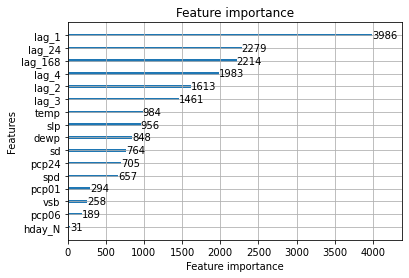

In [167]:
lgb.plot_importance(model)

In [168]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [157]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-05-09 19:00:00    4311.926283
2015-05-09 20:00:00    4833.836739
2015-05-09 21:00:00    4559.527751
2015-05-09 22:00:00    4263.528843
2015-05-09 23:00:00    4202.270598
                          ...     
2015-06-30 19:00:00    4799.129395
2015-06-30 20:00:00    4752.343498
2015-06-30 21:00:00    4058.405135
2015-06-30 22:00:00    4256.134821
2015-06-30 23:00:00    4061.458487
Length: 1253, dtype: float64

In [169]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='3495', ...)